In [1]:
# import pandas as pd

# # Set the display options for pandas
# pd.set_option('display.max_rows', 1000)  # You can adjust the number as needed
# pd.set_option('display.max_columns', None) 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
import sys
sys.path.append("..")
from dataloader import create_dataloader
from metric import Metric
import backbone
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate
torch.cuda.empty_cache()


# Set device to GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA A100 80GB PCIe


In [3]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
image_size = 384
num_workers = 4
num_labels = 21
thresholds = [0.5] * num_labels
in_channels = 3
num_classes = 21
data_dir = '../../../data/GT-main'

In [4]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')
test_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='test')

384
../../../data/GT-main/./set1/train.csv
384
../../../data/GT-main/./set1/val.csv
384
../../../data/GT-main/./set1/test.csv


In [5]:
# Create model and move to device
model = backbone.backbone['densenet201'](num_classes=num_classes)
model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

/home/deependra/project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Initialize Metric class
metric = Metric(num_classes=num_classes)
thresholds = None

# create empty lists to store predicted probabilities and true labels for each epoch
test_preds_all, test_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0,0]
a=0

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    model.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)    
        outputs = torch.sigmoid(outputs)
        
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad(): metric.update(outputs, labels)
            
    scheduler.step()
    
    # Print metrics on train set
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh = metric.compute()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    print(thresh)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    # Reset Metric class for evaluation
    metric.reset()

    # Evaluate model on validation set
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
 
            outputs = model(images)

            outputs = torch.sigmoid(outputs)
            metric.update(outputs, labels)
            running_loss += criterion(outputs, labels).item()

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += outputs.tolist()
            val_labels += labels.tolist()
 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh = metric.compute()
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()   
    print(thresh)  
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
        
    # Evaluate model on test set
    running_loss = 0.0
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)
 
            outputs = model(images)

            outputs = torch.sigmoid(outputs)
            metric.update(outputs, labels)
            running_loss += criterion(outputs, labels).item()

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            test_preds += outputs.tolist()
            test_labels += labels.tolist()
 
        # Print metrics on test set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh = metric.compute(thresholds = thresh)
        print(f"Test - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(test_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch
            max_ms[2] = optimizer.param_groups[0]['lr']
            torch.save(model, 'models/dn201-rfmid.pth')

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        test_preds_all.append(test_preds)
        test_labels_all.append(test_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for test set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(test_labels_all).ravel(), np.concatenate(test_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))

        print() # empty line for spacing
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()     
    
    print(thresh) 
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 

Epoch 1/200
----------


100%|██████████| 132/132 [00:39<00:00,  3.36it/s]


Epoch [1/200], Loss: 0.2508, ML mAP: 0.3095, ML F1: 0.6640, ML AUC: 0.7916, ML Score: 0.5506, Bin AUC: 0.6500, Model Score: 0.6003, Bin F1: 1.0000
[0.48 0.63 0.53 0.46 0.54 0.47 0.61 0.53 0.59 0.55 0.48 0.57 0.51 0.49
 0.71 0.6  0.64 0.76 0.58 0.59 0.6 ]
Accuracy list: [0.8671428571428571, 0.9523809523809523, 0.9123809523809524, 0.790952380952381, 0.8738095238095238, 0.8704761904761905, 0.9304761904761905, 0.930952380952381, 0.9395238095238095, 0.9385714285714286, 0.9404761904761905, 0.9347619047619048, 0.9295238095238095, 0.9071428571428571, 0.9357142857142857, 0.9547619047619048, 0.9414285714285714, 0.9414285714285714, 0.9476190476190476, 0.920952380952381, 0.9909523809523809]
Specificity list: [0.943986820428336, 0.9995002498750625, 0.9698544698544699, 0.8427267847557702, 0.9135610766045549, 0.9226190476190477, 0.9994884910485934, 0.9644670050761421, 0.9989873417721519, 0.9989863152559554, 0.9792824658918646, 0.9548254620123203, 0.977432296890672, 0.9327646763672856, 0.9994913530010

100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


Val - Epoch [1/200], Loss: 21.6940, ML mAP: 0.4695, ML F1: 0.6203, ML AUC: 0.9072, ML Score: 0.6883, Bin AUC: 1.0000, Model Score: 0.8442, Bin F1: 1.0000
[0.34 0.32 0.56 0.43 0.59 0.77 0.34 0.5  0.26 0.38 0.57 0.66 0.35 0.31
 0.53 0.32 0.51 0.48 0.47 0.3  0.26]
Accuracy list: [0.8995535714285714, 0.8839285714285714, 0.9464285714285714, 0.921875, 0.9464285714285714, 0.9241071428571429, 0.8950892857142857, 0.9732142857142857, 0.9642857142857143, 0.9866071428571429, 0.9866071428571429, 0.9799107142857143, 0.984375, 0.9799107142857143, 0.9665178571428571, 0.9754464285714286, 0.9821428571428571, 0.984375, 0.9933035714285714, 0.9040178571428571, 1.0]
Specificity list: [0.9299719887955182, 0.9421487603305785, 0.9787234042553191, 0.9728395061728395, 0.971830985915493, 0.9975903614457832, 0.9219858156028369, 0.9882903981264637, 0.993006993006993, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.981651376146789, 0.9839080459770115, 0.9863945578231292, 0.9977324263038548, 0.997737556561086, 1.

100%|██████████| 28/28 [00:07<00:00,  3.75it/s]


Test - Epoch [1/200], Loss: 21.6637, ML mAP: 0.4457, ML F1: 0.5711, ML AUC: 0.8932, ML Score: 0.6695, Bin AUC: 1.0000, Model Score: 0.8347, Bin F1: 1.0000

[0.34 0.32 0.56 0.43 0.59 0.77 0.34 0.5  0.26 0.38 0.57 0.66 0.35 0.31
 0.53 0.32 0.51 0.48 0.47 0.3  0.26]
Accuracy list: [0.8828828828828829, 0.8490990990990991, 0.9436936936936937, 0.8671171171171171, 0.9436936936936937, 0.918918918918919, 0.8716216216216216, 0.9819819819819819, 0.954954954954955, 0.9684684684684685, 0.9932432432432432, 0.9797297297297297, 0.9752252252252253, 0.9819819819819819, 0.9527027027027027, 0.9684684684684685, 0.9842342342342343, 0.9774774774774775, 0.9887387387387387, 0.8963963963963963, 1.0]
Specificity list: [0.9157303370786517, 0.9098360655737705, 0.9783132530120482, 0.9296482412060302, 0.9737470167064439, 1.0, 0.8983451536643026, 0.9905437352245863, 0.9813519813519813, 0.9953703703703703, 0.9976958525345622, 0.9954022988505747, 0.9953596287703016, 0.9838337182448037, 0.9611872146118722, 0.98623853211

100%|██████████| 132/132 [00:37<00:00,  3.54it/s]


Epoch [2/200], Loss: 0.2086, ML mAP: 0.6566, ML F1: 0.6957, ML AUC: 0.9298, ML Score: 0.7932, Bin AUC: 0.5500, Model Score: 0.6716, Bin F1: 1.0000
[0.36 0.29 0.36 0.36 0.39 0.35 0.24 0.42 0.62 0.46 0.32 0.49 0.3  0.37
 0.95 0.34 0.31 0.39 0.38 0.27 0.48]
Accuracy list: [0.9214285714285714, 0.9466666666666667, 0.930952380952381, 0.9123809523809524, 0.9385714285714286, 0.9147619047619048, 0.9028571428571428, 0.9752380952380952, 0.9419047619047619, 0.9380952380952381, 0.9661904761904762, 0.9761904761904762, 0.9628571428571429, 0.9814285714285714, 0.9371428571428572, 0.9619047619047619, 0.9514285714285714, 0.9452380952380952, 0.9742857142857143, 0.9342857142857143, 0.9995238095238095]
Specificity list: [0.9562398703403565, 0.968031968031968, 0.9603501544799176, 0.9534510433386838, 0.9666153055983564, 0.9411444141689373, 0.9317948717948717, 0.990849008642603, 0.9994946942900454, 0.9994926433282597, 0.9803229061553986, 0.9898063200815495, 0.9849018621036739, 0.9889944972486243, 0.99949212798

100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [2/200], Loss: 20.4639, ML mAP: 0.6248, ML F1: 0.7619, ML AUC: 0.9492, ML Score: 0.7870, Bin AUC: 1.0000, Model Score: 0.8935, Bin F1: 1.0000
[0.31 0.18 0.47 0.54 0.38 0.92 0.28 0.78 0.22 0.33 0.41 0.57 0.32 0.26
 0.91 0.4  0.6  0.5  0.24 0.14 0.17]
Accuracy list: [0.921875, 0.8727678571428571, 0.9598214285714286, 0.9575892857142857, 0.9441964285714286, 0.9241071428571429, 0.9397321428571429, 0.984375, 0.9821428571428571, 0.9821428571428571, 0.9866071428571429, 0.9977678571428571, 0.984375, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 0.9821428571428571, 0.984375, 0.9888392857142857, 0.8883928571428571, 1.0]
Specificity list: [0.9467787114845938, 0.8787878787878788, 0.9905437352245863, 0.9827160493827161, 0.9553990610328639, 0.9975903614457832, 0.9621749408983451, 0.9976580796252927, 0.9906759906759907, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9885321100917431, 0.9977011494252873, 0.9954648526077098, 0.9977324263038548,

100%|██████████| 28/28 [00:07<00:00,  3.92it/s]


Test - Epoch [2/200], Loss: 20.4626, ML mAP: 0.5903, ML F1: 0.5879, ML AUC: 0.9355, ML Score: 0.7629, Bin AUC: 1.0000, Model Score: 0.8815, Bin F1: 0.6667

[0.31 0.18 0.47 0.54 0.38 0.92 0.28 0.78 0.22 0.33 0.41 0.57 0.32 0.26
 0.91 0.4  0.6  0.5  0.24 0.14 0.17]
Accuracy list: [0.8986486486486487, 0.8355855855855856, 0.9481981981981982, 0.9234234234234234, 0.9459459459459459, 0.918918918918919, 0.9256756756756757, 0.9887387387387387, 0.9797297297297297, 0.972972972972973, 0.990990990990991, 0.9819819819819819, 0.9887387387387387, 0.9864864864864865, 0.9842342342342343, 0.9774774774774775, 0.9864864864864865, 0.9842342342342343, 0.9774774774774775, 0.8648648648648649, 1.0]
Specificity list: [0.9241573033707865, 0.8524590163934426, 0.9855421686746988, 0.9673366834170855, 0.9570405727923628, 1.0, 0.9550827423167849, 0.9976359338061466, 0.9883449883449883, 0.9976851851851852, 0.9930875576036866, 0.9908045977011494, 1.0, 0.9930715935334873, 0.9908675799086758, 0.9908256880733946, 0.9977220

100%|██████████| 132/132 [00:37<00:00,  3.54it/s]


Epoch [3/200], Loss: 0.1348, ML mAP: 0.7484, ML F1: 0.6992, ML AUC: 0.9550, ML Score: 0.8517, Bin AUC: 1.0000, Model Score: 0.9258, Bin F1: 1.0000
[0.31 0.23 0.28 0.32 0.37 0.36 0.23 0.33 0.24 0.2  0.35 0.39 0.29 0.38
 0.37 0.29 0.36 0.32 0.31 0.19 0.29]
Accuracy list: [0.9328571428571428, 0.9471428571428572, 0.94, 0.9376190476190476, 0.9466666666666667, 0.9471428571428572, 0.9238095238095239, 0.9780952380952381, 0.950952380952381, 0.9276190476190476, 0.9785714285714285, 0.9747619047619047, 0.9680952380952381, 0.9842857142857143, 0.9828571428571429, 0.9742857142857143, 0.9642857142857143, 0.960952380952381, 0.9809523809523809, 0.9304761904761905, 0.9995238095238095]
Specificity list: [0.9607843137254902, 0.9702920443101712, 0.9656938044034818, 0.9609292502639916, 0.9735477178423236, 0.9725658956428187, 0.950642673521851, 0.9838953195772522, 0.9709923664122138, 0.9509357612544259, 0.9909411172622044, 0.9856923863055698, 0.985478217325989, 0.9934738955823293, 0.9920119820269596, 0.984977

100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [3/200], Loss: 19.9303, ML mAP: 0.6644, ML F1: 0.7492, ML AUC: 0.9542, ML Score: 0.8093, Bin AUC: 1.0000, Model Score: 0.9047, Bin F1: 1.0000
[0.32 0.14 0.5  0.46 0.46 0.46 0.33 0.49 0.16 0.23 0.4  0.51 0.26 0.17
 0.45 0.45 0.53 0.55 0.53 0.18 0.16]
Accuracy list: [0.9330357142857143, 0.8772321428571429, 0.9598214285714286, 0.9642857142857143, 0.953125, 0.9709821428571429, 0.9263392857142857, 0.984375, 0.984375, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9821428571428571, 0.9754464285714286, 0.9866071428571429, 0.9977678571428571, 0.9821428571428571, 0.984375, 0.9955357142857143, 0.9174107142857143, 1.0]
Specificity list: [0.969187675070028, 0.8760330578512396, 0.9905437352245863, 0.9876543209876543, 0.9765258215962441, 0.9855421686746988, 0.9479905437352246, 0.9929742388758782, 0.993006993006993, 0.9954648526077098, 0.9954128440366973, 1.0, 0.9908675799086758, 0.9747706422018348, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 0.9977375565610

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Test - Epoch [3/200], Loss: 19.9235, ML mAP: 0.6370, ML F1: 0.6147, ML AUC: 0.9417, ML Score: 0.7893, Bin AUC: 0.9500, Model Score: 0.8697, Bin F1: 0.6667

[0.32 0.14 0.5  0.46 0.46 0.46 0.33 0.49 0.16 0.23 0.4  0.51 0.26 0.17
 0.45 0.45 0.53 0.55 0.53 0.18 0.16]
Accuracy list: [0.8963963963963963, 0.8333333333333334, 0.9481981981981982, 0.9279279279279279, 0.9662162162162162, 0.9436936936936937, 0.9256756756756757, 0.990990990990991, 0.9842342342342343, 0.9707207207207207, 0.990990990990991, 0.9842342342342343, 0.9797297297297297, 0.9842342342342343, 0.9774774774774775, 0.9797297297297297, 0.990990990990991, 0.9819819819819819, 0.9887387387387387, 0.8918918918918919, 1.0]
Specificity list: [0.9410112359550562, 0.8387978142076503, 0.980722891566265, 0.9723618090452262, 0.9761336515513126, 0.9754901960784313, 0.9527186761229315, 0.9929078014184397, 0.9906759906759907, 0.9930555555555556, 0.9907834101382489, 0.9954022988505747, 0.9976798143851509, 0.9861431870669746, 0.9840182648401826, 

100%|██████████| 132/132 [00:35<00:00,  3.70it/s]


Epoch [4/200], Loss: 0.1070, ML mAP: 0.8157, ML F1: 0.7544, ML AUC: 0.9681, ML Score: 0.8919, Bin AUC: 1.0000, Model Score: 0.9459, Bin F1: 1.0000
[0.32 0.26 0.3  0.33 0.24 0.35 0.27 0.36 0.29 0.25 0.45 0.4  0.21 0.28
 0.32 0.36 0.28 0.27 0.28 0.21 0.22]
Accuracy list: [0.9414285714285714, 0.9538095238095238, 0.9461904761904761, 0.9519047619047619, 0.94, 0.9495238095238095, 0.9371428571428572, 0.981904761904762, 0.9723809523809523, 0.9523809523809523, 0.9814285714285714, 0.9795238095238096, 0.9742857142857143, 0.9947619047619047, 0.9842857142857143, 0.9823809523809524, 0.9714285714285714, 0.9647619047619047, 0.9866666666666667, 0.9347619047619048, 0.9976190476190476]
Specificity list: [0.9663409337676439, 0.9734601902854282, 0.9656964656964657, 0.9734651404786681, 0.9501557632398754, 0.9699124726477024, 0.9686213991769548, 0.9934043632673769, 0.9928970065956367, 0.9831889964340296, 0.9954407294832827, 0.9881869542886492, 0.9844533600802408, 0.997020854021847, 0.9934310257705912, 0.9889

100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [4/200], Loss: 19.7541, ML mAP: 0.6514, ML F1: 0.7769, ML AUC: 0.9594, ML Score: 0.8054, Bin AUC: 1.0000, Model Score: 0.9027, Bin F1: 1.0000
[0.17 0.19 0.29 0.38 0.38 0.58 0.29 0.55 0.28 0.51 0.5  0.5  0.18 0.27
 0.5  0.83 0.56 0.79 0.4  0.12 0.06]
Accuracy list: [0.9241071428571429, 0.9040178571428571, 0.9441964285714286, 0.9620535714285714, 0.9575892857142857, 0.96875, 0.9263392857142857, 0.9866071428571429, 0.9799107142857143, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9754464285714286, 0.9799107142857143, 0.9866071428571429, 0.9821428571428571, 0.9821428571428571, 0.984375, 0.9910714285714286, 0.9084821428571429, 1.0]
Specificity list: [0.969187675070028, 0.9393939393939394, 0.9550827423167849, 0.9901234567901235, 0.9765258215962441, 0.9855421686746988, 0.9432624113475178, 0.9929742388758782, 0.993006993006993, 0.9977324263038548, 1.0, 0.9977272727272727, 0.9817351598173516, 0.981651376146789, 0.9977011494252873, 0.9977324263038548, 0.997732426303854

100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Test - Epoch [4/200], Loss: 19.7436, ML mAP: 0.6625, ML F1: 0.6752, ML AUC: 0.9517, ML Score: 0.8071, Bin AUC: 1.0000, Model Score: 0.9035, Bin F1: 1.0000

[0.17 0.19 0.29 0.38 0.38 0.58 0.29 0.55 0.28 0.51 0.5  0.5  0.18 0.27
 0.5  0.83 0.56 0.79 0.4  0.12 0.06]
Accuracy list: [0.918918918918919, 0.8851351351351351, 0.9436936936936937, 0.9414414414414415, 0.9662162162162162, 0.9391891891891891, 0.9211711711711712, 0.9954954954954955, 0.9707207207207207, 0.9707207207207207, 0.9932432432432432, 0.9819819819819819, 0.9842342342342343, 0.9842342342342343, 0.9887387387387387, 0.9842342342342343, 0.9887387387387387, 0.9842342342342343, 0.9864864864864865, 0.8918918918918919, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.9234972677595629, 0.9493975903614458, 0.9874371859296482, 0.9785202863961814, 0.9730392156862745, 0.9456264775413712, 1.0, 0.9790209790209791, 0.9976851851851852, 0.9930875576036866, 0.9885057471264368, 0.9953596287703016, 0.9861431870669746, 0.990867579908675

100%|██████████| 132/132 [00:38<00:00,  3.41it/s]


Epoch [5/200], Loss: 0.1002, ML mAP: 0.8394, ML F1: 0.7807, ML AUC: 0.9731, ML Score: 0.9062, Bin AUC: 1.0000, Model Score: 0.9531, Bin F1: 0.6667
[0.36 0.26 0.41 0.31 0.31 0.32 0.26 0.35 0.3  0.21 0.36 0.34 0.22 0.41
 0.27 0.32 0.33 0.34 0.32 0.22 0.19]
Accuracy list: [0.9547619047619048, 0.9614285714285714, 0.9585714285714285, 0.9457142857142857, 0.9404761904761905, 0.9580952380952381, 0.9461904761904761, 0.9776190476190476, 0.9776190476190476, 0.9557142857142857, 0.99, 0.9842857142857143, 0.9804761904761905, 0.9938095238095238, 0.9857142857142858, 0.9880952380952381, 0.9752380952380952, 0.9771428571428571, 0.9895238095238095, 0.94, 1.0]
Specificity list: [0.980498374864572, 0.9795102448775612, 0.987667009249743, 0.9704797047970479, 0.9630996309963099, 0.9734848484848485, 0.9722507708119219, 0.9879093198992444, 0.9909365558912386, 0.9762025316455696, 0.9969325153374233, 0.9908022483392949, 0.9889336016096579, 0.9979909593169262, 0.9899040888440181, 0.9930417495029821, 0.9867414584395

100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [5/200], Loss: 19.7106, ML mAP: 0.6892, ML F1: 0.7896, ML AUC: 0.9634, ML Score: 0.8263, Bin AUC: 1.0000, Model Score: 0.9131, Bin F1: 1.0000
[0.4  0.23 0.44 0.26 0.39 0.55 0.37 0.57 0.28 0.7  0.37 0.47 0.47 0.41
 0.39 0.48 0.66 0.85 0.59 0.14 0.06]
Accuracy list: [0.9285714285714286, 0.8973214285714286, 0.9575892857142857, 0.9508928571428571, 0.9464285714285714, 0.9754464285714286, 0.9419642857142857, 0.9910714285714286, 0.9866071428571429, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9910714285714286, 0.9866071428571429, 0.984375, 0.9955357142857143, 0.9821428571428571, 0.984375, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.9831932773109243, 0.9338842975206612, 0.983451536643026, 0.9777777777777777, 0.9577464788732394, 0.9855421686746988, 0.9621749408983451, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9954545454545455, 0.997716894977169, 0.9931192660550459, 0.993103448275862, 0.9954648526077098, 0

100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Test - Epoch [5/200], Loss: 19.7066, ML mAP: 0.6739, ML F1: 0.6500, ML AUC: 0.9539, ML Score: 0.8139, Bin AUC: 1.0000, Model Score: 0.9069, Bin F1: 1.0000

[0.4  0.23 0.44 0.26 0.39 0.55 0.37 0.57 0.28 0.7  0.37 0.47 0.47 0.41
 0.39 0.48 0.66 0.85 0.59 0.14 0.06]
Accuracy list: [0.9144144144144144, 0.8828828828828829, 0.9617117117117117, 0.9256756756756757, 0.9527027027027027, 0.9436936936936937, 0.9324324324324325, 0.990990990990991, 0.9842342342342343, 0.972972972972973, 0.9887387387387387, 0.9819819819819819, 0.9842342342342343, 0.9887387387387387, 0.9819819819819819, 0.9864864864864865, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.8986486486486487, 1.0]
Specificity list: [0.9662921348314607, 0.9207650273224044, 0.980722891566265, 0.9547738693467337, 0.9618138424821002, 0.9730392156862745, 0.9621749408983451, 1.0, 0.993006993006993, 1.0, 0.988479262672811, 0.9885057471264368, 0.9976798143851509, 0.9953810623556582, 0.9863013698630136, 0.9908256880733946, 1.0, 0.9954

100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [6/200], Loss: 0.0836, ML mAP: 0.8705, ML F1: 0.8063, ML AUC: 0.9796, ML Score: 0.9251, Bin AUC: 0.9500, Model Score: 0.9375, Bin F1: 1.0000
[0.38 0.22 0.3  0.31 0.34 0.48 0.29 0.35 0.3  0.28 0.32 0.35 0.27 0.35
 0.33 0.43 0.46 0.33 0.24 0.28 0.15]
Accuracy list: [0.9623809523809523, 0.9547619047619048, 0.9504761904761905, 0.9571428571428572, 0.9566666666666667, 0.9642857142857143, 0.9595238095238096, 0.9852380952380952, 0.9838095238095238, 0.9638095238095238, 0.99, 0.9871428571428571, 0.9804761904761905, 0.9933333333333333, 0.9861904761904762, 0.9914285714285714, 0.9761904761904762, 0.9776190476190476, 0.9895238095238095, 0.9523809523809523, 1.0]
Specificity list: [0.9871175523349437, 0.9692074709742554, 0.9736161407139162, 0.9769994772608468, 0.9751295336787564, 0.9860813704496788, 0.9796954314720813, 0.9939607448414696, 0.9949238578680203, 0.984794728839331, 0.9949005609382968, 0.9928644240570846, 0.9914357682619648, 0.9974823766364552, 0.9918946301925026, 0.9969954932398598, 

100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [6/200], Loss: 19.6232, ML mAP: 0.6999, ML F1: 0.7941, ML AUC: 0.9695, ML Score: 0.8347, Bin AUC: 1.0000, Model Score: 0.9173, Bin F1: 1.0000
[0.09 0.24 0.25 0.22 0.41 0.45 0.35 0.48 0.17 0.74 0.48 0.47 0.54 0.18
 0.61 0.68 0.61 0.54 0.33 0.1  0.09]
Accuracy list: [0.921875, 0.8973214285714286, 0.9620535714285714, 0.9464285714285714, 0.9419642857142857, 0.9732142857142857, 0.9441964285714286, 0.9866071428571429, 0.984375, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.9910714285714286, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9821428571428571, 0.984375, 0.9955357142857143, 0.9151785714285714, 1.0]
Specificity list: [0.938375350140056, 0.9146005509641874, 0.9692671394799054, 0.9654320987654321, 0.9553990610328639, 0.9855421686746988, 0.9645390070921985, 0.9929742388758782, 0.9883449883449883, 0.9977324263038548, 1.0, 0.9954545454545455, 1.0, 0.9885321100917431, 0.9977011494252873, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 

100%|██████████| 28/28 [00:07<00:00,  3.94it/s]


Test - Epoch [6/200], Loss: 19.6192, ML mAP: 0.6857, ML F1: 0.6479, ML AUC: 0.9565, ML Score: 0.8211, Bin AUC: 1.0000, Model Score: 0.9105, Bin F1: 1.0000

[0.09 0.24 0.25 0.22 0.41 0.45 0.35 0.48 0.17 0.74 0.48 0.47 0.54 0.18
 0.61 0.68 0.61 0.54 0.33 0.1  0.09]
Accuracy list: [0.9076576576576577, 0.8851351351351351, 0.9481981981981982, 0.9144144144144144, 0.954954954954955, 0.9527027027027027, 0.9391891891891891, 0.990990990990991, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9797297297297297, 0.9819819819819819, 0.9864864864864865, 0.9864864864864865, 0.9842342342342343, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.8918918918918919, 1.0]
Specificity list: [0.9241573033707865, 0.9043715846994536, 0.9542168674698795, 0.9422110552763819, 0.964200477326969, 0.9754901960784313, 0.9645390070921985, 0.9976359338061466, 0.986013986013986, 1.0, 0.9953917050691244, 0.9885057471264368, 1.0, 0.9907621247113164, 0.9908675799086758, 0.9908256880733946, 0.997722095

100%|██████████| 132/132 [00:34<00:00,  3.77it/s]


Epoch [7/200], Loss: 0.0849, ML mAP: 0.9022, ML F1: 0.8400, ML AUC: 0.9848, ML Score: 0.9435, Bin AUC: 1.0000, Model Score: 0.9718, Bin F1: 1.0000
[0.35 0.3  0.29 0.33 0.34 0.47 0.27 0.33 0.29 0.24 0.31 0.39 0.35 0.17
 0.41 0.33 0.34 0.38 0.25 0.19 0.1 ]
Accuracy list: [0.9628571428571429, 0.9652380952380952, 0.9619047619047619, 0.9576190476190476, 0.9685714285714285, 0.9661904761904762, 0.9676190476190476, 0.9857142857142858, 0.9871428571428571, 0.97, 0.9957142857142857, 0.9885714285714285, 0.9880952380952381, 0.9952380952380953, 0.9923809523809524, 0.991904761904762, 0.9785714285714285, 0.9838095238095238, 0.9895238095238095, 0.9461904761904761, 1.0]
Specificity list: [0.9875473741201949, 0.9819909954977488, 0.9753086419753086, 0.9788135593220338, 0.9803210771620922, 0.988673139158576, 0.9827848101265823, 0.9924357034795764, 0.9959636730575177, 0.9831632653061224, 0.9979848866498741, 0.9928644240570846, 0.999002493765586, 0.9949974987493747, 0.9964285714285714, 0.994982438534872, 0.9

100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [7/200], Loss: 19.6004, ML mAP: 0.7105, ML F1: 0.8194, ML AUC: 0.9711, ML Score: 0.8408, Bin AUC: 1.0000, Model Score: 0.9204, Bin F1: 1.0000
[0.39 0.25 0.3  0.23 0.96 0.21 0.21 0.45 0.17 0.62 0.38 0.26 0.54 0.33
 0.45 0.74 0.77 0.84 0.43 0.11 0.06]
Accuracy list: [0.9308035714285714, 0.8973214285714286, 0.9553571428571429, 0.953125, 0.9486607142857143, 0.9776785714285714, 0.9107142857142857, 0.9866071428571429, 0.9910714285714286, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9910714285714286, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9821428571428571, 0.984375, 0.9955357142857143, 0.9107142857142857, 1.0]
Specificity list: [0.969187675070028, 0.9256198347107438, 0.9645390070921985, 0.9703703703703703, 0.9976525821596244, 0.9855421686746988, 0.9148936170212766, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 0.9954545454545455, 1.0, 0.9908256880733946, 0.9977011494252873, 0.9954648526077098, 0.997732426303

100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Test - Epoch [7/200], Loss: 19.5982, ML mAP: 0.6916, ML F1: 0.6331, ML AUC: 0.9584, ML Score: 0.8250, Bin AUC: 0.9500, Model Score: 0.8875, Bin F1: 0.6667

[0.39 0.25 0.3  0.23 0.96 0.21 0.21 0.45 0.17 0.62 0.38 0.26 0.54 0.33
 0.45 0.74 0.77 0.84 0.43 0.11 0.06]
Accuracy list: [0.9076576576576577, 0.8828828828828829, 0.9594594594594594, 0.9076576576576577, 0.9481981981981982, 0.9504504504504504, 0.9166666666666666, 0.990990990990991, 0.9774774774774775, 0.972972972972973, 0.9864864864864865, 0.9819819819819819, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.8851351351351351, 1.0]
Specificity list: [0.952247191011236, 0.9234972677595629, 0.9662650602409638, 0.9396984924623115, 1.0, 0.9730392156862745, 0.9314420803782506, 0.9976359338061466, 0.9813519813519813, 1.0, 0.9861751152073732, 0.9908045977011494, 1.0, 0.9930715935334873, 0.9908675799086758, 0.9908256880733946, 0.9977220956719818, 0.99

100%|██████████| 132/132 [00:36<00:00,  3.62it/s]


Epoch [8/200], Loss: 0.1402, ML mAP: 0.9112, ML F1: 0.8458, ML AUC: 0.9858, ML Score: 0.9485, Bin AUC: 1.0000, Model Score: 0.9742, Bin F1: 1.0000
[0.32 0.32 0.33 0.32 0.38 0.37 0.31 0.29 0.22 0.33 0.28 0.41 0.26 0.37
 0.51 0.44 0.43 0.38 0.39 0.18 0.25]
Accuracy list: [0.9619047619047619, 0.9647619047619047, 0.9642857142857143, 0.9666666666666667, 0.969047619047619, 0.960952380952381, 0.9647619047619047, 0.9866666666666667, 0.9842857142857143, 0.9785714285714285, 0.991904761904762, 0.9880952380952381, 0.9866666666666667, 0.9947619047619047, 0.99, 0.9914285714285714, 0.9885714285714285, 0.9866666666666667, 0.9933333333333333, 0.9452380952380952, 0.9995238095238095]
Specificity list: [0.9832522960561858, 0.9843434343434343, 0.9775510204081632, 0.9763282482903735, 0.9824561403508771, 0.9791889007470651, 0.9848254931714719, 0.9892638036809815, 0.9913967611336032, 0.9924280666330136, 0.9979838709677419, 0.9938775510204082, 0.992496248124062, 0.9969818913480886, 0.9984879032258065, 0.997478

100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [8/200], Loss: 19.5538, ML mAP: 0.7237, ML F1: 0.8114, ML AUC: 0.9729, ML Score: 0.8483, Bin AUC: 1.0000, Model Score: 0.9242, Bin F1: 1.0000
[0.29 0.21 0.34 0.34 0.28 0.27 0.35 0.65 0.24 0.59 0.57 0.42 0.26 0.48
 0.23 0.51 0.68 0.84 0.44 0.1  0.08]
Accuracy list: [0.9308035714285714, 0.90625, 0.96875, 0.953125, 0.9285714285714286, 0.9732142857142857, 0.9508928571428571, 0.984375, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9933035714285714, 0.984375, 0.984375, 0.9977678571428571, 0.9821428571428571, 0.984375, 0.9955357142857143, 0.9107142857142857, 1.0]
Specificity list: [0.9635854341736695, 0.9201101928374655, 0.9810874704491725, 0.9703703703703703, 0.931924882629108, 0.9855421686746988, 0.9739952718676123, 0.9929742388758782, 1.0, 0.9977324263038548, 1.0, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.9839080459770115, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 0.9977477477477478, 0.9444444444444444, 1.0

100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Test - Epoch [8/200], Loss: 19.5555, ML mAP: 0.7085, ML F1: 0.6737, ML AUC: 0.9577, ML Score: 0.8331, Bin AUC: 1.0000, Model Score: 0.9165, Bin F1: 0.6667

[0.29 0.21 0.34 0.34 0.28 0.27 0.35 0.65 0.24 0.59 0.57 0.42 0.26 0.48
 0.23 0.51 0.68 0.84 0.44 0.1  0.08]
Accuracy list: [0.9099099099099099, 0.8851351351351351, 0.9684684684684685, 0.9166666666666666, 0.9346846846846847, 0.9459459459459459, 0.9459459459459459, 0.9954954954954955, 0.9887387387387387, 0.9752252252252253, 0.9954954954954955, 0.9842342342342343, 0.990990990990991, 0.990990990990991, 0.963963963963964, 0.9864864864864865, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.8806306306306306, 1.0]
Specificity list: [0.9438202247191011, 0.912568306010929, 0.9783132530120482, 0.9522613065326633, 0.9379474940334129, 0.9754901960784313, 0.9763593380614657, 1.0, 0.993006993006993, 1.0, 0.9953917050691244, 0.993103448275862, 1.0, 0.9976905311778291, 0.9634703196347032, 0.9908256880733946, 0.9977220956719818, 0.99545

100%|██████████| 132/132 [00:35<00:00,  3.69it/s]


Epoch [9/200], Loss: 0.1362, ML mAP: 0.9257, ML F1: 0.8613, ML AUC: 0.9876, ML Score: 0.9566, Bin AUC: 1.0000, Model Score: 0.9783, Bin F1: 1.0000
[0.31 0.23 0.3  0.43 0.32 0.38 0.36 0.28 0.27 0.26 0.47 0.36 0.3  0.27
 0.33 0.48 0.27 0.41 0.27 0.18 0.19]
Accuracy list: [0.9676190476190476, 0.9528571428571428, 0.9709523809523809, 0.9685714285714285, 0.9642857142857143, 0.9747619047619047, 0.9633333333333334, 0.9852380952380952, 0.9866666666666667, 0.9823809523809524, 0.9928571428571429, 0.9904761904761905, 0.9942857142857143, 0.9947619047619047, 0.9904761904761905, 0.9947619047619047, 0.9885714285714285, 0.9876190476190476, 0.9966666666666667, 0.95, 1.0]
Specificity list: [0.9864056552474171, 0.9665835411471322, 0.9845360824742269, 0.9890282131661442, 0.9772492244053774, 0.9863685932388222, 0.9886831275720165, 0.9908069458631257, 0.9939485627836612, 0.9923896499238964, 0.9994949494949495, 0.9943820224719101, 0.998012916045703, 0.9964929859719439, 0.9944416371905003, 0.9979746835443037, 

100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Val - Epoch [9/200], Loss: 19.5262, ML mAP: 0.7215, ML F1: 0.8282, ML AUC: 0.9732, ML Score: 0.8474, Bin AUC: 1.0000, Model Score: 0.9237, Bin F1: 1.0000
[0.23 0.28 0.28 0.35 0.96 0.29 0.37 0.58 0.27 0.42 0.47 0.51 0.24 0.35
 0.39 0.36 0.6  0.83 0.61 0.09 0.1 ]
Accuracy list: [0.9263392857142857, 0.9084821428571429, 0.9642857142857143, 0.9553571428571429, 0.9486607142857143, 0.9776785714285714, 0.9464285714285714, 0.9888392857142857, 0.9910714285714286, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9821428571428571, 0.984375, 0.9955357142857143, 0.90625, 1.0]
Specificity list: [0.9663865546218487, 0.9421487603305785, 0.9763593380614657, 0.9777777777777777, 0.9976525821596244, 0.9879518072289156, 0.9739952718676123, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 1

100%|██████████| 28/28 [00:06<00:00,  4.11it/s]


Test - Epoch [9/200], Loss: 19.5290, ML mAP: 0.7066, ML F1: 0.6934, ML AUC: 0.9597, ML Score: 0.8332, Bin AUC: 1.0000, Model Score: 0.9166, Bin F1: 0.6667

[0.23 0.28 0.28 0.35 0.96 0.29 0.37 0.58 0.27 0.42 0.47 0.51 0.24 0.35
 0.39 0.36 0.6  0.83 0.61 0.09 0.1 ]
Accuracy list: [0.9166666666666666, 0.9009009009009009, 0.9662162162162162, 0.9234234234234234, 0.9436936936936937, 0.9481981981981982, 0.9481981981981982, 0.990990990990991, 0.9864864864864865, 0.9707207207207207, 0.9932432432432432, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9887387387387387, 0.9842342342342343, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.8716216216216216, 1.0]
Specificity list: [0.9550561797752809, 0.9371584699453552, 0.9734939759036144, 0.9547738693467337, 0.9976133651551312, 0.9754901960784313, 0.9787234042553191, 1.0, 0.9906759906759907, 0.9976851851851852, 0.9930875576036866, 0.993103448275862, 1.0, 0.9953810623556582, 0.9908675799086758, 0.9885321100917431, 0.99772209

100%|██████████| 132/132 [00:37<00:00,  3.54it/s]


Epoch [10/200], Loss: 0.1588, ML mAP: 0.9174, ML F1: 0.8551, ML AUC: 0.9862, ML Score: 0.9518, Bin AUC: 1.0000, Model Score: 0.9759, Bin F1: 1.0000
[0.35 0.28 0.26 0.26 0.41 0.43 0.31 0.24 0.28 0.32 0.36 0.34 0.28 0.33
 0.42 0.41 0.37 0.4  0.3  0.23 0.15]
Accuracy list: [0.969047619047619, 0.9628571428571429, 0.9633333333333334, 0.9538095238095238, 0.9623809523809523, 0.9766666666666667, 0.9561904761904761, 0.9823809523809524, 0.9880952380952381, 0.9828571428571429, 0.9923809523809524, 0.9895238095238095, 0.9895238095238095, 0.9966666666666667, 0.9923809523809524, 0.9952380952380953, 0.9923809523809524, 0.99, 0.9947619047619047, 0.9538095238095238, 0.9995238095238095]
Specificity list: [0.9875675675675676, 0.9824385348720521, 0.9707241910631741, 0.9686836518046709, 0.9839958699019101, 0.9908306364617044, 0.9749744637385087, 0.9868220983274202, 0.9959595959595959, 0.9959287531806615, 0.9984794728839331, 0.9918367346938776, 0.9969954932398598, 0.9965139442231076, 0.9964894684052157, 0.99

100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Val - Epoch [10/200], Loss: 19.5414, ML mAP: 0.7259, ML F1: 0.8155, ML AUC: 0.9725, ML Score: 0.8492, Bin AUC: 1.0000, Model Score: 0.9246, Bin F1: 1.0000
[0.25 0.23 0.39 0.27 0.45 0.31 0.26 0.56 0.18 0.63 0.53 0.5  0.37 0.12
 0.64 0.35 0.71 0.76 0.56 0.11 0.09]
Accuracy list: [0.9330357142857143, 0.9107142857142857, 0.9709821428571429, 0.953125, 0.953125, 0.9776785714285714, 0.9285714285714286, 0.9888392857142857, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9821428571428571, 0.984375, 0.9955357142857143, 0.9107142857142857, 1.0]
Specificity list: [0.9607843137254902, 0.9338842975206612, 0.9858156028368794, 0.9753086419753086, 0.9671361502347418, 0.9879518072289156, 0.9408983451536643, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9862385321100917, 0.9977011494252873, 0.9977324263038548, 0.9977324263038548, 0.997737556561086,

100%|██████████| 28/28 [00:07<00:00,  3.70it/s]


Test - Epoch [10/200], Loss: 19.5449, ML mAP: 0.7062, ML F1: 0.6808, ML AUC: 0.9589, ML Score: 0.8325, Bin AUC: 1.0000, Model Score: 0.9163, Bin F1: 0.6667

[0.25 0.23 0.39 0.27 0.45 0.31 0.26 0.56 0.18 0.63 0.53 0.5  0.37 0.12
 0.64 0.35 0.71 0.76 0.56 0.11 0.09]
Accuracy list: [0.9121621621621622, 0.8896396396396397, 0.9707207207207207, 0.9211711711711712, 0.963963963963964, 0.9481981981981982, 0.9301801801801802, 0.990990990990991, 0.9842342342342343, 0.972972972972973, 0.9932432432432432, 0.9864864864864865, 0.990990990990991, 0.990990990990991, 0.9887387387387387, 0.9819819819819819, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.8896396396396397, 1.0]
Specificity list: [0.9382022471910112, 0.9207650273224044, 0.980722891566265, 0.949748743718593, 0.9713603818615751, 0.9779411764705882, 0.9550827423167849, 1.0, 0.9883449883449883, 1.0, 0.9930875576036866, 0.9954022988505747, 1.0, 0.9930715935334873, 0.9908675799086758, 0.9862385321100917, 0.9977220956719818, 0.99318

100%|██████████| 132/132 [00:35<00:00,  3.76it/s]


Epoch [11/200], Loss: 0.1059, ML mAP: 0.9063, ML F1: 0.8478, ML AUC: 0.9847, ML Score: 0.9455, Bin AUC: 1.0000, Model Score: 0.9728, Bin F1: 1.0000
[0.3  0.26 0.36 0.27 0.31 0.42 0.33 0.39 0.27 0.27 0.39 0.31 0.29 0.28
 0.44 0.38 0.35 0.33 0.24 0.23 0.26]
Accuracy list: [0.9604761904761905, 0.9604761904761905, 0.96, 0.9628571428571429, 0.9614285714285714, 0.9676190476190476, 0.96, 0.9866666666666667, 0.9814285714285714, 0.9804761904761905, 0.9895238095238095, 0.99, 0.9909523809523809, 0.9947619047619047, 0.9933333333333333, 0.9938095238095238, 0.9880952380952381, 0.9833333333333333, 0.9923809523809524, 0.9580952380952381, 0.9995238095238095]
Specificity list: [0.9826086956521739, 0.9768960321446509, 0.9813278008298755, 0.9747899159663865, 0.9771071800208116, 0.9815618221258134, 0.9861182519280206, 0.9944360141628731, 0.9913924050632912, 0.9883307965499746, 0.9974886991461577, 0.9927423535510628, 0.9969954932398598, 0.997491219267436, 0.9984871406959153, 0.9975099601593626, 0.9939301972

100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [11/200], Loss: 19.4972, ML mAP: 0.7339, ML F1: 0.8192, ML AUC: 0.9711, ML Score: 0.8525, Bin AUC: 1.0000, Model Score: 0.9263, Bin F1: 0.6667
[0.17 0.23 0.53 0.6  0.37 0.42 0.46 0.35 0.16 0.75 0.53 0.38 0.3  0.38
 0.14 0.67 0.81 0.69 0.45 0.14 0.04]
Accuracy list: [0.921875, 0.9129464285714286, 0.9754464285714286, 0.9598214285714286, 0.9397321428571429, 0.9776785714285714, 0.9486607142857143, 0.9888392857142857, 0.9888392857142857, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9821428571428571, 0.984375, 0.9955357142857143, 0.9107142857142857, 1.0]
Specificity list: [0.9551820728291317, 0.9586776859504132, 0.9881796690307328, 0.9876543209876543, 0.9436619718309859, 0.9879518072289156, 0.9787234042553191, 0.9929742388758782, 0.9953379953379954, 0.9977324263038548, 1.0, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.99773242630

100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Test - Epoch [11/200], Loss: 19.5039, ML mAP: 0.6814, ML F1: 0.6848, ML AUC: 0.9523, ML Score: 0.8169, Bin AUC: 0.9500, Model Score: 0.8834, Bin F1: 1.0000

[0.17 0.23 0.53 0.6  0.37 0.42 0.46 0.35 0.16 0.75 0.53 0.38 0.3  0.38
 0.14 0.67 0.81 0.69 0.45 0.14 0.04]
Accuracy list: [0.9166666666666666, 0.9031531531531531, 0.9617117117117117, 0.9279279279279279, 0.9481981981981982, 0.9617117117117117, 0.9481981981981982, 0.990990990990991, 0.9797297297297297, 0.972972972972973, 0.9932432432432432, 0.9864864864864865, 0.990990990990991, 0.9932432432432432, 0.9819819819819819, 0.9887387387387387, 0.9954954954954955, 0.9842342342342343, 0.9887387387387387, 0.9031531531531531, 1.0]
Specificity list: [0.9382022471910112, 0.953551912568306, 0.983132530120482, 0.964824120603015, 0.9522673031026253, 0.9803921568627451, 0.9810874704491725, 0.9976359338061466, 0.9836829836829837, 1.0, 0.9953917050691244, 0.993103448275862, 1.0, 0.9953810623556582, 0.9840182648401826, 0.9908256880733946, 1.0, 0.99318

100%|██████████| 132/132 [00:35<00:00,  3.73it/s]


Epoch [12/200], Loss: 0.0905, ML mAP: 0.9138, ML F1: 0.8462, ML AUC: 0.9866, ML Score: 0.9502, Bin AUC: 0.9500, Model Score: 0.9501, Bin F1: 0.0000
[0.46 0.19 0.43 0.28 0.33 0.3  0.3  0.34 0.25 0.28 0.33 0.31 0.35 0.34
 0.31 0.26 0.31 0.36 0.23 0.24 0.14]
Accuracy list: [0.9557142857142857, 0.9595238095238096, 0.9642857142857143, 0.9552380952380952, 0.9585714285714285, 0.9671428571428572, 0.9538095238095238, 0.9838095238095238, 0.9814285714285714, 0.9804761904761905, 0.9909523809523809, 0.9895238095238095, 0.9904761904761905, 0.9980952380952381, 0.9890476190476191, 0.991904761904762, 0.9847619047619047, 0.9842857142857143, 0.991904761904762, 0.9538095238095238, 1.0]
Specificity list: [0.987465940054496, 0.971, 0.9864935064935065, 0.9664, 0.9752891692954785, 0.9747854077253219, 0.9745454545454545, 0.9924050632911392, 0.988377968671046, 0.9908303616912888, 0.9969574036511156, 0.991353001017294, 0.9984984984984985, 0.998496993987976, 0.9938993390950687, 0.9934869739478958, 0.9899244332493

100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [12/200], Loss: 19.4471, ML mAP: 0.7201, ML F1: 0.8351, ML AUC: 0.9681, ML Score: 0.8441, Bin AUC: 1.0000, Model Score: 0.9220, Bin F1: 1.0000
[0.24 0.29 0.36 0.17 0.99 0.27 0.3  0.25 0.14 0.84 0.74 0.19 0.55 0.2
 0.52 0.1  0.66 0.31 0.34 0.13 0.02]
Accuracy list: [0.9330357142857143, 0.9107142857142857, 0.9642857142857143, 0.9553571428571429, 0.9464285714285714, 0.9732142857142857, 0.9464285714285714, 0.9888392857142857, 0.9933035714285714, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9910714285714286, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.984375, 0.9955357142857143, 0.9196428571428571, 1.0]
Specificity list: [0.9495798319327731, 0.928374655647383, 0.9787234042553191, 0.9876543209876543, 0.9953051643192489, 0.980722891566265, 0.9574468085106383, 1.0, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9977272727272727, 0.997716894977169, 0.9885321100917431, 0.9977011494252873, 0.9977324263038548, 0.9977324263038548, 0.997737556

100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Test - Epoch [12/200], Loss: 19.4574, ML mAP: 0.7052, ML F1: 0.6465, ML AUC: 0.9582, ML Score: 0.8317, Bin AUC: 0.9500, Model Score: 0.8909, Bin F1: 0.6667

[0.24 0.29 0.36 0.17 0.99 0.27 0.3  0.25 0.14 0.84 0.74 0.19 0.55 0.2
 0.52 0.1  0.66 0.31 0.34 0.13 0.02]
Accuracy list: [0.9324324324324325, 0.8873873873873874, 0.963963963963964, 0.918918918918919, 0.9459459459459459, 0.9504504504504504, 0.9324324324324325, 0.9887387387387387, 0.9752252252252253, 0.972972972972973, 1.0, 0.9819819819819819, 0.9864864864864865, 0.9887387387387387, 0.9842342342342343, 0.9864864864864865, 0.9954954954954955, 0.9842342342342343, 0.9887387387387387, 0.9009009009009009, 0.9954954954954955]
Specificity list: [0.949438202247191, 0.9153005464480874, 0.9734939759036144, 0.9623115577889447, 0.9976133651551312, 0.9779411764705882, 0.9550827423167849, 1.0, 0.9836829836829837, 1.0, 1.0, 0.9908045977011494, 1.0, 0.9930715935334873, 0.9885844748858448, 0.9862385321100917, 0.9977220956719818, 0.9931818181818182, 

100%|██████████| 132/132 [00:34<00:00,  3.85it/s]


Epoch [13/200], Loss: 0.1316, ML mAP: 0.9384, ML F1: 0.8847, ML AUC: 0.9907, ML Score: 0.9645, Bin AUC: 1.0000, Model Score: 0.9823, Bin F1: 1.0000
[0.34 0.3  0.28 0.4  0.35 0.39 0.38 0.36 0.28 0.33 0.27 0.4  0.27 0.49
 0.4  0.35 0.35 0.29 0.27 0.22 0.13]
Accuracy list: [0.9633333333333334, 0.9761904761904762, 0.9742857142857143, 0.9685714285714285, 0.97, 0.9752380952380952, 0.9628571428571429, 0.9895238095238095, 0.9866666666666667, 0.9866666666666667, 0.9947619047619047, 0.9885714285714285, 0.9966666666666667, 0.9957142857142857, 0.9928571428571429, 0.9952380952380953, 0.9876190476190476, 0.9895238095238095, 0.9957142857142857, 0.9623809523809523, 0.9995238095238095]
Specificity list: [0.9799891833423472, 0.9875683739433118, 0.9809179989685405, 0.9888947646747752, 0.9813374805598756, 0.9858618814573138, 0.9866255144032922, 0.9954361054766734, 0.9949443882709808, 0.9938869077941925, 0.9959899749373433, 0.9928020565552699, 0.9984947315604616, 0.9994969818913481, 0.9969450101832994, 0.9

100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [13/200], Loss: 19.4469, ML mAP: 0.7271, ML F1: 0.8134, ML AUC: 0.9709, ML Score: 0.8490, Bin AUC: 1.0000, Model Score: 0.9245, Bin F1: 1.0000
[0.1  0.13 0.28 0.27 0.63 0.77 0.24 0.29 0.27 0.88 0.91 0.38 0.51 0.06
 0.5  0.87 0.92 0.64 0.51 0.32 0.06]
Accuracy list: [0.921875, 0.890625, 0.9754464285714286, 0.9508928571428571, 0.9665178571428571, 0.9776785714285714, 0.9441964285714286, 0.9888392857142857, 0.9910714285714286, 0.9821428571428571, 0.9866071428571429, 0.9977678571428571, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9799107142857143, 0.984375, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9439775910364145, 0.9035812672176309, 0.9929078014184397, 0.9703703703703703, 0.9859154929577465, 0.9903614457831326, 0.9574468085106383, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9862385321100917, 0.9977011494252873, 0.9977324263038548, 0.9954648526077098, 0.9

100%|██████████| 28/28 [00:06<00:00,  4.06it/s]


Test - Epoch [13/200], Loss: 19.4496, ML mAP: 0.7122, ML F1: 0.6644, ML AUC: 0.9566, ML Score: 0.8344, Bin AUC: 0.9500, Model Score: 0.8922, Bin F1: 0.6667

[0.1  0.13 0.28 0.27 0.63 0.77 0.24 0.29 0.27 0.88 0.91 0.38 0.51 0.06
 0.5  0.87 0.92 0.64 0.51 0.32 0.06]
Accuracy list: [0.9234234234234234, 0.8716216216216216, 0.9752252252252253, 0.9369369369369369, 0.9617117117117117, 0.9572072072072072, 0.9256756756756757, 0.990990990990991, 0.9887387387387387, 0.972972972972973, 0.9932432432432432, 0.9819819819819819, 0.9887387387387387, 0.9864864864864865, 0.9842342342342343, 0.9842342342342343, 0.9932432432432432, 0.9819819819819819, 0.9887387387387387, 0.918918918918919, 1.0]
Specificity list: [0.9382022471910112, 0.907103825136612, 0.9903614457831326, 0.964824120603015, 0.9737470167064439, 0.9877450980392157, 0.9527186761229315, 1.0, 0.9953379953379954, 1.0, 0.9976958525345622, 0.9885057471264368, 1.0, 0.9884526558891455, 0.9885844748858448, 0.9931192660550459, 0.9977220956719818, 0.990

100%|██████████| 132/132 [00:36<00:00,  3.65it/s]


Epoch [14/200], Loss: 0.1003, ML mAP: 0.9457, ML F1: 0.8892, ML AUC: 0.9916, ML Score: 0.9686, Bin AUC: 0.9000, Model Score: 0.9343, Bin F1: 1.0000
[0.36 0.25 0.36 0.32 0.33 0.39 0.39 0.46 0.35 0.31 0.27 0.38 0.37 0.23
 0.3  0.43 0.36 0.39 0.22 0.3  0.08]
Accuracy list: [0.969047619047619, 0.9666666666666667, 0.969047619047619, 0.9604761904761905, 0.9733333333333334, 0.9742857142857143, 0.97, 0.9880952380952381, 0.9909523809523809, 0.9838095238095238, 0.9957142857142857, 0.9947619047619047, 0.9961904761904762, 0.9957142857142857, 0.9885714285714285, 0.9966666666666667, 0.9928571428571429, 0.9933333333333333, 0.9957142857142857, 0.9647619047619047, 1.0]
Specificity list: [0.985838779956427, 0.9779889944972486, 0.9855371900826446, 0.9786893979754928, 0.9822361546499477, 0.9877005347593583, 0.9892252437147255, 0.9964065708418891, 0.9974899598393574, 0.9908163265306122, 0.9974567650050865, 0.9974811083123426, 0.9995, 0.9959534648457259, 0.9908396946564886, 0.9979909593169262, 0.99697122665

100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [14/200], Loss: 19.3931, ML mAP: 0.7273, ML F1: 0.8168, ML AUC: 0.9642, ML Score: 0.8457, Bin AUC: 1.0000, Model Score: 0.9229, Bin F1: 0.6667
[0.3  0.28 0.25 0.18 0.97 0.55 0.22 0.37 0.16 0.79 0.83 0.5  0.43 0.13
 0.29 0.21 0.18 0.71 0.32 0.09 0.06]
Accuracy list: [0.921875, 0.9107142857142857, 0.9754464285714286, 0.9553571428571429, 0.9486607142857143, 0.9821428571428571, 0.9196428571428571, 0.984375, 0.9888392857142857, 0.9821428571428571, 0.9888392857142857, 1.0, 0.9933035714285714, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.9776785714285714, 0.984375, 0.9955357142857143, 0.9107142857142857, 1.0]
Specificity list: [0.9523809523809523, 0.9338842975206612, 0.9810874704491725, 0.9654320987654321, 0.9976525821596244, 0.9903614457831326, 0.9243498817966903, 0.990632318501171, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9908256880733946, 0.9977011494252873, 0.9977324263038548, 0.9841269841269841, 0.997737556561086, 1.0, 0.946

100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Test - Epoch [14/200], Loss: 19.3927, ML mAP: 0.7087, ML F1: 0.7044, ML AUC: 0.9581, ML Score: 0.8334, Bin AUC: 0.9500, Model Score: 0.8917, Bin F1: 1.0000

[0.3  0.28 0.25 0.18 0.97 0.55 0.22 0.37 0.16 0.79 0.83 0.5  0.43 0.13
 0.29 0.21 0.18 0.71 0.32 0.09 0.06]
Accuracy list: [0.9166666666666666, 0.8896396396396397, 0.9594594594594594, 0.9144144144144144, 0.9504504504504504, 0.963963963963964, 0.9099099099099099, 0.9864864864864865, 0.9932432432432432, 0.9662162162162162, 0.9977477477477478, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.9797297297297297, 0.9774774774774775, 0.9887387387387387, 0.9887387387387387, 0.8986486486486487, 1.0]
Specificity list: [0.9466292134831461, 0.9180327868852459, 0.9734939759036144, 0.9346733668341709, 0.9952267303102625, 0.9877450980392157, 0.9243498817966903, 0.9929078014184397, 0.993006993006993, 0.9930555555555556, 0.9976958525345622, 0.993103448275862, 1.0, 0.9930715935334873, 0.9885844748858448, 0.9816513761467

100%|██████████| 132/132 [00:35<00:00,  3.69it/s]


Epoch [15/200], Loss: 0.0838, ML mAP: 0.9535, ML F1: 0.8999, ML AUC: 0.9924, ML Score: 0.9730, Bin AUC: 1.0000, Model Score: 0.9865, Bin F1: 1.0000
[0.43 0.29 0.33 0.36 0.46 0.44 0.42 0.29 0.37 0.38 0.34 0.3  0.24 0.31
 0.36 0.28 0.38 0.37 0.21 0.39 0.17]
Accuracy list: [0.97, 0.9728571428571429, 0.9752380952380952, 0.9714285714285714, 0.9776190476190476, 0.9780952380952381, 0.9728571428571429, 0.9914285714285714, 0.9895238095238095, 0.9866666666666667, 0.9961904761904762, 0.9895238095238095, 0.9961904761904762, 0.9980952380952381, 0.9952380952380953, 0.9942857142857143, 0.9947619047619047, 0.9957142857142857, 0.9980952380952381, 0.9661904761904762, 1.0]
Specificity list: [0.9882226980728052, 0.9850523168908819, 0.983946141895391, 0.9823834196891191, 0.9911688311688311, 0.9901423877327492, 0.9927872230808862, 0.9964877069744105, 0.9984810126582279, 0.9954291518537328, 0.9979828542612204, 0.9917398038203408, 0.9979969954932398, 0.9985007496251874, 0.9969666329625885, 0.9959899749373433,

100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [15/200], Loss: 19.4084, ML mAP: 0.7448, ML F1: 0.8043, ML AUC: 0.9703, ML Score: 0.8576, Bin AUC: 1.0000, Model Score: 0.9288, Bin F1: 1.0000
[0.29 0.18 0.61 0.32 0.21 0.38 0.55 0.32 0.14 0.66 0.44 0.25 0.49 0.39
 0.55 0.42 0.75 0.13 0.87 0.2  0.04]
Accuracy list: [0.9263392857142857, 0.9017857142857143, 0.9754464285714286, 0.9620535714285714, 0.9308035714285714, 0.984375, 0.9464285714285714, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9799107142857143, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9635854341736695, 0.9201101928374655, 0.9881796690307328, 0.980246913580247, 0.9272300469483568, 0.9903614457831326, 0.9598108747044918, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9908256880733946, 0.9977011494252873, 0.9977324263038548, 0.9977324263038548, 0.9864253393665159, 1.0, 0.97474747474

100%|██████████| 28/28 [00:07<00:00,  3.99it/s]


Test - Epoch [15/200], Loss: 19.4233, ML mAP: 0.7057, ML F1: 0.6739, ML AUC: 0.9576, ML Score: 0.8317, Bin AUC: 0.9500, Model Score: 0.8908, Bin F1: 0.6667

[0.29 0.18 0.61 0.32 0.21 0.38 0.55 0.32 0.14 0.66 0.44 0.25 0.49 0.39
 0.55 0.42 0.75 0.13 0.87 0.2  0.04]
Accuracy list: [0.9279279279279279, 0.8851351351351351, 0.9684684684684685, 0.9414414414414415, 0.9279279279279279, 0.9527027027027027, 0.9346846846846847, 0.990990990990991, 0.9887387387387387, 0.9684684684684685, 0.9932432432432432, 0.9819819819819819, 0.990990990990991, 0.9864864864864865, 0.9819819819819819, 0.9707207207207207, 0.9932432432432432, 0.9707207207207207, 0.9887387387387387, 0.9076576576576577, 1.0]
Specificity list: [0.9550561797752809, 0.9098360655737705, 0.9855421686746988, 0.9673366834170855, 0.9307875894988067, 0.9730392156862745, 0.9550827423167849, 1.0, 0.993006993006993, 0.9953703703703703, 0.9930875576036866, 0.9908045977011494, 1.0, 0.9907621247113164, 0.9840182648401826, 0.9747706422018348, 0.997722

100%|██████████| 132/132 [00:34<00:00,  3.78it/s]


Epoch [16/200], Loss: 0.0664, ML mAP: 0.9649, ML F1: 0.9167, ML AUC: 0.9944, ML Score: 0.9797, Bin AUC: 0.9000, Model Score: 0.9398, Bin F1: 1.0000
[0.4  0.37 0.38 0.33 0.25 0.42 0.32 0.38 0.24 0.37 0.28 0.32 0.23 0.48
 0.36 0.51 0.35 0.38 0.21 0.34 0.16]
Accuracy list: [0.9747619047619047, 0.9771428571428571, 0.9771428571428571, 0.9709523809523809, 0.9842857142857143, 0.98, 0.9752380952380952, 0.9947619047619047, 0.9895238095238095, 0.9942857142857143, 0.9947619047619047, 0.9942857142857143, 0.9957142857142857, 0.9980952380952381, 0.9976190476190476, 0.9966666666666667, 0.9966666666666667, 0.9966666666666667, 0.9980952380952381, 0.9661904761904762, 1.0]
Specificity list: [0.9919311457772996, 0.9910625620655412, 0.9855892949047864, 0.9841269841269841, 0.9856262833675564, 0.9901423877327492, 0.9841513292433538, 0.9979602243753187, 0.9949005609382968, 0.9984817813765182, 0.9964556962025316, 0.9948717948717949, 0.9964877069744105, 0.998995983935743, 0.9989904088844018, 0.9990034877927254,

100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


Val - Epoch [16/200], Loss: 19.3843, ML mAP: 0.7400, ML F1: 0.8317, ML AUC: 0.9716, ML Score: 0.8558, Bin AUC: 0.9500, Model Score: 0.9029, Bin F1: 0.5000
[0.5  0.19 0.45 0.58 0.62 0.33 0.34 0.49 0.09 0.88 0.82 0.29 0.53 0.08
 0.62 0.98 0.97 0.78 0.57 0.41 0.03]
Accuracy list: [0.9196428571428571, 0.9241071428571429, 0.9776785714285714, 0.9620535714285714, 0.9598214285714286, 0.9732142857142857, 0.9486607142857143, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9821428571428571, 0.9821428571428571, 0.984375, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9523809523809523, 0.9504132231404959, 0.9905437352245863, 0.9753086419753086, 0.9835680751173709, 0.980722891566265, 0.9739952718676123, 1.0, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.9862385321100917, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 0.99773755656

100%|██████████| 28/28 [00:07<00:00,  3.72it/s]


Test - Epoch [16/200], Loss: 19.3961, ML mAP: 0.7209, ML F1: 0.7050, ML AUC: 0.9577, ML Score: 0.8393, Bin AUC: 0.9500, Model Score: 0.8946, Bin F1: 1.0000

[0.5  0.19 0.45 0.58 0.62 0.33 0.34 0.49 0.09 0.88 0.82 0.29 0.53 0.08
 0.62 0.98 0.97 0.78 0.57 0.41 0.03]
Accuracy list: [0.9256756756756757, 0.9031531531531531, 0.9684684684684685, 0.9279279279279279, 0.9662162162162162, 0.9481981981981982, 0.9459459459459459, 0.9864864864864865, 0.9819819819819819, 0.9707207207207207, 0.9954954954954955, 0.9797297297297297, 0.9864864864864865, 0.9887387387387387, 0.9797297297297297, 0.9864864864864865, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.9166666666666666, 1.0]
Specificity list: [0.952247191011236, 0.9398907103825137, 0.9855421686746988, 0.949748743718593, 0.9832935560859188, 0.9705882352941176, 0.9763593380614657, 0.9976359338061466, 0.986013986013986, 0.9976851851851852, 0.9953917050691244, 0.9885057471264368, 1.0, 0.9907621247113164, 0.9817351598173516, 1.0, 1.0, 0.9

100%|██████████| 132/132 [00:35<00:00,  3.77it/s]


Epoch [17/200], Loss: 0.0714, ML mAP: 0.9703, ML F1: 0.9233, ML AUC: 0.9960, ML Score: 0.9832, Bin AUC: 1.0000, Model Score: 0.9916, Bin F1: 1.0000
[0.39 0.24 0.32 0.36 0.39 0.45 0.31 0.39 0.28 0.38 0.14 0.48 0.26 0.47
 0.55 0.23 0.44 0.45 0.38 0.33 0.25]
Accuracy list: [0.9704761904761905, 0.9647619047619047, 0.9804761904761905, 0.9709523809523809, 0.9809523809523809, 0.9852380952380952, 0.9776190476190476, 0.9928571428571429, 0.9938095238095238, 0.9928571428571429, 0.9961904761904762, 0.9976190476190476, 0.9971428571428571, 0.9985714285714286, 0.9942857142857143, 0.9957142857142857, 0.9938095238095238, 0.9957142857142857, 0.9995238095238095, 0.9719047619047619, 1.0]
Specificity list: [0.9896570495372891, 0.9747347145022739, 0.9886128364389234, 0.9834842834310069, 0.9901093180635085, 0.9934924078091106, 0.9887179487179487, 0.9964556962025316, 0.9969527679024885, 0.9969293756397134, 0.995987963891675, 0.9989811512990321, 0.9984939759036144, 0.999498997995992, 0.9984802431610942, 0.9959

100%|██████████| 28/28 [00:07<00:00,  3.50it/s]


Val - Epoch [17/200], Loss: 19.3507, ML mAP: 0.7400, ML F1: 0.7935, ML AUC: 0.9652, ML Score: 0.8526, Bin AUC: 1.0000, Model Score: 0.9263, Bin F1: 0.5000
[0.12 0.43 0.25 0.12 0.48 0.17 0.54 0.31 0.53 0.8  0.89 0.14 0.21 0.13
 0.17 0.14 0.46 0.2  0.93 0.45 0.02]
Accuracy list: [0.9151785714285714, 0.9040178571428571, 0.9754464285714286, 0.953125, 0.9575892857142857, 0.9776785714285714, 0.9598214285714286, 0.9933035714285714, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.9821428571428571, 0.9866071428571429, 0.9955357142857143, 0.9821428571428571, 0.9754464285714286, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9215686274509803, 0.9256198347107438, 0.9787234042553191, 0.9753086419753086, 0.9765258215962441, 0.9879518072289156, 0.9810874704491725, 1.0, 1.0, 0.9977324263038548, 1.0, 0.9977272727272727, 0.997716894977169, 0.9862385321100917, 0.9908045977011494, 0.9977324263038548, 0.9977324263038548, 0.97963800904

100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Test - Epoch [17/200], Loss: 19.3506, ML mAP: 0.7179, ML F1: 0.6570, ML AUC: 0.9568, ML Score: 0.8374, Bin AUC: 0.9500, Model Score: 0.8937, Bin F1: 0.6667

[0.12 0.43 0.25 0.12 0.48 0.17 0.54 0.31 0.53 0.8  0.89 0.14 0.21 0.13
 0.17 0.14 0.46 0.2  0.93 0.45 0.02]
Accuracy list: [0.9076576576576577, 0.8896396396396397, 0.963963963963964, 0.9324324324324325, 0.963963963963964, 0.9684684684684685, 0.9436936936936937, 0.990990990990991, 0.9932432432432432, 0.9707207207207207, 0.9954954954954955, 0.9842342342342343, 0.990990990990991, 0.990990990990991, 0.9797297297297297, 0.9797297297297297, 0.990990990990991, 0.963963963963964, 0.9887387387387387, 0.9324324324324325, 1.0]
Specificity list: [0.9129213483146067, 0.907103825136612, 0.9734939759036144, 0.957286432160804, 0.9689737470167065, 0.9877450980392157, 0.9763593380614657, 0.9976359338061466, 1.0, 0.9953703703703703, 0.9953917050691244, 0.993103448275862, 1.0, 0.9930715935334873, 0.9794520547945206, 0.981651376146789, 0.99316628701594

100%|██████████| 132/132 [00:37<00:00,  3.55it/s]


Epoch [18/200], Loss: 0.0283, ML mAP: 0.9758, ML F1: 0.9304, ML AUC: 0.9961, ML Score: 0.9859, Bin AUC: 1.0000, Model Score: 0.9930, Bin F1: 1.0000
[0.41 0.27 0.31 0.41 0.47 0.34 0.36 0.29 0.28 0.31 0.29 0.49 0.34 0.44
 0.43 0.52 0.28 0.36 0.26 0.24 0.09]
Accuracy list: [0.9752380952380952, 0.9680952380952381, 0.9852380952380952, 0.9785714285714285, 0.9852380952380952, 0.9847619047619047, 0.9761904761904762, 0.9933333333333333, 0.9952380952380953, 0.9952380952380953, 0.9976190476190476, 0.9947619047619047, 0.9980952380952381, 0.9985714285714286, 0.9952380952380953, 0.9980952380952381, 0.9976190476190476, 0.9952380952380953, 0.9980952380952381, 0.9766666666666667, 1.0]
Specificity list: [0.9892761394101877, 0.9774661992989484, 0.9891919711785898, 0.9899364406779662, 0.994335736354274, 0.9901960784313726, 0.9870867768595041, 0.9939086294416244, 0.9969834087481146, 0.9979633401221996, 0.9989868287740629, 0.9979497693490518, 0.9989939637826962, 0.9990074441687344, 1.0, 1.0, 0.9984840828701

100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [18/200], Loss: 19.3701, ML mAP: 0.7396, ML F1: 0.7590, ML AUC: 0.9664, ML Score: 0.8530, Bin AUC: 1.0000, Model Score: 0.9265, Bin F1: 1.0000
[0.2  0.14 0.26 0.71 0.2  0.55 0.49 0.2  0.1  0.97 0.64 0.19 0.89 0.05
 0.6  0.98 0.49 0.14 0.78 0.48 0.01]
Accuracy list: [0.9397321428571429, 0.8995535714285714, 0.9776785714285714, 0.953125, 0.9464285714285714, 0.9776785714285714, 0.9508928571428571, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9933035714285714, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9888392857142857, 0.9776785714285714, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9551820728291317, 0.928374655647383, 0.9905437352245863, 0.9827160493827161, 0.960093896713615, 0.9951807228915662, 0.9763593380614657, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9885321100917431, 0.993103448275862, 1.0, 0.9977324263038548, 

100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Test - Epoch [18/200], Loss: 19.3881, ML mAP: 0.7026, ML F1: 0.6336, ML AUC: 0.9587, ML Score: 0.8306, Bin AUC: 0.9500, Model Score: 0.8903, Bin F1: 0.6667

[0.2  0.14 0.26 0.71 0.2  0.55 0.49 0.2  0.1  0.97 0.64 0.19 0.89 0.05
 0.6  0.98 0.49 0.14 0.78 0.48 0.01]
Accuracy list: [0.9211711711711712, 0.8851351351351351, 0.9662162162162162, 0.9436936936936937, 0.9527027027027027, 0.9572072072072072, 0.9572072072072072, 0.9864864864864865, 0.9887387387387387, 0.9752252252252253, 0.9954954954954955, 0.9819819819819819, 0.9864864864864865, 0.9842342342342343, 0.9797297297297297, 0.9864864864864865, 0.9932432432432432, 0.9617117117117117, 0.9887387387387387, 0.9009009009009009, 1.0]
Specificity list: [0.9353932584269663, 0.9234972677595629, 0.9855421686746988, 0.964824120603015, 0.9594272076372315, 0.9852941176470589, 0.9787234042553191, 0.9952718676122931, 0.9906759906759907, 1.0, 0.9953917050691244, 0.9908045977011494, 1.0, 0.9861431870669746, 0.9817351598173516, 0.9977064220183486, 0.9954

100%|██████████| 132/132 [00:33<00:00,  3.90it/s]


Epoch [19/200], Loss: 0.0795, ML mAP: 0.9816, ML F1: 0.9438, ML AUC: 0.9974, ML Score: 0.9895, Bin AUC: 0.9630, Model Score: 0.9762, Bin F1: 0.6667
[0.35 0.34 0.49 0.4  0.3  0.4  0.36 0.32 0.17 0.37 0.27 0.36 0.23 0.25
 0.35 0.3  0.35 0.55 0.33 0.29 0.22]
Accuracy list: [0.9828571428571429, 0.9785714285714285, 0.9904761904761905, 0.9771428571428571, 0.9828571428571429, 0.9842857142857143, 0.9847619047619047, 0.9961904761904762, 0.9933333333333333, 0.9923809523809524, 0.9990476190476191, 0.9952380952380953, 0.9995238095238095, 0.9990476190476191, 0.9971428571428571, 0.9980952380952381, 0.9947619047619047, 0.9952380952380953, 0.9995238095238095, 0.9847619047619047, 1.0]
Specificity list: [0.9879649890590809, 0.9880179730404394, 0.9968928016571724, 0.9888888888888889, 0.9900938477580813, 0.9923788786064235, 0.9908256880733946, 0.9979757085020243, 0.9954407294832827, 0.9984472049689441, 0.9994952044422009, 0.9979476654694716, 0.9994972347913524, 0.99899849774662, 0.9984693877551021, 0.9984

100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Val - Epoch [19/200], Loss: 19.3359, ML mAP: 0.7514, ML F1: 0.8079, ML AUC: 0.9725, ML Score: 0.8619, Bin AUC: 1.0000, Model Score: 0.9310, Bin F1: 0.6667
[0.29 0.48 0.62 0.45 0.74 0.78 0.32 0.36 0.16 0.92 0.55 0.15 0.63 0.19
 0.57 0.39 0.29 0.92 0.78 0.33 0.03]
Accuracy list: [0.9330357142857143, 0.9308035714285714, 0.984375, 0.9598214285714286, 0.9575892857142857, 0.9799107142857143, 0.9419642857142857, 0.9888392857142857, 0.9933035714285714, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9776785714285714, 0.984375, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.9607843137254902, 0.9586776859504132, 0.9952718676122931, 0.9901234567901235, 0.9741784037558685, 0.9951807228915662, 0.9479905437352246, 1.0, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.981859410430839, 0.997737556561086, 1.0, 0.9848484

100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Test - Epoch [19/200], Loss: 19.3743, ML mAP: 0.7048, ML F1: 0.6593, ML AUC: 0.9584, ML Score: 0.8316, Bin AUC: 0.9500, Model Score: 0.8908, Bin F1: 1.0000

[0.29 0.48 0.62 0.45 0.74 0.78 0.32 0.36 0.16 0.92 0.55 0.15 0.63 0.19
 0.57 0.39 0.29 0.92 0.78 0.33 0.03]
Accuracy list: [0.9211711711711712, 0.9031531531531531, 0.9662162162162162, 0.9324324324324325, 0.9617117117117117, 0.9594594594594594, 0.9279279279279279, 0.9864864864864865, 0.9887387387387387, 0.972972972972973, 0.9932432432432432, 0.9797297297297297, 0.9842342342342343, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9774774774774775, 0.9887387387387387, 0.9887387387387387, 0.9211711711711712, 0.9977477477477478]
Specificity list: [0.9466292134831461, 0.9371584699453552, 0.983132530120482, 0.9748743718592965, 0.9737470167064439, 0.9926470588235294, 0.9479905437352246, 1.0, 0.9906759906759907, 1.0, 0.9930875576036866, 0.9885057471264368, 1.0, 0.9907621247113164, 0.9908675799086758, 0.9908256880733946, 0.97949

100%|██████████| 132/132 [00:37<00:00,  3.55it/s]


Epoch [20/200], Loss: 0.1414, ML mAP: 0.9801, ML F1: 0.9428, ML AUC: 0.9972, ML Score: 0.9887, Bin AUC: 1.0000, Model Score: 0.9943, Bin F1: 1.0000
[0.36 0.27 0.42 0.3  0.53 0.62 0.31 0.46 0.45 0.35 0.29 0.43 0.3  0.28
 0.34 0.28 0.42 0.31 0.42 0.35 0.15]
Accuracy list: [0.9761904761904762, 0.979047619047619, 0.9842857142857143, 0.9780952380952381, 0.9852380952380952, 0.9866666666666667, 0.9847619047619047, 0.9957142857142857, 0.9938095238095238, 0.9952380952380953, 1.0, 0.9942857142857143, 0.9995238095238095, 0.9980952380952381, 0.9971428571428571, 0.9980952380952381, 0.9957142857142857, 0.9961904761904762, 0.9995238095238095, 0.9823809523809524, 1.0]
Specificity list: [0.9879253567508233, 0.9869346733668342, 0.9927760577915377, 0.9841185812599259, 0.9974332648870636, 0.9962080173347779, 0.9887525562372188, 0.9984717269485481, 0.9979664463650229, 0.9969309462915601, 1.0, 0.9969309462915601, 0.9995017438963627, 0.999, 0.997491219267436, 0.9984984984984985, 0.9979581419091373, 0.9969773

100%|██████████| 28/28 [00:08<00:00,  3.17it/s]


Val - Epoch [20/200], Loss: 19.2969, ML mAP: 0.7574, ML F1: 0.7837, ML AUC: 0.9705, ML Score: 0.8640, Bin AUC: 1.0000, Model Score: 0.9320, Bin F1: 0.6667
[0.38 0.58 0.38 0.36 0.57 0.46 0.26 0.36 0.18 0.93 0.57 0.2  0.67 0.06
 0.43 0.4  0.34 0.06 0.87 0.24 0.03]
Accuracy list: [0.9308035714285714, 0.9308035714285714, 0.9754464285714286, 0.9598214285714286, 0.9620535714285714, 0.9799107142857143, 0.9397321428571429, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9888392857142857, 1.0, 0.9933035714285714, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9910714285714286, 0.9620535714285714, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9635854341736695, 0.9586776859504132, 0.9881796690307328, 0.9827160493827161, 0.9765258215962441, 0.9927710843373494, 0.950354609929078, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9862385321100917, 0.993103448275862, 0.9977324263038548, 0.9977324263038548, 0.9660633484162896,

100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Test - Epoch [20/200], Loss: 19.3243, ML mAP: 0.7160, ML F1: 0.6355, ML AUC: 0.9606, ML Score: 0.8383, Bin AUC: 0.9500, Model Score: 0.8941, Bin F1: 1.0000

[0.38 0.58 0.38 0.36 0.57 0.46 0.26 0.36 0.18 0.93 0.57 0.2  0.67 0.06
 0.43 0.4  0.34 0.06 0.87 0.24 0.03]
Accuracy list: [0.9279279279279279, 0.9099099099099099, 0.9662162162162162, 0.9346846846846847, 0.9527027027027027, 0.9572072072072072, 0.9391891891891891, 0.9887387387387387, 0.9864864864864865, 0.972972972972973, 0.9954954954954955, 0.9797297297297297, 0.9842342342342343, 0.9864864864864865, 0.9842342342342343, 0.9797297297297297, 0.990990990990991, 0.9617117117117117, 0.9887387387387387, 0.9301801801801802, 1.0]
Specificity list: [0.952247191011236, 0.9453551912568307, 0.980722891566265, 0.9673366834170855, 0.9713603818615751, 0.9877450980392157, 0.9574468085106383, 0.9976359338061466, 0.9883449883449883, 1.0, 0.9953917050691244, 0.9885057471264368, 1.0, 0.9884526558891455, 0.9840182648401826, 0.981651376146789, 0.99316628

100%|██████████| 132/132 [00:34<00:00,  3.78it/s]


Epoch [21/200], Loss: 0.1793, ML mAP: 0.9826, ML F1: 0.9468, ML AUC: 0.9978, ML Score: 0.9902, Bin AUC: 1.0000, Model Score: 0.9951, Bin F1: 0.6667
[0.42 0.32 0.38 0.45 0.39 0.41 0.51 0.26 0.37 0.35 0.19 0.42 0.32 0.39
 0.28 0.64 0.47 0.51 0.32 0.32 0.12]
Accuracy list: [0.9866666666666667, 0.9757142857142858, 0.9876190476190476, 0.9828571428571429, 0.9885714285714285, 0.9866666666666667, 0.9852380952380952, 0.9947619047619047, 0.9976190476190476, 0.9952380952380953, 0.9980952380952381, 0.9952380952380953, 0.9985714285714286, 0.9990476190476191, 0.9957142857142857, 0.9995238095238095, 1.0, 0.9980952380952381, 0.9985714285714286, 0.9747619047619047, 1.0]
Specificity list: [0.9940443963183541, 0.9854709418837675, 0.9928057553956835, 0.9910242872228089, 0.9942857142857143, 0.9933847850055126, 0.9969418960244648, 0.9974437627811861, 0.9989821882951654, 0.9979716024340771, 0.9979664463650229, 0.998452810727179, 0.9995017438963627, 0.998997995991984, 0.9964521033958439, 1.0, 1.0, 0.999493670

100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Val - Epoch [21/200], Loss: 19.3003, ML mAP: 0.7687, ML F1: 0.7829, ML AUC: 0.9662, ML Score: 0.8675, Bin AUC: 0.9500, Model Score: 0.9087, Bin F1: 0.6667
[0.41 0.27 0.6  0.22 0.54 0.47 0.29 0.29 0.13 0.82 0.63 0.19 0.25 0.28
 0.31 0.33 0.61 0.13 0.57 0.21 0.02]
Accuracy list: [0.9330357142857143, 0.921875, 0.9754464285714286, 0.9553571428571429, 0.9620535714285714, 0.9821428571428571, 0.9352678571428571, 0.9888392857142857, 0.9910714285714286, 0.9821428571428571, 0.9888392857142857, 1.0, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9910714285714286, 0.9776785714285714, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9607843137254902, 0.9393939393939394, 0.9905437352245863, 0.9753086419753086, 0.9788732394366197, 0.9927710843373494, 0.9479905437352246, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 0.9954337899543378, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.9977324263038548, 0.984162

100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Test - Epoch [21/200], Loss: 19.3308, ML mAP: 0.7236, ML F1: 0.6353, ML AUC: 0.9614, ML Score: 0.8425, Bin AUC: 0.9500, Model Score: 0.8962, Bin F1: 1.0000

[0.41 0.27 0.6  0.22 0.54 0.47 0.29 0.29 0.13 0.82 0.63 0.19 0.25 0.28
 0.31 0.33 0.61 0.13 0.57 0.21 0.02]
Accuracy list: [0.9166666666666666, 0.8873873873873874, 0.9707207207207207, 0.9414414414414415, 0.9504504504504504, 0.9594594594594594, 0.9234234234234234, 0.9864864864864865, 0.9797297297297297, 0.972972972972973, 0.9954954954954955, 0.9819819819819819, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9662162162162162, 0.9887387387387387, 0.9211711711711712, 1.0]
Specificity list: [0.9438202247191011, 0.9153005464480874, 0.9879518072289156, 0.964824120603015, 0.9665871121718377, 0.9852941176470589, 0.9385342789598109, 0.9929078014184397, 0.9836829836829837, 1.0, 0.9953917050691244, 0.9908045977011494, 0.9953596287703016, 0.9907621247113164, 0.9885844748858448, 0.9908256880

100%|██████████| 132/132 [00:34<00:00,  3.80it/s]


Epoch [22/200], Loss: 0.0741, ML mAP: 0.9856, ML F1: 0.9504, ML AUC: 0.9977, ML Score: 0.9917, Bin AUC: 1.0000, Model Score: 0.9958, Bin F1: 1.0000
[0.53 0.32 0.42 0.4  0.38 0.39 0.28 0.47 0.51 0.38 0.48 0.37 0.31 0.29
 0.38 0.36 0.3  0.43 0.18 0.41 0.07]
Accuracy list: [0.9842857142857143, 0.9761904761904762, 0.9857142857142858, 0.9828571428571429, 0.9876190476190476, 0.9928571428571429, 0.9852380952380952, 0.9961904761904762, 0.9985714285714286, 0.9942857142857143, 0.9995238095238095, 0.9976190476190476, 0.9985714285714286, 0.9995238095238095, 0.9957142857142857, 0.9990476190476191, 0.9990476190476191, 0.9980952380952381, 0.9985714285714286, 0.9809523809523809, 1.0]
Specificity list: [0.9956780118854673, 0.9864525840441546, 0.9902614044079959, 0.9910854745673833, 0.9958355023425299, 0.993995633187773, 0.9922680412371134, 0.9974836436839456, 1.0, 0.9964485032978183, 1.0, 0.9974385245901639, 0.9995, 1.0, 0.9979705733130391, 0.9995007488766849, 0.9994908350305499, 0.9989847715736041, 0.

100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [22/200], Loss: 19.3019, ML mAP: 0.7588, ML F1: 0.7842, ML AUC: 0.9679, ML Score: 0.8634, Bin AUC: 1.0000, Model Score: 0.9317, Bin F1: 1.0000
[0.28 0.4  0.4  0.34 0.76 0.75 0.35 0.46 0.27 0.64 0.69 0.2  0.76 0.06
 0.58 0.18 0.3  0.45 0.72 0.17 0.04]
Accuracy list: [0.9241071428571429, 0.921875, 0.9799107142857143, 0.9575892857142857, 0.9620535714285714, 0.9821428571428571, 0.9508928571428571, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.9866071428571429, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9467787114845938, 0.9504132231404959, 0.9929078014184397, 0.9753086419753086, 0.9859154929577465, 0.9951807228915662, 0.9716312056737588, 1.0, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9885321100917431, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.995475113122172, 1.0, 0.9570707070707071, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.69it/s]


Test - Epoch [22/200], Loss: 19.3153, ML mAP: 0.7315, ML F1: 0.6806, ML AUC: 0.9637, ML Score: 0.8476, Bin AUC: 0.9500, Model Score: 0.8988, Bin F1: 1.0000

[0.28 0.4  0.4  0.34 0.76 0.75 0.35 0.46 0.27 0.64 0.69 0.2  0.76 0.06
 0.58 0.18 0.3  0.45 0.72 0.17 0.04]
Accuracy list: [0.9324324324324325, 0.9076576576576577, 0.972972972972973, 0.9414414414414415, 0.9594594594594594, 0.9572072072072072, 0.9459459459459459, 0.990990990990991, 0.9842342342342343, 0.972972972972973, 0.9954954954954955, 0.9797297297297297, 0.9819819819819819, 0.9887387387387387, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.9774774774774775, 0.9887387387387387, 0.9121621621621622, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9453551912568307, 0.9879518072289156, 0.9623115577889447, 0.9785202863961814, 0.9901960784313726, 0.9692671394799054, 1.0, 0.9883449883449883, 0.9976851851851852, 0.9953917050691244, 0.9885057471264368, 0.9976798143851509, 0.9907621247113164, 0.9885844748858448,

100%|██████████| 132/132 [00:33<00:00,  3.90it/s]


Epoch [23/200], Loss: 0.0586, ML mAP: 0.9880, ML F1: 0.9578, ML AUC: 0.9985, ML Score: 0.9933, Bin AUC: 1.0000, Model Score: 0.9966, Bin F1: 1.0000
[0.49 0.26 0.39 0.47 0.41 0.29 0.22 0.36 0.17 0.29 0.45 0.37 0.45 0.15
 0.43 0.35 0.35 0.32 0.37 0.33 0.12]
Accuracy list: [0.98, 0.98, 0.9880952380952381, 0.99, 0.9923809523809524, 0.9909523809523809, 0.9861904761904762, 0.9990476190476191, 0.9971428571428571, 0.9957142857142857, 0.9985714285714286, 0.9990476190476191, 0.9985714285714286, 0.9985714285714286, 0.9957142857142857, 0.9990476190476191, 0.9980952380952381, 0.9976190476190476, 1.0, 0.9852380952380952, 1.0]
Specificity list: [0.9961538461538462, 0.9850448654037887, 0.994824016563147, 0.9952254641909815, 0.9963331587218439, 0.9918256130790191, 0.9886889460154241, 0.9989795918367347, 0.9989888776541962, 0.9974528782475802, 0.9989878542510121, 0.9994861253854059, 1.0, 0.9984962406015038, 0.9984725050916496, 0.999002493765586, 0.9989847715736041, 0.9984833164812943, 1.0, 0.99440772750

100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [23/200], Loss: 19.2900, ML mAP: 0.7674, ML F1: 0.7792, ML AUC: 0.9689, ML Score: 0.8681, Bin AUC: 0.9500, Model Score: 0.9091, Bin F1: 0.6667
[0.19 0.57 0.12 0.34 0.61 0.41 0.41 0.54 0.09 0.89 0.68 0.18 0.18 0.16
 0.2  0.04 0.42 0.32 0.63 0.21 0.02]
Accuracy list: [0.9241071428571429, 0.9263392857142857, 0.96875, 0.9575892857142857, 0.9620535714285714, 0.9776785714285714, 0.953125, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9866071428571429, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.9467787114845938, 0.9641873278236914, 0.9763593380614657, 0.9703703703703703, 0.9788732394366197, 0.9879518072289156, 0.9787234042553191, 1.0, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9977272727272727, 0.997716894977169, 0.9908256880733946, 0.993103448275862, 0.9977324263038548, 0.9909297052154195, 0.995475113122172, 1.0, 0.9545

100%|██████████| 28/28 [00:07<00:00,  3.76it/s]


Test - Epoch [23/200], Loss: 19.3032, ML mAP: 0.7220, ML F1: 0.6827, ML AUC: 0.9603, ML Score: 0.8411, Bin AUC: 0.9500, Model Score: 0.8956, Bin F1: 1.0000

[0.19 0.57 0.12 0.34 0.61 0.41 0.41 0.54 0.09 0.89 0.68 0.18 0.18 0.16
 0.2  0.04 0.42 0.32 0.63 0.21 0.02]
Accuracy list: [0.9234234234234234, 0.9099099099099099, 0.9572072072072072, 0.9369369369369369, 0.963963963963964, 0.9617117117117117, 0.954954954954955, 0.990990990990991, 0.9774774774774775, 0.972972972972973, 0.9954954954954955, 0.9797297297297297, 0.9887387387387387, 0.9887387387387387, 0.9842342342342343, 0.9797297297297297, 0.990990990990991, 0.9774774774774775, 0.9887387387387387, 0.9166666666666666, 1.0]
Specificity list: [0.9410112359550562, 0.9508196721311475, 0.9662650602409638, 0.9597989949748744, 0.9761336515513126, 0.9803921568627451, 0.9787234042553191, 1.0, 0.9836829836829837, 1.0, 0.9953917050691244, 0.9885057471264368, 0.9976798143851509, 0.9907621247113164, 0.9840182648401826, 0.9839449541284404, 0.99544419

100%|██████████| 132/132 [00:36<00:00,  3.65it/s]


Epoch [24/200], Loss: 0.1088, ML mAP: 0.9910, ML F1: 0.9664, ML AUC: 0.9984, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 1.0000
[0.56 0.32 0.47 0.39 0.35 0.39 0.33 0.3  0.29 0.41 0.21 0.32 0.55 0.23
 0.29 0.19 0.23 0.31 0.24 0.2  0.07]
Accuracy list: [0.9885714285714285, 0.9861904761904762, 0.9890476190476191, 0.9871428571428571, 0.9895238095238095, 0.991904761904762, 0.991904761904762, 0.9980952380952381, 0.9980952380952381, 0.9976190476190476, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9966666666666667, 1.0, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9838095238095238, 1.0]
Specificity list: [0.9989154013015185, 0.9915422885572139, 0.9969040247678018, 0.9920424403183024, 0.993704092339979, 0.9940379403794037, 0.9953464322647363, 0.9994944388270981, 1.0, 0.9989738327347357, 0.9994918699186992, 0.9994890137966275, 1.0, 0.9994984954864594, 0.9979869149471565, 1.0, 0.9994921279837481, 0.9994908350305499, 1.0, 0.9922958397534669, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [24/200], Loss: 19.2735, ML mAP: 0.7703, ML F1: 0.7856, ML AUC: 0.9711, ML Score: 0.8707, Bin AUC: 1.0000, Model Score: 0.9354, Bin F1: 0.6667
[0.3  0.28 0.58 0.74 0.59 0.59 0.48 0.42 0.06 0.9  0.5  0.27 0.24 0.12
 0.39 0.24 0.22 0.39 0.6  0.35 0.02]
Accuracy list: [0.9241071428571429, 0.9263392857142857, 0.9821428571428571, 0.9575892857142857, 0.9598214285714286, 0.9799107142857143, 0.9553571428571429, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9467787114845938, 0.9559228650137741, 0.9952718676122931, 0.980246913580247, 0.9765258215962441, 0.9927710843373494, 0.983451536643026, 1.0, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.9909297052154195, 0.9977375565610

100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Test - Epoch [24/200], Loss: 19.2996, ML mAP: 0.7324, ML F1: 0.6949, ML AUC: 0.9640, ML Score: 0.8482, Bin AUC: 0.9500, Model Score: 0.8991, Bin F1: 1.0000

[0.3  0.28 0.58 0.74 0.59 0.59 0.48 0.42 0.06 0.9  0.5  0.27 0.24 0.12
 0.39 0.24 0.22 0.39 0.6  0.35 0.02]
Accuracy list: [0.9211711711711712, 0.9076576576576577, 0.972972972972973, 0.9369369369369369, 0.9572072072072072, 0.9572072072072072, 0.954954954954955, 0.990990990990991, 0.9842342342342343, 0.972972972972973, 0.9954954954954955, 0.9797297297297297, 0.9864864864864865, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9797297297297297, 0.9887387387387387, 0.9324324324324325, 1.0]
Specificity list: [0.9325842696629213, 0.9453551912568307, 0.9855421686746988, 0.9623115577889447, 0.9689737470167065, 0.9852941176470589, 0.9810874704491725, 1.0, 0.986013986013986, 1.0, 0.9953917050691244, 0.9885057471264368, 0.9953596287703016, 0.9907621247113164, 0.9863013698630136, 0.9931192660550459, 0.993166287

100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [25/200], Loss: 0.0205, ML mAP: 0.9925, ML F1: 0.9676, ML AUC: 0.9989, ML Score: 0.9957, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
[0.5  0.38 0.51 0.48 0.35 0.4  0.32 0.34 0.4  0.3  0.22 0.25 0.14 0.34
 0.53 0.51 0.35 0.48 0.14 0.27 0.13]
Accuracy list: [0.9852380952380952, 0.9866666666666667, 0.9933333333333333, 0.9909523809523809, 0.9938095238095238, 0.9928571428571429, 0.9895238095238095, 0.9980952380952381, 0.9971428571428571, 0.9985714285714286, 0.9980952380952381, 0.9985714285714286, 0.9980952380952381, 0.9995238095238095, 0.9971428571428571, 1.0, 0.9980952380952381, 0.9985714285714286, 0.9990476190476191, 0.9885714285714285, 1.0]
Specificity list: [0.9946323134728932, 0.9949773982923155, 0.9989631933644375, 0.9957310565635006, 0.9948024948024948, 0.9967532467532467, 0.9913793103448276, 0.9984607491021037, 0.998995983935743, 0.9994892747701737, 0.9989769820971867, 0.9984717269485481, 0.9979869149471565, 0.9994982438534872, 1.0, 1.0, 0.998989898989899, 0.998987854

100%|██████████| 28/28 [00:07<00:00,  3.51it/s]


Val - Epoch [25/200], Loss: 19.2711, ML mAP: 0.7792, ML F1: 0.7963, ML AUC: 0.9702, ML Score: 0.8747, Bin AUC: 1.0000, Model Score: 0.9373, Bin F1: 0.6667
[0.22 0.4  0.63 0.25 0.57 0.65 0.2  0.35 0.1  0.81 0.59 0.18 0.49 0.04
 0.5  0.23 0.51 0.4  0.63 0.14 0.01]
Accuracy list: [0.9285714285714286, 0.921875, 0.9821428571428571, 0.9553571428571429, 0.9575892857142857, 0.9799107142857143, 0.9419642857142857, 0.9888392857142857, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9910714285714286, 0.9910714285714286, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.938375350140056, 0.9338842975206612, 0.9929078014184397, 0.9728395061728395, 0.971830985915493, 0.9951807228915662, 0.9550827423167849, 1.0, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9885321100917431, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 1.0, 1.0, 0.9545454545454546, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.94it/s]


Test - Epoch [25/200], Loss: 19.3032, ML mAP: 0.7250, ML F1: 0.6822, ML AUC: 0.9597, ML Score: 0.8423, Bin AUC: 0.9500, Model Score: 0.8962, Bin F1: 1.0000

[0.22 0.4  0.63 0.25 0.57 0.65 0.2  0.35 0.1  0.81 0.59 0.18 0.49 0.04
 0.5  0.23 0.51 0.4  0.63 0.14 0.01]
Accuracy list: [0.9166666666666666, 0.8941441441441441, 0.9752252252252253, 0.9459459459459459, 0.9527027027027027, 0.954954954954955, 0.9256756756756757, 0.990990990990991, 0.9819819819819819, 0.9752252252252253, 0.9954954954954955, 0.9797297297297297, 0.9819819819819819, 0.9864864864864865, 0.9887387387387387, 0.9819819819819819, 0.9887387387387387, 0.9797297297297297, 0.9887387387387387, 0.9234234234234234, 1.0]
Specificity list: [0.9241573033707865, 0.9180327868852459, 0.9879518072289156, 0.9748743718592965, 0.9618138424821002, 0.9877450980392157, 0.9385342789598109, 1.0, 0.9836829836829837, 1.0, 0.9953917050691244, 0.9885057471264368, 0.9976798143851509, 0.9884526558891455, 0.9885844748858448, 0.9862385321100917, 0.99316

100%|██████████| 132/132 [00:34<00:00,  3.81it/s]


Epoch [26/200], Loss: 0.0552, ML mAP: 0.9931, ML F1: 0.9664, ML AUC: 0.9989, ML Score: 0.9960, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000
[0.39 0.48 0.44 0.44 0.38 0.6  0.4  0.22 0.52 0.39 0.44 0.38 0.23 0.48
 0.31 0.12 0.46 0.52 0.21 0.38 0.08]
Accuracy list: [0.9880952380952381, 0.9852380952380952, 0.991904761904762, 0.991904761904762, 0.9942857142857143, 0.9942857142857143, 0.99, 0.9980952380952381, 0.9966666666666667, 0.9980952380952381, 0.9980952380952381, 0.9985714285714286, 0.9985714285714286, 0.9990476190476191, 0.9971428571428571, 0.9995238095238095, 0.9985714285714286, 0.9980952380952381, 0.9995238095238095, 0.99, 1.0]
Specificity list: [0.9956686518678939, 0.9940328194927897, 0.9959225280326198, 0.9968536969061353, 0.9953560371517027, 0.9994588744588745, 0.99386816555953, 0.9979539641943734, 0.9989806320081549, 0.9989806320081549, 0.9984787018255578, 0.9989801121876594, 0.99900149775337, 0.9995004995004995, 0.9984763839512443, 1.0, 0.9994903160040775, 1.0, 0.999496

100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [26/200], Loss: 19.2509, ML mAP: 0.7681, ML F1: 0.7980, ML AUC: 0.9680, ML Score: 0.8681, Bin AUC: 1.0000, Model Score: 0.9340, Bin F1: 1.0000
[0.32 0.52 0.37 0.36 0.44 0.49 0.16 0.44 0.04 0.84 0.44 0.21 0.62 0.16
 0.36 0.22 0.36 0.42 0.53 0.19 0.02]
Accuracy list: [0.9375, 0.9285714285714286, 0.984375, 0.9553571428571429, 0.9642857142857143, 0.9821428571428571, 0.9419642857142857, 0.9910714285714286, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9241071428571429, 1.0]
Specificity list: [0.9635854341736695, 0.9449035812672176, 0.9881796690307328, 0.9777777777777777, 0.9812206572769953, 0.9951807228915662, 0.9527186761229315, 1.0, 0.9906759906759907, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9885321100917431, 0.9954022988505747, 0.9977324263038548, 0.9954648526077098, 1.0, 1.0, 0.9570707070707071, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Test - Epoch [26/200], Loss: 19.2750, ML mAP: 0.7282, ML F1: 0.6906, ML AUC: 0.9553, ML Score: 0.8418, Bin AUC: 0.9500, Model Score: 0.8959, Bin F1: 1.0000

[0.32 0.52 0.37 0.36 0.44 0.49 0.16 0.44 0.04 0.84 0.44 0.21 0.62 0.16
 0.36 0.22 0.36 0.42 0.53 0.19 0.02]
Accuracy list: [0.9301801801801802, 0.9099099099099099, 0.972972972972973, 0.9481981981981982, 0.9527027027027027, 0.9572072072072072, 0.9324324324324325, 0.990990990990991, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9819819819819819, 0.9887387387387387, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.9887387387387387, 0.9774774774774775, 0.9887387387387387, 0.9279279279279279, 1.0]
Specificity list: [0.952247191011236, 0.9398907103825137, 0.983132530120482, 0.9723618090452262, 0.9665871121718377, 0.9877450980392157, 0.9456264775413712, 1.0, 0.9836829836829837, 1.0, 0.9953917050691244, 0.9908045977011494, 0.9976798143851509, 0.9907621247113164, 0.9885844748858448, 0.9862385321100917, 0.99316628

100%|██████████| 132/132 [00:37<00:00,  3.56it/s]


Epoch [27/200], Loss: 0.0914, ML mAP: 0.9941, ML F1: 0.9662, ML AUC: 0.9993, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000
[0.39 0.35 0.39 0.33 0.53 0.37 0.28 0.38 0.37 0.52 0.16 0.35 0.63 0.3
 0.44 0.31 0.22 0.28 0.17 0.33 0.07]
Accuracy list: [0.9880952380952381, 0.9804761904761905, 0.9938095238095238, 0.9876190476190476, 0.991904761904762, 0.9938095238095238, 0.9928571428571429, 1.0, 0.9971428571428571, 0.9976190476190476, 0.9980952380952381, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 0.9961904761904762, 0.9990476190476191, 0.9980952380952381, 0.9990476190476191, 1.0, 0.9890476190476191, 1.0]
Specificity list: [0.9967284623773174, 0.9905094905094906, 0.9979423868312757, 0.9916274201988488, 0.9963692946058091, 0.9973204715969989, 0.9943676395289298, 1.0, 0.9984599589322382, 0.9994871794871795, 0.9979726305119108, 1.0, 0.9995, 0.9989974937343359, 0.9979602243753187, 0.9994946942900454, 0.9989909182643795, 0.9989934574735783, 1.0, 0.99485066941

100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [27/200], Loss: 19.2673, ML mAP: 0.7641, ML F1: 0.7957, ML AUC: 0.9675, ML Score: 0.8658, Bin AUC: 1.0000, Model Score: 0.9329, Bin F1: 1.0000
[0.35 0.33 0.51 0.28 0.59 0.39 0.18 0.38 0.03 0.88 0.59 0.18 0.34 0.14
 0.09 0.17 0.52 0.32 0.57 0.32 0.01]
Accuracy list: [0.9330357142857143, 0.9241071428571429, 0.9799107142857143, 0.953125, 0.9620535714285714, 0.9821428571428571, 0.9464285714285714, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9523809523809523, 0.9338842975206612, 0.9881796690307328, 0.9703703703703703, 0.9812206572769953, 0.9951807228915662, 0.9550827423167849, 1.0, 0.993006993006993, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9885321100917431, 0.9885057471264368, 0.9977324263038548, 0.9931972789115646, 1.0, 1.0, 0.9671717171717171, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.70it/s]


Test - Epoch [27/200], Loss: 19.2901, ML mAP: 0.7310, ML F1: 0.6749, ML AUC: 0.9582, ML Score: 0.8446, Bin AUC: 0.9500, Model Score: 0.8973, Bin F1: 1.0000

[0.35 0.33 0.51 0.28 0.59 0.39 0.18 0.38 0.03 0.88 0.59 0.18 0.34 0.14
 0.09 0.17 0.52 0.32 0.57 0.32 0.01]
Accuracy list: [0.9256756756756757, 0.8963963963963963, 0.972972972972973, 0.9459459459459459, 0.9481981981981982, 0.9617117117117117, 0.9391891891891891, 0.990990990990991, 0.9797297297297297, 0.972972972972973, 0.9954954954954955, 0.9819819819819819, 0.9887387387387387, 0.9887387387387387, 0.963963963963964, 0.9819819819819819, 0.9887387387387387, 0.9819819819819819, 0.9887387387387387, 0.9301801801801802, 0.9954954954954955]
Specificity list: [0.9438202247191011, 0.9234972677595629, 0.983132530120482, 0.9673366834170855, 0.964200477326969, 0.9901960784313726, 0.950354609929078, 1.0, 0.9813519813519813, 1.0, 0.9953917050691244, 0.9908045977011494, 0.9976798143851509, 0.9907621247113164, 0.9634703196347032, 0.986238532110091

100%|██████████| 132/132 [00:35<00:00,  3.67it/s]


Epoch [28/200], Loss: 0.0265, ML mAP: 0.9934, ML F1: 0.9741, ML AUC: 0.9990, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000
[0.39 0.3  0.31 0.38 0.41 0.49 0.3  0.27 0.24 0.39 0.14 0.57 0.22 0.54
 0.37 0.33 0.41 0.22 0.41 0.37 0.08]
Accuracy list: [0.9876190476190476, 0.9871428571428571, 0.9933333333333333, 0.9938095238095238, 0.9923809523809524, 0.9952380952380953, 0.9933333333333333, 0.9990476190476191, 0.9971428571428571, 0.9990476190476191, 0.9990476190476191, 1.0, 1.0, 0.9990476190476191, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9885714285714285, 1.0]
Specificity list: [0.9951403887688985, 0.9935, 0.9974146845915202, 0.9968371112282551, 0.9958289885297185, 0.9973247726056714, 0.9954476479514416, 0.998992443324937, 0.99795605518651, 0.9989847715736041, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9989852866565195, 1.0, 1.0, 0.9994954591321897, 1.0, 0.9953751284686536, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [28/200], Loss: 19.2662, ML mAP: 0.7670, ML F1: 0.7950, ML AUC: 0.9686, ML Score: 0.8678, Bin AUC: 1.0000, Model Score: 0.9339, Bin F1: 1.0000
[0.39 0.63 0.43 0.33 0.64 0.58 0.15 0.32 0.13 0.88 0.63 0.19 0.35 0.07
 0.3  0.42 0.46 0.36 0.63 0.45 0.01]
Accuracy list: [0.9330357142857143, 0.9308035714285714, 0.984375, 0.9575892857142857, 0.9642857142857143, 0.9799107142857143, 0.9375, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.969187675070028, 0.9641873278236914, 0.9881796690307328, 0.9753086419753086, 0.9812206572769953, 0.9951807228915662, 0.9456264775413712, 1.0, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.9954648526077098, 1.0, 1.0, 0.9722222222222222, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Test - Epoch [28/200], Loss: 19.2928, ML mAP: 0.7337, ML F1: 0.6897, ML AUC: 0.9578, ML Score: 0.8457, Bin AUC: 0.9500, Model Score: 0.8979, Bin F1: 1.0000

[0.39 0.63 0.43 0.33 0.64 0.58 0.15 0.32 0.13 0.88 0.63 0.19 0.35 0.07
 0.3  0.42 0.46 0.36 0.63 0.45 0.01]
Accuracy list: [0.9369369369369369, 0.9166666666666666, 0.972972972972973, 0.9414414414414415, 0.9572072072072072, 0.9572072072072072, 0.9346846846846847, 0.990990990990991, 0.9819819819819819, 0.9752252252252253, 0.9954954954954955, 0.9797297297297297, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.9887387387387387, 0.9819819819819819, 0.9887387387387387, 0.9144144144144144, 1.0]
Specificity list: [0.9634831460674157, 0.9617486338797814, 0.983132530120482, 0.9673366834170855, 0.9689737470167065, 0.9877450980392157, 0.9479905437352246, 1.0, 0.986013986013986, 1.0, 0.9953917050691244, 0.9885057471264368, 0.9976798143851509, 0.9907621247113164, 0.9908675799086758, 0.9862385321100917, 0.9931662

100%|██████████| 132/132 [00:33<00:00,  3.99it/s]


Epoch [29/200], Loss: 0.0364, ML mAP: 0.9931, ML F1: 0.9710, ML AUC: 0.9987, ML Score: 0.9959, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
[0.44 0.25 0.43 0.35 0.41 0.48 0.39 0.39 0.3  0.43 0.16 0.17 0.22 0.47
 0.49 0.59 0.27 0.2  0.23 0.3  0.08]
Accuracy list: [0.9914285714285714, 0.9861904761904762, 0.99, 0.9895238095238095, 0.9904761904761905, 0.9947619047619047, 0.9957142857142857, 0.9985714285714286, 0.9976190476190476, 0.9985714285714286, 1.0, 0.9995238095238095, 0.9990476190476191, 0.9990476190476191, 0.9985714285714286, 0.9995238095238095, 0.9971428571428571, 0.9976190476190476, 0.9995238095238095, 0.9880952380952381, 1.0]
Specificity list: [0.9956733369388859, 0.9909864797195793, 0.992831541218638, 0.9926238145416227, 0.9958398335933437, 0.9983844911147012, 0.9984631147540983, 0.9989954796584631, 0.99846547314578, 1.0, 1.0, 0.9994866529774127, 0.9990049751243781, 0.99899849774662, 0.9994957135653051, 1.0, 0.9994877049180327, 0.9979654120040692, 0.9994969818913481, 0.9

100%|██████████| 28/28 [00:08<00:00,  3.17it/s]


Val - Epoch [29/200], Loss: 19.2582, ML mAP: 0.7634, ML F1: 0.7884, ML AUC: 0.9683, ML Score: 0.8659, Bin AUC: 1.0000, Model Score: 0.9329, Bin F1: 1.0000
[0.4  0.51 0.45 0.36 0.55 0.76 0.17 0.33 0.12 0.79 0.54 0.15 0.43 0.04
 0.42 0.2  0.27 0.2  0.46 0.31 0.02]
Accuracy list: [0.9330357142857143, 0.9263392857142857, 0.9821428571428571, 0.9575892857142857, 0.9620535714285714, 0.9821428571428571, 0.9375, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.9866071428571429, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9663865546218487, 0.9421487603305785, 0.9881796690307328, 0.9777777777777777, 0.9788732394366197, 0.9975903614457832, 0.9456264775413712, 1.0, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9885321100917431, 0.9954022988505747, 0.9977324263038548, 0.9954648526077098, 0.995475113122172, 1.0, 

100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Test - Epoch [29/200], Loss: 19.2877, ML mAP: 0.7346, ML F1: 0.6902, ML AUC: 0.9590, ML Score: 0.8468, Bin AUC: 0.9500, Model Score: 0.8984, Bin F1: 1.0000

[0.4  0.51 0.45 0.36 0.55 0.76 0.17 0.33 0.12 0.79 0.54 0.15 0.43 0.04
 0.42 0.2  0.27 0.2  0.46 0.31 0.02]
Accuracy list: [0.9369369369369369, 0.9054054054054054, 0.9752252252252253, 0.9436936936936937, 0.9504504504504504, 0.9572072072072072, 0.9324324324324325, 0.990990990990991, 0.9797297297297297, 0.9752252252252253, 0.9954954954954955, 0.9797297297297297, 0.9887387387387387, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.9887387387387387, 0.9752252252252253, 0.9887387387387387, 0.918918918918919, 1.0]
Specificity list: [0.9634831460674157, 0.9371584699453552, 0.9855421686746988, 0.9673366834170855, 0.9618138424821002, 0.9901960784313726, 0.9456264775413712, 1.0, 0.9836829836829837, 1.0, 0.9953917050691244, 0.9885057471264368, 0.9976798143851509, 0.9907621247113164, 0.9908675799086758, 0.9862385321100917, 0.99316

100%|██████████| 132/132 [00:33<00:00,  3.90it/s]


Epoch [30/200], Loss: 0.1659, ML mAP: 0.9928, ML F1: 0.9726, ML AUC: 0.9989, ML Score: 0.9958, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
[0.35 0.51 0.37 0.33 0.25 0.48 0.21 0.36 0.32 0.32 0.21 0.44 0.24 0.27
 0.37 0.49 0.27 0.41 0.22 0.34 0.26]
Accuracy list: [0.9861904761904762, 0.9890476190476191, 0.991904761904762, 0.9909523809523809, 0.9933333333333333, 0.9923809523809524, 0.9904761904761905, 0.9980952380952381, 0.9976190476190476, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9985714285714286, 0.9990476190476191, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9890476190476191, 1.0]
Specificity list: [0.9945504087193461, 0.9975, 0.9958527734577501, 0.9936406995230525, 0.9968701095461658, 0.9983722192078134, 0.9958868894601542, 1.0, 0.9989733059548255, 1.0, 1.0, 0.9994910941475827, 0.9995, 1.0, 0.9984840828701365, 0.9995014955134596, 0.9994892747701737, 0.9989816700610998, 0.9995009980039921, 0.99386816555953, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Val - Epoch [30/200], Loss: 19.2566, ML mAP: 0.7703, ML F1: 0.7949, ML AUC: 0.9698, ML Score: 0.8701, Bin AUC: 1.0000, Model Score: 0.9350, Bin F1: 1.0000
[0.61 0.43 0.29 0.31 0.4  0.23 0.13 0.59 0.06 0.88 0.7  0.11 0.41 0.12
 0.39 0.11 0.31 0.23 0.46 0.35 0.01]
Accuracy list: [0.9352678571428571, 0.9241071428571429, 0.9821428571428571, 0.9553571428571429, 0.9642857142857143, 0.9821428571428571, 0.9464285714285714, 0.9888392857142857, 0.9933035714285714, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9910714285714286, 0.9866071428571429, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9663865546218487, 0.9366391184573003, 0.9881796690307328, 0.9703703703703703, 0.9788732394366197, 0.9951807228915662, 0.9574468085106383, 1.0, 0.9976689976689976, 0.9977324263038548, 0.9954128440366973, 1.0, 1.0, 0.9908256880733946, 0.9908045977011494, 0.9977324263038548, 0.9977324263038548, 0.9954751131

100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Test - Epoch [30/200], Loss: 19.2755, ML mAP: 0.7354, ML F1: 0.6976, ML AUC: 0.9595, ML Score: 0.8475, Bin AUC: 0.9500, Model Score: 0.8987, Bin F1: 1.0000

[0.61 0.43 0.29 0.31 0.4  0.23 0.13 0.59 0.06 0.88 0.7  0.11 0.41 0.12
 0.39 0.11 0.31 0.23 0.46 0.35 0.01]
Accuracy list: [0.9369369369369369, 0.9009009009009009, 0.972972972972973, 0.9391891891891891, 0.9481981981981982, 0.9594594594594594, 0.9391891891891891, 0.990990990990991, 0.9819819819819819, 0.9752252252252253, 0.9954954954954955, 0.9819819819819819, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.9774774774774775, 0.9887387387387387, 0.9301801801801802, 0.9977477477477478]
Specificity list: [0.9606741573033708, 0.9316939890710383, 0.983132530120482, 0.9623115577889447, 0.9594272076372315, 0.9877450980392157, 0.950354609929078, 1.0, 0.9836829836829837, 1.0, 0.9953917050691244, 0.9908045977011494, 1.0, 0.9907621247113164, 0.9863013698630136, 0.9862385321100917, 0.99316628

100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


Epoch [31/200], Loss: 0.0348, ML mAP: 0.9822, ML F1: 0.9498, ML AUC: 0.9972, ML Score: 0.9897, Bin AUC: 1.0000, Model Score: 0.9949, Bin F1: 1.0000
[0.39 0.39 0.44 0.34 0.49 0.35 0.24 0.32 0.29 0.44 0.55 0.47 0.19 0.54
 0.51 0.21 0.34 0.42 0.21 0.35 0.12]
Accuracy list: [0.9823809523809524, 0.9838095238095238, 0.9871428571428571, 0.9880952380952381, 0.9871428571428571, 0.991904761904762, 0.979047619047619, 0.9947619047619047, 0.9961904761904762, 0.9942857142857143, 0.9976190476190476, 0.9985714285714286, 0.9985714285714286, 1.0, 0.9985714285714286, 0.9957142857142857, 0.9976190476190476, 0.9966666666666667, 1.0, 0.9785714285714285, 1.0]
Specificity list: [0.9951664876476907, 0.9904761904761905, 0.9948717948717949, 0.9931614939505523, 0.9948024948024948, 0.9940700808625337, 0.9830159547092125, 0.9969635627530364, 0.9979746835443037, 0.9984840828701365, 1.0, 1.0, 0.9990069513406157, 1.0, 0.998991935483871, 0.9974772956609486, 0.9984817813765182, 0.9974657881398885, 1.0, 0.991223541559112

100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [31/200], Loss: 19.2967, ML mAP: 0.7407, ML F1: 0.7695, ML AUC: 0.9621, ML Score: 0.8514, Bin AUC: 0.9500, Model Score: 0.9007, Bin F1: 0.6667
[0.31 0.2  0.37 0.69 0.16 0.21 0.39 0.21 0.42 0.87 0.28 0.3  0.41 0.03
 0.06 0.8  0.26 0.1  0.17 0.41 0.01]
Accuracy list: [0.9375, 0.921875, 0.9821428571428571, 0.9598214285714286, 0.9397321428571429, 0.9732142857142857, 0.9575892857142857, 0.9866071428571429, 0.9933035714285714, 0.9821428571428571, 0.9866071428571429, 0.9977678571428571, 0.9955357142857143, 0.9821428571428571, 0.984375, 0.9933035714285714, 0.9866071428571429, 0.9776785714285714, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.9411764705882353, 0.9421487603305785, 0.9929078014184397, 0.9777777777777777, 0.9460093896713615, 0.9783132530120482, 0.9810874704491725, 0.990632318501171, 0.9976689976689976, 0.9977324263038548, 0.9931192660550459, 1.0, 0.997716894977169, 0.9885321100917431, 0.9862068965517241, 0.9954648526077098, 0.9954648526077098, 0.9841628959276018

100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Test - Epoch [31/200], Loss: 19.2980, ML mAP: 0.7141, ML F1: 0.6780, ML AUC: 0.9604, ML Score: 0.8372, Bin AUC: 0.9500, Model Score: 0.8936, Bin F1: 0.6667

[0.31 0.2  0.37 0.69 0.16 0.21 0.39 0.21 0.42 0.87 0.28 0.3  0.41 0.03
 0.06 0.8  0.26 0.1  0.17 0.41 0.01]
Accuracy list: [0.9279279279279279, 0.9031531531531531, 0.9707207207207207, 0.9459459459459459, 0.9391891891891891, 0.9481981981981982, 0.954954954954955, 0.990990990990991, 0.9842342342342343, 0.972972972972973, 0.9819819819819819, 0.9819819819819819, 0.9932432432432432, 0.9864864864864865, 0.9797297297297297, 0.9887387387387387, 0.9864864864864865, 0.972972972972973, 0.9887387387387387, 0.9301801801801802, 0.9977477477477478]
Specificity list: [0.9438202247191011, 0.9180327868852459, 0.9855421686746988, 0.9773869346733668, 0.9403341288782816, 0.9705882352941176, 0.9810874704491725, 0.9952718676122931, 0.9883449883449883, 0.9976851851851852, 0.9815668202764977, 0.993103448275862, 1.0, 0.9884526558891455, 0.9817351598173516, 

100%|██████████| 132/132 [00:36<00:00,  3.64it/s]


Epoch [32/200], Loss: 0.0306, ML mAP: 0.9791, ML F1: 0.9401, ML AUC: 0.9971, ML Score: 0.9881, Bin AUC: 0.8000, Model Score: 0.8940, Bin F1: 1.0000
[0.43 0.26 0.45 0.36 0.31 0.45 0.41 0.46 0.44 0.35 0.39 0.22 0.28 0.2
 0.37 0.28 0.37 0.23 0.28 0.37 0.17]
Accuracy list: [0.9785714285714285, 0.9761904761904762, 0.9890476190476191, 0.9780952380952381, 0.9857142857142858, 0.9890476190476191, 0.9838095238095238, 0.9923809523809524, 0.9961904761904762, 0.9938095238095238, 0.9961904761904762, 0.9961904761904762, 0.9985714285714286, 0.9980952380952381, 0.9952380952380953, 0.9976190476190476, 0.9985714285714286, 0.9966666666666667, 0.9995238095238095, 0.9785714285714285, 1.0]
Specificity list: [0.9924036896364623, 0.9859437751004017, 0.9943152454780362, 0.9873750657548659, 0.989119170984456, 0.9940184883088635, 0.9922760041194645, 0.9964249233912156, 1.0, 0.9969293756397134, 0.9984894259818731, 0.997431946584489, 0.9994977398292315, 0.9985052316890882, 0.9979736575481256, 0.9974899598393574, 0.

100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Val - Epoch [32/200], Loss: 19.2837, ML mAP: 0.7535, ML F1: 0.7864, ML AUC: 0.9698, ML Score: 0.8617, Bin AUC: 1.0000, Model Score: 0.9308, Bin F1: 0.5000
[0.35 0.24 0.25 0.4  0.69 0.42 0.44 0.43 0.72 0.78 0.49 0.26 0.43 0.19
 0.6  0.88 0.63 0.56 0.5  0.32 0.02]
Accuracy list: [0.921875, 0.9129464285714286, 0.9799107142857143, 0.9575892857142857, 0.9620535714285714, 0.9799107142857143, 0.953125, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9933035714285714, 0.9955357142857143, 0.9910714285714286, 0.9910714285714286, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.9663865546218487, 0.931129476584022, 0.9858156028368794, 0.9703703703703703, 0.9812206572769953, 0.9903614457831326, 0.9787234042553191, 1.0, 1.0, 0.9977324263038548, 0.9954128440366973, 1.0, 0.997716894977169, 0.9908256880733946, 1.0, 0.9954648526077098, 0.9977324263038548, 1.0, 1.0, 0.9772727272727273, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Test - Epoch [32/200], Loss: 19.3132, ML mAP: 0.7231, ML F1: 0.6961, ML AUC: 0.9648, ML Score: 0.8439, Bin AUC: 0.9500, Model Score: 0.8970, Bin F1: 0.6667

[0.35 0.24 0.25 0.4  0.69 0.42 0.44 0.43 0.72 0.78 0.49 0.26 0.43 0.19
 0.6  0.88 0.63 0.56 0.5  0.32 0.02]
Accuracy list: [0.9369369369369369, 0.9076576576576577, 0.9617117117117117, 0.9324324324324325, 0.9481981981981982, 0.9459459459459459, 0.9594594594594594, 0.990990990990991, 0.9887387387387387, 0.9752252252252253, 0.9954954954954955, 0.9819819819819819, 0.9887387387387387, 0.9864864864864865, 0.9864864864864865, 0.9864864864864865, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.9211711711711712, 1.0]
Specificity list: [0.9691011235955056, 0.9234972677595629, 0.9783132530120482, 0.957286432160804, 0.9618138424821002, 0.9681372549019608, 0.9810874704491725, 0.9976359338061466, 0.9953379953379954, 1.0, 0.9953917050691244, 0.9908045977011494, 0.9976798143851509, 0.9907621247113164, 0.9908675799086758, 0.9885321100

100%|██████████| 132/132 [00:35<00:00,  3.72it/s]


Epoch [33/200], Loss: 0.0709, ML mAP: 0.9811, ML F1: 0.9450, ML AUC: 0.9977, ML Score: 0.9894, Bin AUC: 1.0000, Model Score: 0.9947, Bin F1: 1.0000
[0.4  0.24 0.35 0.21 0.32 0.54 0.25 0.54 0.4  0.48 0.14 0.24 0.33 0.27
 0.48 0.45 0.34 0.4  0.34 0.34 0.1 ]
Accuracy list: [0.9809523809523809, 0.9771428571428571, 0.99, 0.9780952380952381, 0.9852380952380952, 0.9852380952380952, 0.9861904761904762, 0.9957142857142857, 0.9942857142857143, 0.9980952380952381, 0.9985714285714286, 0.9980952380952381, 0.9961904761904762, 0.9980952380952381, 0.9952380952380953, 0.9966666666666667, 0.9976190476190476, 0.9976190476190476, 1.0, 0.9771428571428571, 1.0]
Specificity list: [0.9913746630727763, 0.9838872104733132, 0.9948506694129763, 0.9803296119085593, 0.9890909090909091, 0.99511665762344, 0.9898477157360406, 0.9994879672299027, 0.9974619289340102, 0.9989878542510121, 0.9984909456740443, 0.9984725050916496, 0.9984932194876946, 0.9984954864593781, 0.9979757085020243, 0.9985037406483791, 0.9984848484848

100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [33/200], Loss: 19.2783, ML mAP: 0.7377, ML F1: 0.7646, ML AUC: 0.9702, ML Score: 0.8539, Bin AUC: 1.0000, Model Score: 0.9270, Bin F1: 0.6667
[0.22 0.44 0.2  0.49 0.25 0.26 0.32 0.66 0.2  0.93 0.25 0.36 0.14 0.06
 0.28 0.07 0.03 0.71 0.4  0.23 0.02]
Accuracy list: [0.9308035714285714, 0.9174107142857143, 0.9799107142857143, 0.9575892857142857, 0.9598214285714286, 0.9821428571428571, 0.9196428571428571, 0.9910714285714286, 0.984375, 0.9821428571428571, 0.9866071428571429, 0.9977678571428571, 0.9910714285714286, 0.9799107142857143, 0.9910714285714286, 0.9955357142857143, 0.9709821428571429, 0.9866071428571429, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9467787114845938, 0.9421487603305785, 0.9858156028368794, 0.9753086419753086, 0.9788732394366197, 0.9903614457831326, 0.9290780141843972, 1.0, 0.9976689976689976, 0.9977324263038548, 0.9931192660550459, 1.0, 0.9954337899543378, 0.9885321100917431, 0.9977011494252873, 0.9977324263038548, 0.972789115646258

100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Test - Epoch [33/200], Loss: 19.2889, ML mAP: 0.7172, ML F1: 0.6539, ML AUC: 0.9585, ML Score: 0.8379, Bin AUC: 0.9500, Model Score: 0.8939, Bin F1: 1.0000

[0.22 0.44 0.2  0.49 0.25 0.26 0.32 0.66 0.2  0.93 0.25 0.36 0.14 0.06
 0.28 0.07 0.03 0.71 0.4  0.23 0.02]
Accuracy list: [0.9211711711711712, 0.9054054054054054, 0.9617117117117117, 0.9391891891891891, 0.9662162162162162, 0.9594594594594594, 0.918918918918919, 0.990990990990991, 0.9864864864864865, 0.972972972972973, 0.9932432432432432, 0.9864864864864865, 0.9842342342342343, 0.9887387387387387, 0.9774774774774775, 0.9797297297297297, 0.9436936936936937, 0.9819819819819819, 0.9887387387387387, 0.9324324324324325, 0.9954954954954955]
Specificity list: [0.9297752808988764, 0.9398907103825137, 0.9783132530120482, 0.9698492462311558, 0.9761336515513126, 0.9877450980392157, 0.9290780141843972, 0.9976359338061466, 0.9883449883449883, 1.0, 0.9930875576036866, 0.9954022988505747, 0.9976798143851509, 0.9907621247113164, 0.9840182648401826

100%|██████████| 132/132 [00:34<00:00,  3.87it/s]


Epoch [34/200], Loss: 0.0345, ML mAP: 0.9837, ML F1: 0.9477, ML AUC: 0.9980, ML Score: 0.9909, Bin AUC: 1.0000, Model Score: 0.9954, Bin F1: 1.0000
[0.47 0.34 0.34 0.49 0.37 0.52 0.4  0.38 0.31 0.52 0.65 0.22 0.26 0.12
 0.24 0.35 0.28 0.31 0.27 0.49 0.09]
Accuracy list: [0.98, 0.9823809523809524, 0.99, 0.9804761904761905, 0.9876190476190476, 0.9914285714285714, 0.9866666666666667, 0.9928571428571429, 0.9961904761904762, 0.9942857142857143, 0.9961904761904762, 0.9957142857142857, 0.9990476190476191, 0.9985714285714286, 0.9966666666666667, 0.9980952380952381, 0.9976190476190476, 0.9957142857142857, 0.9990476190476191, 0.9857142857142858, 1.0]
Specificity list: [0.9919181034482759, 0.9900596421471173, 0.9942738157209786, 0.9915119363395225, 0.9927348209652309, 0.9961832061068703, 0.9954291518537328, 0.9959037378392217, 0.9984748347737672, 0.9994879672299027, 1.0, 0.9963880288957688, 0.9995034756703078, 0.9984901862103673, 0.996969696969697, 0.9994959677419355, 0.9984717269485481, 0.996450

100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [34/200], Loss: 19.3002, ML mAP: 0.7504, ML F1: 0.7766, ML AUC: 0.9661, ML Score: 0.8582, Bin AUC: 1.0000, Model Score: 0.9291, Bin F1: 0.6667
[0.24 0.16 0.6  0.2  0.41 0.27 0.44 0.08 0.11 0.99 0.63 0.35 0.53 0.32
 0.54 0.56 0.13 0.57 0.4  0.5  0.01]
Accuracy list: [0.9330357142857143, 0.9241071428571429, 0.9754464285714286, 0.953125, 0.9598214285714286, 0.9754464285714286, 0.9575892857142857, 0.9888392857142857, 0.9821428571428571, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9196428571428571, 1.0]
Specificity list: [0.9495798319327731, 0.9449035812672176, 0.9858156028368794, 0.9728395061728395, 0.9788732394366197, 0.9927710843373494, 0.9858156028368794, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9908256880733946, 1.0, 0.9977324263038548, 0.9909297052154195, 1.0, 1.0

100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Test - Epoch [34/200], Loss: 19.3124, ML mAP: 0.7081, ML F1: 0.6750, ML AUC: 0.9565, ML Score: 0.8323, Bin AUC: 0.9500, Model Score: 0.8912, Bin F1: 0.6667

[0.24 0.16 0.6  0.2  0.41 0.27 0.44 0.08 0.11 0.99 0.63 0.35 0.53 0.32
 0.54 0.56 0.13 0.57 0.4  0.5  0.01]
Accuracy list: [0.9279279279279279, 0.9054054054054054, 0.9662162162162162, 0.9256756756756757, 0.954954954954955, 0.954954954954955, 0.954954954954955, 0.9797297297297297, 0.9887387387387387, 0.972972972972973, 0.9932432432432432, 0.9819819819819819, 0.9864864864864865, 0.9932432432432432, 0.9819819819819819, 0.9954954954954955, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.918918918918919, 0.9954954954954955]
Specificity list: [0.9466292134831461, 0.9371584699453552, 0.980722891566265, 0.9547738693467337, 0.9665871121718377, 0.9852941176470589, 0.9739952718676123, 0.9881796690307328, 0.9906759906759907, 1.0, 0.9930875576036866, 0.993103448275862, 0.9976798143851509, 0.9953810623556582, 0.9885844748858448, 0.

100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


Epoch [35/200], Loss: 0.0618, ML mAP: 0.9861, ML F1: 0.9546, ML AUC: 0.9981, ML Score: 0.9921, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000
[0.51 0.21 0.28 0.36 0.37 0.35 0.26 0.41 0.4  0.34 0.26 0.49 0.39 0.21
 0.5  0.34 0.27 0.57 0.19 0.41 0.05]
Accuracy list: [0.9838095238095238, 0.981904761904762, 0.9866666666666667, 0.9828571428571429, 0.9880952380952381, 0.99, 0.9861904761904762, 0.9952380952380953, 0.9966666666666667, 0.9952380952380953, 0.9976190476190476, 0.9990476190476191, 0.9995238095238095, 0.9985714285714286, 0.9980952380952381, 0.9985714285714286, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 0.9861904761904762, 1.0]
Specificity list: [0.9957081545064378, 0.9875930521091811, 0.9886128364389234, 0.9910195456946645, 0.9921834288692027, 0.9923747276688453, 0.9912641315519013, 0.9969434538970963, 0.9994949494949495, 0.9964467005076142, 0.9979654120040692, 0.9994879672299027, 1.0, 0.9985022466300549, 0.9994944388270981, 0.9989949748743718, 0.998463901689

100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [35/200], Loss: 19.2621, ML mAP: 0.7465, ML F1: 0.7706, ML AUC: 0.9658, ML Score: 0.8562, Bin AUC: 0.9500, Model Score: 0.9031, Bin F1: 0.6667
[0.49 0.4  0.39 0.38 0.27 0.44 0.31 0.53 0.33 0.75 0.73 0.33 0.86 0.07
 0.89 0.33 0.11 0.8  0.57 0.19 0.01]
Accuracy list: [0.9330357142857143, 0.9174107142857143, 0.9776785714285714, 0.9553571428571429, 0.9620535714285714, 0.9821428571428571, 0.9464285714285714, 0.9888392857142857, 0.9888392857142857, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9754464285714286, 0.9866071428571429, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9663865546218487, 0.9393939393939394, 0.9858156028368794, 0.9876543209876543, 0.9788732394366197, 0.9927710843373494, 0.9692671394799054, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9885321100917431, 0.9977011494252873, 0.9977324263038548, 0.98185

100%|██████████| 28/28 [00:07<00:00,  3.81it/s]


Test - Epoch [35/200], Loss: 19.2942, ML mAP: 0.7126, ML F1: 0.6480, ML AUC: 0.9619, ML Score: 0.8372, Bin AUC: 0.9500, Model Score: 0.8936, Bin F1: 1.0000

[0.49 0.4  0.39 0.38 0.27 0.44 0.31 0.53 0.33 0.75 0.73 0.33 0.86 0.07
 0.89 0.33 0.11 0.8  0.57 0.19 0.01]
Accuracy list: [0.9324324324324325, 0.8918918918918919, 0.9684684684684685, 0.9504504504504504, 0.9527027027027027, 0.954954954954955, 0.9459459459459459, 0.9864864864864865, 0.9842342342342343, 0.972972972972973, 0.990990990990991, 0.9819819819819819, 0.9842342342342343, 0.9864864864864865, 0.9842342342342343, 0.9864864864864865, 0.972972972972973, 0.9774774774774775, 0.9864864864864865, 0.9234234234234234, 0.9977477477477478]
Specificity list: [0.9719101123595506, 0.9207650273224044, 0.9855421686746988, 0.9899497487437185, 0.9665871121718377, 0.9779411764705882, 0.9645390070921985, 0.9929078014184397, 0.9883449883449883, 1.0, 0.9953917050691244, 0.9908045977011494, 1.0, 0.9884526558891455, 0.9908675799086758, 0.990825688073

100%|██████████| 132/132 [00:35<00:00,  3.67it/s]


Epoch [36/200], Loss: 0.0399, ML mAP: 0.9867, ML F1: 0.9563, ML AUC: 0.9982, ML Score: 0.9925, Bin AUC: 1.0000, Model Score: 0.9962, Bin F1: 1.0000
[0.32 0.31 0.39 0.5  0.52 0.49 0.47 0.57 0.4  0.36 0.26 0.33 0.28 0.35
 0.29 0.37 0.38 0.27 0.32 0.27 0.08]
Accuracy list: [0.9838095238095238, 0.9771428571428571, 0.9909523809523809, 0.9847619047619047, 0.9871428571428571, 0.9885714285714285, 0.99, 0.9976190476190476, 0.9971428571428571, 0.9980952380952381, 0.9971428571428571, 0.9990476190476191, 0.9995238095238095, 0.9985714285714286, 0.9961904761904762, 0.9990476190476191, 0.9971428571428571, 0.9980952380952381, 0.9990476190476191, 0.9823809523809524, 0.9995238095238095]
Specificity list: [0.9918918918918919, 0.9854051333668847, 0.9938048528652556, 0.9936136242682277, 0.9963484611371936, 0.9940054495912807, 0.9969325153374233, 0.9989883662114315, 0.9994934143870314, 0.9994941831057157, 0.9979695431472081, 0.9989775051124744, 0.9994997498749375, 0.9990079365079365, 0.996937212863706, 0.99

100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Val - Epoch [36/200], Loss: 19.2979, ML mAP: 0.7531, ML F1: 0.8131, ML AUC: 0.9629, ML Score: 0.8580, Bin AUC: 0.9500, Model Score: 0.9040, Bin F1: 0.6667
[0.49 0.3  0.3  0.28 0.41 0.25 0.46 0.45 0.27 0.97 0.2  0.17 0.45 0.9
 0.12 0.2  0.69 0.28 0.7  0.6  0.01]
Accuracy list: [0.921875, 0.921875, 0.9642857142857143, 0.9620535714285714, 0.9642857142857143, 0.9799107142857143, 0.9464285714285714, 0.9910714285714286, 0.9910714285714286, 0.9799107142857143, 0.9888392857142857, 1.0, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.984375, 0.9977678571428571, 0.9375, 1.0]
Specificity list: [0.9439775910364145, 0.9366391184573003, 0.9692671394799054, 0.9851851851851852, 0.9812206572769953, 0.9903614457831326, 0.9621749408983451, 1.0, 1.0, 0.9954648526077098, 0.9954128440366973, 1.0, 1.0, 0.9977064220183486, 0.993103448275862, 0.9977324263038548, 0.9977324263038548, 0.9932126696832579, 1.0, 0.9823232323232324, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Test - Epoch [36/200], Loss: 19.3217, ML mAP: 0.7013, ML F1: 0.6589, ML AUC: 0.9606, ML Score: 0.8310, Bin AUC: 0.9500, Model Score: 0.8905, Bin F1: 1.0000

[0.49 0.3  0.3  0.28 0.41 0.25 0.46 0.45 0.27 0.97 0.2  0.17 0.45 0.9
 0.12 0.2  0.69 0.28 0.7  0.6  0.01]
Accuracy list: [0.9234234234234234, 0.9076576576576577, 0.954954954954955, 0.9481981981981982, 0.9572072072072072, 0.9459459459459459, 0.954954954954955, 0.9819819819819819, 0.9842342342342343, 0.972972972972973, 0.990990990990991, 0.9797297297297297, 0.9864864864864865, 0.9887387387387387, 0.9774774774774775, 0.9842342342342343, 0.990990990990991, 0.972972972972973, 0.9887387387387387, 0.9301801801801802, 1.0]
Specificity list: [0.9466292134831461, 0.9289617486338798, 0.963855421686747, 0.9849246231155779, 0.9665871121718377, 0.9730392156862745, 0.9716312056737588, 0.9905437352245863, 0.986013986013986, 1.0, 0.9907834101382489, 0.9908045977011494, 1.0, 0.9976905311778291, 0.9794520547945206, 0.9885321100917431, 0.997722095671

100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


Epoch [37/200], Loss: 0.0574, ML mAP: 0.9897, ML F1: 0.9620, ML AUC: 0.9988, ML Score: 0.9942, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000
[0.35 0.27 0.3  0.4  0.49 0.39 0.49 0.41 0.33 0.31 0.28 0.3  0.45 0.53
 0.27 0.39 0.68 0.32 0.2  0.45 0.07]
Accuracy list: [0.9852380952380952, 0.9828571428571429, 0.9909523809523809, 0.9928571428571429, 0.9876190476190476, 0.9904761904761905, 0.9828571428571429, 0.9971428571428571, 0.9961904761904762, 0.9976190476190476, 0.9976190476190476, 0.9961904761904762, 0.9990476190476191, 1.0, 1.0, 0.9976190476190476, 0.9980952380952381, 0.9966666666666667, 0.9995238095238095, 0.9890476190476191, 1.0]
Specificity list: [0.9923622476813966, 0.9899091826437941, 0.9926969222743871, 0.9947616553169198, 0.9963541666666667, 0.9929577464788732, 0.9937759336099585, 0.9994890137966275, 0.9979909593169262, 0.9974463738508682, 0.9989904088844018, 0.9964267483409903, 0.9995022399203584, 1.0, 1.0, 0.9989954796584631, 0.999484004127967, 0.9979633401221996, 0.999

100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [37/200], Loss: 19.2543, ML mAP: 0.7578, ML F1: 0.7837, ML AUC: 0.9633, ML Score: 0.8605, Bin AUC: 1.0000, Model Score: 0.9303, Bin F1: 1.0000
[0.42 0.22 0.17 0.14 0.64 0.42 0.2  0.07 0.11 0.9  0.77 0.19 0.72 0.87
 0.15 0.61 0.18 0.29 0.5  0.26 0.01]
Accuracy list: [0.9330357142857143, 0.9129464285714286, 0.9665178571428571, 0.9575892857142857, 0.96875, 0.9776785714285714, 0.9441964285714286, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9866071428571429, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9635854341736695, 0.9173553719008265, 0.9763593380614657, 0.9753086419753086, 0.9906103286384976, 0.9855421686746988, 0.9527186761229315, 0.9976580796252927, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9931192660550459, 0.993103448275862, 1.0, 0.9909297052154195, 0.99547511

100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Test - Epoch [37/200], Loss: 19.2626, ML mAP: 0.7125, ML F1: 0.6744, ML AUC: 0.9592, ML Score: 0.8358, Bin AUC: 0.9500, Model Score: 0.8929, Bin F1: 0.6667

[0.42 0.22 0.17 0.14 0.64 0.42 0.2  0.07 0.11 0.9  0.77 0.19 0.72 0.87
 0.15 0.61 0.18 0.29 0.5  0.26 0.01]
Accuracy list: [0.9391891891891891, 0.8941441441441441, 0.9594594594594594, 0.9436936936936937, 0.9752252252252253, 0.9459459459459459, 0.9256756756756757, 0.9842342342342343, 0.9774774774774775, 0.972972972972973, 0.9932432432432432, 0.9797297297297297, 0.9797297297297297, 0.990990990990991, 0.9752252252252253, 0.9932432432432432, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.9211711711711712, 0.9932432432432432]
Specificity list: [0.9662921348314607, 0.9043715846994536, 0.9686746987951808, 0.957286432160804, 0.9904534606205251, 0.9656862745098039, 0.9314420803782506, 0.9881796690307328, 0.9813519813519813, 1.0, 0.9930875576036866, 0.9885057471264368, 0.9976798143851509, 0.9953810623556582, 0.9748858447488584

100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


Epoch [38/200], Loss: 0.0158, ML mAP: 0.9894, ML F1: 0.9600, ML AUC: 0.9985, ML Score: 0.9940, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 1.0000
[0.29 0.39 0.34 0.26 0.52 0.32 0.34 0.4  0.18 0.53 0.45 0.3  0.48 0.54
 0.38 0.34 0.27 0.29 0.4  0.28 0.07]
Accuracy list: [0.9814285714285714, 0.9823809523809524, 0.9895238095238095, 0.9895238095238095, 0.991904761904762, 0.9909523809523809, 0.9871428571428571, 0.9980952380952381, 0.9976190476190476, 0.9980952380952381, 1.0, 0.9966666666666667, 0.9980952380952381, 0.9985714285714286, 0.9976190476190476, 0.9995238095238095, 0.9966666666666667, 0.9980952380952381, 0.9995238095238095, 0.9847619047619047, 1.0]
Specificity list: [0.9869989165763814, 0.9915169660678643, 0.9927611168562565, 0.9909526343799894, 0.9979002624671915, 0.995092693565976, 0.9901910170366546, 0.9984901862103673, 0.9984871406959153, 1.0, 1.0, 0.9969262295081968, 0.9995029821073559, 0.999001996007984, 0.9984909456740443, 1.0, 0.9989801121876594, 0.9989827060020345, 0.99949

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [38/200], Loss: 19.2630, ML mAP: 0.7522, ML F1: 0.7841, ML AUC: 0.9656, ML Score: 0.8589, Bin AUC: 1.0000, Model Score: 0.9294, Bin F1: 1.0000
[0.32 0.18 0.39 0.6  0.26 0.25 0.71 0.36 0.14 0.94 0.79 0.06 0.12 0.05
 0.03 0.06 0.8  0.17 0.03 0.27 0.02]
Accuracy list: [0.9375, 0.9285714285714286, 0.9709821428571429, 0.9575892857142857, 0.9553571428571429, 0.9665178571428571, 0.9575892857142857, 0.9888392857142857, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.9955357142857143, 0.9776785714285714, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.969187675070028, 0.9476584022038568, 0.9739952718676123, 0.9777777777777777, 0.9624413145539906, 0.9710843373493976, 0.983451536643026, 1.0, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9931818181818182, 1.0, 0.9839449541284404, 0.9908045977011494, 0.9977324263038548, 0.9977324263038548, 0.99547511312

100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Test - Epoch [38/200], Loss: 19.2809, ML mAP: 0.7099, ML F1: 0.6790, ML AUC: 0.9554, ML Score: 0.8327, Bin AUC: 1.0000, Model Score: 0.9163, Bin F1: 0.6667

[0.32 0.18 0.39 0.6  0.26 0.25 0.71 0.36 0.14 0.94 0.79 0.06 0.12 0.05
 0.03 0.06 0.8  0.17 0.03 0.27 0.02]
Accuracy list: [0.9279279279279279, 0.9076576576576577, 0.954954954954955, 0.9414414414414415, 0.9324324324324325, 0.9459459459459459, 0.9662162162162162, 0.990990990990991, 0.9842342342342343, 0.9752252252252253, 0.9932432432432432, 0.9774774774774775, 0.9819819819819819, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.9932432432432432, 0.9752252252252253, 0.9842342342342343, 0.9211711711711712, 0.9932432432432432]
Specificity list: [0.9550561797752809, 0.9398907103825137, 0.9686746987951808, 0.9673366834170855, 0.9331742243436754, 0.9632352941176471, 0.9905437352245863, 0.9976359338061466, 0.986013986013986, 1.0, 0.9930875576036866, 0.9839080459770115, 0.9953596287703016, 0.9884526558891455, 0.9840182648401826

100%|██████████| 132/132 [00:35<00:00,  3.77it/s]


Epoch [39/200], Loss: 0.0151, ML mAP: 0.9944, ML F1: 0.9699, ML AUC: 0.9993, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
[0.39 0.18 0.44 0.33 0.37 0.67 0.41 0.22 0.26 0.33 0.38 0.38 0.46 0.41
 0.22 0.36 0.41 0.51 0.38 0.38 0.07]
Accuracy list: [0.9833333333333333, 0.9842857142857143, 0.9971428571428571, 0.9890476190476191, 0.9928571428571429, 0.9928571428571429, 0.9952380952380953, 0.9985714285714286, 0.9947619047619047, 0.9985714285714286, 0.9995238095238095, 0.9985714285714286, 0.9990476190476191, 0.9985714285714286, 0.9990476190476191, 0.9990476190476191, 0.9971428571428571, 0.9976190476190476, 0.9990476190476191, 0.9909523809523809, 1.0]
Specificity list: [0.9907608695652174, 0.986013986013986, 0.9984639016897081, 0.9904912836767037, 0.9953392024857587, 0.9978506179473401, 0.9974345818368394, 0.9989852866565195, 0.9964230965763924, 0.9989852866565195, 0.9994982438534872, 0.9989816700610998, 1.0, 0.9994967287367891, 0.9989780275932549, 0.9995002498750625, 

100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [39/200], Loss: 19.2359, ML mAP: 0.7675, ML F1: 0.7974, ML AUC: 0.9683, ML Score: 0.8679, Bin AUC: 1.0000, Model Score: 0.9340, Bin F1: 0.6667
[0.44 0.62 0.81 0.23 0.22 0.18 0.16 0.14 0.06 0.99 0.96 0.03 0.3  0.09
 0.33 0.83 0.23 0.07 0.33 0.05 0.02]
Accuracy list: [0.9352678571428571, 0.9308035714285714, 0.9799107142857143, 0.9508928571428571, 0.9620535714285714, 0.9754464285714286, 0.9397321428571429, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.9821428571428571, 0.9933035714285714, 1.0, 0.9821428571428571, 0.9866071428571429, 0.9955357142857143, 0.9174107142857143, 1.0]
Specificity list: [0.9495798319327731, 0.9559228650137741, 0.9976359338061466, 0.9629629629629629, 0.971830985915493, 0.9855421686746988, 0.9550827423167849, 1.0, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 0.9954545454545455, 0.997716894977169, 0.9862385321100917, 0.9954022988505747, 1.0, 0.9886621315192744, 0.99

100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Test - Epoch [39/200], Loss: 19.2548, ML mAP: 0.7052, ML F1: 0.6449, ML AUC: 0.9586, ML Score: 0.8319, Bin AUC: 0.9500, Model Score: 0.8910, Bin F1: 1.0000

[0.44 0.62 0.81 0.23 0.22 0.18 0.16 0.14 0.06 0.99 0.96 0.03 0.3  0.09
 0.33 0.83 0.23 0.07 0.33 0.05 0.02]
Accuracy list: [0.9324324324324325, 0.9234234234234234, 0.9752252252252253, 0.9414414414414415, 0.9481981981981982, 0.9527027027027027, 0.9391891891891891, 0.9887387387387387, 0.972972972972973, 0.9752252252252253, 0.9932432432432432, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.9774774774774775, 0.9932432432432432, 0.9864864864864865, 0.9684684684684685, 0.9864864864864865, 0.9054054054054054, 1.0]
Specificity list: [0.9438202247191011, 0.9644808743169399, 0.9927710843373494, 0.957286432160804, 0.9522673031026253, 0.9754901960784313, 0.9527186761229315, 0.9929078014184397, 0.9743589743589743, 1.0, 0.9953917050691244, 0.9908045977011494, 0.9976798143851509, 0.9930715935334873, 0.9840182648401826, 0.99770642201

100%|██████████| 132/132 [00:34<00:00,  3.78it/s]


Epoch [40/200], Loss: 0.0310, ML mAP: 0.9933, ML F1: 0.9723, ML AUC: 0.9990, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000
[0.32 0.3  0.56 0.26 0.45 0.39 0.51 0.28 0.48 0.32 0.19 0.39 0.56 0.57
 0.57 0.35 0.4  0.46 0.17 0.34 0.03]
Accuracy list: [0.9857142857142858, 0.9885714285714285, 0.9933333333333333, 0.99, 0.9923809523809524, 0.9938095238095238, 0.9909523809523809, 0.9985714285714286, 0.9990476190476191, 0.9980952380952381, 0.9980952380952381, 0.9980952380952381, 0.9995238095238095, 0.9976190476190476, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9928571428571429, 1.0]
Specificity list: [0.9912328767123287, 0.9925224327018943, 0.9974345818368394, 0.9925650557620818, 0.9953125, 0.9967741935483871, 0.9974502804691484, 0.9984802431610942, 0.9994939271255061, 0.9994897959183674, 0.9984725050916496, 0.9994908350305499, 1.0, 0.9994987468671679, 0.9994941831057157, 1.0, 1.0, 0.999493670886076, 1.0, 0.996937212863706, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [40/200], Loss: 19.2629, ML mAP: 0.7611, ML F1: 0.7815, ML AUC: 0.9686, ML Score: 0.8649, Bin AUC: 1.0000, Model Score: 0.9324, Bin F1: 0.6667
[0.48 0.48 0.36 0.29 0.5  0.18 0.09 0.55 0.06 0.94 0.31 0.26 0.35 0.94
 0.39 0.82 0.3  0.56 0.86 0.5  0.01]
Accuracy list: [0.9397321428571429, 0.9107142857142857, 0.9709821428571429, 0.9575892857142857, 0.9620535714285714, 0.9821428571428571, 0.9241071428571429, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9888392857142857, 0.9933035714285714, 0.9955357142857143, 0.984375, 0.9910714285714286, 1.0, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.957983193277311, 0.9586776859504132, 0.9787234042553191, 0.9703703703703703, 0.9812206572769953, 0.9951807228915662, 0.9385342789598109, 1.0, 0.993006993006993, 0.9977324263038548, 0.9954128440366973, 0.9977272727272727, 1.0, 0.9931192660550459, 0.9954022988505747, 1.0, 0.9954648526077098, 1.0, 1.0, 0.9772727272727273,

100%|██████████| 28/28 [00:07<00:00,  3.70it/s]


Test - Epoch [40/200], Loss: 19.2747, ML mAP: 0.7003, ML F1: 0.6734, ML AUC: 0.9581, ML Score: 0.8292, Bin AUC: 0.9500, Model Score: 0.8896, Bin F1: 1.0000

[0.48 0.48 0.36 0.29 0.5  0.18 0.09 0.55 0.06 0.94 0.31 0.26 0.35 0.94
 0.39 0.82 0.3  0.56 0.86 0.5  0.01]
Accuracy list: [0.9301801801801802, 0.9099099099099099, 0.9572072072072072, 0.9436936936936937, 0.954954954954955, 0.9527027027027027, 0.9301801801801802, 0.9864864864864865, 0.9842342342342343, 0.972972972972973, 0.9932432432432432, 0.9819819819819819, 0.9887387387387387, 0.9887387387387387, 0.9797297297297297, 0.9932432432432432, 0.9887387387387387, 0.9752252252252253, 0.9887387387387387, 0.9346846846846847, 1.0]
Specificity list: [0.949438202247191, 0.953551912568306, 0.963855421686747, 0.9597989949748744, 0.9689737470167065, 0.9803921568627451, 0.9432624113475178, 0.9952718676122931, 0.9836829836829837, 1.0, 0.9930875576036866, 0.993103448275862, 1.0, 0.9953810623556582, 0.9863013698630136, 0.9977064220183486, 0.993166287

100%|██████████| 132/132 [00:35<00:00,  3.69it/s]


Epoch [41/200], Loss: 0.0264, ML mAP: 0.9929, ML F1: 0.9666, ML AUC: 0.9992, ML Score: 0.9961, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 1.0000
[0.33 0.26 0.35 0.56 0.31 0.31 0.57 0.33 0.13 0.46 0.5  0.75 0.17 0.58
 0.3  0.43 0.32 0.35 0.07 0.27 0.13]
Accuracy list: [0.9895238095238095, 0.9809523809523809, 0.9895238095238095, 0.9876190476190476, 0.9947619047619047, 0.9957142857142857, 0.9904761904761905, 0.9990476190476191, 0.9971428571428571, 0.9976190476190476, 0.9990476190476191, 0.9976190476190476, 1.0, 0.9990476190476191, 0.9976190476190476, 0.9980952380952381, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9904761904761905, 1.0]
Specificity list: [0.9945533769063181, 0.9860209685471792, 0.9937920331091568, 0.9963350785340314, 0.9969325153374233, 0.9978225367446925, 0.9969309462915601, 0.9994913530010173, 0.9974619289340102, 0.9994916115912558, 0.9994941831057157, 1.0, 1.0, 1.0, 0.9984879032258065, 0.9995012468827931, 0.9994900560938297, 0.9994882292732856, 1.0, 0.993905535804

100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [41/200], Loss: 19.2836, ML mAP: 0.7404, ML F1: 0.7748, ML AUC: 0.9552, ML Score: 0.8478, Bin AUC: 1.0000, Model Score: 0.9239, Bin F1: 1.0000
[0.42 0.19 0.5  0.23 0.2  0.4  0.41 0.38 0.24 0.58 0.16 0.03 0.59 0.12
 0.14 0.08 0.05 0.49 0.87 0.87 0.01]
Accuracy list: [0.9308035714285714, 0.9017857142857143, 0.9665178571428571, 0.9575892857142857, 0.9620535714285714, 0.9799107142857143, 0.9397321428571429, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9799107142857143, 0.9888392857142857, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9635854341736695, 0.9090909090909091, 0.9716312056737588, 0.9703703703703703, 0.9741784037558685, 0.9975903614457832, 0.9645390070921985, 1.0, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9954545454545455, 1.0, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.986394557823129

100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Test - Epoch [41/200], Loss: 19.2834, ML mAP: 0.6843, ML F1: 0.6618, ML AUC: 0.9486, ML Score: 0.8165, Bin AUC: 0.9500, Model Score: 0.8832, Bin F1: 0.6667

[0.42 0.19 0.5  0.23 0.2  0.4  0.41 0.38 0.24 0.58 0.16 0.03 0.59 0.12
 0.14 0.08 0.05 0.49 0.87 0.87 0.01]
Accuracy list: [0.9346846846846847, 0.9234234234234234, 0.9527027027027027, 0.9391891891891891, 0.9504504504504504, 0.9617117117117117, 0.9324324324324325, 0.9819819819819819, 0.9864864864864865, 0.972972972972973, 0.9887387387387387, 0.9842342342342343, 0.9864864864864865, 0.990990990990991, 0.9819819819819819, 0.990990990990991, 0.9819819819819819, 0.9864864864864865, 0.9864864864864865, 0.9256756756756757, 1.0]
Specificity list: [0.9634831460674157, 0.9344262295081968, 0.9614457831325302, 0.9547738693467337, 0.9570405727923628, 0.9901960784313726, 0.9527186761229315, 0.9905437352245863, 0.9883449883449883, 1.0, 0.988479262672811, 0.9908045977011494, 1.0, 0.9930715935334873, 0.9863013698630136, 0.9931192660550459, 0.9840546

100%|██████████| 132/132 [00:35<00:00,  3.75it/s]


Epoch [42/200], Loss: 0.0547, ML mAP: 0.9941, ML F1: 0.9755, ML AUC: 0.9991, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000
[0.41 0.61 0.41 0.43 0.31 0.64 0.4  0.28 0.14 0.29 0.4  0.33 0.09 0.08
 0.54 0.6  0.35 0.22 0.09 0.38 0.17]
Accuracy list: [0.9890476190476191, 0.9895238095238095, 0.9966666666666667, 0.9933333333333333, 0.9928571428571429, 0.9952380952380953, 0.9942857142857143, 0.9980952380952381, 0.9976190476190476, 0.9961904761904762, 0.9990476190476191, 1.0, 1.0, 0.9985714285714286, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9976190476190476, 0.9995238095238095, 0.9904761904761905, 1.0]
Specificity list: [0.9946062567421791, 0.9979949874686717, 0.9984431759211209, 0.9968304278922345, 0.9957961114030478, 1.0, 0.9984763839512443, 0.9979716024340771, 0.9974619289340102, 0.9979633401221996, 1.0, 1.0, 1.0, 0.998496993987976, 0.9994967287367891, 0.9994967287367891, 0.9994874423372629, 0.9984623270117888, 0.9994994994994995, 0.9964176049129

100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [42/200], Loss: 19.2529, ML mAP: 0.7492, ML F1: 0.7754, ML AUC: 0.9620, ML Score: 0.8556, Bin AUC: 1.0000, Model Score: 0.9278, Bin F1: 0.6667
[0.66 0.24 0.75 0.32 0.59 0.3  0.61 0.42 0.1  0.76 0.9  0.24 0.22 0.12
 0.67 0.32 0.26 0.05 0.09 0.43 0.01]
Accuracy list: [0.9263392857142857, 0.9174107142857143, 0.9776785714285714, 0.9598214285714286, 0.9665178571428571, 0.9821428571428571, 0.9464285714285714, 0.9910714285714286, 0.984375, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9799107142857143, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.957983193277311, 0.9338842975206612, 0.9929078014184397, 0.9851851851851852, 0.9882629107981221, 0.9903614457831326, 0.9621749408983451, 0.9976580796252927, 0.993006993006993, 0.9977324263038548, 1.0, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.9977011494252873, 1.0, 0.9954648526077098, 0.9864253393

100%|██████████| 28/28 [00:07<00:00,  3.72it/s]


Test - Epoch [42/200], Loss: 19.2766, ML mAP: 0.7140, ML F1: 0.6915, ML AUC: 0.9548, ML Score: 0.8344, Bin AUC: 0.9500, Model Score: 0.8922, Bin F1: 1.0000

[0.66 0.24 0.75 0.32 0.59 0.3  0.61 0.42 0.1  0.76 0.9  0.24 0.22 0.12
 0.67 0.32 0.26 0.05 0.09 0.43 0.01]
Accuracy list: [0.9436936936936937, 0.9234234234234234, 0.9707207207207207, 0.9504504504504504, 0.9572072072072072, 0.9527027027027027, 0.9414414414414415, 0.9797297297297297, 0.9752252252252253, 0.972972972972973, 0.9932432432432432, 0.9864864864864865, 0.990990990990991, 0.990990990990991, 0.9842342342342343, 0.990990990990991, 0.9932432432432432, 0.9617117117117117, 0.9887387387387387, 0.9346846846846847, 1.0]
Specificity list: [0.9606741573033708, 0.9426229508196722, 0.9903614457831326, 0.9798994974874372, 0.9809069212410502, 0.9779411764705882, 0.9550827423167849, 0.9881796690307328, 0.9766899766899767, 1.0, 0.9976958525345622, 0.9954022988505747, 0.9976798143851509, 0.9953810623556582, 0.9908675799086758, 0.995412844036

100%|██████████| 132/132 [00:36<00:00,  3.64it/s]


Epoch [43/200], Loss: 0.0066, ML mAP: 0.9952, ML F1: 0.9787, ML AUC: 0.9991, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
[0.44 0.41 0.33 0.34 0.34 0.45 0.5  0.26 0.23 0.39 0.36 0.25 0.21 0.26
 0.25 0.37 0.23 0.35 0.07 0.42 0.12]
Accuracy list: [0.9923809523809524, 0.9880952380952381, 0.9947619047619047, 0.991904761904762, 0.9938095238095238, 0.9966666666666667, 0.9961904761904762, 1.0, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 0.9985714285714286, 1.0, 0.9990476190476191, 0.9985714285714286, 1.0, 0.99, 1.0]
Specificity list: [0.9962223421478683, 0.9939879759519038, 0.9953940634595702, 0.9942166140904312, 0.9953751284686536, 0.9989159891598915, 0.9989748846745259, 1.0, 0.9994861253854059, 0.999492385786802, 0.9994926433282597, 0.9989733059548255, 1.0, 1.0, 0.9989939637826962, 1.0, 0.9989664082687338, 0.9989878542510121, 1.0, 0.9959100204498977, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [43/200], Loss: 19.2171, ML mAP: 0.7754, ML F1: 0.8110, ML AUC: 0.9699, ML Score: 0.8726, Bin AUC: 1.0000, Model Score: 0.9363, Bin F1: 0.6667
[0.32 0.62 0.16 0.46 0.99 0.22 0.15 0.5  0.04 0.88 0.89 0.13 0.14 0.16
 0.31 0.53 0.09 0.44 0.08 0.39 0.01]
Accuracy list: [0.9263392857142857, 0.9263392857142857, 0.96875, 0.9598214285714286, 0.9486607142857143, 0.984375, 0.9397321428571429, 0.9888392857142857, 0.984375, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 1.0, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9441964285714286, 1.0]
Specificity list: [0.938375350140056, 0.9449035812672176, 0.9716312056737588, 0.9876543209876543, 0.9976525821596244, 0.9879518072289156, 0.9550827423167849, 0.9976580796252927, 0.9906759906759907, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.9954337899543378, 0.9931192660550459, 0.9954022988505747, 1.0, 0.9931972789115646, 1.0, 0.997747747747

100%|██████████| 28/28 [00:07<00:00,  3.92it/s]


Test - Epoch [43/200], Loss: 19.2508, ML mAP: 0.7100, ML F1: 0.6581, ML AUC: 0.9558, ML Score: 0.8329, Bin AUC: 0.9500, Model Score: 0.8914, Bin F1: 1.0000

[0.32 0.62 0.16 0.46 0.99 0.22 0.15 0.5  0.04 0.88 0.89 0.13 0.14 0.16
 0.31 0.53 0.09 0.44 0.08 0.39 0.01]
Accuracy list: [0.9324324324324325, 0.9099099099099099, 0.9527027027027027, 0.9414414414414415, 0.9436936936936937, 0.9459459459459459, 0.9324324324324325, 0.9864864864864865, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9774774774774775, 0.9864864864864865, 0.9932432432432432, 0.9819819819819819, 0.9932432432432432, 0.9887387387387387, 0.9819819819819819, 0.9842342342342343, 0.9369369369369369, 0.9977477477477478]
Specificity list: [0.9466292134831461, 0.9371584699453552, 0.963855421686747, 0.9773869346733668, 0.9952267303102625, 0.9705882352941176, 0.9432624113475178, 0.9952718676122931, 0.9813519813519813, 1.0, 0.9953917050691244, 0.9862068965517241, 0.9976798143851509, 0.9953810623556582, 0.984018264840182

100%|██████████| 132/132 [00:36<00:00,  3.62it/s]


Epoch [44/200], Loss: 0.0196, ML mAP: 0.9951, ML F1: 0.9766, ML AUC: 0.9993, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
[0.3  0.3  0.22 0.31 0.4  0.43 0.6  0.55 0.38 0.2  0.22 0.24 0.51 0.19
 0.36 0.19 0.29 0.44 0.11 0.3  0.16]
Accuracy list: [0.9871428571428571, 0.9895238095238095, 0.9885714285714285, 0.9933333333333333, 0.9952380952380953, 0.9947619047619047, 0.9938095238095238, 0.9985714285714286, 0.9976190476190476, 1.0, 0.9995238095238095, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9914285714285714, 1.0]
Specificity list: [0.9917035398230089, 0.9944889779559118, 0.9901452282157677, 0.9952330508474576, 0.9973628691983122, 0.9989299090422686, 0.9979654120040692, 0.9994931576279777, 0.9984709480122325, 1.0, 0.9994908350305499, 0.9989888776541962, 1.0, 0.999498997995992, 0.9989868287740629, 1.0, 0.9994931576279777, 0.9994979919678715, 1.0, 0.995382247306311, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.50it/s]


Val - Epoch [44/200], Loss: 19.2294, ML mAP: 0.7679, ML F1: 0.7965, ML AUC: 0.9657, ML Score: 0.8668, Bin AUC: 1.0000, Model Score: 0.9334, Bin F1: 0.6667
[0.54 0.76 0.75 0.11 0.51 0.31 0.07 0.17 0.09 0.89 0.62 0.43 0.45 0.02
 0.43 0.63 0.11 0.57 0.3  0.24 0.01]
Accuracy list: [0.9241071428571429, 0.921875, 0.9709821428571429, 0.9486607142857143, 0.9665178571428571, 0.9821428571428571, 0.9508928571428571, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9495798319327731, 0.953168044077135, 0.9858156028368794, 0.9629629629629629, 0.9882629107981221, 0.9903614457831326, 0.9645390070921985, 0.9953161592505855, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9908256880733946, 0.9908045977011494, 0.9977324263038548, 0.9931972789115646,

100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Test - Epoch [44/200], Loss: 19.2513, ML mAP: 0.6977, ML F1: 0.6726, ML AUC: 0.9534, ML Score: 0.8255, Bin AUC: 0.9500, Model Score: 0.8878, Bin F1: 1.0000

[0.54 0.76 0.75 0.11 0.51 0.31 0.07 0.17 0.09 0.89 0.62 0.43 0.45 0.02
 0.43 0.63 0.11 0.57 0.3  0.24 0.01]
Accuracy list: [0.9301801801801802, 0.918918918918919, 0.963963963963964, 0.9414414414414415, 0.963963963963964, 0.9594594594594594, 0.9256756756756757, 0.9842342342342343, 0.9819819819819819, 0.9752252252252253, 0.9954954954954955, 0.9842342342342343, 0.9797297297297297, 0.9887387387387387, 0.9752252252252253, 0.9842342342342343, 0.9842342342342343, 0.9864864864864865, 0.9887387387387387, 0.9301801801801802, 0.9954954954954955]
Specificity list: [0.9466292134831461, 0.9562841530054644, 0.9783132530120482, 0.9623115577889447, 0.9761336515513126, 0.9803921568627451, 0.9456264775413712, 0.9905437352245863, 0.9813519813519813, 1.0, 0.9953917050691244, 0.993103448275862, 0.9953596287703016, 0.9907621247113164, 0.9771689497716894,

100%|██████████| 132/132 [00:34<00:00,  3.79it/s]


Epoch [45/200], Loss: 0.0177, ML mAP: 0.9973, ML F1: 0.9835, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.59 0.36 0.41 0.5  0.55 0.62 0.32 0.27 0.39 0.28 0.71 0.39 0.24 0.27
 0.25 0.2  0.26 0.63 0.09 0.23 0.04]
Accuracy list: [0.9942857142857143, 0.9904761904761905, 0.9961904761904762, 0.9971428571428571, 0.9952380952380953, 0.9961904761904762, 0.9957142857142857, 0.9980952380952381, 1.0, 0.9995238095238095, 1.0, 0.9985714285714286, 0.9990476190476191, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9923809523809524, 1.0]
Specificity list: [0.9983651226158038, 0.9929399899142713, 0.998468606431853, 0.997907949790795, 0.998960498960499, 0.999462654486835, 0.9984725050916496, 0.999492385786802, 1.0, 0.999490575649516, 1.0, 0.9989785495403473, 0.9994982438534872, 0.9989904088844018, 0.9994853319608852, 0.9994979919678715, 0.9994954591321897, 1.0, 1.0, 0.9938271604938271, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [45/200], Loss: 19.2306, ML mAP: 0.7688, ML F1: 0.7884, ML AUC: 0.9661, ML Score: 0.8675, Bin AUC: 1.0000, Model Score: 0.9337, Bin F1: 0.6667
[0.36 0.87 0.29 0.48 0.72 0.19 0.05 0.56 0.04 0.95 0.57 0.23 0.62 0.17
 0.21 0.41 0.18 0.76 0.71 0.66 0.01]
Accuracy list: [0.9263392857142857, 0.9285714285714286, 0.9776785714285714, 0.9665178571428571, 0.9665178571428571, 0.9754464285714286, 0.9241071428571429, 0.9910714285714286, 0.984375, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9495798319327731, 0.9559228650137741, 0.9858156028368794, 0.9901234567901235, 0.9859154929577465, 0.983132530120482, 0.9267139479905437, 1.0, 0.9883449883449883, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.9931972789115646,

100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Test - Epoch [45/200], Loss: 19.2605, ML mAP: 0.7179, ML F1: 0.6675, ML AUC: 0.9550, ML Score: 0.8364, Bin AUC: 0.9500, Model Score: 0.8932, Bin F1: 1.0000

[0.36 0.87 0.29 0.48 0.72 0.19 0.05 0.56 0.04 0.95 0.57 0.23 0.62 0.17
 0.21 0.41 0.18 0.76 0.71 0.66 0.01]
Accuracy list: [0.9234234234234234, 0.9121621621621622, 0.954954954954955, 0.9436936936936937, 0.9684684684684685, 0.9481981981981982, 0.9076576576576577, 0.9819819819819819, 0.9797297297297297, 0.972972972972973, 0.9932432432432432, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.9774774774774775, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9324324324324325, 0.9977477477477478]
Specificity list: [0.9382022471910112, 0.9508196721311475, 0.9710843373493976, 0.9849246231155779, 0.9832935560859188, 0.9730392156862745, 0.9196217494089834, 0.9929078014184397, 0.9790209790209791, 1.0, 0.9930875576036866, 0.9954022988505747, 0.9976798143851509, 0.9907621247113164, 0.977168949771689

100%|██████████| 132/132 [00:36<00:00,  3.61it/s]


Epoch [46/200], Loss: 0.0176, ML mAP: 0.9966, ML F1: 0.9774, ML AUC: 0.9995, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.32 0.28 0.4  0.4  0.39 0.35 0.34 0.27 0.34 0.23 0.33 0.38 0.2  0.64
 0.6  0.33 0.4  0.43 0.28 0.39 0.05]
Accuracy list: [0.9904761904761905, 0.9885714285714285, 0.9961904761904762, 0.9904761904761905, 0.9947619047619047, 0.9942857142857143, 0.9971428571428571, 0.9980952380952381, 0.9985714285714286, 0.9990476190476191, 0.9995238095238095, 0.9990476190476191, 0.9980952380952381, 1.0, 0.9985714285714286, 1.0, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9933333333333333, 1.0]
Specificity list: [0.9929881337648327, 0.9915924826904056, 0.9989653388515262, 0.9936775553213909, 0.9968766267568975, 0.9967302452316076, 0.9979674796747967, 0.9989690721649485, 0.9984693877551021, 0.9989775051124744, 1.0, 0.9989811512990321, 0.998001998001998, 1.0, 1.0, 1.0, 0.9989832231825114, 0.9994952044422009, 1.0, 0.9979550102249489, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Val - Epoch [46/200], Loss: 19.2351, ML mAP: 0.7567, ML F1: 0.7823, ML AUC: 0.9614, ML Score: 0.8591, Bin AUC: 1.0000, Model Score: 0.9295, Bin F1: 1.0000
[0.68 0.42 0.46 0.78 0.86 0.72 0.22 0.2  0.19 0.99 0.89 0.21 0.41 0.95
 0.08 0.04 0.02 0.22 0.89 0.23 0.01]
Accuracy list: [0.9263392857142857, 0.9241071428571429, 0.9754464285714286, 0.9665178571428571, 0.9642857142857143, 0.9776785714285714, 0.9553571428571429, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9635854341736695, 0.9393939393939394, 0.9858156028368794, 0.9925925925925926, 0.9859154929577465, 0.9975903614457832, 0.9739952718676123, 1.0, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9954545454545455, 0.997716894977169, 0.9977064220183486, 0.9908045977011494, 0.9977324263038548, 0.988662

100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Test - Epoch [46/200], Loss: 19.2335, ML mAP: 0.7158, ML F1: 0.6665, ML AUC: 0.9558, ML Score: 0.8358, Bin AUC: 0.9500, Model Score: 0.8929, Bin F1: 1.0000

[0.68 0.42 0.46 0.78 0.86 0.72 0.22 0.2  0.19 0.99 0.89 0.21 0.41 0.95
 0.08 0.04 0.02 0.22 0.89 0.23 0.01]
Accuracy list: [0.9301801801801802, 0.9166666666666666, 0.972972972972973, 0.9481981981981982, 0.972972972972973, 0.9594594594594594, 0.9301801801801802, 0.9864864864864865, 0.9842342342342343, 0.972972972972973, 0.9932432432432432, 0.9864864864864865, 0.9797297297297297, 0.990990990990991, 0.9707207207207207, 0.9842342342342343, 0.9752252252252253, 0.9797297297297297, 0.9887387387387387, 0.9414414414414415, 1.0]
Specificity list: [0.9634831460674157, 0.953551912568306, 0.9903614457831326, 0.9824120603015075, 0.9809069212410502, 0.9877450980392157, 0.9550827423167849, 0.9976359338061466, 0.9883449883449883, 1.0, 0.9930875576036866, 0.9954022988505747, 0.9976798143851509, 0.9976905311778291, 0.9703196347031964, 0.9862385321100

100%|██████████| 132/132 [00:37<00:00,  3.50it/s]


Epoch [47/200], Loss: 0.0710, ML mAP: 0.9981, ML F1: 0.9830, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.22 0.31 0.33 0.41 0.43 0.41 0.76 0.39 0.42 0.3  0.37 0.49 0.25 0.13
 0.36 0.59 0.55 0.46 0.14 0.57 0.13]
Accuracy list: [0.9933333333333333, 0.9914285714285714, 0.9971428571428571, 0.9961904761904762, 0.9985714285714286, 0.9966666666666667, 0.9947619047619047, 0.9995238095238095, 0.9985714285714286, 0.9980952380952381, 0.9995238095238095, 0.9990476190476191, 1.0, 1.0, 0.9980952380952381, 0.9990476190476191, 1.0, 0.9990476190476191, 1.0, 0.9928571428571429, 1.0]
Specificity list: [0.9944720840243229, 0.9955246146195923, 0.9979370809695719, 0.9973876698014629, 0.9989701338825953, 0.9978448275862069, 0.9994918699186992, 0.9994908350305499, 0.9994926433282597, 0.9984662576687117, 0.9994959677419355, 0.9994897959183674, 1.0, 1.0, 0.9994900560938297, 1.0, 1.0, 0.9989868287740629, 1.0, 0.9979570990806946, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.17it/s]


Val - Epoch [47/200], Loss: 19.2123, ML mAP: 0.7607, ML F1: 0.7860, ML AUC: 0.9608, ML Score: 0.8608, Bin AUC: 1.0000, Model Score: 0.9304, Bin F1: 1.0000
[0.68 0.63 0.81 0.1  0.1  0.51 0.57 0.53 0.11 0.97 0.78 0.21 0.97 0.2
 0.04 0.03 0.09 0.16 0.92 0.21 0.01]
Accuracy list: [0.9263392857142857, 0.9263392857142857, 0.9799107142857143, 0.9620535714285714, 0.9553571428571429, 0.9799107142857143, 0.9553571428571429, 0.9910714285714286, 0.984375, 0.9821428571428571, 0.9933035714285714, 1.0, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9663865546218487, 0.9476584022038568, 0.9976359338061466, 0.9827160493827161, 0.9647887323943662, 0.9975903614457832, 0.983451536643026, 1.0, 0.993006993006993, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.9931972789115646, 1.0, 1.0, 0.9696969696969697, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Test - Epoch [47/200], Loss: 19.2068, ML mAP: 0.7433, ML F1: 0.6769, ML AUC: 0.9596, ML Score: 0.8515, Bin AUC: 0.9500, Model Score: 0.9007, Bin F1: 1.0000

[0.68 0.63 0.81 0.1  0.1  0.51 0.57 0.53 0.11 0.97 0.78 0.21 0.97 0.2
 0.04 0.03 0.09 0.16 0.92 0.21 0.01]
Accuracy list: [0.9346846846846847, 0.9054054054054054, 0.9752252252252253, 0.9527027027027027, 0.9414414414414415, 0.9572072072072072, 0.9527027027027027, 0.9887387387387387, 0.9842342342342343, 0.972972972972973, 0.9954954954954955, 0.9797297297297297, 0.9842342342342343, 0.9932432432432432, 0.9797297297297297, 0.9797297297297297, 0.9864864864864865, 0.9842342342342343, 0.9887387387387387, 0.9346846846846847, 1.0]
Specificity list: [0.9606741573033708, 0.9262295081967213, 0.9975903614457832, 0.9748743718592965, 0.9427207637231504, 0.9901960784313726, 0.9787234042553191, 0.9976359338061466, 0.9836829836829837, 1.0, 0.9953917050691244, 0.9885057471264368, 1.0, 0.9953810623556582, 0.9817351598173516, 0.9839449541284404, 0.98861

100%|██████████| 132/132 [00:35<00:00,  3.70it/s]


Epoch [48/200], Loss: 0.0234, ML mAP: 0.9970, ML F1: 0.9840, ML AUC: 0.9994, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.58 0.52 0.24 0.35 0.31 0.43 0.44 0.32 0.21 0.43 0.4  0.35 0.35 0.12
 0.29 0.26 0.21 0.35 0.09 0.3  0.08]
Accuracy list: [0.9933333333333333, 0.9933333333333333, 0.9976190476190476, 0.9957142857142857, 0.9971428571428571, 0.9928571428571429, 0.9942857142857143, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9980952380952381, 1.0, 1.0, 0.9990476190476191, 1.0, 0.9933333333333333, 1.0]
Specificity list: [0.9972840847365562, 0.9980059820538385, 0.9974266598044261, 0.9973502914679385, 0.9989769820971867, 0.99786438868126, 0.9974120082815735, 0.9989754098360656, 0.9989816700610998, 1.0, 1.0, 0.9994929006085193, 1.0, 1.0, 0.9979654120040692, 1.0, 1.0, 0.9994957135653051, 1.0, 0.9974358974358974, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [48/200], Loss: 19.2173, ML mAP: 0.7503, ML F1: 0.8065, ML AUC: 0.9650, ML Score: 0.8576, Bin AUC: 1.0000, Model Score: 0.9288, Bin F1: 1.0000
[0.41 0.64 0.54 0.55 0.9  0.4  0.22 0.32 0.11 0.65 0.84 0.34 0.47 0.98
 0.07 0.1  0.96 0.26 0.87 0.5  0.01]
Accuracy list: [0.921875, 0.9352678571428571, 0.9821428571428571, 0.9642857142857143, 0.9642857142857143, 0.9754464285714286, 0.953125, 0.9910714285714286, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9495798319327731, 0.9586776859504132, 0.9905437352245863, 0.9876543209876543, 0.9859154929577465, 0.983132530120482, 0.9810874704491725, 1.0, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9977064220183486, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 1.0, 1.0

100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Test - Epoch [48/200], Loss: 19.2372, ML mAP: 0.7325, ML F1: 0.6870, ML AUC: 0.9624, ML Score: 0.8474, Bin AUC: 0.9500, Model Score: 0.8987, Bin F1: 1.0000

[0.41 0.64 0.54 0.55 0.9  0.4  0.22 0.32 0.11 0.65 0.84 0.34 0.47 0.98
 0.07 0.1  0.96 0.26 0.87 0.5  0.01]
Accuracy list: [0.9211711711711712, 0.918918918918919, 0.9617117117117117, 0.9504504504504504, 0.963963963963964, 0.9594594594594594, 0.9527027027027027, 0.9887387387387387, 0.9842342342342343, 0.9774774774774775, 0.9977477477477478, 0.9842342342342343, 0.9864864864864865, 0.9887387387387387, 0.9774774774774775, 0.9864864864864865, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.9166666666666666, 1.0]
Specificity list: [0.9438202247191011, 0.9480874316939891, 0.9783132530120482, 0.9773869346733668, 0.9832935560859188, 0.9828431372549019, 0.9787234042553191, 1.0, 0.9883449883449883, 1.0, 0.9976958525345622, 0.9954022988505747, 0.9976798143851509, 0.9976905311778291, 0.9840182648401826, 0.9908256880733946, 0.99772

100%|██████████| 132/132 [00:36<00:00,  3.65it/s]


Epoch [49/200], Loss: 0.0770, ML mAP: 0.9968, ML F1: 0.9812, ML AUC: 0.9995, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.62 0.44 0.5  0.32 0.29 0.54 0.19 0.34 0.23 0.24 0.82 0.2  0.48 0.23
 0.43 0.6  0.12 0.14 0.19 0.46 0.09]
Accuracy list: [0.9904761904761905, 0.9923809523809524, 0.9957142857142857, 0.9957142857142857, 0.9928571428571429, 0.9980952380952381, 0.9933333333333333, 0.9990476190476191, 0.9985714285714286, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 0.9985714285714286, 0.9995238095238095, 0.9980952380952381, 0.9985714285714286, 1.0, 0.9942857142857143, 1.0]
Specificity list: [0.9994565217391305, 0.9980029955067399, 0.9979445015416238, 0.9968237162519852, 0.9952879581151832, 0.9994635193133047, 0.9949005609382968, 1.0, 0.9989832231825114, 0.9989790709545686, 1.0, 0.9994913530010173, 1.0, 1.0, 0.9989888776541962, 1.0, 0.9984583761562179, 0.9984863773965691, 1.0, 0.9989759344598055, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.50it/s]


Val - Epoch [49/200], Loss: 19.2309, ML mAP: 0.7474, ML F1: 0.7769, ML AUC: 0.9650, ML Score: 0.8562, Bin AUC: 1.0000, Model Score: 0.9281, Bin F1: 0.0000
[0.79 0.77 0.46 0.32 0.91 0.44 0.18 0.24 0.52 0.91 0.72 0.16 0.71 0.13
 0.7  0.03 0.03 0.18 0.98 0.57 0.01]
Accuracy list: [0.9308035714285714, 0.9107142857142857, 0.9776785714285714, 0.9598214285714286, 0.96875, 0.9776785714285714, 0.9486607142857143, 0.9910714285714286, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9635854341736695, 0.9338842975206612, 0.9905437352245863, 0.9777777777777777, 0.9929577464788732, 0.9927710843373494, 0.9810874704491725, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9909297052154195, 1.0,

100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Test - Epoch [49/200], Loss: 19.2204, ML mAP: 0.7219, ML F1: 0.6754, ML AUC: 0.9592, ML Score: 0.8406, Bin AUC: 0.9000, Model Score: 0.8703, Bin F1: 1.0000

[0.79 0.77 0.46 0.32 0.91 0.44 0.18 0.24 0.52 0.91 0.72 0.16 0.71 0.13
 0.7  0.03 0.03 0.18 0.98 0.57 0.01]
Accuracy list: [0.9369369369369369, 0.9054054054054054, 0.963963963963964, 0.9527027027027027, 0.9662162162162162, 0.9594594594594594, 0.9504504504504504, 0.9842342342342343, 0.9864864864864865, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.9797297297297297, 0.9819819819819819, 0.9864864864864865, 0.9887387387387387, 0.9369369369369369, 0.9977477477477478]
Specificity list: [0.9662921348314607, 0.9371584699453552, 0.9783132530120482, 0.9723618090452262, 0.9904534606205251, 0.9828431372549019, 0.9763593380614657, 0.9929078014184397, 0.993006993006993, 1.0, 0.9953917050691244, 0.9954022988505747, 0.9976798143851509, 0.9953810623556582, 0.9931506849315068,

100%|██████████| 132/132 [00:34<00:00,  3.84it/s]


Epoch [50/200], Loss: 0.0498, ML mAP: 0.9974, ML F1: 0.9841, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.4  0.37 0.42 0.33 0.41 0.37 0.46 0.21 0.75 0.2  0.31 0.29 0.24 0.16
 0.43 0.23 0.44 0.21 0.32 0.36 0.05]
Accuracy list: [0.9895238095238095, 0.9923809523809524, 0.9966666666666667, 0.9952380952380953, 0.9971428571428571, 0.9971428571428571, 0.9957142857142857, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9928571428571429, 1.0]
Specificity list: [0.9945325314379442, 0.9964982491245623, 0.9984472049689441, 0.9968135953266065, 0.9989561586638831, 0.9984034060670569, 0.9979539641943734, 0.9994916115912558, 1.0, 0.9994949494949495, 0.9994903160040775, 0.9994959677419355, 1.0, 0.9994959677419355, 1.0, 1.0, 0.9994892747701737, 0.9994931576279777, 1.0, 0.9953869810353665, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [50/200], Loss: 19.2146, ML mAP: 0.7486, ML F1: 0.7811, ML AUC: 0.9618, ML Score: 0.8552, Bin AUC: 1.0000, Model Score: 0.9276, Bin F1: 0.6667
[0.26 0.7  0.19 0.19 0.1  0.47 0.13 0.31 0.42 0.95 0.33 0.09 0.79 0.96
 0.29 0.96 0.1  0.24 0.63 0.59 0.01]
Accuracy list: [0.9263392857142857, 0.9263392857142857, 0.9776785714285714, 0.9642857142857143, 0.9508928571428571, 0.9821428571428571, 0.9441964285714286, 0.9933035714285714, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9799107142857143, 0.9910714285714286, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9411764705882353, 0.9476584022038568, 0.9881796690307328, 0.9876543209876543, 0.9553990610328639, 0.9951807228915662, 0.9598108747044918, 1.0, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9977064220183486, 0.9954022988505747, 0.9977324263038548, 0.9863945578231292, 1.

100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Test - Epoch [50/200], Loss: 19.2304, ML mAP: 0.7277, ML F1: 0.6726, ML AUC: 0.9557, ML Score: 0.8417, Bin AUC: 0.9500, Model Score: 0.8959, Bin F1: 1.0000

[0.26 0.7  0.19 0.19 0.1  0.47 0.13 0.31 0.42 0.95 0.33 0.09 0.79 0.96
 0.29 0.96 0.1  0.24 0.63 0.59 0.01]
Accuracy list: [0.9279279279279279, 0.9099099099099099, 0.954954954954955, 0.9459459459459459, 0.9527027027027027, 0.9594594594594594, 0.9436936936936937, 0.9887387387387387, 0.9842342342342343, 0.972972972972973, 0.9954954954954955, 0.9819819819819819, 0.9842342342342343, 0.990990990990991, 0.9797297297297297, 0.9932432432432432, 0.9842342342342343, 0.9797297297297297, 0.9887387387387387, 0.9369369369369369, 1.0]
Specificity list: [0.9382022471910112, 0.9371584699453552, 0.9686746987951808, 0.9824120603015075, 0.954653937947494, 0.9877450980392157, 0.966903073286052, 0.9952718676122931, 0.9906759906759907, 1.0, 0.9953917050691244, 0.993103448275862, 1.0, 0.9976905311778291, 0.9840182648401826, 0.9977064220183486, 0.986332574

100%|██████████| 132/132 [00:35<00:00,  3.76it/s]


Epoch [51/200], Loss: 0.0557, ML mAP: 0.9985, ML F1: 0.9879, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.29 0.53 0.28 0.52 0.38 0.49 0.45 0.49 0.41 0.23 0.4  0.31 0.63 0.12
 0.48 0.24 0.13 0.31 0.31 0.5  0.08]
Accuracy list: [0.9933333333333333, 0.9942857142857143, 0.9957142857142857, 0.9966666666666667, 0.9957142857142857, 0.9971428571428571, 0.9961904761904762, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9952380952380953, 1.0]
Specificity list: [0.9940119760479041, 0.9974823766364552, 0.9963465553235908, 0.9989506820566632, 0.9968782518210197, 0.9978142076502732, 0.9984591679506933, 0.9994931576279777, 0.9994949494949495, 1.0, 1.0, 1.0, 1.0, 0.9995022399203584, 0.999493670886076, 0.999498997995992, 1.0, 1.0, 1.0, 0.9994845360824742, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Val - Epoch [51/200], Loss: 19.2034, ML mAP: 0.7702, ML F1: 0.7665, ML AUC: 0.9645, ML Score: 0.8674, Bin AUC: 1.0000, Model Score: 0.9337, Bin F1: 1.0000
[0.28 0.38 0.5  0.18 0.46 0.29 0.05 0.06 0.1  0.27 0.56 0.09 0.35 0.1
 0.15 0.05 0.25 0.2  0.7  0.21 0.01]
Accuracy list: [0.9308035714285714, 0.9196428571428571, 0.9776785714285714, 0.9598214285714286, 0.9665178571428571, 0.9866071428571429, 0.9375, 0.9888392857142857, 0.9888392857142857, 0.9642857142857143, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9495798319327731, 0.928374655647383, 0.9905437352245863, 0.9827160493827161, 0.9812206572769953, 0.9927710843373494, 0.950354609929078, 1.0, 0.9976689976689976, 0.9659863945578231, 0.9977064220183486, 0.9954545454545455, 0.997716894977169, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.9954648526077098

100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Test - Epoch [51/200], Loss: 19.2241, ML mAP: 0.7156, ML F1: 0.6892, ML AUC: 0.9610, ML Score: 0.8383, Bin AUC: 0.9500, Model Score: 0.8941, Bin F1: 1.0000

[0.28 0.38 0.5  0.18 0.46 0.29 0.05 0.06 0.1  0.27 0.56 0.09 0.35 0.1
 0.15 0.05 0.25 0.2  0.7  0.21 0.01]
Accuracy list: [0.9346846846846847, 0.9099099099099099, 0.963963963963964, 0.9481981981981982, 0.9594594594594594, 0.954954954954955, 0.9166666666666666, 0.9842342342342343, 0.9864864864864865, 0.9617117117117117, 0.9954954954954955, 0.9819819819819819, 0.9842342342342343, 0.9887387387387387, 0.9774774774774775, 0.9864864864864865, 0.9864864864864865, 0.9797297297297297, 0.9887387387387387, 0.9369369369369369, 1.0]
Specificity list: [0.9466292134831461, 0.9207650273224044, 0.983132530120482, 0.9773869346733668, 0.9665871121718377, 0.9803921568627451, 0.9314420803782506, 0.9929078014184397, 0.9883449883449883, 0.9768518518518519, 0.9953917050691244, 0.9908045977011494, 0.9976798143851509, 0.9907621247113164, 0.9817351598173516,

100%|██████████| 132/132 [00:35<00:00,  3.70it/s]


Epoch [52/200], Loss: 0.0487, ML mAP: 0.9978, ML F1: 0.9852, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.39 0.32 0.3  0.59 0.41 0.35 0.27 0.28 0.13 0.71 0.33 0.12 0.08 0.19
 0.19 0.2  0.17 0.23 0.17 0.28 0.1 ]
Accuracy list: [0.9923809523809524, 0.991904761904762, 0.9976190476190476, 0.9928571428571429, 0.9976190476190476, 0.9985714285714286, 0.9966666666666667, 0.9990476190476191, 0.9990476190476191, 0.9976190476190476, 1.0, 0.9990476190476191, 0.9990476190476191, 1.0, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9961904761904762, 1.0]
Specificity list: [0.9961240310077519, 0.9950149551345963, 0.9989664082687338, 0.9957604663487016, 0.9994778067885117, 0.9994579945799458, 0.9979705733130391, 0.998991935483871, 0.9989785495403473, 1.0, 1.0, 0.9994837377387713, 0.9994962216624685, 1.0, 0.999493670886076, 1.0, 1.0, 0.9994903160040775, 1.0, 0.9984725050916496, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [52/200], Loss: 19.2009, ML mAP: 0.7688, ML F1: 0.7939, ML AUC: 0.9686, ML Score: 0.8687, Bin AUC: 1.0000, Model Score: 0.9343, Bin F1: 1.0000
[0.35 0.84 0.45 0.11 0.19 0.7  0.31 0.16 0.44 0.61 0.37 0.15 0.63 0.97
 0.2  0.08 0.06 0.19 0.79 0.59 0.01]
Accuracy list: [0.9330357142857143, 0.9285714285714286, 0.9776785714285714, 0.9553571428571429, 0.9598214285714286, 0.984375, 0.9486607142857143, 0.9910714285714286, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9464285714285714, 1.0]
Specificity list: [0.9719887955182073, 0.953168044077135, 0.9905437352245863, 0.9654320987654321, 0.9741784037558685, 0.9975903614457832, 0.966903073286052, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9977064220183486, 0.9954022988505747, 0.9977324263038548, 0.988662131519

100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Test - Epoch [52/200], Loss: 19.2232, ML mAP: 0.7058, ML F1: 0.6638, ML AUC: 0.9528, ML Score: 0.8293, Bin AUC: 0.9500, Model Score: 0.8897, Bin F1: 1.0000

[0.35 0.84 0.45 0.11 0.19 0.7  0.31 0.16 0.44 0.61 0.37 0.15 0.63 0.97
 0.2  0.08 0.06 0.19 0.79 0.59 0.01]
Accuracy list: [0.9324324324324325, 0.9144144144144144, 0.972972972972973, 0.9436936936936937, 0.954954954954955, 0.954954954954955, 0.9301801801801802, 0.9864864864864865, 0.9887387387387387, 0.972972972972973, 0.9932432432432432, 0.9842342342342343, 0.9819819819819819, 0.990990990990991, 0.9774774774774775, 0.9887387387387387, 0.9797297297297297, 0.9797297297297297, 0.9887387387387387, 0.9369369369369369, 0.9977477477477478]
Specificity list: [0.9662921348314607, 0.9562841530054644, 0.9903614457831326, 0.957286432160804, 0.9594272076372315, 0.9877450980392157, 0.950354609929078, 0.9929078014184397, 0.9906759906759907, 1.0, 0.9930875576036866, 0.993103448275862, 1.0, 0.9976905311778291, 0.9840182648401826, 0.9931192660550459

100%|██████████| 132/132 [00:38<00:00,  3.43it/s]


Epoch [53/200], Loss: 0.0128, ML mAP: 0.9983, ML F1: 0.9849, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 0.6667
[0.61 0.41 0.32 0.15 0.32 0.41 0.48 0.52 0.4  0.29 0.2  0.13 0.18 0.32
 0.28 0.09 0.15 0.38 0.08 0.43 0.03]
Accuracy list: [0.9947619047619047, 0.9895238095238095, 0.9980952380952381, 0.9947619047619047, 0.9976190476190476, 0.9947619047619047, 0.9976190476190476, 0.9995238095238095, 1.0, 0.9980952380952381, 0.9995238095238095, 0.9980952380952381, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9980952380952381, 1.0, 1.0, 0.9952380952380953, 1.0]
Specificity list: [0.9983677910772579, 0.9944862155388471, 0.9984575835475579, 0.9947970863683663, 0.9979188345473465, 0.9973002159827213, 0.9994871794871795, 1.0, 1.0, 0.998470168281489, 0.9994941831057157, 0.9979808177688037, 1.0, 1.0, 0.9994944388270981, 0.9995042141794744, 0.9979818365287588, 1.0, 1.0, 0.9994821336095288, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [53/200], Loss: 19.2072, ML mAP: 0.7773, ML F1: 0.7980, ML AUC: 0.9722, ML Score: 0.8748, Bin AUC: 1.0000, Model Score: 0.9374, Bin F1: 1.0000
[0.29 0.81 0.41 0.45 0.08 0.42 0.09 0.08 0.3  0.77 0.9  0.06 0.22 0.06
 0.11 0.94 0.14 0.13 0.94 0.32 0.01]
Accuracy list: [0.921875, 0.9263392857142857, 0.9776785714285714, 0.9642857142857143, 0.96875, 0.984375, 0.9441964285714286, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9411764705882353, 0.9559228650137741, 0.9929078014184397, 0.980246913580247, 0.9788732394366197, 0.9975903614457832, 0.9574468085106383, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9977272727272727, 0.9954337899543378, 0.9931192660550459, 0.993103448275862, 1.0, 0.9931972789115646, 0.995475113122172, 1.0, 0.9747

100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Test - Epoch [53/200], Loss: 19.2177, ML mAP: 0.7200, ML F1: 0.7048, ML AUC: 0.9575, ML Score: 0.8387, Bin AUC: 0.9500, Model Score: 0.8944, Bin F1: 1.0000

[0.29 0.81 0.41 0.45 0.08 0.42 0.09 0.08 0.3  0.77 0.9  0.06 0.22 0.06
 0.11 0.94 0.14 0.13 0.94 0.32 0.01]
Accuracy list: [0.9369369369369369, 0.918918918918919, 0.9617117117117117, 0.9414414414414415, 0.9527027027027027, 0.9617117117117117, 0.9369369369369369, 0.9842342342342343, 0.9842342342342343, 0.9752252252252253, 0.9977477477477478, 0.9842342342342343, 0.9864864864864865, 0.9932432432432432, 0.9797297297297297, 0.9932432432432432, 0.9864864864864865, 0.9752252252252253, 0.9887387387387387, 0.9391891891891891, 1.0]
Specificity list: [0.949438202247191, 0.953551912568306, 0.980722891566265, 0.9597989949748744, 0.9570405727923628, 0.9877450980392157, 0.9527186761229315, 0.9881796690307328, 0.986013986013986, 1.0, 0.9976958525345622, 0.9908045977011494, 0.9976798143851509, 0.9953810623556582, 0.9817351598173516, 1.0, 0.98861047

100%|██████████| 132/132 [00:37<00:00,  3.54it/s]


Epoch [54/200], Loss: 0.1818, ML mAP: 0.9983, ML F1: 0.9916, ML AUC: 0.9996, ML Score: 0.9990, Bin AUC: 0.8500, Model Score: 0.9245, Bin F1: 1.0000
[0.34 0.64 0.45 0.4  0.23 0.57 0.41 0.2  0.4  0.19 0.55 0.33 0.17 0.19
 0.33 0.14 0.25 0.4  0.07 0.43 0.02]
Accuracy list: [0.9966666666666667, 0.9952380952380953, 0.9995238095238095, 0.9976190476190476, 0.9990476190476191, 0.9976190476190476, 0.9966666666666667, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.9989159891598915, 0.9994972347913524, 0.9994887525562373, 0.9978914074855034, 0.999482669425763, 0.9983957219251337, 0.9984740590030519, 1.0, 1.0, 0.9994866529774127, 1.0, 0.9989775051124744, 1.0, 0.9994984954864594, 0.9994926433282597, 1.0, 0.9994921279837481, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [54/200], Loss: 19.1876, ML mAP: 0.7681, ML F1: 0.7937, ML AUC: 0.9697, ML Score: 0.8689, Bin AUC: 1.0000, Model Score: 0.9345, Bin F1: 0.6667
[0.13 0.32 0.28 0.26 0.1  0.3  0.09 0.19 0.25 0.66 0.62 0.08 0.59 0.06
 0.44 0.21 0.17 0.18 0.88 0.61 0.01]
Accuracy list: [0.9263392857142857, 0.9129464285714286, 0.9754464285714286, 0.9575892857142857, 0.9665178571428571, 0.984375, 0.9508928571428571, 0.9933035714285714, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.9355742296918768, 0.9146005509641874, 0.983451536643026, 0.9777777777777777, 0.9741784037558685, 0.9975903614457832, 0.966903073286052, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9931972789115646, 0.9977

100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Test - Epoch [54/200], Loss: 19.2087, ML mAP: 0.7271, ML F1: 0.6946, ML AUC: 0.9530, ML Score: 0.8400, Bin AUC: 0.9500, Model Score: 0.8950, Bin F1: 1.0000

[0.13 0.32 0.28 0.26 0.1  0.3  0.09 0.19 0.25 0.66 0.62 0.08 0.59 0.06
 0.44 0.21 0.17 0.18 0.88 0.61 0.01]
Accuracy list: [0.9279279279279279, 0.9031531531531531, 0.9617117117117117, 0.9527027027027027, 0.9527027027027027, 0.9527027027027027, 0.9504504504504504, 0.9864864864864865, 0.9887387387387387, 0.9752252252252253, 0.9954954954954955, 0.9842342342342343, 0.9864864864864865, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.9864864864864865, 0.9752252252252253, 0.9887387387387387, 0.9346846846846847, 1.0]
Specificity list: [0.9325842696629213, 0.9098360655737705, 0.9759036144578314, 0.9773869346733668, 0.9594272076372315, 0.9754901960784313, 0.966903073286052, 0.9905437352245863, 0.9883449883449883, 1.0, 0.9953917050691244, 0.993103448275862, 1.0, 0.9953810623556582, 0.9908675799086758, 0.9931192660550459, 0.99088

100%|██████████| 132/132 [00:38<00:00,  3.47it/s]


Epoch [55/200], Loss: 0.0812, ML mAP: 0.9988, ML F1: 0.9886, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.49 0.33 0.24 0.33 0.27 0.53 0.28 0.36 0.52 0.77 0.7  0.23 0.08 0.05
 0.53 0.31 0.45 0.29 0.07 0.44 0.02]
Accuracy list: [0.9942857142857143, 0.9928571428571429, 0.9966666666666667, 0.9961904761904762, 0.9971428571428571, 0.9966666666666667, 0.9980952380952381, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9966666666666667, 1.0]
Specificity list: [0.9972972972972973, 0.9955067398901648, 0.9974093264248705, 0.9989401165871754, 0.997904662126768, 0.9994568169473113, 0.9984631147540983, 1.0, 1.0, 1.0, 1.0, 0.9989727786337956, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989888776541962, 1.0, 0.9984520123839009, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [55/200], Loss: 19.1945, ML mAP: 0.7691, ML F1: 0.7947, ML AUC: 0.9691, ML Score: 0.8691, Bin AUC: 1.0000, Model Score: 0.9346, Bin F1: 0.6667
[0.14 0.36 0.38 0.44 0.2  0.53 0.29 0.13 0.19 0.62 0.64 0.1  0.41 0.21
 0.13 0.15 0.11 0.27 0.92 0.53 0.01]
Accuracy list: [0.9285714285714286, 0.921875, 0.9776785714285714, 0.9642857142857143, 0.953125, 0.9821428571428571, 0.9553571428571429, 0.9933035714285714, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.938375350140056, 0.9366391184573003, 0.9905437352245863, 0.9827160493827161, 0.960093896713615, 0.9951807228915662, 0.9739952718676123, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9908256880733946, 0.993103448275862, 0.9977324263038548, 0.9909297052154195, 1

100%|██████████| 28/28 [00:07<00:00,  3.70it/s]


Test - Epoch [55/200], Loss: 19.2044, ML mAP: 0.7300, ML F1: 0.6799, ML AUC: 0.9580, ML Score: 0.8440, Bin AUC: 0.9500, Model Score: 0.8970, Bin F1: 1.0000

[0.14 0.36 0.38 0.44 0.2  0.53 0.29 0.13 0.19 0.62 0.64 0.1  0.41 0.21
 0.13 0.15 0.11 0.27 0.92 0.53 0.01]
Accuracy list: [0.9391891891891891, 0.9279279279279279, 0.9684684684684685, 0.9504504504504504, 0.9572072072072072, 0.9572072072072072, 0.9414414414414415, 0.9864864864864865, 0.9842342342342343, 0.972972972972973, 0.9932432432432432, 0.9819819819819819, 0.9819819819819819, 0.9932432432432432, 0.9797297297297297, 0.9842342342342343, 0.9819819819819819, 0.9797297297297297, 0.9887387387387387, 0.9346846846846847, 1.0]
Specificity list: [0.9410112359550562, 0.9371584699453552, 0.9855421686746988, 0.9748743718592965, 0.9570405727923628, 0.9803921568627451, 0.966903073286052, 0.9905437352245863, 0.9836829836829837, 1.0, 0.9930875576036866, 0.9885057471264368, 0.9976798143851509, 0.9953810623556582, 0.9817351598173516, 0.9885321100

100%|██████████| 132/132 [00:35<00:00,  3.73it/s]


Epoch [56/200], Loss: 0.1839, ML mAP: 0.9988, ML F1: 0.9896, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.35 0.38 0.3  0.45 0.66 0.4  0.39 0.37 0.35 0.34 0.73 0.16 0.34 0.08
 0.37 0.13 0.13 0.23 0.05 0.3  0.15]
Accuracy list: [0.9966666666666667, 0.9942857142857143, 0.9976190476190476, 0.9990476190476191, 0.9961904761904762, 0.9976190476190476, 0.9971428571428571, 0.9995238095238095, 1.0, 0.9985714285714286, 1.0, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9961904761904762, 1.0]
Specificity list: [0.9989195029713668, 0.9979969954932398, 0.998452810727179, 0.999474513925381, 1.0, 0.9989218328840971, 0.9989811512990321, 1.0, 1.0, 0.999493670886076, 1.0, 0.9984717269485481, 0.9995024875621891, 1.0, 1.0, 1.0, 0.9994913530010173, 0.9994877049180327, 1.0, 0.9974146845915202, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [56/200], Loss: 19.1875, ML mAP: 0.7678, ML F1: 0.8144, ML AUC: 0.9684, ML Score: 0.8681, Bin AUC: 1.0000, Model Score: 0.9340, Bin F1: 1.0000
[0.33 0.8  0.22 0.4  0.14 0.6  0.05 0.25 0.1  0.89 0.72 0.18 0.47 0.03
 0.17 0.05 0.88 0.42 0.06 0.15 0.01]
Accuracy list: [0.9330357142857143, 0.9174107142857143, 0.9821428571428571, 0.9620535714285714, 0.9620535714285714, 0.9821428571428571, 0.953125, 0.9933035714285714, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9523809523809523, 0.9393939393939394, 0.9929078014184397, 0.9851851851851852, 0.9741784037558685, 0.9975903614457832, 0.9716312056737588, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9931192660550459, 0.9954022988505747, 0.9954648526077098, 0.9

100%|██████████| 28/28 [00:07<00:00,  3.76it/s]


Test - Epoch [56/200], Loss: 19.1887, ML mAP: 0.7220, ML F1: 0.6998, ML AUC: 0.9566, ML Score: 0.8393, Bin AUC: 0.9500, Model Score: 0.8947, Bin F1: 1.0000

[0.33 0.8  0.22 0.4  0.14 0.6  0.05 0.25 0.1  0.89 0.72 0.18 0.47 0.03
 0.17 0.05 0.88 0.42 0.06 0.15 0.01]
Accuracy list: [0.9414414414414415, 0.9211711711711712, 0.963963963963964, 0.954954954954955, 0.9527027027027027, 0.9617117117117117, 0.9436936936936937, 0.9864864864864865, 0.9864864864864865, 0.9752252252252253, 0.9954954954954955, 0.9842342342342343, 0.9842342342342343, 0.9932432432432432, 0.9864864864864865, 0.9774774774774775, 0.9932432432432432, 0.9819819819819819, 0.9864864864864865, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.9578651685393258, 0.9480874316939891, 0.983132530120482, 0.9773869346733668, 0.9570405727923628, 0.9877450980392157, 0.9621749408983451, 0.9905437352245863, 0.986013986013986, 1.0, 0.9953917050691244, 0.993103448275862, 1.0, 0.9953810623556582, 0.9885844748858448, 0.9816513761467

100%|██████████| 132/132 [00:37<00:00,  3.54it/s]


Epoch [57/200], Loss: 0.0172, ML mAP: 0.9992, ML F1: 0.9926, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.52 0.43 0.34 0.31 0.54 0.44 0.53 0.18 0.18 0.4  0.37 0.41 0.12 0.25
 0.21 0.14 0.25 0.29 0.04 0.4  0.4 ]
Accuracy list: [0.9957142857142857, 0.9961904761904762, 0.9995238095238095, 0.9952380952380953, 0.9976190476190476, 0.9971428571428571, 0.9990476190476191, 0.9990476190476191, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9971428571428571, 1.0]
Specificity list: [0.9978319783197832, 0.9975049900199601, 0.999484270242393, 0.9967845659163987, 0.9989462592202318, 0.9978390059427337, 1.0, 0.9989785495403473, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994984954864594, 1.0, 1.0, 1.0, 0.9989748846745259, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [57/200], Loss: 19.1838, ML mAP: 0.7717, ML F1: 0.8110, ML AUC: 0.9712, ML Score: 0.8715, Bin AUC: 1.0000, Model Score: 0.9357, Bin F1: 1.0000
[0.4  0.61 0.26 0.9  0.11 0.18 0.2  0.53 0.06 0.78 0.81 0.07 0.3  0.18
 0.26 0.01 0.8  0.55 0.71 0.29 0.01]
Accuracy list: [0.9352678571428571, 0.9241071428571429, 0.9776785714285714, 0.9665178571428571, 0.9642857142857143, 0.9754464285714286, 0.953125, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9635854341736695, 0.9393939393939394, 0.9905437352245863, 0.9975308641975309, 0.9741784037558685, 0.983132530120482, 0.9739952718676123, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 0.9954337899543378, 0.9931192660550459, 0.9954022988505747, 0.9954648526077098, 0.9

100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Test - Epoch [57/200], Loss: 19.1920, ML mAP: 0.7211, ML F1: 0.6876, ML AUC: 0.9583, ML Score: 0.8397, Bin AUC: 0.9500, Model Score: 0.8948, Bin F1: 1.0000

[0.4  0.61 0.26 0.9  0.11 0.18 0.2  0.53 0.06 0.78 0.81 0.07 0.3  0.18
 0.26 0.01 0.8  0.55 0.71 0.29 0.01]
Accuracy list: [0.9369369369369369, 0.918918918918919, 0.963963963963964, 0.9527027027027027, 0.9414414414414415, 0.9527027027027027, 0.9504504504504504, 0.9864864864864865, 0.9842342342342343, 0.972972972972973, 0.9954954954954955, 0.9819819819819819, 0.9819819819819819, 0.9932432432432432, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.9819819819819819, 0.9887387387387387, 0.9369369369369369, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.9426229508196722, 0.980722891566265, 0.9849246231155779, 0.9474940334128878, 0.9730392156862745, 0.9692671394799054, 0.9929078014184397, 0.9836829836829837, 1.0, 0.9953917050691244, 0.9908045977011494, 0.9976798143851509, 0.9953810623556582, 0.9885844748858448,

100%|██████████| 132/132 [00:33<00:00,  3.97it/s]


Epoch [58/200], Loss: 0.0108, ML mAP: 0.9985, ML F1: 0.9913, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.54 0.5  0.29 0.44 0.58 0.26 0.41 0.27 0.22 0.2  0.28 0.16 0.06 0.06
 0.43 0.13 0.2  0.62 0.25 0.38 0.02]
Accuracy list: [0.9961904761904762, 0.9957142857142857, 0.9990476190476191, 0.9957142857142857, 0.9990476190476191, 0.9976190476190476, 0.9971428571428571, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9976190476190476, 1.0]
Specificity list: [0.9994614970382337, 0.998995983935743, 1.0, 0.9968421052631579, 0.9994772608468374, 0.9978517722878625, 0.9989733059548255, 1.0, 0.999490575649516, 1.0, 1.0, 0.9994887525562373, 0.9995, 1.0, 0.9994967287367891, 1.0, 0.9994918699186992, 1.0, 1.0, 0.9994853319608852, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [58/200], Loss: 19.1901, ML mAP: 0.7674, ML F1: 0.7934, ML AUC: 0.9686, ML Score: 0.8680, Bin AUC: 1.0000, Model Score: 0.9340, Bin F1: 1.0000
[0.17 0.78 0.7  0.26 0.12 0.4  0.15 0.1  0.05 0.56 0.75 0.29 0.58 0.15
 0.56 0.13 0.31 0.19 0.61 0.53 0.01]
Accuracy list: [0.9375, 0.9308035714285714, 0.9776785714285714, 0.9598214285714286, 0.9665178571428571, 0.9799107142857143, 0.953125, 0.9910714285714286, 0.984375, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9523809523809523, 0.9476584022038568, 0.9952718676122931, 0.9777777777777777, 0.9765258215962441, 0.9903614457831326, 0.966903073286052, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 0.9954337899543378, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9931972789115646, 1.0, 

100%|██████████| 28/28 [00:07<00:00,  3.95it/s]


Test - Epoch [58/200], Loss: 19.2093, ML mAP: 0.7187, ML F1: 0.6979, ML AUC: 0.9529, ML Score: 0.8358, Bin AUC: 0.9500, Model Score: 0.8929, Bin F1: 1.0000

[0.17 0.78 0.7  0.26 0.12 0.4  0.15 0.1  0.05 0.56 0.75 0.29 0.58 0.15
 0.56 0.13 0.31 0.19 0.61 0.53 0.01]
Accuracy list: [0.9481981981981982, 0.9166666666666666, 0.972972972972973, 0.9436936936936937, 0.9527027027027027, 0.954954954954955, 0.9459459459459459, 0.9842342342342343, 0.9864864864864865, 0.9752252252252253, 0.9954954954954955, 0.9842342342342343, 0.9842342342342343, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9842342342342343, 0.9887387387387387, 0.9324324324324325, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9398907103825137, 0.9951807228915662, 0.964824120603015, 0.954653937947494, 0.9803921568627451, 0.9645390070921985, 0.9881796690307328, 0.986013986013986, 1.0, 0.9953917050691244, 0.993103448275862, 0.9976798143851509, 0.9953810623556582, 0.9931506849315068, 0.9

100%|██████████| 132/132 [00:35<00:00,  3.68it/s]


Epoch [59/200], Loss: 0.0107, ML mAP: 0.9996, ML F1: 0.9939, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.34 0.61 0.31 0.61 0.51 0.24 0.4  0.4  0.47 0.47 0.11 0.17 0.06 0.14
 0.31 0.6  0.14 0.12 0.11 0.32 0.05]
Accuracy list: [0.9971428571428571, 0.9966666666666667, 0.9995238095238095, 0.9980952380952381, 0.9985714285714286, 0.9980952380952381, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9985714285714286, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.9989010989010989, 0.9989888776541962, 0.9994863893168978, 0.9994778067885117, 0.9994871794871795, 0.997843665768194, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989847715736041, 1.0, 0.9994969818913481, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979643765903308, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Val - Epoch [59/200], Loss: 19.1879, ML mAP: 0.7738, ML F1: 0.7943, ML AUC: 0.9688, ML Score: 0.8713, Bin AUC: 1.0000, Model Score: 0.9356, Bin F1: 1.0000
[0.31 0.31 0.3  0.9  0.2  0.48 0.06 0.68 0.1  0.98 0.73 0.37 0.29 0.98
 0.78 0.07 0.34 0.31 0.85 0.82 0.01]
Accuracy list: [0.9419642857142857, 0.9241071428571429, 0.9776785714285714, 0.9642857142857143, 0.9620535714285714, 0.9799107142857143, 0.9419642857142857, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9607843137254902, 0.928374655647383, 0.9929078014184397, 0.9950617283950617, 0.971830985915493, 0.9879518072289156, 0.9574468085106383, 1.0, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 0.9954337899543378, 0.9977064220183486, 0.9977011494252873, 0.9977324263038548, 0.9954648

100%|██████████| 28/28 [00:06<00:00,  4.07it/s]


Test - Epoch [59/200], Loss: 19.2023, ML mAP: 0.7217, ML F1: 0.6536, ML AUC: 0.9574, ML Score: 0.8395, Bin AUC: 0.9500, Model Score: 0.8948, Bin F1: 1.0000

[0.31 0.31 0.3  0.9  0.2  0.48 0.06 0.68 0.1  0.98 0.73 0.37 0.29 0.98
 0.78 0.07 0.34 0.31 0.85 0.82 0.01]
Accuracy list: [0.9369369369369369, 0.9166666666666666, 0.972972972972973, 0.9481981981981982, 0.9481981981981982, 0.9527027027027027, 0.9414414414414415, 0.9887387387387387, 0.9864864864864865, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.9842342342342343, 0.9819819819819819, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9819819819819819, 0.9864864864864865, 0.9324324324324325, 1.0]
Specificity list: [0.952247191011236, 0.9289617486338798, 0.9903614457831326, 0.9899497487437185, 0.954653937947494, 0.9779411764705882, 0.9598108747044918, 0.9976359338061466, 0.986013986013986, 1.0, 0.9953917050691244, 0.9954022988505747, 0.9976798143851509, 0.9976905311778291, 0.9931506849315068, 0.99311926605504

100%|██████████| 132/132 [00:37<00:00,  3.51it/s]


Epoch [60/200], Loss: 0.0183, ML mAP: 0.9992, ML F1: 0.9909, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.43 0.35 0.44 0.37 0.49 0.47 0.45 0.29 0.08 0.23 0.11 0.23 0.57 0.05
 0.75 0.51 0.55 0.28 0.07 0.27 0.05]
Accuracy list: [0.9966666666666667, 0.9928571428571429, 0.9980952380952381, 0.9961904761904762, 0.9976190476190476, 0.9985714285714286, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 1.0, 0.9990476190476191, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9966666666666667, 1.0]
Specificity list: [0.99892530897367, 0.9954977488744372, 0.9994772608468374, 0.9984185556141276, 0.9989577905158937, 0.9994475138121547, 1.0, 1.0, 0.9989852866565195, 1.0, 1.0, 0.9989621172807472, 1.0, 0.9995017438963627, 1.0, 1.0, 1.0, 0.9994903160040775, 1.0, 0.9989842559674962, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [60/200], Loss: 19.1962, ML mAP: 0.7704, ML F1: 0.7862, ML AUC: 0.9692, ML Score: 0.8698, Bin AUC: 1.0000, Model Score: 0.9349, Bin F1: 1.0000
[0.41 0.79 0.55 0.26 0.24 0.45 0.04 0.61 0.08 0.99 0.83 0.24 0.83 0.07
 0.52 0.02 0.12 0.33 0.57 0.28 0.01]
Accuracy list: [0.9352678571428571, 0.9263392857142857, 0.9799107142857143, 0.9598214285714286, 0.9642857142857143, 0.9776785714285714, 0.9352678571428571, 0.9910714285714286, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9523809523809523, 0.9559228650137741, 0.9952718676122931, 0.9777777777777777, 0.9741784037558685, 0.9855421686746988, 0.9479905437352246, 1.0, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9886621315192744, 1.0

100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Test - Epoch [60/200], Loss: 19.2016, ML mAP: 0.7254, ML F1: 0.6824, ML AUC: 0.9583, ML Score: 0.8419, Bin AUC: 0.9500, Model Score: 0.8959, Bin F1: 1.0000

[0.41 0.79 0.55 0.26 0.24 0.45 0.04 0.61 0.08 0.99 0.83 0.24 0.83 0.07
 0.52 0.02 0.12 0.33 0.57 0.28 0.01]
Accuracy list: [0.9414414414414415, 0.9211711711711712, 0.963963963963964, 0.9527027027027027, 0.9504504504504504, 0.9594594594594594, 0.9324324324324325, 0.9864864864864865, 0.9842342342342343, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.9864864864864865, 0.9932432432432432, 0.9819819819819819, 0.9819819819819819, 0.9887387387387387, 0.9369369369369369, 0.9977477477477478]
Specificity list: [0.9606741573033708, 0.953551912568306, 0.9903614457831326, 0.9748743718592965, 0.9570405727923628, 0.9852941176470589, 0.9479905437352246, 0.9952718676122931, 0.9836829836829837, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9908675799086758, 0.99770642201

100%|██████████| 132/132 [00:35<00:00,  3.69it/s]


Epoch [61/200], Loss: 0.0129, ML mAP: 0.9991, ML F1: 0.9931, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.39 0.46 0.39 0.4  0.26 0.35 0.4  0.34 0.45 0.37 0.06 0.35 0.22 0.36
 0.28 0.24 0.07 0.65 0.03 0.24 0.03]
Accuracy list: [0.9966666666666667, 0.9952380952380953, 0.9995238095238095, 0.9980952380952381, 0.9976190476190476, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9971428571428571, 1.0]
Specificity list: [0.9989071038251366, 0.9975, 1.0, 0.9978969505783386, 0.9979296066252588, 0.9994623655913979, 0.9989769820971867, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989878542510121, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989801121876594, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [61/200], Loss: 19.1862, ML mAP: 0.7777, ML F1: 0.7906, ML AUC: 0.9687, ML Score: 0.8732, Bin AUC: 1.0000, Model Score: 0.9366, Bin F1: 1.0000
[0.38 0.47 0.46 0.14 0.11 0.77 0.23 0.43 0.06 0.94 0.8  0.41 0.9  0.06
 0.67 0.05 0.18 0.38 0.83 0.58 0.01]
Accuracy list: [0.9397321428571429, 0.9174107142857143, 0.9799107142857143, 0.9598214285714286, 0.9598214285714286, 0.9799107142857143, 0.9508928571428571, 0.9910714285714286, 0.9821428571428571, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.9607843137254902, 0.9256198347107438, 0.9952718676122931, 0.9728395061728395, 0.9671361502347418, 0.9951807228915662, 0.9739952718676123, 1.0, 0.9906759906759907, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9931972789115646, 1.0, 1.0, 0.98

100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Test - Epoch [61/200], Loss: 19.1943, ML mAP: 0.7184, ML F1: 0.6766, ML AUC: 0.9576, ML Score: 0.8380, Bin AUC: 0.9500, Model Score: 0.8940, Bin F1: 1.0000

[0.38 0.47 0.46 0.14 0.11 0.77 0.23 0.43 0.06 0.94 0.8  0.41 0.9  0.06
 0.67 0.05 0.18 0.38 0.83 0.58 0.01]
Accuracy list: [0.9436936936936937, 0.9211711711711712, 0.9684684684684685, 0.9369369369369369, 0.9436936936936937, 0.9572072072072072, 0.9504504504504504, 0.9864864864864865, 0.9842342342342343, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.9819819819819819, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9819819819819819, 0.9887387387387387, 0.9324324324324325, 1.0]
Specificity list: [0.9550561797752809, 0.9371584699453552, 0.9951807228915662, 0.957286432160804, 0.9498806682577565, 0.9877450980392157, 0.9716312056737588, 0.9952718676122931, 0.9836829836829837, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9931506849315068, 0.9931192660550459, 0.995444

100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


Epoch [62/200], Loss: 0.0605, ML mAP: 0.9997, ML F1: 0.9956, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.37 0.55 0.39 0.41 0.41 0.44 0.25 0.35 0.21 0.27 0.12 0.36 0.13 0.05
 0.33 0.16 0.16 0.4  0.33 0.31 0.04]
Accuracy list: [0.9961904761904762, 0.9976190476190476, 0.9995238095238095, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9985714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.997828447339848, 0.9985111662531018, 0.9994837377387713, 0.9994734070563455, 0.999482669425763, 1.0, 0.9994882292732856, 0.9994916115912558, 1.0, 1.0, 0.9984748347737672, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989690721649485, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.50it/s]


Val - Epoch [62/200], Loss: 19.1706, ML mAP: 0.7764, ML F1: 0.7976, ML AUC: 0.9696, ML Score: 0.8730, Bin AUC: 1.0000, Model Score: 0.9365, Bin F1: 1.0000
[0.33 0.64 0.43 0.92 0.1  0.23 0.16 0.19 0.04 0.88 0.68 0.13 0.28 0.07
 0.16 0.03 0.22 0.25 0.83 0.23 0.01]
Accuracy list: [0.9375, 0.9263392857142857, 0.9799107142857143, 0.9642857142857143, 0.9665178571428571, 0.9821428571428571, 0.9553571428571429, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9551820728291317, 0.9476584022038568, 0.9952718676122931, 0.9950617283950617, 0.9765258215962441, 0.9903614457831326, 0.9763593380614657, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9909297052154

100%|██████████| 28/28 [00:06<00:00,  4.12it/s]


Test - Epoch [62/200], Loss: 19.1783, ML mAP: 0.7135, ML F1: 0.6909, ML AUC: 0.9539, ML Score: 0.8337, Bin AUC: 0.9500, Model Score: 0.8919, Bin F1: 1.0000

[0.33 0.64 0.43 0.92 0.1  0.23 0.16 0.19 0.04 0.88 0.68 0.13 0.28 0.07
 0.16 0.03 0.22 0.25 0.83 0.23 0.01]
Accuracy list: [0.9391891891891891, 0.9279279279279279, 0.9707207207207207, 0.9504504504504504, 0.954954954954955, 0.9617117117117117, 0.9504504504504504, 0.9842342342342343, 0.9864864864864865, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.9842342342342343, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.9369369369369369, 1.0]
Specificity list: [0.949438202247191, 0.9480874316939891, 0.9951807228915662, 0.992462311557789, 0.9618138424821002, 0.9852941176470589, 0.9739952718676123, 0.9881796690307328, 0.986013986013986, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9863013698630136, 0.9908256880733946, 0.995444191

100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [63/200], Loss: 0.4265, ML mAP: 0.9985, ML F1: 0.9933, ML AUC: 0.9995, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.49 0.45 0.25 0.22 0.25 0.39 0.37 0.27 0.62 0.52 0.19 0.25 0.19 0.14
 0.13 0.12 0.07 0.6  0.1  0.36 0.07]
Accuracy list: [0.9971428571428571, 0.9971428571428571, 0.9957142857142857, 0.9971428571428571, 0.9990476190476191, 0.9990476190476191, 0.9971428571428571, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0]
Specificity list: [0.9994620763851533, 0.9995032290114257, 0.9989706639217705, 0.9973614775725593, 1.0, 1.0, 0.9989690721649485, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994967287367891, 1.0, 1.0, 1.0, 0.999484270242393, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [63/200], Loss: 19.1724, ML mAP: 0.7837, ML F1: 0.7969, ML AUC: 0.9703, ML Score: 0.8770, Bin AUC: 1.0000, Model Score: 0.9385, Bin F1: 1.0000
[0.2  0.68 0.28 0.15 0.1  0.6  0.22 0.57 0.06 0.91 0.58 0.25 0.6  0.04
 0.15 0.04 0.22 0.19 0.62 0.15 0.01]
Accuracy list: [0.9375, 0.9263392857142857, 0.9799107142857143, 0.9620535714285714, 0.9620535714285714, 0.9821428571428571, 0.9575892857142857, 0.9910714285714286, 0.984375, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9607843137254902, 0.9366391184573003, 0.9952718676122931, 0.980246913580247, 0.971830985915493, 0.9927710843373494, 0.9810874704491725, 1.0, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 1.0, 1.0, 0.9

100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


Test - Epoch [63/200], Loss: 19.1844, ML mAP: 0.7125, ML F1: 0.6961, ML AUC: 0.9539, ML Score: 0.8332, Bin AUC: 0.9500, Model Score: 0.8916, Bin F1: 1.0000

[0.2  0.68 0.28 0.15 0.1  0.6  0.22 0.57 0.06 0.91 0.58 0.25 0.6  0.04
 0.15 0.04 0.22 0.19 0.62 0.15 0.01]
Accuracy list: [0.9414414414414415, 0.9211711711711712, 0.9707207207207207, 0.9414414414414415, 0.954954954954955, 0.9594594594594594, 0.9481981981981982, 0.9842342342342343, 0.9864864864864865, 0.9752252252252253, 0.9954954954954955, 0.9819819819819819, 0.9842342342342343, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.990990990990991, 0.9819819819819819, 0.9887387387387387, 0.9346846846846847, 1.0]
Specificity list: [0.9550561797752809, 0.9398907103825137, 0.9927710843373494, 0.964824120603015, 0.9618138424821002, 0.9852941176470589, 0.9739952718676123, 0.9929078014184397, 0.986013986013986, 1.0, 0.9953917050691244, 0.9908045977011494, 1.0, 0.9953810623556582, 0.9863013698630136, 0.9908256880733946, 0.9954441

100%|██████████| 132/132 [00:35<00:00,  3.69it/s]


Epoch [64/200], Loss: 0.0213, ML mAP: 0.9994, ML F1: 0.9935, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.37 0.51 0.19 0.39 0.37 0.32 0.16 0.11 0.09 0.31 0.34 0.12 0.05 0.13
 0.25 0.19 0.11 0.68 0.22 0.37 0.03]
Accuracy list: [0.9966666666666667, 0.9966666666666667, 0.9976190476190476, 0.9952380952380953, 0.9995238095238095, 0.9985714285714286, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985714285714286, 1.0, 1.0, 1.0, 1.0, 0.9976190476190476, 1.0]
Specificity list: [0.9978201634877384, 0.9989994997498749, 0.9979306777030522, 0.9968017057569296, 1.0, 0.9989247311827957, 1.0, 1.0, 0.9994874423372629, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984725050916496, 1.0, 1.0, 1.0, 1.0, 0.997946611909651, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [64/200], Loss: 19.1833, ML mAP: 0.7764, ML F1: 0.7916, ML AUC: 0.9698, ML Score: 0.8731, Bin AUC: 1.0000, Model Score: 0.9366, Bin F1: 1.0000
[0.12 0.76 0.4  0.12 0.12 0.56 0.11 0.64 0.04 0.89 0.81 0.32 0.85 0.09
 0.07 0.11 0.14 0.2  0.76 0.31 0.01]
Accuracy list: [0.9330357142857143, 0.9285714285714286, 0.9799107142857143, 0.9620535714285714, 0.9620535714285714, 0.9799107142857143, 0.9397321428571429, 0.9910714285714286, 0.9821428571428571, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9495798319327731, 0.9559228650137741, 0.9952718676122931, 0.9728395061728395, 0.971830985915493, 0.9879518072289156, 0.950354609929078, 1.0, 0.9906759906759907, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9909297052154195, 1.0, 1.0, 0.97

100%|██████████| 28/28 [00:07<00:00,  3.74it/s]


Test - Epoch [64/200], Loss: 19.1871, ML mAP: 0.7168, ML F1: 0.6867, ML AUC: 0.9561, ML Score: 0.8364, Bin AUC: 0.9500, Model Score: 0.8932, Bin F1: 1.0000

[0.12 0.76 0.4  0.12 0.12 0.56 0.11 0.64 0.04 0.89 0.81 0.32 0.85 0.09
 0.07 0.11 0.14 0.2  0.76 0.31 0.01]
Accuracy list: [0.9414414414414415, 0.9324324324324325, 0.9684684684684685, 0.9391891891891891, 0.9481981981981982, 0.9594594594594594, 0.9324324324324325, 0.9887387387387387, 0.9864864864864865, 0.9752252252252253, 0.9954954954954955, 0.9842342342342343, 0.9819819819819819, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.9842342342342343, 0.9819819819819819, 0.9887387387387387, 0.9346846846846847, 1.0]
Specificity list: [0.949438202247191, 0.9590163934426229, 0.9903614457831326, 0.9597989949748744, 0.954653937947494, 0.9852941176470589, 0.9479905437352246, 0.9976359338061466, 0.986013986013986, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9863013698630136, 0.9908256880733946, 0.988610

100%|██████████| 132/132 [00:34<00:00,  3.79it/s]


Epoch [65/200], Loss: 0.0219, ML mAP: 0.9999, ML F1: 0.9962, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.26 0.72 0.39 0.37 0.5  0.41 0.51 0.46 0.13 0.19 0.23 0.29 0.1  0.11
 0.43 0.23 0.12 0.17 0.13 0.31 0.09]
Accuracy list: [0.9985714285714286, 0.9976190476190476, 0.9985714285714286, 0.9976190476190476, 1.0, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.9989053092501369, 1.0, 0.9989626556016598, 0.9978609625668449, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994861253854059, 1.0, 1.0, 1.0, 0.9995012468827931, 1.0, 1.0, 1.0, 0.9994834710743802, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


Val - Epoch [65/200], Loss: 19.1838, ML mAP: 0.7755, ML F1: 0.7917, ML AUC: 0.9706, ML Score: 0.8730, Bin AUC: 1.0000, Model Score: 0.9365, Bin F1: 1.0000
[0.1  0.77 0.49 0.08 0.11 0.52 0.07 0.42 0.05 0.96 0.71 0.19 0.87 0.13
 0.56 0.16 0.28 0.22 0.95 0.5  0.01]
Accuracy list: [0.9375, 0.9308035714285714, 0.9799107142857143, 0.9620535714285714, 0.9620535714285714, 0.9821428571428571, 0.9419642857142857, 0.9910714285714286, 0.984375, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9523809523809523, 0.9504132231404959, 0.9952718676122931, 0.9728395061728395, 0.9741784037558685, 0.9951807228915662, 0.9527186761229315, 1.0, 0.9906759906759907, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9954648526077098, 1.0, 1.0, 0.974747474747

100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Test - Epoch [65/200], Loss: 19.1864, ML mAP: 0.7271, ML F1: 0.6769, ML AUC: 0.9554, ML Score: 0.8412, Bin AUC: 0.9500, Model Score: 0.8956, Bin F1: 1.0000

[0.1  0.77 0.49 0.08 0.11 0.52 0.07 0.42 0.05 0.96 0.71 0.19 0.87 0.13
 0.56 0.16 0.28 0.22 0.95 0.5  0.01]
Accuracy list: [0.9481981981981982, 0.9211711711711712, 0.963963963963964, 0.9391891891891891, 0.9481981981981982, 0.9594594594594594, 0.9346846846846847, 0.9864864864864865, 0.9842342342342343, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9842342342342343, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.9391891891891891, 1.0]
Specificity list: [0.9578651685393258, 0.9453551912568307, 0.9855421686746988, 0.957286432160804, 0.954653937947494, 0.9852941176470589, 0.9527186761229315, 0.9952718676122931, 0.9836829836829837, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9931506849315068, 0.9931192660550459, 0.9977220

100%|██████████| 132/132 [00:35<00:00,  3.73it/s]


Epoch [66/200], Loss: 0.0209, ML mAP: 0.9997, ML F1: 0.9969, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.54 0.35 0.58 0.63 0.3  0.33 0.27 0.41 0.43 0.32 0.35 0.17 0.09 0.42
 0.28 0.24 0.26 0.23 0.18 0.25 0.05]
Accuracy list: [0.9971428571428571, 0.9995238095238095, 0.9990476190476191, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9994550408719346, 1.0, 1.0, 1.0, 1.0, 0.9994562262098967, 0.9994884910485934, 0.9994908350305499, 0.9994959677419355, 0.9994910941475827, 1.0, 0.9994871794871795, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984817813765182, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [66/200], Loss: 19.1817, ML mAP: 0.7812, ML F1: 0.7920, ML AUC: 0.9702, ML Score: 0.8757, Bin AUC: 1.0000, Model Score: 0.9378, Bin F1: 1.0000
[0.2  0.77 0.32 0.21 0.1  0.51 0.04 0.09 0.08 0.93 0.64 0.39 0.76 0.15
 0.71 0.09 0.18 0.28 0.95 0.58 0.01]
Accuracy list: [0.9375, 0.9285714285714286, 0.9799107142857143, 0.9620535714285714, 0.9575892857142857, 0.9799107142857143, 0.9397321428571429, 0.9910714285714286, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.957983193277311, 0.9504132231404959, 0.9952718676122931, 0.9777777777777777, 0.9671361502347418, 0.9879518072289156, 0.950354609929078, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9909297052154195, 1.0, 1.0, 0

100%|██████████| 28/28 [00:07<00:00,  3.70it/s]


Test - Epoch [66/200], Loss: 19.1902, ML mAP: 0.7235, ML F1: 0.6844, ML AUC: 0.9554, ML Score: 0.8394, Bin AUC: 0.9500, Model Score: 0.8947, Bin F1: 1.0000

[0.2  0.77 0.32 0.21 0.1  0.51 0.04 0.09 0.08 0.93 0.64 0.39 0.76 0.15
 0.71 0.09 0.18 0.28 0.95 0.58 0.01]
Accuracy list: [0.9391891891891891, 0.9279279279279279, 0.9662162162162162, 0.9414414414414415, 0.9436936936936937, 0.954954954954955, 0.9301801801801802, 0.9864864864864865, 0.9864864864864865, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.9864864864864865, 0.990990990990991, 0.990990990990991, 0.9819819819819819, 0.9887387387387387, 0.9391891891891891, 1.0]
Specificity list: [0.952247191011236, 0.953551912568306, 0.9903614457831326, 0.9623115577889447, 0.9498806682577565, 0.9803921568627451, 0.9479905437352246, 0.9905437352245863, 0.986013986013986, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9931506849315068, 0.9954128440366973, 0.9954441913

100%|██████████| 132/132 [00:37<00:00,  3.52it/s]


Epoch [67/200], Loss: 0.0450, ML mAP: 0.9999, ML F1: 0.9976, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.47 0.2  0.5  0.53 0.59 0.58 0.53 0.09 0.27 0.23 0.11 0.79 0.14 0.09
 0.35 0.07 0.25 0.43 0.26 0.22 0.05]
Accuracy list: [0.9976190476190476, 0.9990476190476191, 1.0, 0.9985714285714286, 1.0, 0.9980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [0.9989148128052089, 0.9989949748743718, 1.0, 1.0, 1.0, 0.9994606256742179, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999492385786802, 1.0, 1.0, 0.9989785495403473, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [67/200], Loss: 19.1863, ML mAP: 0.7813, ML F1: 0.7919, ML AUC: 0.9707, ML Score: 0.8760, Bin AUC: 1.0000, Model Score: 0.9380, Bin F1: 1.0000
[0.33 0.85 0.54 0.56 0.28 0.11 0.12 0.13 0.08 0.97 0.78 0.25 0.7  0.07
 0.87 0.13 0.04 0.3  0.93 0.26 0.01]
Accuracy list: [0.9397321428571429, 0.9330357142857143, 0.9799107142857143, 0.9620535714285714, 0.9665178571428571, 0.9776785714285714, 0.9486607142857143, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.957983193277311, 0.9586776859504132, 0.9952718676122931, 0.9876543209876543, 0.9812206572769953, 0.9855421686746988, 0.966903073286052, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 0.9954337899543378, 0.9931192660550459, 1.0, 0.9977324263038548, 0.9909297052154195,

100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


Test - Epoch [67/200], Loss: 19.1997, ML mAP: 0.7193, ML F1: 0.6904, ML AUC: 0.9539, ML Score: 0.8366, Bin AUC: 0.9500, Model Score: 0.8933, Bin F1: 1.0000

[0.33 0.85 0.54 0.56 0.28 0.11 0.12 0.13 0.08 0.97 0.78 0.25 0.7  0.07
 0.87 0.13 0.04 0.3  0.93 0.26 0.01]
Accuracy list: [0.9459459459459459, 0.9324324324324325, 0.9684684684684685, 0.9527027027027027, 0.954954954954955, 0.9594594594594594, 0.9369369369369369, 0.9842342342342343, 0.9864864864864865, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9842342342342343, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.9436936936936937, 1.0]
Specificity list: [0.9606741573033708, 0.9617486338797814, 0.9903614457831326, 0.9773869346733668, 0.9618138424821002, 0.9803921568627451, 0.9574468085106383, 0.9881796690307328, 0.986013986013986, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9931506849315068, 0.9931192660550459, 0.990888

100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [68/200], Loss: 0.0074, ML mAP: 0.9993, ML F1: 0.9944, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.54 0.57 0.29 0.48 0.33 0.18 0.34 0.39 0.22 0.16 0.42 0.33 0.28 0.08
 0.31 0.29 0.27 0.44 0.22 0.29 0.2 ]
Accuracy list: [0.9966666666666667, 0.9980952380952381, 0.9990476190476191, 0.9971428571428571, 0.9990476190476191, 0.9976190476190476, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9966666666666667, 1.0]
Specificity list: [0.9994623655913979, 0.9990059642147118, 0.9994879672299027, 0.9989434759640782, 0.998960498960499, 0.9983507421660253, 0.9994882292732856, 1.0, 1.0, 1.0, 1.0, 0.9989775051124744, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994939271255061, 1.0, 0.998968540484786, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [68/200], Loss: 19.1814, ML mAP: 0.7803, ML F1: 0.7955, ML AUC: 0.9694, ML Score: 0.8749, Bin AUC: 1.0000, Model Score: 0.9374, Bin F1: 1.0000
[0.45 0.73 0.71 0.27 0.16 0.36 0.07 0.1  0.06 0.89 0.7  0.33 0.66 0.07
 0.78 0.05 0.14 0.25 0.87 0.16 0.01]
Accuracy list: [0.9397321428571429, 0.9285714285714286, 0.9821428571428571, 0.9642857142857143, 0.9598214285714286, 0.9799107142857143, 0.9464285714285714, 0.9910714285714286, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9607843137254902, 0.9559228650137741, 0.9976359338061466, 0.9753086419753086, 0.971830985915493, 0.9879518072289156, 0.9574468085106383, 0.9976580796252927, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9931192660550459, 1.0, 0.9977324263038548, 0.9909297052154195, 

100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Test - Epoch [68/200], Loss: 19.1929, ML mAP: 0.7134, ML F1: 0.6779, ML AUC: 0.9548, ML Score: 0.8341, Bin AUC: 0.9500, Model Score: 0.8920, Bin F1: 1.0000

[0.45 0.73 0.71 0.27 0.16 0.36 0.07 0.1  0.06 0.89 0.7  0.33 0.66 0.07
 0.78 0.05 0.14 0.25 0.87 0.16 0.01]
Accuracy list: [0.9436936936936937, 0.9324324324324325, 0.9684684684684685, 0.9436936936936937, 0.9527027027027027, 0.9594594594594594, 0.9324324324324325, 0.9864864864864865, 0.9864864864864865, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9842342342342343, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.9279279279279279, 1.0]
Specificity list: [0.9550561797752809, 0.9590163934426229, 0.9951807228915662, 0.9623115577889447, 0.9594272076372315, 0.9828431372549019, 0.950354609929078, 0.9905437352245863, 0.986013986013986, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9931506849315068, 0.9908256880733946, 0.990888

100%|██████████| 132/132 [00:36<00:00,  3.64it/s]


Epoch [69/200], Loss: 0.0377, ML mAP: 0.9998, ML F1: 0.9956, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.3  0.47 0.21 0.55 0.35 0.74 0.37 0.09 0.06 0.71 0.25 0.53 0.24 0.12
 0.11 0.09 0.13 0.14 0.15 0.14 0.03]
Accuracy list: [0.9980952380952381, 0.9971428571428571, 0.9990476190476191, 0.9990476190476191, 0.9990476190476191, 0.9985714285714286, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9989106753812637, 0.9994977398292315, 0.9989506820566632, 0.9994734070563455, 0.9994750656167979, 0.9994568169473113, 0.9994848016486347, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995019920318725, 0.9989858012170385, 0.999498997995992, 1.0, 0.9994918699186992, 1.0, 0.998468606431853, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [69/200], Loss: 19.1778, ML mAP: 0.7789, ML F1: 0.7915, ML AUC: 0.9679, ML Score: 0.8734, Bin AUC: 1.0000, Model Score: 0.9367, Bin F1: 1.0000
[0.34 0.85 0.32 0.06 0.26 0.68 0.29 0.61 0.03 0.9  0.7  0.39 0.89 0.08
 0.6  0.08 0.2  0.35 0.77 0.64 0.01]
Accuracy list: [0.9397321428571429, 0.9308035714285714, 0.9799107142857143, 0.9620535714285714, 0.9642857142857143, 0.9799107142857143, 0.9575892857142857, 0.9910714285714286, 0.9821428571428571, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9607843137254902, 0.9669421487603306, 0.9952718676122931, 0.9728395061728395, 0.9812206572769953, 0.9927710843373494, 0.9787234042553191, 1.0, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 1.0, 0.9977324263038548, 0.9909297052154195, 1.0, 1.0, 0.9823232323232324

100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Test - Epoch [69/200], Loss: 19.1869, ML mAP: 0.7131, ML F1: 0.6725, ML AUC: 0.9556, ML Score: 0.8344, Bin AUC: 0.9500, Model Score: 0.8922, Bin F1: 1.0000

[0.34 0.85 0.32 0.06 0.26 0.68 0.29 0.61 0.03 0.9  0.7  0.39 0.89 0.08
 0.6  0.08 0.2  0.35 0.77 0.64 0.01]
Accuracy list: [0.9391891891891891, 0.9324324324324325, 0.9684684684684685, 0.9436936936936937, 0.9662162162162162, 0.9594594594594594, 0.9527027027027027, 0.9864864864864865, 0.9864864864864865, 0.9752252252252253, 0.9932432432432432, 0.9842342342342343, 0.9819819819819819, 0.9932432432432432, 0.9819819819819819, 0.9887387387387387, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.9369369369369369, 1.0]
Specificity list: [0.949438202247191, 0.9699453551912568, 0.9927710843373494, 0.9623115577889447, 0.9737470167064439, 0.9852941176470589, 0.9787234042553191, 0.9952718676122931, 0.986013986013986, 1.0, 0.9930875576036866, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9931506849315068, 0.9908256880733946, 0.99088

100%|██████████| 132/132 [00:36<00:00,  3.61it/s]


Epoch [70/200], Loss: 0.0053, ML mAP: 0.9995, ML F1: 0.9967, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.31 0.23 0.34 0.58 0.24 0.29 0.54 0.13 0.18 0.32 0.36 0.14 0.21 0.59
 0.34 0.08 0.38 0.13 0.28 0.36 0.05]
Accuracy list: [0.9966666666666667, 0.9985714285714286, 0.9995238095238095, 0.9980952380952381, 0.9990476190476191, 1.0, 0.9985714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9989258861439313, 0.9989909182643795, 0.9994858611825193, 0.9994708994708995, 0.9994780793319415, 1.0, 0.9989733059548255, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994908350305499, 1.0, 0.9994897959183674, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [70/200], Loss: 19.1756, ML mAP: 0.7751, ML F1: 0.7945, ML AUC: 0.9700, ML Score: 0.8726, Bin AUC: 1.0000, Model Score: 0.9363, Bin F1: 1.0000
[0.49 0.83 0.53 0.12 0.05 0.31 0.17 0.07 0.09 0.92 0.13 0.22 0.88 0.04
 0.2  0.11 0.23 0.29 0.95 0.14 0.01]
Accuracy list: [0.9419642857142857, 0.9308035714285714, 0.9799107142857143, 0.9575892857142857, 0.9575892857142857, 0.9799107142857143, 0.9508928571428571, 0.9910714285714286, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9635854341736695, 0.9559228650137741, 0.9929078014184397, 0.9679012345679012, 0.9647887323943662, 0.9927710843373494, 0.9716312056737588, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.99319

100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Test - Epoch [70/200], Loss: 19.1852, ML mAP: 0.7217, ML F1: 0.6902, ML AUC: 0.9530, ML Score: 0.8374, Bin AUC: 0.9500, Model Score: 0.8937, Bin F1: 1.0000

[0.49 0.83 0.53 0.12 0.05 0.31 0.17 0.07 0.09 0.92 0.13 0.22 0.88 0.04
 0.2  0.11 0.23 0.29 0.95 0.14 0.01]
Accuracy list: [0.9369369369369369, 0.9301801801801802, 0.963963963963964, 0.9391891891891891, 0.9436936936936937, 0.9572072072072072, 0.9391891891891891, 0.9842342342342343, 0.9864864864864865, 0.972972972972973, 0.9932432432432432, 0.9864864864864865, 0.9864864864864865, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.990990990990991, 0.9819819819819819, 0.9887387387387387, 0.9369369369369369, 0.9977477477477478]
Specificity list: [0.9578651685393258, 0.9562841530054644, 0.983132530120482, 0.9547738693467337, 0.9451073985680191, 0.9852941176470589, 0.9645390070921985, 0.9881796690307328, 0.986013986013986, 1.0, 0.9930875576036866, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9863013698630136, 0.9931192660550

100%|██████████| 132/132 [00:34<00:00,  3.85it/s]


Epoch [71/200], Loss: 0.0435, ML mAP: 0.9956, ML F1: 0.9766, ML AUC: 0.9996, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
[0.3  0.23 0.34 0.27 0.33 0.52 0.26 0.43 0.33 0.33 0.14 0.22 0.29 0.25
 0.29 0.44 0.14 0.39 0.39 0.45 0.31]
Accuracy list: [0.9880952380952381, 0.9880952380952381, 0.9976190476190476, 0.9885714285714285, 0.9933333333333333, 0.9985714285714286, 0.9909523809523809, 0.9995238095238095, 1.0, 0.9990476190476191, 0.9990476190476191, 0.9985714285714286, 0.9980952380952381, 1.0, 0.9995238095238095, 0.9971428571428571, 0.9985714285714286, 1.0, 1.0, 0.9933333333333333, 1.0]
Specificity list: [0.9930220075147611, 0.9894947473736868, 0.9984599589322382, 0.9920466595970308, 0.9953295277633627, 1.0, 0.99386816555953, 0.9994877049180327, 1.0, 0.9994929006085193, 0.998992443324937, 0.9984583761562179, 0.998992443324937, 1.0, 0.9994895354772844, 0.998001998001998, 0.9984670413898825, 1.0, 1.0, 0.9969418960244648, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [71/200], Loss: 19.2772, ML mAP: 0.7309, ML F1: 0.7739, ML AUC: 0.9591, ML Score: 0.8450, Bin AUC: 1.0000, Model Score: 0.9225, Bin F1: 1.0000
[0.31 0.5  0.85 0.66 0.15 0.3  0.3  0.22 0.64 0.57 0.74 0.38 0.39 0.05
 0.36 0.11 0.7  0.36 0.94 0.25 0.01]
Accuracy list: [0.9129464285714286, 0.8950892857142857, 0.9754464285714286, 0.9553571428571429, 0.953125, 0.9776785714285714, 0.9375, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9495798319327731, 0.9146005509641874, 0.9976359338061466, 0.9901234567901235, 0.9647887323943662, 0.9903614457831326, 0.9550827423167849, 0.9929742388758782, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 1.0, 0.9909502262443439, 1.0, 0.9772727272727273, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Test - Epoch [71/200], Loss: 19.2873, ML mAP: 0.6941, ML F1: 0.6533, ML AUC: 0.9499, ML Score: 0.8220, Bin AUC: 0.9500, Model Score: 0.8860, Bin F1: 0.6667

[0.31 0.5  0.85 0.66 0.15 0.3  0.3  0.22 0.64 0.57 0.74 0.38 0.39 0.05
 0.36 0.11 0.7  0.36 0.94 0.25 0.01]
Accuracy list: [0.918918918918919, 0.9166666666666666, 0.963963963963964, 0.9527027027027027, 0.9369369369369369, 0.9481981981981982, 0.9211711711711712, 0.9797297297297297, 0.9864864864864865, 0.9752252252252253, 0.9954954954954955, 0.9842342342342343, 0.9819819819819819, 0.990990990990991, 0.9842342342342343, 0.9752252252252253, 0.990990990990991, 0.9774774774774775, 0.9864864864864865, 0.9031531531531531, 1.0]
Specificity list: [0.9410112359550562, 0.9426229508196722, 0.9903614457831326, 0.9824120603015075, 0.9498806682577565, 0.9779411764705882, 0.9479905437352246, 0.983451536643026, 0.9906759906759907, 1.0, 0.9953917050691244, 0.9908045977011494, 0.9976798143851509, 0.9930715935334873, 0.9908675799086758, 0.9793577981651

100%|██████████| 132/132 [00:37<00:00,  3.54it/s]


Epoch [72/200], Loss: 0.0120, ML mAP: 0.9891, ML F1: 0.9603, ML AUC: 0.9987, ML Score: 0.9939, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 1.0000
[0.64 0.36 0.56 0.45 0.42 0.52 0.26 0.27 0.39 0.45 0.33 0.39 0.27 0.51
 0.28 0.19 0.46 0.51 0.12 0.44 0.06]
Accuracy list: [0.9876190476190476, 0.9828571428571429, 0.9909523809523809, 0.9909523809523809, 0.9942857142857143, 0.9885714285714285, 0.9880952380952381, 0.9976190476190476, 0.9957142857142857, 0.9947619047619047, 0.9971428571428571, 0.9976190476190476, 1.0, 0.9976190476190476, 0.9985714285714286, 0.9976190476190476, 0.9976190476190476, 0.9976190476190476, 0.9995238095238095, 0.9857142857142858, 1.0]
Specificity list: [0.9989299090422686, 0.9893939393939394, 0.9974253347064882, 0.9962982548915917, 0.9979242345614946, 0.9946666666666667, 0.9912998976458547, 0.9979674796747967, 0.9974450689831375, 0.9989904088844018, 0.9979716024340771, 0.9994952044422009, 1.0, 0.9989852866565195, 0.9984840828701365, 0.9984886649874055, 0.998991427130

100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Val - Epoch [72/200], Loss: 19.2756, ML mAP: 0.7531, ML F1: 0.7758, ML AUC: 0.9664, ML Score: 0.8598, Bin AUC: 1.0000, Model Score: 0.9299, Bin F1: 1.0000
[0.39 0.38 0.2  0.85 0.12 0.91 0.3  0.04 0.03 0.97 0.08 0.19 0.35 0.03
 0.69 0.93 0.4  0.22 0.99 0.64 0.02]
Accuracy list: [0.9441964285714286, 0.9174107142857143, 0.9799107142857143, 0.9598214285714286, 0.9397321428571429, 0.96875, 0.9352678571428571, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9910714285714286, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.921875, 1.0]
Specificity list: [0.9663865546218487, 0.9338842975206612, 0.9905437352245863, 0.9851851851851852, 0.9436619718309859, 0.9903614457831326, 0.9527186761229315, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 0.9931506849315068, 0.9885321100917431, 1.0, 0.9977324263038548, 0.9954648526077098, 1.0, 1.0, 0.979797

100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Test - Epoch [72/200], Loss: 19.2825, ML mAP: 0.7043, ML F1: 0.7019, ML AUC: 0.9593, ML Score: 0.8318, Bin AUC: 0.9500, Model Score: 0.8909, Bin F1: 1.0000

[0.39 0.38 0.2  0.85 0.12 0.91 0.3  0.04 0.03 0.97 0.08 0.19 0.35 0.03
 0.69 0.93 0.4  0.22 0.99 0.64 0.02]
Accuracy list: [0.9166666666666666, 0.9076576576576577, 0.9684684684684685, 0.954954954954955, 0.9346846846846847, 0.9662162162162162, 0.9459459459459459, 0.9819819819819819, 0.9819819819819819, 0.9707207207207207, 0.990990990990991, 0.9842342342342343, 0.9887387387387387, 0.9887387387387387, 0.972972972972973, 0.9797297297297297, 0.990990990990991, 0.9752252252252253, 0.9887387387387387, 0.9211711711711712, 0.990990990990991]
Specificity list: [0.949438202247191, 0.9480874316939891, 0.9903614457831326, 0.9748743718592965, 0.9355608591885441, 0.9901960784313726, 0.9692671394799054, 0.9881796690307328, 0.986013986013986, 0.9976851851851852, 0.9907834101382489, 0.9954022988505747, 0.9976798143851509, 0.9907621247113164, 0.97945

100%|██████████| 132/132 [00:35<00:00,  3.69it/s]


Epoch [73/200], Loss: 0.0328, ML mAP: 0.9930, ML F1: 0.9654, ML AUC: 0.9992, ML Score: 0.9961, Bin AUC: 1.0000, Model Score: 0.9980, Bin F1: 0.6667
[0.47 0.25 0.53 0.57 0.35 0.27 0.42 0.2  0.28 0.58 0.57 0.54 0.49 0.53
 0.44 0.66 0.16 0.59 0.24 0.34 0.14]
Accuracy list: [0.9852380952380952, 0.9828571428571429, 0.9952380952380953, 0.9885714285714285, 0.9942857142857143, 0.9909523809523809, 0.9914285714285714, 0.9976190476190476, 0.9957142857142857, 0.9971428571428571, 0.9976190476190476, 0.9976190476190476, 0.9990476190476191, 0.9995238095238095, 0.9980952380952381, 0.9995238095238095, 1.0, 0.9976190476190476, 1.0, 0.9871428571428571, 1.0]
Specificity list: [0.9929881337648327, 0.9875, 0.9994848016486347, 0.9968635650810246, 0.9963350785340314, 0.9919093851132686, 0.996417604912999, 0.9979828542612204, 0.9974747474747475, 0.9994946942900454, 0.9989904088844018, 0.9989842559674962, 1.0, 0.9994977398292315, 0.9984894259818731, 1.0, 1.0, 0.9984631147540983, 1.0, 0.992798353909465, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [73/200], Loss: 19.2399, ML mAP: 0.7480, ML F1: 0.7770, ML AUC: 0.9553, ML Score: 0.8517, Bin AUC: 0.9500, Model Score: 0.9008, Bin F1: 0.5000
[0.45 0.2  0.44 0.2  0.55 0.14 0.41 0.08 0.1  0.97 0.32 0.15 0.77 0.03
 0.24 0.97 0.54 0.79 0.99 0.08 0.01]
Accuracy list: [0.9174107142857143, 0.9017857142857143, 0.9821428571428571, 0.9508928571428571, 0.9598214285714286, 0.9776785714285714, 0.9508928571428571, 0.9888392857142857, 0.9799107142857143, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9355742296918768, 0.9090909090909091, 0.9952718676122931, 0.9728395061728395, 0.9765258215962441, 0.9903614457831326, 0.9787234042553191, 0.9929742388758782, 0.986013986013986, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.997732

100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Test - Epoch [73/200], Loss: 19.2600, ML mAP: 0.6964, ML F1: 0.6744, ML AUC: 0.9551, ML Score: 0.8258, Bin AUC: 0.9500, Model Score: 0.8879, Bin F1: 1.0000

[0.45 0.2  0.44 0.2  0.55 0.14 0.41 0.08 0.1  0.97 0.32 0.15 0.77 0.03
 0.24 0.97 0.54 0.79 0.99 0.08 0.01]
Accuracy list: [0.9144144144144144, 0.8963963963963963, 0.963963963963964, 0.9436936936936937, 0.9662162162162162, 0.9504504504504504, 0.9504504504504504, 0.9752252252252253, 0.972972972972973, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9774774774774775, 0.9932432432432432, 0.9932432432432432, 0.9887387387387387, 0.9887387387387387, 0.918918918918919, 0.9954954954954955]
Specificity list: [0.9297752808988764, 0.9043715846994536, 0.983132530120482, 0.9673366834170855, 0.9761336515513126, 0.9754901960784313, 0.9692671394799054, 0.9787234042553191, 0.972027972027972, 1.0, 0.9953917050691244, 0.9977011494252873, 1.0, 0.9907621247113164, 0.9840182648401826, 0.99770642201834

100%|██████████| 132/132 [00:34<00:00,  3.80it/s]


Epoch [74/200], Loss: 0.0196, ML mAP: 0.9947, ML F1: 0.9760, ML AUC: 0.9993, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
[0.45 0.51 0.56 0.37 0.42 0.46 0.35 0.26 0.4  0.27 0.28 0.35 0.32 0.6
 0.26 0.24 0.51 0.61 0.13 0.28 0.11]
Accuracy list: [0.9895238095238095, 0.9895238095238095, 0.9909523809523809, 0.991904761904762, 0.9957142857142857, 0.9947619047619047, 0.9942857142857143, 0.9990476190476191, 0.9976190476190476, 0.9971428571428571, 0.9990476190476191, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9990476190476191, 0.9985714285714286, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9914285714285714, 1.0]
Specificity list: [0.9940508382909681, 0.9949748743718593, 0.9974279835390947, 0.9952755905511811, 0.9968847352024922, 0.9972737186477645, 0.9963917525773196, 0.9994908350305499, 0.9994929006085193, 0.998992950654582, 0.9994939271255061, 0.9989711934156379, 0.9995009980039921, 1.0, 0.9994931576279777, 0.9984932194876946, 1.0, 1.0, 1.0, 0.994367639528929

100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [74/200], Loss: 19.2410, ML mAP: 0.7684, ML F1: 0.7770, ML AUC: 0.9682, ML Score: 0.8683, Bin AUC: 1.0000, Model Score: 0.9342, Bin F1: 1.0000
[0.48 0.56 0.33 0.42 0.73 0.75 0.71 0.4  0.25 0.86 0.52 0.68 0.58 0.02
 0.09 0.13 0.92 0.59 0.41 0.12 0.01]
Accuracy list: [0.9330357142857143, 0.9263392857142857, 0.9799107142857143, 0.9598214285714286, 0.9642857142857143, 0.9821428571428571, 0.9598214285714286, 0.9910714285714286, 0.9888392857142857, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9196428571428571, 1.0]
Specificity list: [0.957983193277311, 0.9586776859504132, 0.9881796690307328, 0.9777777777777777, 0.9882629107981221, 0.9903614457831326, 0.9952718676122931, 0.9976580796252927, 0.9976689976689976, 0.9954648526077098, 1.0, 1.0, 1.0, 0.9885321100917431, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 1.0, 0.9977477477477478

100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Test - Epoch [74/200], Loss: 19.2562, ML mAP: 0.6954, ML F1: 0.6980, ML AUC: 0.9592, ML Score: 0.8273, Bin AUC: 0.9000, Model Score: 0.8637, Bin F1: 1.0000

[0.48 0.56 0.33 0.42 0.73 0.75 0.71 0.4  0.25 0.86 0.52 0.68 0.58 0.02
 0.09 0.13 0.92 0.59 0.41 0.12 0.01]
Accuracy list: [0.9391891891891891, 0.9211711711711712, 0.954954954954955, 0.9414414414414415, 0.9684684684684685, 0.9594594594594594, 0.9527027027027027, 0.9842342342342343, 0.990990990990991, 0.9774774774774775, 0.9954954954954955, 0.9842342342342343, 0.9842342342342343, 0.9887387387387387, 0.9864864864864865, 0.9864864864864865, 0.9954954954954955, 0.9774774774774775, 0.9864864864864865, 0.9301801801801802, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.9617486338797814, 0.9783132530120482, 0.9824120603015075, 0.9856801909307876, 0.9852941176470589, 0.9858156028368794, 0.9905437352245863, 0.9953379953379954, 1.0, 0.9953917050691244, 0.993103448275862, 1.0, 0.9907621247113164, 0.9863013698630136, 0.99082568807

100%|██████████| 132/132 [00:36<00:00,  3.62it/s]


Epoch [75/200], Loss: 0.0498, ML mAP: 0.9961, ML F1: 0.9800, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.57 0.49 0.35 0.39 0.37 0.44 0.51 0.68 0.34 0.71 0.28 0.24 0.18 0.07
 0.36 0.25 0.36 0.65 0.08 0.42 0.08]
Accuracy list: [0.9909523809523809, 0.9909523809523809, 0.9942857142857143, 0.9933333333333333, 0.9985714285714286, 0.9961904761904762, 0.9966666666666667, 0.9985714285714286, 0.9995238095238095, 0.9966666666666667, 0.9990476190476191, 1.0, 0.9985714285714286, 0.9990476190476191, 0.9985714285714286, 0.9995238095238095, 1.0, 1.0, 0.9985714285714286, 0.9933333333333333, 0.9995238095238095]
Specificity list: [0.9967355821545157, 0.9969984992496248, 0.9958311620635748, 0.9957872564507636, 0.9989690721649485, 0.9972914409534128, 0.9979654120040692, 0.9994900560938297, 1.0, 0.9994882292732856, 0.9994929006085193, 1.0, 0.9989964877069744, 0.999001996007984, 0.9994977398292315, 1.0, 1.0, 1.0, 0.99899849774662, 0.9974709155285787, 0.9995009980

100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [75/200], Loss: 19.2462, ML mAP: 0.7602, ML F1: 0.7558, ML AUC: 0.9597, ML Score: 0.8600, Bin AUC: 1.0000, Model Score: 0.9300, Bin F1: 1.0000
[0.24 0.6  0.17 0.77 0.13 0.82 0.04 0.55 0.08 0.24 0.23 0.14 0.12 0.05
 0.26 0.47 0.32 0.6  0.91 0.76 0.04]
Accuracy list: [0.9285714285714286, 0.9040178571428571, 0.9553571428571429, 0.9575892857142857, 0.9553571428571429, 0.9776785714285714, 0.9084821428571429, 0.9910714285714286, 0.9933035714285714, 0.984375, 0.9888392857142857, 1.0, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9495798319327731, 0.9256198347107438, 0.9550827423167849, 0.9851851851851852, 0.9694835680751174, 0.9927710843373494, 0.9243498817966903, 1.0, 0.9976689976689976, 0.9886621315192744, 0.9954128440366973, 1.0, 0.997716894977169, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9954648526077098, 0.99547511312

100%|██████████| 28/28 [00:07<00:00,  3.92it/s]


Test - Epoch [75/200], Loss: 19.2471, ML mAP: 0.7076, ML F1: 0.6781, ML AUC: 0.9587, ML Score: 0.8331, Bin AUC: 0.9500, Model Score: 0.8916, Bin F1: 1.0000

[0.24 0.6  0.17 0.77 0.13 0.82 0.04 0.55 0.08 0.24 0.23 0.14 0.12 0.05
 0.26 0.47 0.32 0.6  0.91 0.76 0.04]
Accuracy list: [0.9391891891891891, 0.9099099099099099, 0.9324324324324325, 0.9459459459459459, 0.954954954954955, 0.9662162162162162, 0.9144144144144144, 0.9887387387387387, 0.9819819819819819, 0.9774774774774775, 0.990990990990991, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9887387387387387, 0.9887387387387387, 0.9842342342342343, 0.9797297297297297, 0.9864864864864865, 0.9099099099099099, 0.9954954954954955]
Specificity list: [0.9550561797752809, 0.9426229508196722, 0.9397590361445783, 0.9849246231155779, 0.9594272076372315, 0.9901960784313726, 0.9314420803782506, 1.0, 0.9813519813519813, 0.9953703703703703, 0.9907834101382489, 0.9862068965517241, 0.9953596287703016, 0.9953810623556582, 0.9931506849315068

100%|██████████| 132/132 [00:35<00:00,  3.72it/s]


Epoch [76/200], Loss: 0.1020, ML mAP: 0.9964, ML F1: 0.9825, ML AUC: 0.9995, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.25 0.4  0.59 0.43 0.3  0.35 0.49 0.13 0.23 0.36 0.26 0.2  0.21 0.37
 0.23 0.23 0.46 0.2  0.08 0.36 0.26]
Accuracy list: [0.9914285714285714, 0.991904761904762, 0.9961904761904762, 0.9928571428571429, 0.9971428571428571, 0.9947619047619047, 0.9976190476190476, 1.0, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9980952380952381, 0.9995238095238095, 1.0, 0.9966666666666667, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9914285714285714, 1.0]
Specificity list: [0.9945385035499726, 0.9940179461615155, 0.9994855967078189, 0.9958355023425299, 0.9989621172807472, 0.9951664876476907, 0.9994921279837481, 1.0, 0.998992950654582, 1.0, 1.0, 0.998468606431853, 1.0, 1.0, 0.9969481180061037, 1.0, 1.0, 0.9994921279837481, 1.0, 0.9963824289405685, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [76/200], Loss: 19.2182, ML mAP: 0.7728, ML F1: 0.7682, ML AUC: 0.9644, ML Score: 0.8686, Bin AUC: 0.9500, Model Score: 0.9093, Bin F1: 0.6667
[0.21 0.09 0.14 0.72 0.42 0.27 0.14 0.73 0.25 0.8  0.74 0.12 0.24 0.01
 0.05 0.22 0.06 0.63 0.99 0.18 0.01]
Accuracy list: [0.9151785714285714, 0.90625, 0.9642857142857143, 0.9620535714285714, 0.9665178571428571, 0.9821428571428571, 0.9397321428571429, 0.9866071428571429, 0.9933035714285714, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9866071428571429, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.9187675070028011, 0.9035812672176309, 0.9716312056737588, 0.9851851851851852, 0.9906103286384976, 0.9951807228915662, 0.9550827423167849, 1.0, 0.9976689976689976, 0.9954648526077098, 1.0, 1.0, 0.997716894977169, 0.9908256880733946, 0.9908045977011494, 0.9954648526077098, 0.9954648526077098, 0.995475113122

100%|██████████| 28/28 [00:07<00:00,  3.97it/s]


Test - Epoch [76/200], Loss: 19.2440, ML mAP: 0.6894, ML F1: 0.6596, ML AUC: 0.9539, ML Score: 0.8217, Bin AUC: 0.9000, Model Score: 0.8608, Bin F1: 1.0000

[0.21 0.09 0.14 0.72 0.42 0.27 0.14 0.73 0.25 0.8  0.74 0.12 0.24 0.01
 0.05 0.22 0.06 0.63 0.99 0.18 0.01]
Accuracy list: [0.918918918918919, 0.8896396396396397, 0.9369369369369369, 0.9436936936936937, 0.9662162162162162, 0.9572072072072072, 0.9301801801801802, 0.9842342342342343, 0.9864864864864865, 0.9774774774774775, 0.9954954954954955, 0.9864864864864865, 0.9842342342342343, 0.9864864864864865, 0.9684684684684685, 0.9932432432432432, 0.9819819819819819, 0.9752252252252253, 0.9864864864864865, 0.9076576576576577, 0.9932432432432432]
Specificity list: [0.9129213483146067, 0.8989071038251366, 0.9542168674698795, 0.9798994974874372, 0.9785202863961814, 0.9828431372549019, 0.9432624113475178, 0.9976359338061466, 0.9883449883449883, 1.0, 0.9953917050691244, 0.9954022988505747, 0.9976798143851509, 0.9861431870669746, 0.97260273972602

100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


Epoch [77/200], Loss: 0.0324, ML mAP: 0.9956, ML F1: 0.9759, ML AUC: 0.9995, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
[0.48 0.33 0.36 0.3  0.47 0.32 0.33 0.37 0.26 0.12 0.41 0.19 0.21 0.28
 0.51 0.12 0.18 0.43 0.13 0.31 0.11]
Accuracy list: [0.9866666666666667, 0.9885714285714285, 0.9966666666666667, 0.9928571428571429, 0.9890476190476191, 0.9947619047619047, 0.9952380952380953, 0.9961904761904762, 1.0, 0.9985714285714286, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9990476190476191, 0.9990476190476191, 0.9985714285714286, 0.9976190476190476, 0.9980952380952381, 0.9914285714285714, 1.0]
Specificity list: [0.993421052631579, 0.9919395465994962, 0.9979220779220779, 0.9946524064171123, 0.994750656167979, 0.9967585089141004, 0.9969465648854962, 0.9974450689831375, 1.0, 0.9984631147540983, 0.9995, 0.9994929006085193, 0.9995014955134596, 1.0, 0.9994946942900454, 0.998997995991984, 0.9984748347737672, 0.9979685119349924, 0.9984924623115577,

100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [77/200], Loss: 19.2152, ML mAP: 0.7659, ML F1: 0.7834, ML AUC: 0.9627, ML Score: 0.8643, Bin AUC: 1.0000, Model Score: 0.9321, Bin F1: 1.0000
[0.25 0.68 0.15 0.72 0.83 0.62 0.11 0.03 0.15 0.61 0.62 0.13 0.93 0.01
 0.15 0.78 0.89 0.22 0.17 0.03 0.01]
Accuracy list: [0.9352678571428571, 0.9174107142857143, 0.9709821428571429, 0.9620535714285714, 0.9620535714285714, 0.9821428571428571, 0.9486607142857143, 0.9933035714285714, 0.9910714285714286, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9107142857142857, 1.0]
Specificity list: [0.9607843137254902, 0.9338842975206612, 0.9810874704491725, 0.9901234567901235, 0.9812206572769953, 0.9951807228915662, 0.966903073286052, 0.9976580796252927, 0.9976689976689976, 0.9931972789115646, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 1.0, 1.0, 0.9

100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Test - Epoch [77/200], Loss: 19.2300, ML mAP: 0.7017, ML F1: 0.7224, ML AUC: 0.9534, ML Score: 0.8276, Bin AUC: 0.9500, Model Score: 0.8888, Bin F1: 1.0000

[0.25 0.68 0.15 0.72 0.83 0.62 0.11 0.03 0.15 0.61 0.62 0.13 0.93 0.01
 0.15 0.78 0.89 0.22 0.17 0.03 0.01]
Accuracy list: [0.9459459459459459, 0.9166666666666666, 0.954954954954955, 0.954954954954955, 0.9504504504504504, 0.9617117117117117, 0.9391891891891891, 0.9752252252252253, 0.990990990990991, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9819819819819819, 0.9842342342342343, 0.9054054054054054, 0.990990990990991]
Specificity list: [0.9578651685393258, 0.9426229508196722, 0.9710843373493976, 0.9773869346733668, 0.9594272076372315, 0.9877450980392157, 0.9574468085106383, 0.983451536643026, 0.993006993006993, 0.9976851851851852, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9907621247113164, 0.9885844748858448, 0.99

100%|██████████| 132/132 [00:35<00:00,  3.76it/s]


Epoch [78/200], Loss: 0.0035, ML mAP: 0.9958, ML F1: 0.9755, ML AUC: 0.9993, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
[0.38 0.57 0.42 0.35 0.41 0.42 0.28 0.28 0.26 0.36 0.48 0.55 0.17 0.19
 0.26 0.09 0.22 0.3  0.22 0.64 0.13]
Accuracy list: [0.9942857142857143, 0.9880952380952381, 0.9961904761904762, 0.9928571428571429, 0.9971428571428571, 0.9914285714285714, 0.9933333333333333, 0.9985714285714286, 0.9980952380952381, 0.9985714285714286, 0.9971428571428571, 0.9976190476190476, 0.9995238095238095, 0.9985714285714286, 0.9980952380952381, 0.9980952380952381, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9938095238095238, 1.0]
Specificity list: [0.9962203023758099, 0.9954887218045113, 0.9984544049459042, 0.99429164504411, 0.9984520123839009, 0.9956803455723542, 0.9953869810353665, 0.9984779299847792, 0.9989878542510121, 0.9989827060020345, 0.9989816700610998, 0.9989801121876594, 0.9994949494949495, 0.9995014955134596, 0.9989873417721519, 0.9979

100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [78/200], Loss: 19.2184, ML mAP: 0.7688, ML F1: 0.7928, ML AUC: 0.9711, ML Score: 0.8700, Bin AUC: 1.0000, Model Score: 0.9350, Bin F1: 1.0000
[0.34 0.73 0.14 0.33 0.96 0.67 0.53 0.04 0.12 0.97 0.15 0.24 0.89 0.12
 0.63 0.12 0.09 0.34 0.06 0.22 0.01]
Accuracy list: [0.9352678571428571, 0.9375, 0.96875, 0.9575892857142857, 0.96875, 0.9754464285714286, 0.9620535714285714, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9933035714285714, 0.9330357142857143, 1.0]
Specificity list: [0.957983193277311, 0.9586776859504132, 0.9692671394799054, 0.980246913580247, 0.9882629107981221, 0.983132530120482, 0.9881796690307328, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9954648526077098, 0.997737556561086, 0.997

100%|██████████| 28/28 [00:07<00:00,  3.74it/s]


Test - Epoch [78/200], Loss: 19.2437, ML mAP: 0.7117, ML F1: 0.6569, ML AUC: 0.9566, ML Score: 0.8342, Bin AUC: 0.9000, Model Score: 0.8671, Bin F1: 1.0000

[0.34 0.73 0.14 0.33 0.96 0.67 0.53 0.04 0.12 0.97 0.15 0.24 0.89 0.12
 0.63 0.12 0.09 0.34 0.06 0.22 0.01]
Accuracy list: [0.9527027027027027, 0.9234234234234234, 0.9459459459459459, 0.954954954954955, 0.954954954954955, 0.954954954954955, 0.9572072072072072, 0.963963963963964, 0.9864864864864865, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.9842342342342343, 0.9932432432432432, 0.9707207207207207, 0.9887387387387387, 0.9842342342342343, 0.9752252252252253, 0.9842342342342343, 0.9256756756756757, 1.0]
Specificity list: [0.9578651685393258, 0.9644808743169399, 0.9590361445783132, 0.9798994974874372, 0.9809069212410502, 0.9779411764705882, 0.9787234042553191, 0.9692671394799054, 0.9883449883449883, 1.0, 0.9907834101382489, 0.993103448275862, 1.0, 0.9953810623556582, 0.9771689497716894, 0.9931192660550459, 0.9886104783

100%|██████████| 132/132 [00:34<00:00,  3.82it/s]


Epoch [79/200], Loss: 0.0181, ML mAP: 0.9974, ML F1: 0.9834, ML AUC: 0.9996, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.44 0.49 0.49 0.35 0.33 0.34 0.19 0.31 0.43 0.3  0.18 0.23 0.15 0.16
 0.65 0.22 0.64 0.22 0.33 0.41 0.06]
Accuracy list: [0.9947619047619047, 0.9933333333333333, 0.9980952380952381, 0.9976190476190476, 0.9942857142857143, 0.9961904761904762, 0.9923809523809524, 1.0, 0.9990476190476191, 0.9976190476190476, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 0.9980952380952381, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9909523809523809, 1.0]
Specificity list: [0.9983739837398374, 0.9974987493746873, 0.9994879672299027, 0.9989473684210526, 0.9968766267568975, 0.9967550027041644, 0.9933469805527124, 1.0, 1.0, 0.9984794728839331, 0.9994918699186992, 1.0, 1.0, 1.0, 0.9989780275932549, 0.9990029910269193, 1.0, 0.9994954591321897, 1.0, 0.996393611540443, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [79/200], Loss: 19.2201, ML mAP: 0.7746, ML F1: 0.7686, ML AUC: 0.9687, ML Score: 0.8717, Bin AUC: 1.0000, Model Score: 0.9358, Bin F1: 1.0000
[0.61 0.71 0.11 0.49 0.42 0.29 0.1  0.07 0.06 0.15 0.54 0.39 0.72 0.93
 0.05 0.14 0.04 0.22 0.61 0.21 0.01]
Accuracy list: [0.9285714285714286, 0.9129464285714286, 0.96875, 0.9598214285714286, 0.96875, 0.9821428571428571, 0.9419642857142857, 0.9933035714285714, 0.9888392857142857, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9776785714285714, 0.9888392857142857, 0.9977678571428571, 0.9910714285714286, 0.9888392857142857, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9663865546218487, 0.9338842975206612, 0.9881796690307328, 0.9753086419753086, 0.9953051643192489, 0.9903614457831326, 0.9645390070921985, 0.9953161592505855, 0.9976689976689976, 0.9931972789115646, 0.9977064220183486, 1.0, 1.0, 0.9839449541284404, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 0.9954751

100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Test - Epoch [79/200], Loss: 19.2226, ML mAP: 0.6963, ML F1: 0.6768, ML AUC: 0.9510, ML Score: 0.8237, Bin AUC: 0.9500, Model Score: 0.8868, Bin F1: 1.0000

[0.61 0.71 0.11 0.49 0.42 0.29 0.1  0.07 0.06 0.15 0.54 0.39 0.72 0.93
 0.05 0.14 0.04 0.22 0.61 0.21 0.01]
Accuracy list: [0.9369369369369369, 0.918918918918919, 0.963963963963964, 0.9527027027027027, 0.963963963963964, 0.9504504504504504, 0.9481981981981982, 0.9774774774774775, 0.9819819819819819, 0.972972972972973, 0.9932432432432432, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9797297297297297, 0.9752252252252253, 0.9864864864864865, 0.9166666666666666, 1.0]
Specificity list: [0.9606741573033708, 0.9398907103825137, 0.9855421686746988, 0.9773869346733668, 0.9809069212410502, 0.9754901960784313, 0.966903073286052, 0.983451536643026, 0.9836829836829837, 1.0, 0.9930875576036866, 0.9954022988505747, 1.0, 0.9930715935334873, 0.9885844748858448, 0.9954128440366973, 0.9840546697

100%|██████████| 132/132 [00:37<00:00,  3.51it/s]


Epoch [80/200], Loss: 0.0064, ML mAP: 0.9976, ML F1: 0.9837, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.41 0.39 0.5  0.45 0.35 0.7  0.32 0.42 0.22 0.37 0.29 0.52 0.21 0.19
 0.19 0.3  0.31 0.17 0.14 0.26 0.04]
Accuracy list: [0.9952380952380953, 0.9947619047619047, 0.9961904761904762, 0.9928571428571429, 0.9952380952380953, 0.9947619047619047, 0.9947619047619047, 0.9990476190476191, 0.9976190476190476, 0.9995238095238095, 0.9990476190476191, 0.9990476190476191, 1.0, 0.9985714285714286, 0.9980952380952381, 0.9985714285714286, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9971428571428571, 1.0]
Specificity list: [0.9972781709308656, 0.9964912280701754, 0.9984567901234568, 0.995260663507109, 0.9968960165545784, 0.9983783783783784, 0.9969246540235777, 0.9994916115912558, 0.9979705733130391, 0.999493670886076, 0.998992443324937, 1.0, 1.0, 0.9985037406483791, 0.9979529170931423, 0.9984939759036144, 1.0, 0.9994916115912558, 1.0, 0.997947665469471

100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [80/200], Loss: 19.2265, ML mAP: 0.7749, ML F1: 0.7760, ML AUC: 0.9607, ML Score: 0.8678, Bin AUC: 1.0000, Model Score: 0.9339, Bin F1: 0.0000
[0.27 0.89 0.57 0.17 0.12 0.54 0.31 0.03 0.03 0.3  0.96 0.48 0.18 0.76
 0.16 0.02 0.59 0.09 0.15 0.08 0.01]
Accuracy list: [0.9241071428571429, 0.9107142857142857, 0.9732142857142857, 0.9553571428571429, 0.9419642857142857, 0.9821428571428571, 0.9598214285714286, 0.9910714285714286, 0.9888392857142857, 0.9910714285714286, 0.9933035714285714, 1.0, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9933035714285714, 0.9910714285714286, 0.9910714285714286, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9523809523809523, 0.9201101928374655, 0.9952718676122931, 0.9851851851851852, 0.9577464788732394, 0.9927710843373494, 0.9858156028368794, 0.990632318501171, 0.993006993006993, 0.9954648526077098, 1.0, 1.0, 1.0, 0.9977064220183486, 0.993103448275862, 0.9954648526077098, 0.9977324263038548, 0.997737556561086, 0.997747747

100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Test - Epoch [80/200], Loss: 19.2331, ML mAP: 0.7122, ML F1: 0.6901, ML AUC: 0.9457, ML Score: 0.8289, Bin AUC: 0.9000, Model Score: 0.8645, Bin F1: 1.0000

[0.27 0.89 0.57 0.17 0.12 0.54 0.31 0.03 0.03 0.3  0.96 0.48 0.18 0.76
 0.16 0.02 0.59 0.09 0.15 0.08 0.01]
Accuracy list: [0.9459459459459459, 0.9211711711711712, 0.9752252252252253, 0.9481981981981982, 0.9481981981981982, 0.9594594594594594, 0.9594594594594594, 0.9774774774774775, 0.9819819819819819, 0.9774774774774775, 0.9954954954954955, 0.9864864864864865, 0.9864864864864865, 0.9842342342342343, 0.9864864864864865, 0.9819819819819819, 0.9864864864864865, 0.972972972972973, 0.9842342342342343, 0.9211711711711712, 0.9977477477477478]
Specificity list: [0.9550561797752809, 0.9426229508196722, 0.9975903614457832, 0.9824120603015075, 0.9498806682577565, 0.9828431372549019, 0.9810874704491725, 0.9763593380614657, 0.9813519813519813, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9885844748858448, 0.986238532

100%|██████████| 132/132 [00:34<00:00,  3.80it/s]


Epoch [81/200], Loss: 0.0116, ML mAP: 0.9967, ML F1: 0.9822, ML AUC: 0.9996, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.6  0.57 0.53 0.38 0.24 0.6  0.56 0.23 0.24 0.48 0.64 0.24 0.67 0.49
 0.28 0.17 0.41 0.29 0.18 0.32 0.08]
Accuracy list: [0.9885714285714285, 0.9938095238095238, 0.9980952380952381, 0.9957142857142857, 0.9976190476190476, 0.9961904761904762, 0.9938095238095238, 0.9976190476190476, 0.9990476190476191, 0.9976190476190476, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9985714285714286, 0.9980952380952381, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9909523809523809, 1.0]
Specificity list: [0.996134732192159, 0.9979899497487437, 0.9989806320081549, 0.9968253968253968, 0.9984293193717277, 0.9994666666666666, 0.9974567650050865, 0.9979736575481256, 0.9989832231825114, 1.0, 1.0, 0.9994934143870314, 1.0, 0.999498997995992, 0.998467824310521, 1.0, 1.0, 1.0, 0.9995012468827931, 0.9932642487046632, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


Val - Epoch [81/200], Loss: 19.2030, ML mAP: 0.7736, ML F1: 0.7929, ML AUC: 0.9650, ML Score: 0.8693, Bin AUC: 1.0000, Model Score: 0.9347, Bin F1: 1.0000
[0.66 0.79 0.71 0.58 0.06 0.28 0.76 0.15 0.07 0.98 0.18 0.02 0.22 0.01
 0.17 0.12 0.2  0.15 0.82 0.18 0.01]
Accuracy list: [0.9397321428571429, 0.9397321428571429, 0.9709821428571429, 0.9620535714285714, 0.9553571428571429, 0.9776785714285714, 0.9575892857142857, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9933035714285714, 0.984375, 0.9866071428571429, 0.9933035714285714, 0.9933035714285714, 0.9910714285714286, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.969187675070028, 0.9614325068870524, 0.9976359338061466, 0.9851851851851852, 0.960093896713615, 0.9903614457831326, 0.9858156028368794, 0.9929742388758782, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9954545454545455, 0.9954337899543378, 0.9885321100917431, 0.9954022988505747, 0.9954648526077098, 1.0,

100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Test - Epoch [81/200], Loss: 19.2143, ML mAP: 0.7048, ML F1: 0.6696, ML AUC: 0.9433, ML Score: 0.8240, Bin AUC: 0.9500, Model Score: 0.8870, Bin F1: 1.0000

[0.66 0.79 0.71 0.58 0.06 0.28 0.76 0.15 0.07 0.98 0.18 0.02 0.22 0.01
 0.17 0.12 0.2  0.15 0.82 0.18 0.01]
Accuracy list: [0.9346846846846847, 0.9279279279279279, 0.9684684684684685, 0.9481981981981982, 0.9391891891891891, 0.954954954954955, 0.9594594594594594, 0.9797297297297297, 0.9864864864864865, 0.9752252252252253, 0.9954954954954955, 0.9819819819819819, 0.9887387387387387, 0.9887387387387387, 0.9842342342342343, 0.9864864864864865, 0.9819819819819819, 0.9842342342342343, 0.9864864864864865, 0.9324324324324325, 0.9954954954954955]
Specificity list: [0.9662921348314607, 0.9562841530054644, 0.9951807228915662, 0.9798994974874372, 0.9427207637231504, 0.9779411764705882, 0.983451536643026, 0.9858156028368794, 0.986013986013986, 1.0, 0.9953917050691244, 0.9908045977011494, 1.0, 0.9884526558891455, 0.9885844748858448, 0.99082568807

100%|██████████| 132/132 [00:35<00:00,  3.67it/s]


Epoch [82/200], Loss: 0.0081, ML mAP: 0.9974, ML F1: 0.9810, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.56 0.5  0.21 0.22 0.45 0.37 0.24 0.47 0.58 0.19 0.22 0.23 0.06 0.06
 0.19 0.27 0.16 0.19 0.36 0.35 0.03]
Accuracy list: [0.9933333333333333, 0.9909523809523809, 0.9971428571428571, 0.9947619047619047, 0.9990476190476191, 0.9938095238095238, 0.9957142857142857, 0.9990476190476191, 0.9985714285714286, 0.9980952380952381, 0.9985714285714286, 0.9980952380952381, 0.9995238095238095, 0.9990476190476191, 0.9976190476190476, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9928571428571429, 1.0]
Specificity list: [0.9989224137931034, 0.9965139442231076, 0.9979360165118679, 0.9952229299363057, 0.9994753410283316, 0.9956803455723542, 0.9964084145715751, 1.0, 0.9994910941475827, 0.9984552008238929, 0.9989883662114315, 0.9979674796747967, 0.9994974874371859, 0.9990074441687344, 0.9979643765903308, 1.0, 0.9989847715736041, 0.9994897959183674, 1.0,

100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [82/200], Loss: 19.2153, ML mAP: 0.7929, ML F1: 0.7793, ML AUC: 0.9682, ML Score: 0.8805, Bin AUC: 1.0000, Model Score: 0.9403, Bin F1: 1.0000
[0.07 0.31 0.18 0.81 0.49 0.38 0.5  0.78 0.19 0.23 0.31 0.07 0.59 0.18
 0.32 0.02 0.15 0.27 0.64 0.53 0.01]
Accuracy list: [0.9285714285714286, 0.9084821428571429, 0.9732142857142857, 0.9553571428571429, 0.9620535714285714, 0.9754464285714286, 0.9620535714285714, 0.9888392857142857, 0.9888392857142857, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9910714285714286, 0.9888392857142857, 0.9977678571428571, 0.9352678571428571, 1.0]
Specificity list: [0.9411764705882353, 0.931129476584022, 0.9810874704491725, 0.9777777777777777, 0.9788732394366197, 0.9927710843373494, 0.9905437352245863, 0.9976580796252927, 0.9976689976689976, 0.9909297052154195, 1.0, 0.9977272727272727, 1.0, 0.9839449541284404, 0.9954022988505747, 0.9954648526077098, 0.9954648526077098

100%|██████████| 28/28 [00:07<00:00,  3.71it/s]


Test - Epoch [82/200], Loss: 19.2129, ML mAP: 0.7220, ML F1: 0.7038, ML AUC: 0.9541, ML Score: 0.8381, Bin AUC: 0.9000, Model Score: 0.8690, Bin F1: 1.0000

[0.07 0.31 0.18 0.81 0.49 0.38 0.5  0.78 0.19 0.23 0.31 0.07 0.59 0.18
 0.32 0.02 0.15 0.27 0.64 0.53 0.01]
Accuracy list: [0.9436936936936937, 0.9166666666666666, 0.9481981981981982, 0.9459459459459459, 0.963963963963964, 0.9527027027027027, 0.9594594594594594, 0.9842342342342343, 0.9864864864864865, 0.9797297297297297, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9774774774774775, 0.9864864864864865, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.9414414414414415, 0.9977477477477478]
Specificity list: [0.9438202247191011, 0.9426229508196722, 0.963855421686747, 0.9698492462311558, 0.9689737470167065, 0.9779411764705882, 0.9787234042553191, 0.9952718676122931, 0.993006993006993, 0.9976851851851852, 0.988479262672811, 0.993103448275862, 1.0, 0.9930715935334873, 0.9840182648401826, 0

100%|██████████| 132/132 [00:34<00:00,  3.77it/s]


Epoch [83/200], Loss: 0.0907, ML mAP: 0.9975, ML F1: 0.9846, ML AUC: 0.9995, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.64 0.42 0.3  0.43 0.38 0.52 0.37 0.29 0.32 0.22 0.26 0.2  0.35 0.47
 0.7  0.64 0.21 0.33 0.26 0.28 0.02]
Accuracy list: [0.9947619047619047, 0.9923809523809524, 0.9971428571428571, 0.9961904761904762, 0.9966666666666667, 0.9961904761904762, 0.9980952380952381, 0.9985714285714286, 0.9980952380952381, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 0.9990476190476191, 0.9990476190476191, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 0.991904761904762, 1.0]
Specificity list: [0.9994535519125683, 0.9965069860279441, 0.9974253347064882, 0.9979013641133263, 0.9979349509550852, 0.9989258861439313, 0.9989790709545686, 0.9994882292732856, 0.9989873417721519, 0.9989888776541962, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995007488766849, 0.9948717948717949, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Val - Epoch [83/200], Loss: 19.2041, ML mAP: 0.7798, ML F1: 0.7680, ML AUC: 0.9659, ML Score: 0.8728, Bin AUC: 0.9500, Model Score: 0.9114, Bin F1: 0.0000
[0.95 0.5  0.9  0.4  0.82 0.83 0.17 0.4  0.07 0.17 0.57 0.24 0.22 0.02
 0.69 0.31 0.23 0.66 0.02 0.09 0.01]
Accuracy list: [0.9397321428571429, 0.9263392857142857, 0.9732142857142857, 0.9575892857142857, 0.96875, 0.9821428571428571, 0.9553571428571429, 0.9866071428571429, 0.9888392857142857, 0.9754464285714286, 0.9933035714285714, 0.9955357142857143, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9910714285714286, 0.9910714285714286, 0.9933035714285714, 0.9441964285714286, 1.0]
Specificity list: [0.9831932773109243, 0.9504132231404959, 0.9952718676122931, 0.9851851851851852, 0.9882629107981221, 0.9975903614457832, 0.9763593380614657, 0.9976580796252927, 0.9976689976689976, 0.981859410430839, 1.0, 1.0, 1.0, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.9954648526077098, 1.0, 0.9932432432432432,

100%|██████████| 28/28 [00:07<00:00,  3.75it/s]


Test - Epoch [83/200], Loss: 19.2282, ML mAP: 0.7056, ML F1: 0.7018, ML AUC: 0.9560, ML Score: 0.8308, Bin AUC: 0.7000, Model Score: 0.7654, Bin F1: 1.0000

[0.95 0.5  0.9  0.4  0.82 0.83 0.17 0.4  0.07 0.17 0.57 0.24 0.22 0.02
 0.69 0.31 0.23 0.66 0.02 0.09 0.01]
Accuracy list: [0.9391891891891891, 0.9076576576576577, 0.963963963963964, 0.9459459459459459, 0.9684684684684685, 0.9527027027027027, 0.954954954954955, 0.990990990990991, 0.9887387387387387, 0.9774774774774775, 0.9954954954954955, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.9797297297297297, 0.9279279279279279, 0.9977477477477478]
Specificity list: [0.9691011235955056, 0.9398907103825137, 0.9903614457831326, 0.9824120603015075, 0.9809069212410502, 0.9852941176470589, 0.9739952718676123, 1.0, 0.9906759906759907, 0.9976851851851852, 0.9953917050691244, 0.9977011494252873, 1.0, 0.9907621247113164, 0.9954337899543378, 0.995412844036

100%|██████████| 132/132 [00:35<00:00,  3.73it/s]


Epoch [84/200], Loss: 0.0348, ML mAP: 0.9962, ML F1: 0.9787, ML AUC: 0.9996, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.27 0.32 0.5  0.48 0.19 0.26 0.43 0.29 0.28 0.4  0.18 0.21 0.57 0.45
 0.33 0.68 0.4  0.28 0.2  0.47 0.1 ]
Accuracy list: [0.9923809523809524, 0.9890476190476191, 0.9928571428571429, 0.991904761904762, 0.99, 0.9952380952380953, 0.9961904761904762, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9980952380952381, 0.9995238095238095, 0.9971428571428571, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9952380952380953, 1.0]
Specificity list: [0.9961559582646897, 0.9940209267563528, 0.9979285344381149, 0.9957242116515232, 0.9931289640591966, 0.9956260251503554, 0.9969230769230769, 1.0, 1.0, 1.0, 1.0, 0.9994884910485934, 1.0, 1.0, 0.9994910941475827, 0.9994969818913481, 1.0, 0.9994982438534872, 1.0, 0.9989790709545686, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [84/200], Loss: 19.2133, ML mAP: 0.7809, ML F1: 0.7777, ML AUC: 0.9644, ML Score: 0.8726, Bin AUC: 1.0000, Model Score: 0.9363, Bin F1: 0.6667
[0.24 0.91 0.08 0.62 0.26 0.41 0.87 0.42 0.15 0.21 0.69 0.23 0.17 0.76
 0.14 0.11 0.13 0.42 0.84 0.21 0.01]
Accuracy list: [0.9330357142857143, 0.921875, 0.9732142857142857, 0.953125, 0.9709821428571429, 0.9754464285714286, 0.9620535714285714, 0.9910714285714286, 0.9888392857142857, 0.9866071428571429, 0.9933035714285714, 0.9955357142857143, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9411764705882353, 0.953168044077135, 0.983451536643026, 0.9777777777777777, 0.9882629107981221, 0.983132530120482, 0.9976359338061466, 0.9976580796252927, 0.9976689976689976, 0.9931972789115646, 1.0, 0.9954545454545455, 1.0, 0.9908256880733946, 0.9954022988505747, 0.9954648526077098, 0.9909297052154195, 1.0, 1.0, 0.95959595

100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Test - Epoch [84/200], Loss: 19.2195, ML mAP: 0.7198, ML F1: 0.6868, ML AUC: 0.9595, ML Score: 0.8396, Bin AUC: 0.9000, Model Score: 0.8698, Bin F1: 1.0000

[0.24 0.91 0.08 0.62 0.26 0.41 0.87 0.42 0.15 0.21 0.69 0.23 0.17 0.76
 0.14 0.11 0.13 0.42 0.84 0.21 0.01]
Accuracy list: [0.9391891891891891, 0.9211711711711712, 0.9504504504504504, 0.9481981981981982, 0.9617117117117117, 0.9527027027027027, 0.963963963963964, 0.9842342342342343, 0.9842342342342343, 0.9774774774774775, 0.9954954954954955, 0.9887387387387387, 0.9819819819819819, 0.9887387387387387, 0.9842342342342343, 0.9864864864864865, 0.9842342342342343, 0.9864864864864865, 0.9864864864864865, 0.9211711711711712, 0.9977477477477478]
Specificity list: [0.9382022471910112, 0.9617486338797814, 0.963855421686747, 0.9798994974874372, 0.9785202863961814, 0.9754901960784313, 0.9952718676122931, 0.9929078014184397, 0.9836829836829837, 1.0, 0.9953917050691244, 0.9977011494252873, 0.9976798143851509, 0.9930715935334873, 0.988584474885844

100%|██████████| 132/132 [00:34<00:00,  3.78it/s]


Epoch [85/200], Loss: 0.0165, ML mAP: 0.9964, ML F1: 0.9844, ML AUC: 0.9995, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.39 0.44 0.41 0.32 0.39 0.31 0.53 0.57 0.46 0.43 0.35 0.53 0.24 0.29
 0.43 0.75 0.14 0.28 0.21 0.54 0.1 ]
Accuracy list: [0.9942857142857143, 0.9942857142857143, 0.9971428571428571, 0.9971428571428571, 0.9952380952380953, 0.9933333333333333, 0.9976190476190476, 0.9980952380952381, 0.9966666666666667, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9980952380952381, 0.9995238095238095, 0.9995238095238095, 0.9942857142857143, 1.0]
Specificity list: [0.9962345346960731, 0.9975, 0.9989759344598055, 0.9973600844772967, 0.9968879668049793, 0.9951482479784367, 0.9989795918367347, 0.9994929006085193, 0.9984825493171472, 1.0, 0.9994931576279777, 1.0, 1.0, 0.9994962216624685, 0.9994987468671679, 1.0, 0.9989754098360656, 0.9994918699186992, 0.9995017438963627, 0.9984472049689441, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [85/200], Loss: 19.1980, ML mAP: 0.7735, ML F1: 0.7969, ML AUC: 0.9673, ML Score: 0.8704, Bin AUC: 1.0000, Model Score: 0.9352, Bin F1: 1.0000
[0.61 0.46 0.45 0.12 0.49 0.33 0.06 0.07 0.37 0.64 0.93 0.12 0.43 0.64
 0.44 0.31 0.92 0.21 0.54 0.3  0.01]
Accuracy list: [0.9352678571428571, 0.9129464285714286, 0.9754464285714286, 0.9620535714285714, 0.96875, 0.9754464285714286, 0.9263392857142857, 0.9910714285714286, 0.9888392857142857, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9663865546218487, 0.9118457300275482, 0.9881796690307328, 0.9876543209876543, 0.9929577464788732, 0.9879518072289156, 0.9385342789598109, 0.9929742388758782, 0.9976689976689976, 0.9931972789115646, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 1.0, 1.0, 0.9

100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Test - Epoch [85/200], Loss: 19.2229, ML mAP: 0.7341, ML F1: 0.6997, ML AUC: 0.9606, ML Score: 0.8473, Bin AUC: 0.8500, Model Score: 0.8487, Bin F1: 1.0000

[0.61 0.46 0.45 0.12 0.49 0.33 0.06 0.07 0.37 0.64 0.93 0.12 0.43 0.64
 0.44 0.31 0.92 0.21 0.54 0.3  0.01]
Accuracy list: [0.9414414414414415, 0.9166666666666666, 0.963963963963964, 0.9594594594594594, 0.954954954954955, 0.954954954954955, 0.9346846846846847, 0.9774774774774775, 0.9819819819819819, 0.9752252252252253, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.990990990990991, 0.9819819819819819, 0.990990990990991, 0.9954954954954955, 0.972972972972973, 0.9887387387387387, 0.9369369369369369, 1.0]
Specificity list: [0.952247191011236, 0.9234972677595629, 0.9855421686746988, 0.9849246231155779, 0.9713603818615751, 0.9803921568627451, 0.950354609929078, 0.9858156028368794, 0.986013986013986, 1.0, 0.9930875576036866, 0.993103448275862, 1.0, 0.9930715935334873, 0.9863013698630136, 0.9954128440366973, 1.0, 0.98181818

100%|██████████| 132/132 [00:37<00:00,  3.52it/s]


Epoch [86/200], Loss: 0.0265, ML mAP: 0.9989, ML F1: 0.9881, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.32 0.3  0.46 0.51 0.34 0.3  0.5  0.34 0.47 0.25 0.3  0.22 0.36 0.66
 0.25 0.13 0.44 0.26 0.11 0.42 0.15]
Accuracy list: [0.9938095238095238, 0.9928571428571429, 0.9971428571428571, 0.9938095238095238, 0.9976190476190476, 0.9971428571428571, 0.9980952380952381, 0.9995238095238095, 0.9990476190476191, 0.9985714285714286, 0.9980952380952381, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9966666666666667, 1.0]
Specificity list: [0.9956709956709957, 0.9944640161046804, 0.9984480082772892, 0.997327632282202, 0.9979328165374677, 0.9978319783197832, 0.9989780275932549, 0.9994863893168978, 1.0, 0.9994941831057157, 0.9984886649874055, 1.0, 0.9994952044422009, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984639016897081, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [86/200], Loss: 19.1928, ML mAP: 0.7731, ML F1: 0.7972, ML AUC: 0.9601, ML Score: 0.8666, Bin AUC: 0.9500, Model Score: 0.9083, Bin F1: 1.0000
[0.68 0.86 0.71 0.63 0.32 0.57 0.12 0.69 0.07 0.96 0.28 0.07 0.77 0.12
 0.03 0.03 0.37 0.2  0.32 0.35 0.01]
Accuracy list: [0.9375, 0.9263392857142857, 0.9732142857142857, 0.9598214285714286, 0.96875, 0.9776785714285714, 0.9464285714285714, 0.9933035714285714, 0.9888392857142857, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9910714285714286, 0.9910714285714286, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.9495798319327731, 0.9614325068870524, 0.9881796690307328, 0.9827160493827161, 0.9906103286384976, 0.9927710843373494, 0.9716312056737588, 1.0, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9954648526077098, 0.9977324263038548, 0.997737556561086, 0.9

100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Test - Epoch [86/200], Loss: 19.2009, ML mAP: 0.7167, ML F1: 0.6855, ML AUC: 0.9507, ML Score: 0.8337, Bin AUC: 0.9500, Model Score: 0.8919, Bin F1: 1.0000

[0.68 0.86 0.71 0.63 0.32 0.57 0.12 0.69 0.07 0.96 0.28 0.07 0.77 0.12
 0.03 0.03 0.37 0.2  0.32 0.35 0.01]
Accuracy list: [0.9414414414414415, 0.9324324324324325, 0.9684684684684685, 0.9527027027027027, 0.9594594594594594, 0.954954954954955, 0.963963963963964, 0.990990990990991, 0.9842342342342343, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.9819819819819819, 0.9887387387387387, 0.9774774774774775, 0.9887387387387387, 0.9842342342342343, 0.9752252252252253, 0.9887387387387387, 0.9324324324324325, 1.0]
Specificity list: [0.9382022471910112, 0.9699453551912568, 0.983132530120482, 0.9748743718592965, 0.9713603818615751, 0.9803921568627451, 0.983451536643026, 1.0, 0.986013986013986, 1.0, 0.9930875576036866, 0.993103448275862, 1.0, 0.9907621247113164, 0.9794520547945206, 0.9908256880733946, 0.9886104783599089, 0.9840909

100%|██████████| 132/132 [00:37<00:00,  3.50it/s]


Epoch [87/200], Loss: 0.0376, ML mAP: 0.9989, ML F1: 0.9897, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.51 0.5  0.52 0.59 0.43 0.19 0.29 0.27 0.26 0.18 0.36 0.35 0.23 0.37
 0.26 0.3  0.19 0.21 0.08 0.33 0.03]
Accuracy list: [0.9957142857142857, 0.9928571428571429, 0.9980952380952381, 0.9961904761904762, 0.9990476190476191, 0.9980952380952381, 0.9971428571428571, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9947619047619047, 1.0]
Specificity list: [0.9978621058257616, 0.9974811083123426, 1.0, 0.9989429175475687, 1.0, 0.9983818770226537, 0.9989764585465711, 0.9994926433282597, 1.0, 0.9989733059548255, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994934143870314, 1.0, 0.9995022399203584, 0.9973998959958398, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [87/200], Loss: 19.1696, ML mAP: 0.7899, ML F1: 0.8137, ML AUC: 0.9713, ML Score: 0.8806, Bin AUC: 1.0000, Model Score: 0.9403, Bin F1: 1.0000
[0.2  0.87 0.68 0.6  0.19 0.25 0.07 0.72 0.1  0.51 0.69 0.07 0.5  0.13
 0.06 0.06 0.98 0.2  0.12 0.71 0.01]
Accuracy list: [0.9352678571428571, 0.9285714285714286, 0.9799107142857143, 0.953125, 0.9665178571428571, 0.9776785714285714, 0.9620535714285714, 0.9933035714285714, 0.9910714285714286, 0.9888392857142857, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9933035714285714, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9441964285714286, 1.0]
Specificity list: [0.9439775910364145, 0.9669421487603306, 0.9881796690307328, 0.9876543209876543, 0.9835680751173709, 0.9855421686746988, 0.9716312056737588, 1.0, 0.9976689976689976, 0.9954648526077098, 1.0, 1.0, 0.997716894977169, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 1.0, 0.997747

100%|██████████| 28/28 [00:07<00:00,  3.77it/s]


Test - Epoch [87/200], Loss: 19.1894, ML mAP: 0.7273, ML F1: 0.7057, ML AUC: 0.9547, ML Score: 0.8410, Bin AUC: 0.9500, Model Score: 0.8955, Bin F1: 1.0000

[0.2  0.87 0.68 0.6  0.19 0.25 0.07 0.72 0.1  0.51 0.69 0.07 0.5  0.13
 0.06 0.06 0.98 0.2  0.12 0.71 0.01]
Accuracy list: [0.9346846846846847, 0.9166666666666666, 0.9594594594594594, 0.9459459459459459, 0.9594594594594594, 0.9594594594594594, 0.9572072072072072, 0.9864864864864865, 0.9842342342342343, 0.9752252252252253, 0.9977477477477478, 0.9864864864864865, 0.9864864864864865, 0.9887387387387387, 0.9752252252252253, 0.9864864864864865, 0.9954954954954955, 0.9752252252252253, 0.9864864864864865, 0.9369369369369369, 1.0]
Specificity list: [0.9241573033707865, 0.9644808743169399, 0.9783132530120482, 0.9773869346733668, 0.9713603818615751, 0.9803921568627451, 0.9763593380614657, 0.9976359338061466, 0.9836829836829837, 0.9976851851851852, 0.9976958525345622, 0.9954022988505747, 0.9976798143851509, 0.9930715935334873, 0.9794520547945

100%|██████████| 132/132 [00:35<00:00,  3.76it/s]


Epoch [88/200], Loss: 0.0272, ML mAP: 0.9974, ML F1: 0.9862, ML AUC: 0.9995, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.49 0.37 0.44 0.45 0.47 0.3  0.29 0.55 0.38 0.3  0.25 0.13 0.18 0.46
 0.22 0.19 0.26 0.51 0.05 0.31 0.06]
Accuracy list: [0.9952380952380953, 0.9947619047619047, 0.9971428571428571, 0.9938095238095238, 0.9976190476190476, 0.9942857142857143, 0.9976190476190476, 1.0, 0.9995238095238095, 1.0, 0.9990476190476191, 0.9985714285714286, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9923809523809524, 1.0]
Specificity list: [0.9983606557377049, 0.9974949899799599, 0.9979402677651905, 0.9973614775725593, 0.999475890985325, 0.9945652173913043, 0.9984639016897081, 1.0, 1.0, 1.0, 0.999496475327291, 0.9984732824427481, 1.0, 1.0, 0.9994926433282597, 0.999498997995992, 0.999490575649516, 1.0, 0.9994984954864594, 0.9969434538970963, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [88/200], Loss: 19.1802, ML mAP: 0.7769, ML F1: 0.7945, ML AUC: 0.9693, ML Score: 0.8731, Bin AUC: 1.0000, Model Score: 0.9365, Bin F1: 1.0000
[0.63 0.72 0.69 0.24 0.11 0.73 0.1  0.05 0.16 0.56 0.02 0.02 0.12 0.04
 0.06 0.85 0.93 0.26 0.13 0.11 0.02]
Accuracy list: [0.9375, 0.9129464285714286, 0.9799107142857143, 0.9553571428571429, 0.9598214285714286, 0.9776785714285714, 0.9575892857142857, 0.9888392857142857, 0.9866071428571429, 0.9866071428571429, 0.9933035714285714, 1.0, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.969187675070028, 0.928374655647383, 0.9976359338061466, 0.9827160493827161, 0.971830985915493, 0.9975903614457832, 0.9787234042553191, 0.9953161592505855, 0.9976689976689976, 0.9931972789115646, 1.0, 1.0, 0.9954337899543378, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 0.9977324263038548, 0.995475113122172, 0.9977477

100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Test - Epoch [88/200], Loss: 19.1901, ML mAP: 0.7185, ML F1: 0.6946, ML AUC: 0.9510, ML Score: 0.8347, Bin AUC: 0.9500, Model Score: 0.8924, Bin F1: 1.0000

[0.63 0.72 0.69 0.24 0.11 0.73 0.1  0.05 0.16 0.56 0.02 0.02 0.12 0.04
 0.06 0.85 0.93 0.26 0.13 0.11 0.02]
Accuracy list: [0.9369369369369369, 0.9234234234234234, 0.9684684684684685, 0.9414414414414415, 0.954954954954955, 0.9504504504504504, 0.954954954954955, 0.9797297297297297, 0.9864864864864865, 0.9774774774774775, 0.9864864864864865, 0.9842342342342343, 0.9842342342342343, 0.9887387387387387, 0.9774774774774775, 0.9932432432432432, 0.9954954954954955, 0.9842342342342343, 0.9864864864864865, 0.9144144144144144, 0.9977477477477478]
Specificity list: [0.9578651685393258, 0.9344262295081968, 0.9927710843373494, 0.9673366834170855, 0.954653937947494, 0.9877450980392157, 0.9763593380614657, 0.983451536643026, 0.9883449883449883, 1.0, 0.9861751152073732, 0.993103448275862, 0.9976798143851509, 0.9930715935334873, 0.9817351598173516, 

100%|██████████| 132/132 [00:35<00:00,  3.75it/s]


Epoch [89/200], Loss: 0.0172, ML mAP: 0.9985, ML F1: 0.9872, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.32 0.42 0.48 0.29 0.48 0.24 0.54 0.32 0.11 0.42 0.11 0.27 0.29 0.67
 0.32 0.27 0.43 0.49 0.2  0.43 0.03]
Accuracy list: [0.9966666666666667, 0.9938095238095238, 0.9957142857142857, 0.9947619047619047, 0.9976190476190476, 0.9961904761904762, 0.9966666666666667, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9990476190476191, 0.9990476190476191, 1.0, 1.0, 0.9971428571428571, 0.9990476190476191]
Specificity list: [0.9967444384156267, 0.9965034965034965, 0.9989642672190575, 0.9967862881628281, 0.9984415584415585, 0.9967532467532467, 0.9994848016486347, 0.999490575649516, 0.9984802431610942, 1.0, 1.0, 0.9989743589743589, 0.9995014955134596, 1.0, 1.0, 0.99949924887331, 0.9994929006085193, 1.0, 1.0, 0.9984662576687117, 0.999000999000999]


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [89/200], Loss: 19.1677, ML mAP: 0.7974, ML F1: 0.7894, ML AUC: 0.9694, ML Score: 0.8834, Bin AUC: 1.0000, Model Score: 0.9417, Bin F1: 1.0000
[0.51 0.07 0.49 0.7  0.27 0.21 0.1  0.05 0.04 0.75 0.11 0.03 0.27 0.78
 0.11 0.1  0.04 0.51 0.4  0.42 0.01]
Accuracy list: [0.9352678571428571, 0.9107142857142857, 0.9754464285714286, 0.9642857142857143, 0.96875, 0.9799107142857143, 0.953125, 0.9933035714285714, 0.9888392857142857, 0.9933035714285714, 0.9910714285714286, 1.0, 0.9977678571428571, 0.9888392857142857, 0.9933035714285714, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9464285714285714, 1.0]
Specificity list: [0.9523809523809523, 0.9090909090909091, 0.9881796690307328, 0.9876543209876543, 0.9906103286384976, 0.9927710843373494, 0.9716312056737588, 0.9953161592505855, 0.9953379953379954, 1.0, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9954648526077098, 0.9909297052154195, 1.0, 1.0, 0.9873737373737373, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Test - Epoch [89/200], Loss: 19.1916, ML mAP: 0.7263, ML F1: 0.6784, ML AUC: 0.9520, ML Score: 0.8392, Bin AUC: 0.9500, Model Score: 0.8946, Bin F1: 1.0000

[0.51 0.07 0.49 0.7  0.27 0.21 0.1  0.05 0.04 0.75 0.11 0.03 0.27 0.78
 0.11 0.1  0.04 0.51 0.4  0.42 0.01]
Accuracy list: [0.9346846846846847, 0.9144144144144144, 0.9752252252252253, 0.9436936936936937, 0.9662162162162162, 0.954954954954955, 0.9481981981981982, 0.9774774774774775, 0.9887387387387387, 0.9752252252252253, 0.990990990990991, 0.9842342342342343, 0.9887387387387387, 0.990990990990991, 0.9774774774774775, 0.9684684684684685, 0.9842342342342343, 0.9842342342342343, 0.9887387387387387, 0.9301801801801802, 1.0]
Specificity list: [0.9438202247191011, 0.9234972677595629, 0.9927710843373494, 0.964824120603015, 0.9809069212410502, 0.9828431372549019, 0.966903073286052, 0.9787234042553191, 0.9883449883449883, 1.0, 0.9907834101382489, 0.993103448275862, 1.0, 0.9953810623556582, 0.9817351598173516, 0.9701834862385321, 0.988610478

100%|██████████| 132/132 [00:38<00:00,  3.46it/s]


Epoch [90/200], Loss: 0.0137, ML mAP: 0.9989, ML F1: 0.9913, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.47 0.19 0.43 0.34 0.24 0.73 0.22 0.39 0.34 0.28 0.51 0.25 0.17 0.41
 0.16 0.22 0.13 0.39 0.35 0.44 0.03]
Accuracy list: [0.9942857142857143, 0.9966666666666667, 0.9985714285714286, 0.9966666666666667, 0.9971428571428571, 0.9971428571428571, 0.9980952380952381, 0.9990476190476191, 0.9995238095238095, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9985714285714286, 1.0, 1.0, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.9989053092501369, 0.9964894684052157, 0.9989706639217705, 0.9973711882229233, 0.9979381443298969, 0.9989177489177489, 0.9984693877551021, 0.9994882292732856, 1.0, 0.9994916115912558, 1.0, 0.9994869163673679, 1.0, 1.0, 1.0, 0.9984939759036144, 1.0, 1.0, 1.0, 0.9989738327347357, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [90/200], Loss: 19.2087, ML mAP: 0.7775, ML F1: 0.7782, ML AUC: 0.9640, ML Score: 0.8708, Bin AUC: 1.0000, Model Score: 0.9354, Bin F1: 1.0000
[0.68 0.85 0.71 0.67 0.37 0.29 0.05 0.08 0.05 0.19 0.3  0.06 0.53 0.89
 0.08 0.61 0.04 0.24 0.06 0.27 0.01]
Accuracy list: [0.9308035714285714, 0.9196428571428571, 0.9799107142857143, 0.9575892857142857, 0.9665178571428571, 0.9776785714285714, 0.9151785714285714, 0.9933035714285714, 0.9888392857142857, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9977678571428571, 0.9910714285714286, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.9523809523809523, 0.931129476584022, 0.9929078014184397, 0.9876543209876543, 0.9859154929577465, 0.9927710843373494, 0.9243498817966903, 0.9976580796252927, 0.9906759906759907, 0.9886621315192744, 1.0, 0.9977272727272727, 1.0, 0.9977064220183486, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 

100%|██████████| 28/28 [00:07<00:00,  3.68it/s]


Test - Epoch [90/200], Loss: 19.2088, ML mAP: 0.7110, ML F1: 0.6914, ML AUC: 0.9488, ML Score: 0.8299, Bin AUC: 0.9500, Model Score: 0.8900, Bin F1: 1.0000

[0.68 0.85 0.71 0.67 0.37 0.29 0.05 0.08 0.05 0.19 0.3  0.06 0.53 0.89
 0.08 0.61 0.04 0.24 0.06 0.27 0.01]
Accuracy list: [0.9346846846846847, 0.9076576576576577, 0.9662162162162162, 0.9436936936936937, 0.9752252252252253, 0.954954954954955, 0.918918918918919, 0.9819819819819819, 0.9707207207207207, 0.9752252252252253, 0.9932432432432432, 0.9864864864864865, 0.9842342342342343, 0.9932432432432432, 0.9797297297297297, 0.9932432432432432, 0.9819819819819819, 0.9819819819819819, 0.9887387387387387, 0.9414414414414415, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9344262295081968, 0.9879518072289156, 0.9773869346733668, 0.9809069212410502, 0.9852941176470589, 0.933806146572104, 0.9905437352245863, 0.972027972027972, 0.9953703703703703, 0.9930875576036866, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9817351598173516, 

100%|██████████| 132/132 [00:38<00:00,  3.46it/s]


Epoch [91/200], Loss: 0.0027, ML mAP: 0.9989, ML F1: 0.9911, ML AUC: 0.9998, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.52 0.5  0.29 0.39 0.27 0.5  0.34 0.21 0.1  0.29 0.12 0.4  0.24 0.37
 0.31 0.17 0.16 0.4  0.12 0.28 0.03]
Accuracy list: [0.9957142857142857, 0.9957142857142857, 0.9976190476190476, 0.9995238095238095, 0.9976190476190476, 0.9971428571428571, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9985714285714286, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9961904761904762, 1.0]
Specificity list: [0.9994606256742179, 0.9985029940119761, 0.9974266598044261, 0.9994635193133047, 0.9978936282253817, 0.9983757444504602, 0.9989842559674962, 1.0, 1.0, 0.9984779299847792, 1.0, 0.9994892747701737, 1.0, 1.0, 0.9994944388270981, 1.0, 0.9989904088844018, 1.0, 1.0, 0.9984631147540983, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Val - Epoch [91/200], Loss: 19.2039, ML mAP: 0.7570, ML F1: 0.7601, ML AUC: 0.9596, ML Score: 0.8583, Bin AUC: 1.0000, Model Score: 0.9291, Bin F1: 1.0000
[0.54 0.31 0.28 0.87 0.36 0.35 0.31 0.07 0.4  0.33 0.88 0.15 0.06 0.15
 0.03 0.73 0.05 0.19 0.62 0.45 0.01]
Accuracy list: [0.9330357142857143, 0.9151785714285714, 0.9709821428571429, 0.9598214285714286, 0.9665178571428571, 0.9821428571428571, 0.9464285714285714, 0.9933035714285714, 0.9866071428571429, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.9888392857142857, 0.984375, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.969187675070028, 0.9146005509641874, 0.9787234042553191, 0.9851851851851852, 0.9835680751173709, 0.9903614457831326, 0.966903073286052, 0.9976580796252927, 0.9953379953379954, 0.9954648526077098, 1.0, 1.0, 0.9954337899543378, 0.9931192660550459, 0.9885057471264368, 0.9977324263038548, 0.9931972789115646, 1.0, 1.0,

100%|██████████| 28/28 [00:07<00:00,  3.84it/s]


Test - Epoch [91/200], Loss: 19.2079, ML mAP: 0.7249, ML F1: 0.7407, ML AUC: 0.9547, ML Score: 0.8398, Bin AUC: 0.9500, Model Score: 0.8949, Bin F1: 1.0000

[0.54 0.31 0.28 0.87 0.36 0.35 0.31 0.07 0.4  0.33 0.88 0.15 0.06 0.15
 0.03 0.73 0.05 0.19 0.62 0.45 0.01]
Accuracy list: [0.9346846846846847, 0.9256756756756757, 0.9572072072072072, 0.9527027027027027, 0.9481981981981982, 0.9594594594594594, 0.9414414414414415, 0.9774774774774775, 0.9864864864864865, 0.9662162162162162, 0.9954954954954955, 0.9887387387387387, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.9932432432432432, 0.9887387387387387, 0.9774774774774775, 0.9887387387387387, 0.9369369369369369, 0.9954954954954955]
Specificity list: [0.9606741573033708, 0.9480874316939891, 0.9759036144578314, 0.9798994974874372, 0.9594272076372315, 0.9828431372549019, 0.9598108747044918, 0.9858156028368794, 0.9906759906759907, 0.9930555555555556, 0.9953917050691244, 0.9977011494252873, 0.9976798143851509, 0.9930715935334873, 

100%|██████████| 132/132 [00:36<00:00,  3.60it/s]


Epoch [92/200], Loss: 0.0063, ML mAP: 0.9991, ML F1: 0.9902, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.27 0.25 0.53 0.39 0.43 0.35 0.19 0.27 0.44 0.27 0.16 0.13 0.05 0.08
 0.4  0.12 0.55 0.4  0.13 0.31 0.06]
Accuracy list: [0.9933333333333333, 0.9914285714285714, 0.9980952380952381, 0.9928571428571429, 0.9985714285714286, 0.9985714285714286, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.9961873638344226, 0.9949799196787149, 0.9994853319608852, 0.99418911780243, 0.9984334203655353, 0.9994526546250684, 0.9989754098360656, 0.9994913530010173, 1.0, 0.999492385786802, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989764585465711, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [92/200], Loss: 19.2097, ML mAP: 0.7736, ML F1: 0.8025, ML AUC: 0.9581, ML Score: 0.8659, Bin AUC: 1.0000, Model Score: 0.9329, Bin F1: 1.0000
[0.85 0.94 0.44 0.17 0.43 0.44 0.13 0.02 0.45 0.99 0.9  0.03 0.14 0.11
 0.04 0.57 0.09 0.18 0.2  0.54 0.01]
Accuracy list: [0.9352678571428571, 0.9151785714285714, 0.9799107142857143, 0.9598214285714286, 0.9642857142857143, 0.984375, 0.9620535714285714, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.969187675070028, 0.9476584022038568, 0.9952718676122931, 0.9901234567901235, 0.9882629107981221, 0.9951807228915662, 0.9787234042553191, 0.9929742388758782, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.993103448275862, 0.9954648526077098, 0.993

100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Test - Epoch [92/200], Loss: 19.2263, ML mAP: 0.7363, ML F1: 0.6935, ML AUC: 0.9546, ML Score: 0.8454, Bin AUC: 0.9500, Model Score: 0.8977, Bin F1: 1.0000

[0.85 0.94 0.44 0.17 0.43 0.44 0.13 0.02 0.45 0.99 0.9  0.03 0.14 0.11
 0.04 0.57 0.09 0.18 0.2  0.54 0.01]
Accuracy list: [0.9414414414414415, 0.918918918918919, 0.9617117117117117, 0.9481981981981982, 0.9752252252252253, 0.954954954954955, 0.9572072072072072, 0.9707207207207207, 0.9864864864864865, 0.972972972972973, 0.9954954954954955, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.9819819819819819, 0.9932432432432432, 0.9887387387387387, 0.9752252252252253, 0.9864864864864865, 0.9076576576576577, 0.9954954954954955]
Specificity list: [0.9634831460674157, 0.9644808743169399, 0.9855421686746988, 0.9748743718592965, 0.9880668257756563, 0.9779411764705882, 0.9763593380614657, 0.9763593380614657, 0.9883449883449883, 1.0, 0.9953917050691244, 0.9908045977011494, 1.0, 0.9953810623556582, 0.9863013698630136, 0.995412844036

100%|██████████| 132/132 [00:36<00:00,  3.61it/s]


Epoch [93/200], Loss: 0.0237, ML mAP: 0.9985, ML F1: 0.9913, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.56 0.48 0.35 0.38 0.23 0.22 0.53 0.09 0.29 0.09 0.15 0.15 0.08 0.08
 0.29 0.37 0.14 0.12 0.22 0.51 0.01]
Accuracy list: [0.9980952380952381, 0.9957142857142857, 0.9995238095238095, 0.9942857142857143, 0.9985714285714286, 0.9966666666666667, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9985714285714286, 1.0, 0.9990476190476191, 1.0, 0.9966666666666667, 1.0]
Specificity list: [0.9994579945799458, 0.9984917043740573, 0.9994807892004154, 0.9968586387434555, 0.9984512132163139, 0.9978189749182116, 1.0, 0.9994910941475827, 0.9994892747701737, 0.9984810126582279, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99899849774662, 1.0, 0.9989827060020345, 1.0, 0.9989664082687338, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Val - Epoch [93/200], Loss: 19.2061, ML mAP: 0.7699, ML F1: 0.8060, ML AUC: 0.9618, ML Score: 0.8659, Bin AUC: 1.0000, Model Score: 0.9329, Bin F1: 1.0000
[0.37 0.92 0.45 0.02 0.1  0.24 0.15 0.01 0.22 0.97 0.87 0.02 0.55 0.12
 0.04 0.91 0.03 0.15 0.14 0.07 0.01]
Accuracy list: [0.9419642857142857, 0.9084821428571429, 0.9776785714285714, 0.9419642857142857, 0.9598214285714286, 0.9821428571428571, 0.9508928571428571, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9866071428571429, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9174107142857143, 1.0]
Specificity list: [0.969187675070028, 0.9228650137741047, 0.9905437352245863, 0.9679012345679012, 0.9741784037558685, 0.9903614457831326, 0.9598108747044918, 0.9929742388758782, 0.9953379953379954, 0.9977324263038548, 1.0, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.9885057471264368, 1.0, 0.9909297

100%|██████████| 28/28 [00:07<00:00,  3.50it/s]


Test - Epoch [93/200], Loss: 19.2199, ML mAP: 0.7217, ML F1: 0.6700, ML AUC: 0.9485, ML Score: 0.8351, Bin AUC: 0.9500, Model Score: 0.8925, Bin F1: 1.0000

[0.37 0.92 0.45 0.02 0.1  0.24 0.15 0.01 0.22 0.97 0.87 0.02 0.55 0.12
 0.04 0.91 0.03 0.15 0.14 0.07 0.01]
Accuracy list: [0.9481981981981982, 0.918918918918919, 0.9662162162162162, 0.9391891891891891, 0.9594594594594594, 0.9572072072072072, 0.918918918918919, 0.9774774774774775, 0.9842342342342343, 0.972972972972973, 0.9954954954954955, 0.9774774774774775, 0.9864864864864865, 0.990990990990991, 0.9774774774774775, 0.990990990990991, 0.9797297297297297, 0.9887387387387387, 0.9887387387387387, 0.9031531531531531, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.9426229508196722, 0.9879518072289156, 0.9623115577889447, 0.964200477326969, 0.9803921568627451, 0.9290780141843972, 0.983451536643026, 0.986013986013986, 1.0, 0.9953917050691244, 0.9839080459770115, 1.0, 0.9953810623556582, 0.9817351598173516, 0.9977064220183486

100%|██████████| 132/132 [00:38<00:00,  3.44it/s]


Epoch [94/200], Loss: 0.1295, ML mAP: 0.9986, ML F1: 0.9904, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.49 0.27 0.36 0.49 0.58 0.43 0.34 0.64 0.39 0.13 0.09 0.19 0.35 0.1
 0.17 0.17 0.14 0.14 0.03 0.54 0.02]
Accuracy list: [0.9957142857142857, 0.9976190476190476, 0.9985714285714286, 0.9952380952380953, 0.9966666666666667, 0.9980952380952381, 0.9980952380952381, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 0.9976190476190476, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9990476190476191, 1.0, 1.0, 0.9971428571428571, 1.0]
Specificity list: [0.9983818770226537, 0.9979959919839679, 0.999484004127967, 0.997355896351137, 0.9989664082687338, 0.9989165763813651, 0.9984662576687117, 1.0, 0.9994916115912558, 0.9984863773965691, 1.0, 1.0, 0.9984863773965691, 0.9994959677419355, 0.9994994994994995, 1.0, 0.9989785495403473, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [94/200], Loss: 19.1917, ML mAP: 0.7766, ML F1: 0.8004, ML AUC: 0.9581, ML Score: 0.8673, Bin AUC: 1.0000, Model Score: 0.9337, Bin F1: 1.0000
[0.47 0.83 0.76 0.37 0.22 0.29 0.24 0.19 0.04 0.91 0.84 0.13 0.49 0.76
 0.04 0.92 0.14 0.09 0.03 0.15 0.01]
Accuracy list: [0.9330357142857143, 0.9241071428571429, 0.9799107142857143, 0.9575892857142857, 0.9598214285714286, 0.9776785714285714, 0.953125, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9955357142857143, 0.9910714285714286, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.969187675070028, 0.9366391184573003, 0.9905437352245863, 0.9876543209876543, 0.9741784037558685, 0.983132530120482, 0.983451536643026, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 1

100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


Test - Epoch [94/200], Loss: 19.2235, ML mAP: 0.7040, ML F1: 0.6740, ML AUC: 0.9465, ML Score: 0.8252, Bin AUC: 0.9000, Model Score: 0.8626, Bin F1: 1.0000

[0.47 0.83 0.76 0.37 0.22 0.29 0.24 0.19 0.04 0.91 0.84 0.13 0.49 0.76
 0.04 0.92 0.14 0.09 0.03 0.15 0.01]
Accuracy list: [0.9324324324324325, 0.9166666666666666, 0.9662162162162162, 0.9504504504504504, 0.9617117117117117, 0.954954954954955, 0.954954954954955, 0.9842342342342343, 0.9774774774774775, 0.972972972972973, 0.9954954954954955, 0.9887387387387387, 0.9819819819819819, 0.9932432432432432, 0.9819819819819819, 0.9887387387387387, 0.9774774774774775, 0.972972972972973, 0.9887387387387387, 0.9211711711711712, 1.0]
Specificity list: [0.9634831460674157, 0.9398907103825137, 0.9855421686746988, 0.9798994974874372, 0.9689737470167065, 0.9754901960784313, 0.9787234042553191, 0.9929078014184397, 0.9790209790209791, 1.0, 0.9953917050691244, 0.9977011494252873, 0.9976798143851509, 0.9976905311778291, 0.9863013698630136, 0.993119266055

100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [95/200], Loss: 0.0647, ML mAP: 0.9993, ML F1: 0.9913, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.38 0.42 0.63 0.54 0.39 0.37 0.47 0.13 0.7  0.43 0.13 0.15 0.18 0.25
 0.6  0.13 0.57 0.13 0.05 0.24 0.03]
Accuracy list: [0.9971428571428571, 0.9942857142857143, 0.9990476190476191, 0.9971428571428571, 0.9985714285714286, 0.9985714285714286, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9990476190476191, 1.0, 0.9990476190476191, 1.0, 1.0, 0.9980952380952381, 1.0, 1.0, 1.0, 1.0, 0.9961904761904762, 1.0]
Specificity list: [0.9994600431965442, 0.9969909729187563, 0.9989759344598055, 0.9984358706986444, 0.9989738327347357, 0.9989258861439313, 0.9994895354772844, 0.9994934143870314, 1.0, 0.9994848016486347, 1.0, 0.9989759344598055, 1.0, 1.0, 0.9989858012170385, 1.0, 1.0, 1.0, 1.0, 0.9979550102249489, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [95/200], Loss: 19.1892, ML mAP: 0.7735, ML F1: 0.7909, ML AUC: 0.9633, ML Score: 0.8684, Bin AUC: 1.0000, Model Score: 0.9342, Bin F1: 1.0000
[0.94 0.94 0.39 0.13 0.85 0.08 0.38 0.32 0.05 0.94 0.75 0.1  0.88 0.02
 0.06 0.61 0.14 0.58 0.07 0.22 0.01]
Accuracy list: [0.9352678571428571, 0.9308035714285714, 0.9821428571428571, 0.9665178571428571, 0.9665178571428571, 0.9754464285714286, 0.953125, 0.9888392857142857, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9866071428571429, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9859943977591037, 0.9586776859504132, 0.9976359338061466, 0.9876543209876543, 0.9906103286384976, 0.983132530120482, 0.9739952718676123, 1.0, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9908256880733946, 0.9908045977011494, 0.9977324263038548, 0.9954648526077098,

100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


Test - Epoch [95/200], Loss: 19.2100, ML mAP: 0.6980, ML F1: 0.6744, ML AUC: 0.9487, ML Score: 0.8233, Bin AUC: 0.9500, Model Score: 0.8867, Bin F1: 1.0000

[0.94 0.94 0.39 0.13 0.85 0.08 0.38 0.32 0.05 0.94 0.75 0.1  0.88 0.02
 0.06 0.61 0.14 0.58 0.07 0.22 0.01]
Accuracy list: [0.9391891891891891, 0.9211711711711712, 0.9662162162162162, 0.9481981981981982, 0.9752252252252253, 0.9459459459459459, 0.9481981981981982, 0.9819819819819819, 0.9797297297297297, 0.972972972972973, 0.9954954954954955, 0.9887387387387387, 0.9842342342342343, 0.990990990990991, 0.9842342342342343, 0.9887387387387387, 0.9774774774774775, 0.9797297297297297, 0.9887387387387387, 0.9234234234234234, 0.9954954954954955]
Specificity list: [0.9831460674157303, 0.9781420765027322, 0.9927710843373494, 0.9673366834170855, 0.9928400954653938, 0.9656862745098039, 0.9645390070921985, 0.9905437352245863, 0.9790209790209791, 1.0, 0.9953917050691244, 0.9977011494252873, 1.0, 0.9930715935334873, 0.9885844748858448, 0.9931192660

100%|██████████| 132/132 [00:34<00:00,  3.83it/s]


Epoch [96/200], Loss: 0.1027, ML mAP: 0.9985, ML F1: 0.9871, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.5  0.42 0.22 0.47 0.45 0.33 0.29 0.41 0.36 0.47 0.07 0.18 0.16 0.18
 0.28 0.12 0.29 0.49 0.19 0.41 0.02]
Accuracy list: [0.9942857142857143, 0.9971428571428571, 0.9985714285714286, 0.9952380952380953, 0.9976190476190476, 0.9971428571428571, 0.9980952380952381, 0.9990476190476191, 1.0, 0.9947619047619047, 0.9995238095238095, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 0.9985714285714286, 0.9985714285714286, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9961904761904762, 1.0]
Specificity list: [0.997828447339848, 0.999, 0.9989642672190575, 0.9973572938689218, 1.0, 0.9978308026030369, 0.9989733059548255, 0.9994916115912558, 1.0, 0.9984709480122325, 0.9994969818913481, 0.9994877049180327, 0.99899849774662, 0.999498997995992, 0.9989949748743718, 0.998992950654582, 0.998989388580091, 1.0, 1.0, 0.9989769820971867

100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [96/200], Loss: 19.2058, ML mAP: 0.7602, ML F1: 0.7796, ML AUC: 0.9612, ML Score: 0.8607, Bin AUC: 1.0000, Model Score: 0.9304, Bin F1: 1.0000
[0.18 0.92 0.82 0.83 0.88 0.1  0.91 0.11 0.07 0.84 0.79 0.43 0.99 0.04
 0.33 0.51 0.04 0.44 0.16 0.14 0.01]
Accuracy list: [0.9285714285714286, 0.9196428571428571, 0.9821428571428571, 0.9598214285714286, 0.9665178571428571, 0.9776785714285714, 0.9553571428571429, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9439775910364145, 0.953168044077135, 0.9976359338061466, 0.9950617283950617, 0.9906103286384976, 0.983132530120482, 0.9976359338061466, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9908045977011494, 0.9977324263038548, 0.9931972789115646, 1.0,

100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Test - Epoch [96/200], Loss: 19.2157, ML mAP: 0.7149, ML F1: 0.6719, ML AUC: 0.9472, ML Score: 0.8310, Bin AUC: 0.9000, Model Score: 0.8655, Bin F1: 1.0000

[0.18 0.92 0.82 0.83 0.88 0.1  0.91 0.11 0.07 0.84 0.79 0.43 0.99 0.04
 0.33 0.51 0.04 0.44 0.16 0.14 0.01]
Accuracy list: [0.9279279279279279, 0.9099099099099099, 0.9662162162162162, 0.9527027027027027, 0.9774774774774775, 0.9481981981981982, 0.9617117117117117, 0.990990990990991, 0.9774774774774775, 0.972972972972973, 0.9954954954954955, 0.9887387387387387, 0.9819819819819819, 0.990990990990991, 0.9819819819819819, 0.9842342342342343, 0.9842342342342343, 0.9819819819819819, 0.9864864864864865, 0.9279279279279279, 0.9954954954954955]
Specificity list: [0.9353932584269663, 0.9644808743169399, 0.9903614457831326, 0.9899497487437185, 0.9856801909307876, 0.9681372549019608, 0.9952718676122931, 0.9976359338061466, 0.9813519813519813, 1.0, 0.9953917050691244, 0.9977011494252873, 1.0, 0.9953810623556582, 0.9840182648401826, 0.98853211009

100%|██████████| 132/132 [00:34<00:00,  3.79it/s]


Epoch [97/200], Loss: 0.0086, ML mAP: 0.9992, ML F1: 0.9902, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.58 0.42 0.57 0.46 0.41 0.43 0.29 0.3  0.17 0.26 0.39 0.51 0.13 0.04
 0.31 0.76 0.21 0.36 0.17 0.33 0.02]
Accuracy list: [0.9971428571428571, 0.9942857142857143, 0.9995238095238095, 0.9971428571428571, 0.9976190476190476, 0.9961904761904762, 0.9976190476190476, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9938095238095238, 1.0]
Specificity list: [0.9994562262098967, 0.997, 1.0, 0.9989473684210526, 0.9979090433873498, 0.9978225367446925, 0.9979550102249489, 1.0, 1.0, 1.0, 1.0, 0.9994908350305499, 0.9995027349577325, 1.0, 1.0, 0.9994957135653051, 0.9994949494949495, 0.9994962216624685, 1.0, 0.9953703703703703, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [97/200], Loss: 19.1992, ML mAP: 0.7602, ML F1: 0.7747, ML AUC: 0.9606, ML Score: 0.8604, Bin AUC: 1.0000, Model Score: 0.9302, Bin F1: 1.0000
[0.24 0.43 0.12 0.68 0.68 0.78 0.06 0.04 0.09 0.99 0.61 0.07 0.62 0.47
 0.06 0.1  0.01 0.03 0.17 0.78 0.02]
Accuracy list: [0.9241071428571429, 0.9241071428571429, 0.9754464285714286, 0.9575892857142857, 0.9642857142857143, 0.984375, 0.9397321428571429, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9866071428571429, 0.9955357142857143, 0.96875, 0.9888392857142857, 0.9955357142857143, 0.9308035714285714, 1.0]
Specificity list: [0.9439775910364145, 0.931129476584022, 0.9810874704491725, 0.9950617283950617, 0.9882629107981221, 0.9903614457831326, 0.9574468085106383, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9977272727272727, 0.997716894977169, 0.9908256880733946, 0.993103448275862, 0.9954648526077098, 0.97052154195011

100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Test - Epoch [97/200], Loss: 19.1951, ML mAP: 0.7025, ML F1: 0.6657, ML AUC: 0.9499, ML Score: 0.8262, Bin AUC: 0.9000, Model Score: 0.8631, Bin F1: 1.0000

[0.24 0.43 0.12 0.68 0.68 0.78 0.06 0.04 0.09 0.99 0.61 0.07 0.62 0.47
 0.06 0.1  0.01 0.03 0.17 0.78 0.02]
Accuracy list: [0.9481981981981982, 0.9144144144144144, 0.9594594594594594, 0.9504504504504504, 0.9752252252252253, 0.9617117117117117, 0.9234234234234234, 0.9864864864864865, 0.9797297297297297, 0.972972972972973, 0.9932432432432432, 0.9819819819819819, 0.9864864864864865, 0.9932432432432432, 0.9797297297297297, 0.9842342342342343, 0.9617117117117117, 0.972972972972973, 0.9864864864864865, 0.9256756756756757, 0.9977477477477478]
Specificity list: [0.9550561797752809, 0.9344262295081968, 0.9734939759036144, 0.9824120603015075, 0.9832935560859188, 0.9852941176470589, 0.9408983451536643, 0.9952718676122931, 0.9836829836829837, 1.0, 0.9930875576036866, 0.9908045977011494, 0.9976798143851509, 0.9953810623556582, 0.981735159817351

100%|██████████| 132/132 [00:34<00:00,  3.84it/s]


Epoch [98/200], Loss: 0.0117, ML mAP: 0.9985, ML F1: 0.9901, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.34 0.49 0.27 0.21 0.24 0.47 0.27 0.81 0.35 0.38 0.08 0.17 0.08 0.67
 0.38 0.28 0.24 0.18 0.24 0.69 0.04]
Accuracy list: [0.9961904761904762, 0.9966666666666667, 0.9957142857142857, 0.9961904761904762, 0.9980952380952381, 0.9985714285714286, 0.9966666666666667, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9947619047619047, 1.0]
Specificity list: [0.9978130125751777, 0.9984947315604616, 0.9979231568016614, 0.996832101372756, 0.9984464008285863, 0.9994623655913979, 0.9979550102249489, 1.0, 1.0, 1.0, 0.998992950654582, 0.9994903160040775, 1.0, 1.0, 0.9994934143870314, 1.0, 1.0, 0.9994921279837481, 1.0, 0.9994863893168978, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [98/200], Loss: 19.2051, ML mAP: 0.7587, ML F1: 0.7707, ML AUC: 0.9566, ML Score: 0.8577, Bin AUC: 1.0000, Model Score: 0.9288, Bin F1: 1.0000
[0.69 0.8  0.28 0.09 0.22 0.46 0.12 0.05 0.2  0.82 0.9  0.25 0.39 0.02
 0.04 0.03 0.13 0.62 0.96 0.18 0.01]
Accuracy list: [0.9330357142857143, 0.9285714285714286, 0.9709821428571429, 0.9464285714285714, 0.9553571428571429, 0.9821428571428571, 0.9441964285714286, 0.9888392857142857, 0.984375, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.969187675070028, 0.9559228650137741, 0.9810874704491725, 0.9777777777777777, 0.9671361502347418, 0.9879518072289156, 0.9645390070921985, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 0.9954128440366973, 1.0, 0.9954337899543378, 0.9931192660550459, 0.9954022988505747, 0.9954648526077098, 0.99319727891

100%|██████████| 28/28 [00:07<00:00,  3.50it/s]


Test - Epoch [98/200], Loss: 19.2133, ML mAP: 0.7102, ML F1: 0.6832, ML AUC: 0.9497, ML Score: 0.8299, Bin AUC: 0.9500, Model Score: 0.8900, Bin F1: 1.0000

[0.69 0.8  0.28 0.09 0.22 0.46 0.12 0.05 0.2  0.82 0.9  0.25 0.39 0.02
 0.04 0.03 0.13 0.62 0.96 0.18 0.01]
Accuracy list: [0.9391891891891891, 0.9031531531531531, 0.954954954954955, 0.9391891891891891, 0.9391891891891891, 0.954954954954955, 0.9436936936936937, 0.9842342342342343, 0.990990990990991, 0.972972972972973, 0.9954954954954955, 0.9887387387387387, 0.9887387387387387, 0.990990990990991, 0.9864864864864865, 0.9797297297297297, 0.9887387387387387, 0.9774774774774775, 0.9887387387387387, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.9550561797752809, 0.9398907103825137, 0.9734939759036144, 0.9773869346733668, 0.9427207637231504, 0.9779411764705882, 0.9621749408983451, 0.9929078014184397, 0.993006993006993, 1.0, 0.9953917050691244, 0.9977011494252873, 1.0, 0.9953810623556582, 0.9885844748858448, 0.98394495412844

100%|██████████| 132/132 [00:34<00:00,  3.83it/s]


Epoch [99/200], Loss: 0.0484, ML mAP: 0.9987, ML F1: 0.9892, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.44 0.47 0.47 0.31 0.63 0.19 0.42 0.18 0.32 0.32 0.37 0.29 0.39 0.85
 0.21 0.17 0.14 0.19 0.78 0.39 0.03]
Accuracy list: [0.9957142857142857, 0.9942857142857143, 0.9961904761904762, 0.9952380952380953, 0.9990476190476191, 0.9952380952380953, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9957142857142857, 1.0]
Specificity list: [0.9983748645720477, 0.9975037443834248, 0.9989696032972695, 0.9973586899101955, 0.9994802494802495, 0.9962080173347779, 0.9989806320081549, 0.9994871794871795, 1.0, 0.9994890137966275, 1.0, 0.9994882292732856, 1.0, 1.0, 0.999492385786802, 1.0, 0.9984802431610942, 1.0, 1.0, 0.9989610389610389, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [99/200], Loss: 19.1777, ML mAP: 0.7633, ML F1: 0.8043, ML AUC: 0.9546, ML Score: 0.8589, Bin AUC: 1.0000, Model Score: 0.9295, Bin F1: 1.0000
[0.52 0.59 0.72 0.76 0.12 0.2  0.12 0.06 0.2  0.92 0.89 0.04 0.4  0.01
 0.04 0.08 0.02 0.05 0.87 0.52 0.01]
Accuracy list: [0.9285714285714286, 0.921875, 0.9754464285714286, 0.9620535714285714, 0.9620535714285714, 0.9799107142857143, 0.9620535714285714, 0.9933035714285714, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9441964285714286, 1.0]
Specificity list: [0.9635854341736695, 0.9421487603305785, 0.9858156028368794, 0.9876543209876543, 0.9741784037558685, 0.9879518072289156, 0.9810874704491725, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 0.993103448275862, 0.9977324263038548, 0.9886621315192744, 0.997737556561086, 1.0, 0.9924242

100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Test - Epoch [99/200], Loss: 19.1763, ML mAP: 0.7265, ML F1: 0.6750, ML AUC: 0.9500, ML Score: 0.8382, Bin AUC: 0.9500, Model Score: 0.8941, Bin F1: 1.0000

[0.52 0.59 0.72 0.76 0.12 0.2  0.12 0.06 0.2  0.92 0.89 0.04 0.4  0.01
 0.04 0.08 0.02 0.05 0.87 0.52 0.01]
Accuracy list: [0.9391891891891891, 0.9279279279279279, 0.9617117117117117, 0.9527027027027027, 0.9572072072072072, 0.963963963963964, 0.954954954954955, 0.990990990990991, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9887387387387387, 0.9887387387387387, 0.9887387387387387, 0.9842342342342343, 0.9797297297297297, 0.9752252252252253, 0.972972972972973, 0.9864864864864865, 0.9504504504504504, 0.9977477477477478]
Specificity list: [0.9578651685393258, 0.9562841530054644, 0.9855421686746988, 0.9824120603015075, 0.9665871121718377, 0.9877450980392157, 0.9716312056737588, 0.9929078014184397, 0.9813519813519813, 1.0, 0.9953917050691244, 0.9977011494252873, 1.0, 0.9930715935334873, 0.9885844748858448, 0.9839449541284

100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


Epoch [100/200], Loss: 0.0266, ML mAP: 0.9994, ML F1: 0.9911, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.53 0.68 0.27 0.61 0.24 0.55 0.55 0.18 0.32 0.25 0.37 0.11 0.1  0.09
 0.05 0.49 0.12 0.16 0.17 0.36 0.09]
Accuracy list: [0.9976190476190476, 0.9933333333333333, 0.9976190476190476, 0.9976190476190476, 0.9995238095238095, 0.9985714285714286, 0.9980952380952381, 0.9985714285714286, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9976190476190476, 1.0]
Specificity list: [0.9983836206896551, 0.998992443324937, 0.9979392065945389, 0.9989287627209427, 0.9994794377928162, 0.9989195029713668, 1.0, 0.9984732824427481, 1.0, 1.0, 1.0, 0.9994908350305499, 0.998992443324937, 0.9995022399203584, 1.0, 1.0, 0.999493670886076, 0.9994910941475827, 1.0, 0.9989806320081549, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [100/200], Loss: 19.1771, ML mAP: 0.7721, ML F1: 0.8030, ML AUC: 0.9625, ML Score: 0.8673, Bin AUC: 1.0000, Model Score: 0.9337, Bin F1: 1.0000
[0.63 0.57 0.45 0.65 0.6  0.85 0.08 0.03 0.03 0.79 0.7  0.45 0.15 0.01
 0.07 0.95 0.01 0.1  0.47 0.25 0.01]
Accuracy list: [0.9419642857142857, 0.9241071428571429, 0.9799107142857143, 0.9598214285714286, 0.9642857142857143, 0.984375, 0.9598214285714286, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.969187675070028, 0.9421487603305785, 0.9929078014184397, 0.9876543209876543, 0.9765258215962441, 0.9927710843373494, 0.9881796690307328, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9885321100917431, 0.9954022988505747, 1.0, 0.9863945578231292, 1.0, 1.0, 0.95454545454

100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Test - Epoch [100/200], Loss: 19.1836, ML mAP: 0.7249, ML F1: 0.6868, ML AUC: 0.9490, ML Score: 0.8370, Bin AUC: 0.9500, Model Score: 0.8935, Bin F1: 1.0000

[0.63 0.57 0.45 0.65 0.6  0.85 0.08 0.03 0.03 0.79 0.7  0.45 0.15 0.01
 0.07 0.95 0.01 0.1  0.47 0.25 0.01]
Accuracy list: [0.9346846846846847, 0.9144144144144144, 0.9707207207207207, 0.9504504504504504, 0.9662162162162162, 0.9662162162162162, 0.9527027027027027, 0.9752252252252253, 0.9842342342342343, 0.972972972972973, 0.9954954954954955, 0.9887387387387387, 0.9842342342342343, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.972972972972973, 0.9864864864864865, 0.9324324324324325, 0.9932432432432432]
Specificity list: [0.9466292134831461, 0.9508196721311475, 0.9903614457831326, 0.9824120603015075, 0.9761336515513126, 0.9901960784313726, 0.9739952718676123, 0.983451536643026, 0.9836829836829837, 1.0, 0.9953917050691244, 0.9954022988505747, 0.9953596287703016, 0.9907621247113164, 0.990867579908675

100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


Epoch [101/200], Loss: 0.0102, ML mAP: 0.9992, ML F1: 0.9919, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.27 0.18 0.74 0.34 0.55 0.28 0.25 0.4  0.09 0.13 0.23 0.32 0.16 0.32
 0.14 0.05 0.35 0.29 0.07 0.26 0.02]
Accuracy list: [0.9990476190476191, 0.9976190476190476, 0.9976190476190476, 0.9942857142857143, 0.9985714285714286, 0.9980952380952381, 0.9976190476190476, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 1.0, 0.9985714285714286, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9971428571428571, 1.0]
Specificity list: [0.9989130434782608, 0.9980069755854509, 1.0, 0.9963080168776371, 1.0, 0.9989304812834224, 0.9974332648870636, 1.0, 0.9989827060020345, 0.9994882292732856, 1.0, 1.0, 0.9994987468671679, 1.0, 0.9989842559674962, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9984583761562179, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Val - Epoch [101/200], Loss: 19.1779, ML mAP: 0.7741, ML F1: 0.7780, ML AUC: 0.9645, ML Score: 0.8693, Bin AUC: 1.0000, Model Score: 0.9347, Bin F1: 1.0000
[0.11 0.97 0.09 0.06 0.54 0.53 0.11 0.02 0.1  0.02 0.79 0.18 0.24 0.25
 0.04 0.04 0.05 0.13 0.02 0.74 0.01]
Accuracy list: [0.9330357142857143, 0.9352678571428571, 0.9776785714285714, 0.9508928571428571, 0.96875, 0.984375, 0.9508928571428571, 0.9933035714285714, 0.9888392857142857, 0.9709821428571429, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9464285714285714, 1.0]
Specificity list: [0.9495798319327731, 0.9641873278236914, 0.9881796690307328, 0.9753086419753086, 0.9882629107981221, 0.9903614457831326, 0.9716312056737588, 0.9953161592505855, 0.9976689976689976, 0.9750566893424036, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9954648526077098, 0.9886621315192744, 0.995475113122172, 0.99774774774

100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Test - Epoch [101/200], Loss: 19.1938, ML mAP: 0.7210, ML F1: 0.6999, ML AUC: 0.9534, ML Score: 0.8372, Bin AUC: 0.9500, Model Score: 0.8936, Bin F1: 1.0000

[0.11 0.97 0.09 0.06 0.54 0.53 0.11 0.02 0.1  0.02 0.79 0.18 0.24 0.25
 0.04 0.04 0.05 0.13 0.02 0.74 0.01]
Accuracy list: [0.9234234234234234, 0.9054054054054054, 0.9572072072072072, 0.9369369369369369, 0.9752252252252253, 0.9594594594594594, 0.9527027027027027, 0.972972972972973, 0.9842342342342343, 0.9572072072072072, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.9842342342342343, 0.9819819819819819, 0.9842342342342343, 0.9436936936936937, 0.9932432432432432]
Specificity list: [0.9325842696629213, 0.9508196721311475, 0.9759036144578314, 0.9723618090452262, 0.9809069212410502, 0.9828431372549019, 0.9763593380614657, 0.9787234042553191, 0.9836829836829837, 0.9722222222222222, 0.9953917050691244, 0.9954022988505747, 0.9976798143851509, 0.9953810623556582, 

100%|██████████| 132/132 [00:37<00:00,  3.56it/s]


Epoch [102/200], Loss: 0.0162, ML mAP: 0.9994, ML F1: 0.9926, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.33 0.43 0.27 0.47 0.54 0.45 0.19 0.18 0.2  0.17 0.24 0.49 0.08 0.27
 0.15 0.54 0.28 0.27 0.17 0.47 0.17]
Accuracy list: [0.9966666666666667, 0.9961904761904762, 0.9985714285714286, 0.9957142857142857, 0.9990476190476191, 0.9985714285714286, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9971428571428571, 1.0]
Specificity list: [0.9973132724341752, 0.9984992496248124, 0.9984472049689441, 0.9984118581259925, 0.9994791666666667, 1.0, 0.9994866529774127, 0.9994918699186992, 0.9994977398292315, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985, 1.0, 1.0, 1.0, 1.0, 0.998952331063384, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.50it/s]


Val - Epoch [102/200], Loss: 19.2161, ML mAP: 0.7576, ML F1: 0.7850, ML AUC: 0.9623, ML Score: 0.8600, Bin AUC: 1.0000, Model Score: 0.9300, Bin F1: 1.0000
[0.63 0.44 0.05 0.75 0.65 0.04 0.27 0.11 0.02 0.97 0.94 0.02 0.05 0.09
 0.27 0.06 0.45 0.74 0.01 0.3  0.01]
Accuracy list: [0.9308035714285714, 0.9285714285714286, 0.9620535714285714, 0.9575892857142857, 0.9665178571428571, 0.9776785714285714, 0.9419642857142857, 0.9888392857142857, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.921875, 1.0]
Specificity list: [0.9467787114845938, 0.9559228650137741, 0.9645390070921985, 0.980246913580247, 0.9835680751173709, 0.980722891566265, 0.9598108747044918, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 1.0, 0.9977272727272727, 0.997716894977169, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 1.0,

100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Test - Epoch [102/200], Loss: 19.2077, ML mAP: 0.7147, ML F1: 0.7076, ML AUC: 0.9501, ML Score: 0.8324, Bin AUC: 0.9000, Model Score: 0.8662, Bin F1: 1.0000

[0.63 0.44 0.05 0.75 0.65 0.04 0.27 0.11 0.02 0.97 0.94 0.02 0.05 0.09
 0.27 0.06 0.45 0.74 0.01 0.3  0.01]
Accuracy list: [0.9369369369369369, 0.9279279279279279, 0.9481981981981982, 0.9504504504504504, 0.9707207207207207, 0.9504504504504504, 0.9436936936936937, 0.9819819819819819, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9864864864864865, 0.9932432432432432, 0.9887387387387387, 0.9864864864864865, 0.9954954954954955, 0.9842342342342343, 0.9864864864864865, 0.9279279279279279, 1.0]
Specificity list: [0.9438202247191011, 0.9672131147540983, 0.9614457831325302, 0.964824120603015, 0.9761336515513126, 0.9705882352941176, 0.9621749408983451, 0.9905437352245863, 0.9813519813519813, 1.0, 0.9953917050691244, 0.9954022988505747, 0.9953596287703016, 0.9953810623556582, 0.9908675799086758, 0.988532110

100%|██████████| 132/132 [00:36<00:00,  3.65it/s]


Epoch [103/200], Loss: 0.0410, ML mAP: 0.9995, ML F1: 0.9934, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.28 0.39 0.46 0.36 0.58 0.38 0.29 0.53 0.14 0.11 0.08 0.1  0.82 0.24
 0.18 0.11 0.35 0.21 0.06 0.38 0.03]
Accuracy list: [0.9971428571428571, 0.9957142857142857, 0.9990476190476191, 0.9976190476190476, 0.9990476190476191, 0.9980952380952381, 0.9976190476190476, 0.9990476190476191, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.9983516483516484, 0.9969849246231156, 0.9989738327347357, 0.9994686503719448, 0.999484270242393, 0.9978632478632479, 0.9984488107549121, 1.0, 1.0, 1.0, 1.0, 0.999493670886076, 1.0, 1.0, 0.9994931576279777, 0.9994974874371859, 1.0, 1.0, 1.0, 0.9989863152559554, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [103/200], Loss: 19.1913, ML mAP: 0.7649, ML F1: 0.8228, ML AUC: 0.9645, ML Score: 0.8647, Bin AUC: 0.9500, Model Score: 0.9074, Bin F1: 0.0000
[0.91 0.53 0.88 0.25 0.39 0.29 0.09 0.02 0.03 0.68 0.91 0.24 0.6  0.69
 0.04 0.05 0.87 0.25 0.02 0.51 0.01]
Accuracy list: [0.9375, 0.9285714285714286, 0.9821428571428571, 0.9508928571428571, 0.96875, 0.9821428571428571, 0.9285714285714286, 0.9933035714285714, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9888392857142857, 0.9933035714285714, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9464285714285714, 1.0]
Specificity list: [0.9775910364145658, 0.9614325068870524, 1.0, 0.9728395061728395, 0.9812206572769953, 0.9927710843373494, 0.9385342789598109, 0.9929742388758782, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9977064220183486, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 1.0, 0.997

100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Test - Epoch [103/200], Loss: 19.1980, ML mAP: 0.7119, ML F1: 0.6883, ML AUC: 0.9515, ML Score: 0.8317, Bin AUC: 0.8500, Model Score: 0.8408, Bin F1: 1.0000

[0.91 0.53 0.88 0.25 0.39 0.29 0.09 0.02 0.03 0.68 0.91 0.24 0.6  0.69
 0.04 0.05 0.87 0.25 0.02 0.51 0.01]
Accuracy list: [0.9301801801801802, 0.9166666666666666, 0.963963963963964, 0.9369369369369369, 0.9684684684684685, 0.954954954954955, 0.9256756756756757, 0.9752252252252253, 0.9797297297297297, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.9887387387387387, 0.9932432432432432, 0.9864864864864865, 0.9797297297297297, 0.9954954954954955, 0.9774774774774775, 0.9864864864864865, 0.9391891891891891, 1.0]
Specificity list: [0.9606741573033708, 0.953551912568306, 0.9879518072289156, 0.957286432160804, 0.9761336515513126, 0.9754901960784313, 0.9361702127659575, 0.9810874704491725, 0.9813519813519813, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9885844748858448, 0.981651376146789, 1.0, 0.986

100%|██████████| 132/132 [00:35<00:00,  3.72it/s]


Epoch [104/200], Loss: 0.0042, ML mAP: 0.9992, ML F1: 0.9942, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.25 0.42 0.53 0.23 0.39 0.39 0.39 0.11 0.28 0.24 0.31 0.62 0.07 0.75
 0.58 0.09 0.4  0.33 0.11 0.36 0.01]
Accuracy list: [0.9990476190476191, 0.9957142857142857, 0.9990476190476191, 0.9961904761904762, 0.9990476190476191, 0.9985714285714286, 0.9976190476190476, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [0.9989177489177489, 0.9985044865403788, 1.0, 0.9963215974776668, 0.9994813278008299, 0.999457111834962, 0.9989717223650385, 1.0, 1.0, 1.0, 0.9994967287367891, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [104/200], Loss: 19.1828, ML mAP: 0.7741, ML F1: 0.7914, ML AUC: 0.9637, ML Score: 0.8689, Bin AUC: 1.0000, Model Score: 0.9345, Bin F1: 1.0000
[0.8  0.86 0.49 0.08 0.41 0.18 0.43 0.24 0.04 0.17 0.85 0.36 0.34 0.36
 0.11 0.05 0.73 0.18 0.01 0.16 0.01]
Accuracy list: [0.9330357142857143, 0.9375, 0.9866071428571429, 0.9486607142857143, 0.9620535714285714, 0.9776785714285714, 0.9508928571428571, 0.9888392857142857, 0.9888392857142857, 0.9799107142857143, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9803921568627451, 0.9614325068870524, 0.9952718676122931, 0.9728395061728395, 0.9788732394366197, 0.980722891566265, 0.9763593380614657, 0.9953161592505855, 0.9953379953379954, 0.9886621315192744, 1.0, 1.0, 0.997716894977169, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 

100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Test - Epoch [104/200], Loss: 19.1879, ML mAP: 0.7262, ML F1: 0.7099, ML AUC: 0.9519, ML Score: 0.8390, Bin AUC: 0.9500, Model Score: 0.8945, Bin F1: 1.0000

[0.8  0.86 0.49 0.08 0.41 0.18 0.43 0.24 0.04 0.17 0.85 0.36 0.34 0.36
 0.11 0.05 0.73 0.18 0.01 0.16 0.01]
Accuracy list: [0.9414414414414415, 0.9234234234234234, 0.9594594594594594, 0.9369369369369369, 0.963963963963964, 0.9459459459459459, 0.9572072072072072, 0.9752252252252253, 0.990990990990991, 0.9797297297297297, 0.9977477477477478, 0.9842342342342343, 0.9864864864864865, 0.9932432432432432, 0.9819819819819819, 0.9842342342342343, 0.9954954954954955, 0.9797297297297297, 0.9842342342342343, 0.9369369369369369, 1.0]
Specificity list: [0.9747191011235955, 0.9590163934426229, 0.983132530120482, 0.9623115577889447, 0.9689737470167065, 0.9632352941176471, 0.9810874704491725, 0.9858156028368794, 0.9906759906759907, 1.0, 0.9976958525345622, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9840182648401826, 0.9862385321100917, 1.0, 0.

100%|██████████| 132/132 [00:36<00:00,  3.66it/s]


Epoch [105/200], Loss: 0.0257, ML mAP: 0.9996, ML F1: 0.9956, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.38 0.31 0.36 0.31 0.48 0.39 0.37 0.2  0.18 0.16 0.07 0.44 0.06 0.26
 0.25 0.18 0.06 0.19 0.05 0.41 0.04]
Accuracy list: [0.9961904761904762, 0.9985714285714286, 1.0, 0.9980952380952381, 0.9980952380952381, 0.9985714285714286, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9976190476190476, 1.0]
Specificity list: [0.9989165763813651, 0.999002493765586, 1.0, 0.9989506820566632, 0.9994810586403736, 0.9994612068965517, 0.9994926433282597, 1.0, 1.0, 1.0, 1.0, 0.9994874423372629, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994861253854059, 1.0, 0.9994890137966275, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [105/200], Loss: 19.1912, ML mAP: 0.7526, ML F1: 0.7842, ML AUC: 0.9599, ML Score: 0.8563, Bin AUC: 1.0000, Model Score: 0.9281, Bin F1: 1.0000
[0.07 0.81 0.16 0.17 0.7  0.28 0.34 0.08 0.03 0.96 0.7  0.38 0.75 0.09
 0.09 0.14 0.27 0.4  0.94 0.1  0.01]
Accuracy list: [0.9174107142857143, 0.9352678571428571, 0.9732142857142857, 0.953125, 0.9598214285714286, 0.9754464285714286, 0.9575892857142857, 0.9888392857142857, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9299719887955182, 0.9559228650137741, 0.9763593380614657, 0.9679012345679012, 0.9765258215962441, 0.980722891566265, 0.9881796690307328, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.995464852607709

100%|██████████| 28/28 [00:07<00:00,  3.74it/s]


Test - Epoch [105/200], Loss: 19.1905, ML mAP: 0.7230, ML F1: 0.6870, ML AUC: 0.9515, ML Score: 0.8373, Bin AUC: 0.9500, Model Score: 0.8936, Bin F1: 1.0000

[0.07 0.81 0.16 0.17 0.7  0.28 0.34 0.08 0.03 0.96 0.7  0.38 0.75 0.09
 0.09 0.14 0.27 0.4  0.94 0.1  0.01]
Accuracy list: [0.9459459459459459, 0.9256756756756757, 0.9414414414414415, 0.9346846846846847, 0.9617117117117117, 0.9594594594594594, 0.954954954954955, 0.9819819819819819, 0.9864864864864865, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9864864864864865, 0.9932432432432432, 0.9797297297297297, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9346846846846847, 1.0]
Specificity list: [0.9466292134831461, 0.9590163934426229, 0.9590361445783132, 0.9623115577889447, 0.9689737470167065, 0.9803921568627451, 0.9787234042553191, 0.9881796690307328, 0.986013986013986, 1.0, 0.9953917050691244, 0.9977011494252873, 1.0, 0.9953810623556582, 0.9817351598173516, 0.9908256880733946, 0.99316

100%|██████████| 132/132 [00:34<00:00,  3.84it/s]


Epoch [106/200], Loss: 0.0034, ML mAP: 0.9997, ML F1: 0.9964, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.5  0.4  0.25 0.5  0.33 0.21 0.23 0.12 0.27 0.14 0.13 0.2  0.03 0.2
 0.34 0.51 0.06 0.09 0.16 0.28 0.03]
Accuracy list: [0.9971428571428571, 0.9980952380952381, 1.0, 0.9980952380952381, 0.9985714285714286, 0.9995238095238095, 0.9980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [0.9989082969432315, 0.998991935483871, 1.0, 0.9984243697478992, 0.998959958398336, 0.9994689325544344, 0.9979306777030522, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994926433282597, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [106/200], Loss: 19.1789, ML mAP: 0.7559, ML F1: 0.8049, ML AUC: 0.9574, ML Score: 0.8566, Bin AUC: 1.0000, Model Score: 0.9283, Bin F1: 1.0000
[0.71 0.82 0.68 0.33 0.23 0.42 0.23 0.21 0.13 0.96 0.58 0.25 0.41 0.94
 0.05 0.05 0.94 0.23 0.65 0.18 0.01]
Accuracy list: [0.9308035714285714, 0.9308035714285714, 0.9754464285714286, 0.9553571428571429, 0.9553571428571429, 0.9776785714285714, 0.953125, 0.9910714285714286, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9859943977591037, 0.953168044077135, 0.9858156028368794, 0.9777777777777777, 0.9741784037558685, 0.9879518072289156, 0.9810874704491725, 1.0, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9977064220183486, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 1.0, 1.0, 0.

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Test - Epoch [106/200], Loss: 19.1772, ML mAP: 0.7254, ML F1: 0.7051, ML AUC: 0.9462, ML Score: 0.8358, Bin AUC: 0.9500, Model Score: 0.8929, Bin F1: 1.0000

[0.71 0.82 0.68 0.33 0.23 0.42 0.23 0.21 0.13 0.96 0.58 0.25 0.41 0.94
 0.05 0.05 0.94 0.23 0.65 0.18 0.01]
Accuracy list: [0.9391891891891891, 0.9234234234234234, 0.963963963963964, 0.9481981981981982, 0.9572072072072072, 0.963963963963964, 0.9481981981981982, 0.9819819819819819, 0.9887387387387387, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.9819819819819819, 0.9887387387387387, 0.9954954954954955, 0.9819819819819819, 0.9887387387387387, 0.9166666666666666, 1.0]
Specificity list: [0.9831460674157303, 0.9508196721311475, 0.9879518072289156, 0.9773869346733668, 0.9665871121718377, 0.9828431372549019, 0.9692671394799054, 0.9905437352245863, 0.9906759906759907, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9840182648401826, 0.9908256880733946, 1.0, 0.

100%|██████████| 132/132 [00:33<00:00,  3.96it/s]


Epoch [107/200], Loss: 0.0311, ML mAP: 0.9997, ML F1: 0.9964, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.45 0.58 0.41 0.52 0.49 0.28 0.17 0.13 0.26 0.22 0.09 0.43 0.08 0.04
 0.2  0.22 0.35 0.17 0.09 0.27 0.02]
Accuracy list: [0.9966666666666667, 0.9971428571428571, 0.9995238095238095, 0.9976190476190476, 1.0, 1.0, 0.9980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [0.9994547437295529, 0.9994979919678715, 0.9994815966822188, 0.9984126984126984, 1.0, 1.0, 0.9979381443298969, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989852866565195, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [107/200], Loss: 19.1648, ML mAP: 0.7688, ML F1: 0.7957, ML AUC: 0.9604, ML Score: 0.8646, Bin AUC: 1.0000, Model Score: 0.9323, Bin F1: 1.0000
[0.13 0.81 0.14 0.27 0.05 0.06 0.1  0.03 0.08 0.25 0.27 0.02 0.05 0.22
 0.09 0.57 0.89 0.08 0.97 0.52 0.01]
Accuracy list: [0.9263392857142857, 0.9285714285714286, 0.9732142857142857, 0.9620535714285714, 0.9575892857142857, 0.9799107142857143, 0.953125, 0.9933035714285714, 0.9866071428571429, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9464285714285714, 1.0]
Specificity list: [0.957983193277311, 0.953168044077135, 0.983451536643026, 0.9876543209876543, 0.9694835680751174, 0.983132530120482, 0.9716312056737588, 0.9953161592505855, 0.993006993006993, 0.9931972789115646, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.

100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


Test - Epoch [107/200], Loss: 19.1869, ML mAP: 0.7106, ML F1: 0.7192, ML AUC: 0.9498, ML Score: 0.8302, Bin AUC: 0.9500, Model Score: 0.8901, Bin F1: 1.0000

[0.13 0.81 0.14 0.27 0.05 0.06 0.1  0.03 0.08 0.25 0.27 0.02 0.05 0.22
 0.09 0.57 0.89 0.08 0.97 0.52 0.01]
Accuracy list: [0.9369369369369369, 0.9324324324324325, 0.9504504504504504, 0.9504504504504504, 0.9481981981981982, 0.9414414414414415, 0.9436936936936937, 0.972972972972973, 0.9887387387387387, 0.9797297297297297, 0.9954954954954955, 0.9842342342342343, 0.9887387387387387, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.9954954954954955, 0.9707207207207207, 0.9887387387387387, 0.9324324324324325, 1.0]
Specificity list: [0.952247191011236, 0.9617486338797814, 0.9710843373493976, 0.9798994974874372, 0.9594272076372315, 0.9607843137254902, 0.9598108747044918, 0.9787234042553191, 0.9906759906759907, 1.0, 0.9953917050691244, 0.9908045977011494, 0.9953596287703016, 0.9976905311778291, 0.9840182648401826, 0.993119266

100%|██████████| 132/132 [00:35<00:00,  3.72it/s]


Epoch [108/200], Loss: 0.0057, ML mAP: 0.9994, ML F1: 0.9946, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.31 0.34 0.27 0.31 0.27 0.17 0.38 0.55 0.78 0.32 0.2  0.76 0.09 0.05
 0.16 0.04 0.19 0.2  0.08 0.38 0.02]
Accuracy list: [0.9971428571428571, 0.9980952380952381, 0.9990476190476191, 0.9985714285714286, 0.9980952380952381, 0.9980952380952381, 0.9976190476190476, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9976190476190476, 1.0]
Specificity list: [0.9972587719298246, 0.9979757085020243, 0.9994837377387713, 0.9984504132231405, 0.9989626556016598, 0.9978540772532188, 0.9989727786337956, 1.0, 1.0, 1.0, 0.9994967287367891, 1.0, 1.0, 1.0, 0.9994949494949495, 1.0, 1.0, 1.0, 0.9994944388270981, 0.9984488107549121, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Val - Epoch [108/200], Loss: 19.1784, ML mAP: 0.7682, ML F1: 0.7942, ML AUC: 0.9600, ML Score: 0.8641, Bin AUC: 1.0000, Model Score: 0.9321, Bin F1: 1.0000
[0.65 0.8  0.15 0.39 0.4  0.2  0.35 0.14 0.04 0.85 0.1  0.05 0.48 0.92
 0.05 0.14 0.09 0.08 0.98 0.45 0.01]
Accuracy list: [0.9196428571428571, 0.9375, 0.96875, 0.9553571428571429, 0.9620535714285714, 0.9821428571428571, 0.9598214285714286, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9441964285714286, 1.0]
Specificity list: [0.9495798319327731, 0.9586776859504132, 0.9763593380614657, 0.9827160493827161, 0.9835680751173709, 0.9903614457831326, 0.9905437352245863, 0.9929742388758782, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9977064220183486, 0.993103448275862, 0.9977324263038548, 0.9931972789115646, 0.99773755

100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Test - Epoch [108/200], Loss: 19.2038, ML mAP: 0.7134, ML F1: 0.6674, ML AUC: 0.9418, ML Score: 0.8276, Bin AUC: 0.9500, Model Score: 0.8888, Bin F1: 1.0000

[0.65 0.8  0.15 0.39 0.4  0.2  0.35 0.14 0.04 0.85 0.1  0.05 0.48 0.92
 0.05 0.14 0.09 0.08 0.98 0.45 0.01]
Accuracy list: [0.9256756756756757, 0.9234234234234234, 0.9459459459459459, 0.9481981981981982, 0.9617117117117117, 0.9504504504504504, 0.9594594594594594, 0.9797297297297297, 0.9864864864864865, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.9864864864864865, 0.9932432432432432, 0.9774774774774775, 0.9864864864864865, 0.9887387387387387, 0.9707207207207207, 0.9864864864864865, 0.9279279279279279, 0.9977477477477478]
Specificity list: [0.9438202247191011, 0.9562841530054644, 0.9614457831325302, 0.9773869346733668, 0.9785202863961814, 0.9730392156862745, 0.9858156028368794, 0.9881796690307328, 0.9883449883449883, 1.0, 0.9953917050691244, 0.9908045977011494, 1.0, 0.9976905311778291, 0.9771689497716894, 0.99082568

100%|██████████| 132/132 [00:35<00:00,  3.69it/s]


Epoch [109/200], Loss: 0.0390, ML mAP: 0.9998, ML F1: 0.9963, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.53 0.23 0.45 0.27 0.31 0.26 0.45 0.14 0.15 0.14 0.23 0.13 0.21 0.15
 0.17 0.11 0.1  0.12 0.08 0.22 0.03]
Accuracy list: [0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 0.9980952380952381, 0.9971428571428571, 0.9990476190476191, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0]
Specificity list: [0.9994550408719346, 0.9994967287367891, 1.0, 0.9984093319194062, 0.9979101358411703, 0.9983606557377049, 1.0, 1.0, 1.0, 1.0, 0.9994994994994995, 0.998470168281489, 1.0, 1.0, 1.0, 1.0, 0.9994908350305499, 0.9994957135653051, 1.0, 0.9989680082559339, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Val - Epoch [109/200], Loss: 19.1672, ML mAP: 0.7684, ML F1: 0.7942, ML AUC: 0.9616, ML Score: 0.8650, Bin AUC: 1.0000, Model Score: 0.9325, Bin F1: 1.0000
[0.53 0.85 0.18 0.08 0.15 0.69 0.33 0.03 0.03 0.99 0.05 0.26 0.26 0.9
 0.04 0.05 0.02 0.15 0.96 0.26 0.01]
Accuracy list: [0.9241071428571429, 0.9308035714285714, 0.9665178571428571, 0.953125, 0.9620535714285714, 0.9799107142857143, 0.9553571428571429, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9486607142857143, 1.0]
Specificity list: [0.957983193277311, 0.953168044077135, 0.9739952718676123, 0.9703703703703703, 0.9835680751173709, 0.9975903614457832, 0.983451536643026, 0.9929742388758782, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9977064220183486, 0.993103448275862, 0.9977324263038548, 0.9886621315192744, 0.997737556

100%|██████████| 28/28 [00:07<00:00,  3.72it/s]


Test - Epoch [109/200], Loss: 19.1801, ML mAP: 0.7195, ML F1: 0.6605, ML AUC: 0.9454, ML Score: 0.8324, Bin AUC: 0.9500, Model Score: 0.8912, Bin F1: 1.0000

[0.53 0.85 0.18 0.08 0.15 0.69 0.33 0.03 0.03 0.99 0.05 0.26 0.26 0.9
 0.04 0.05 0.02 0.15 0.96 0.26 0.01]
Accuracy list: [0.9346846846846847, 0.9301801801801802, 0.9369369369369369, 0.9459459459459459, 0.9594594594594594, 0.9572072072072072, 0.9459459459459459, 0.9707207207207207, 0.9797297297297297, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9864864864864865, 0.9932432432432432, 0.9752252252252253, 0.9887387387387387, 0.9842342342342343, 0.9774774774774775, 0.9864864864864865, 0.9369369369369369, 1.0]
Specificity list: [0.9550561797752809, 0.9617486338797814, 0.9566265060240964, 0.9597989949748744, 0.9713603818615751, 0.9852941176470589, 0.9692671394799054, 0.9787234042553191, 0.9813519813519813, 1.0, 0.9953917050691244, 0.993103448275862, 1.0, 0.9976905311778291, 0.9771689497716894, 0.9931192660550459, 0.98633

100%|██████████| 132/132 [00:35<00:00,  3.77it/s]


Epoch [110/200], Loss: 0.0587, ML mAP: 0.9998, ML F1: 0.9951, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.61 0.51 0.57 0.6  0.3  0.12 0.42 0.44 0.07 0.25 0.13 0.5  0.08 0.04
 0.12 0.55 0.35 0.07 0.04 0.23 0.02]
Accuracy list: [0.9971428571428571, 0.9980952380952381, 0.9995238095238095, 0.9976190476190476, 0.9985714285714286, 0.9980952380952381, 0.9985714285714286, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9985714285714286, 1.0]
Specificity list: [0.9994535519125683, 0.9994979919678715, 1.0, 0.998936735778841, 0.998960498960499, 0.9978296256104178, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995009980039921, 1.0, 1.0, 0.9994946942900454, 1.0, 0.9995014955134596, 0.9989711934156379, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [110/200], Loss: 19.1806, ML mAP: 0.7726, ML F1: 0.7878, ML AUC: 0.9632, ML Score: 0.8679, Bin AUC: 1.0000, Model Score: 0.9339, Bin F1: 1.0000
[0.54 0.62 0.55 0.8  0.11 0.26 0.07 0.1  0.04 0.96 0.53 0.32 0.02 0.23
 0.09 0.08 0.02 0.15 0.95 0.21 0.02]
Accuracy list: [0.9241071428571429, 0.9330357142857143, 0.9754464285714286, 0.9575892857142857, 0.9508928571428571, 0.9776785714285714, 0.9352678571428571, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9933035714285714, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.9523809523809523, 0.9504132231404959, 0.9929078014184397, 0.9925925925925926, 0.9647887323943662, 0.9879518072289156, 0.9574468085106383, 0.9953161592505855, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 1.0, 0.9954337899543378, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.

100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Test - Epoch [110/200], Loss: 19.1934, ML mAP: 0.7244, ML F1: 0.6862, ML AUC: 0.9468, ML Score: 0.8356, Bin AUC: 0.9500, Model Score: 0.8928, Bin F1: 1.0000

[0.54 0.62 0.55 0.8  0.11 0.26 0.07 0.1  0.04 0.96 0.53 0.32 0.02 0.23
 0.09 0.08 0.02 0.15 0.95 0.21 0.02]
Accuracy list: [0.9391891891891891, 0.9256756756756757, 0.9594594594594594, 0.9504504504504504, 0.9459459459459459, 0.9572072072072072, 0.9279279279279279, 0.9774774774774775, 0.9797297297297297, 0.972972972972973, 0.9954954954954955, 0.9887387387387387, 0.9864864864864865, 0.9932432432432432, 0.9774774774774775, 0.9932432432432432, 0.9842342342342343, 0.9819819819819819, 0.9887387387387387, 0.9301801801801802, 0.9977477477477478]
Specificity list: [0.9438202247191011, 0.9562841530054644, 0.983132530120482, 0.9849246231155779, 0.9498806682577565, 0.9828431372549019, 0.9456264775413712, 0.9858156028368794, 0.9813519813519813, 1.0, 0.9953917050691244, 0.9977011494252873, 0.9953596287703016, 0.9953810623556582, 0.97945205479452

100%|██████████| 132/132 [00:34<00:00,  3.86it/s]


Epoch [111/200], Loss: 0.0094, ML mAP: 0.9998, ML F1: 0.9972, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.56 0.38 0.23 0.11 0.26 0.38 0.42 0.23 0.28 0.07 0.03 0.67 0.05 0.28
 0.1  0.04 0.45 0.2  0.83 0.3  0.02]
Accuracy list: [0.9990476190476191, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 0.9985714285714286, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [1.0, 0.9995029821073559, 0.9994813278008299, 0.9994769874476988, 0.998953427524856, 0.9989270386266095, 0.9994887525562373, 1.0, 1.0, 1.0, 1.0, 0.9994900560938297, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999482936918304, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Val - Epoch [111/200], Loss: 19.1793, ML mAP: 0.7742, ML F1: 0.8204, ML AUC: 0.9653, ML Score: 0.8698, Bin AUC: 1.0000, Model Score: 0.9349, Bin F1: 1.0000
[0.31 0.95 0.49 0.17 0.18 0.09 0.12 0.05 0.04 0.99 0.24 0.1  0.05 0.01
 0.24 0.64 0.97 0.23 0.27 0.64 0.01]
Accuracy list: [0.9263392857142857, 0.9263392857142857, 0.9754464285714286, 0.9508928571428571, 0.9665178571428571, 0.9799107142857143, 0.9575892857142857, 0.9955357142857143, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9441964285714286, 1.0]
Specificity list: [0.9439775910364145, 0.9504132231404959, 0.9929078014184397, 0.9654320987654321, 0.9882629107981221, 0.9855421686746988, 0.983451536643026, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9931192660550459, 0.9954022988505747, 0.99773242630

100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Test - Epoch [111/200], Loss: 19.1765, ML mAP: 0.7205, ML F1: 0.7005, ML AUC: 0.9519, ML Score: 0.8362, Bin AUC: 0.9500, Model Score: 0.8931, Bin F1: 1.0000

[0.31 0.95 0.49 0.17 0.18 0.09 0.12 0.05 0.04 0.99 0.24 0.1  0.05 0.01
 0.24 0.64 0.97 0.23 0.27 0.64 0.01]
Accuracy list: [0.9369369369369369, 0.9234234234234234, 0.9617117117117117, 0.9436936936936937, 0.9594594594594594, 0.9617117117117117, 0.9572072072072072, 0.9707207207207207, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9887387387387387, 0.9864864864864865, 0.9932432432432432, 0.9774774774774775, 0.990990990990991, 0.9954954954954955, 0.9752252252252253, 0.9864864864864865, 0.9414414414414415, 0.9977477477477478]
Specificity list: [0.9410112359550562, 0.9590163934426229, 0.9855421686746988, 0.9547738693467337, 0.9737470167064439, 0.9828431372549019, 0.983451536643026, 0.9763593380614657, 0.9813519813519813, 1.0, 0.9953917050691244, 0.9954022988505747, 0.9953596287703016, 0.9953810623556582, 0.979452054794520

100%|██████████| 132/132 [00:37<00:00,  3.54it/s]


Epoch [112/200], Loss: 0.0105, ML mAP: 0.9998, ML F1: 0.9978, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.17 0.3  0.65 0.35 0.22 0.3  0.5  0.15 0.08 0.06 0.03 0.24 0.07 0.31
 0.31 0.16 0.4  0.29 0.23 0.46 0.01]
Accuracy list: [0.9980952380952381, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9980952380952381, 0.9980952380952381, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9983597594313832, 0.99899849774662, 0.9994850669412977, 1.0, 0.9979328165374677, 0.9983739837398374, 1.0, 1.0, 1.0, 0.9994946942900454, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.51it/s]


Val - Epoch [112/200], Loss: 19.1775, ML mAP: 0.7811, ML F1: 0.7839, ML AUC: 0.9648, ML Score: 0.8730, Bin AUC: 1.0000, Model Score: 0.9365, Bin F1: 1.0000
[0.39 0.98 0.25 0.54 0.37 0.1  0.26 0.04 0.96 0.43 0.54 0.3  0.04 0.02
 0.02 0.15 0.05 0.31 0.54 0.4  0.01]
Accuracy list: [0.9330357142857143, 0.9308035714285714, 0.9754464285714286, 0.9553571428571429, 0.9665178571428571, 0.984375, 0.9575892857142857, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9933035714285714, 0.9955357142857143, 0.9441964285714286, 1.0]
Specificity list: [0.957983193277311, 0.9669421487603306, 0.9881796690307328, 0.9777777777777777, 0.9906103286384976, 0.9879518072289156, 0.9763593380614657, 0.9976580796252927, 1.0, 0.9954648526077098, 0.9977064220183486, 1.0, 0.997716894977169, 0.9908256880733946, 0.993103448275862, 0.9977324263038548, 0.9931972789115646, 1.0, 1.0,

100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Test - Epoch [112/200], Loss: 19.1837, ML mAP: 0.7247, ML F1: 0.6981, ML AUC: 0.9525, ML Score: 0.8386, Bin AUC: 0.9500, Model Score: 0.8943, Bin F1: 1.0000

[0.39 0.98 0.25 0.54 0.37 0.1  0.26 0.04 0.96 0.43 0.54 0.3  0.04 0.02
 0.02 0.15 0.05 0.31 0.54 0.4  0.01]
Accuracy list: [0.9391891891891891, 0.9166666666666666, 0.9572072072072072, 0.9481981981981982, 0.9707207207207207, 0.9594594594594594, 0.9527027027027027, 0.9707207207207207, 0.9887387387387387, 0.9752252252252253, 0.9954954954954955, 0.9864864864864865, 0.9864864864864865, 0.9932432432432432, 0.9707207207207207, 0.990990990990991, 0.9864864864864865, 0.9842342342342343, 0.9887387387387387, 0.9436936936936937, 0.9977477477477478]
Specificity list: [0.9550561797752809, 0.9699453551912568, 0.983132530120482, 0.9623115577889447, 0.9880668257756563, 0.9803921568627451, 0.9763593380614657, 0.9763593380614657, 0.9976689976689976, 0.9976851851851852, 0.9953917050691244, 0.9954022988505747, 0.9930394431554525, 0.9953810623556582, 0

100%|██████████| 132/132 [00:33<00:00,  3.98it/s]


Epoch [113/200], Loss: 0.0159, ML mAP: 0.9998, ML F1: 0.9969, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.25 0.22 0.43 0.36 0.23 0.18 0.34 0.46 0.47 0.16 0.11 0.41 0.19 0.06
 0.31 0.11 0.06 0.28 0.27 0.57 0.02]
Accuracy list: [0.9980952380952381, 0.9985714285714286, 0.9990476190476191, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 1.0, 0.9985714285714286, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0]
Specificity list: [0.9983695652173913, 0.9984810126582279, 1.0, 0.9994769874476988, 1.0, 0.9994496422674739, 0.9984725050916496, 1.0, 1.0, 1.0, 0.9984886649874055, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [113/200], Loss: 19.1721, ML mAP: 0.7721, ML F1: 0.7742, ML AUC: 0.9633, ML Score: 0.8677, Bin AUC: 1.0000, Model Score: 0.9339, Bin F1: 1.0000
[0.37 0.91 0.61 0.16 0.11 0.74 0.06 0.03 0.04 0.12 0.12 0.13 0.08 0.79
 0.04 0.15 0.05 0.18 0.42 0.16 0.01]
Accuracy list: [0.9285714285714286, 0.9308035714285714, 0.9776785714285714, 0.9553571428571429, 0.9620535714285714, 0.9821428571428571, 0.9508928571428571, 0.9955357142857143, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9523809523809523, 0.9614325068870524, 0.9905437352245863, 0.9654320987654321, 0.9788732394366197, 0.9975903614457832, 0.966903073286052, 0.9976580796252927, 0.9953379953379954, 0.9863945578231292, 0.9977064220183486, 1.0, 1.0, 0.9977064220183486, 0.9954022988505747, 0.9977324263038548, 0.99319

100%|██████████| 28/28 [00:07<00:00,  3.93it/s]


Test - Epoch [113/200], Loss: 19.1648, ML mAP: 0.7330, ML F1: 0.6992, ML AUC: 0.9501, ML Score: 0.8415, Bin AUC: 0.9500, Model Score: 0.8958, Bin F1: 1.0000

[0.37 0.91 0.61 0.16 0.11 0.74 0.06 0.03 0.04 0.12 0.12 0.13 0.08 0.79
 0.04 0.15 0.05 0.18 0.42 0.16 0.01]
Accuracy list: [0.9459459459459459, 0.9279279279279279, 0.9684684684684685, 0.9369369369369369, 0.9617117117117117, 0.954954954954955, 0.9436936936936937, 0.9752252252252253, 0.9774774774774775, 0.9774774774774775, 0.9954954954954955, 0.9842342342342343, 0.9864864864864865, 0.990990990990991, 0.9797297297297297, 0.990990990990991, 0.9864864864864865, 0.9864864864864865, 0.9864864864864865, 0.9256756756756757, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.9754098360655737, 0.9879518072289156, 0.9422110552763819, 0.9689737470167065, 0.9828431372549019, 0.9598108747044918, 0.9810874704491725, 0.9790209790209791, 0.9976851851851852, 0.9953917050691244, 0.993103448275862, 0.9976798143851509, 0.9976905311778291, 0.9

100%|██████████| 132/132 [00:34<00:00,  3.81it/s]


Epoch [114/200], Loss: 0.0074, ML mAP: 0.9998, ML F1: 0.9966, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.16 0.43 0.2  0.2  0.47 0.31 0.2  0.24 0.56 0.32 0.17 0.1  0.17 0.23
 0.06 0.36 0.16 0.13 0.05 0.13 0.02]
Accuracy list: [0.9971428571428571, 0.9985714285714286, 0.9985714285714286, 0.9980952380952381, 0.9990476190476191, 0.9990476190476191, 0.9985714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0]
Specificity list: [0.996694214876033, 0.9994979919678715, 0.9984646878198568, 0.9984218832193582, 0.9994813278008299, 0.9989258861439313, 0.9994882292732856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999490575649516, 1.0, 1.0, 0.9994887525562373, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Val - Epoch [114/200], Loss: 19.1840, ML mAP: 0.7738, ML F1: 0.7963, ML AUC: 0.9633, ML Score: 0.8685, Bin AUC: 1.0000, Model Score: 0.9343, Bin F1: 1.0000
[0.36 0.88 0.29 0.11 0.08 0.52 0.03 0.05 0.04 0.98 0.47 0.34 0.85 0.33
 0.25 0.14 0.21 0.07 0.88 0.54 0.01]
Accuracy list: [0.9308035714285714, 0.9263392857142857, 0.9776785714285714, 0.9508928571428571, 0.9620535714285714, 0.9821428571428571, 0.9263392857142857, 0.9955357142857143, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.9635854341736695, 0.9393939393939394, 0.9905437352245863, 0.9777777777777777, 0.9741784037558685, 0.9927710843373494, 0.9290780141843972, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 0.9954

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Test - Epoch [114/200], Loss: 19.1821, ML mAP: 0.7199, ML F1: 0.6959, ML AUC: 0.9495, ML Score: 0.8347, Bin AUC: 0.9500, Model Score: 0.8924, Bin F1: 1.0000

[0.36 0.88 0.29 0.11 0.08 0.52 0.03 0.05 0.04 0.98 0.47 0.34 0.85 0.33
 0.25 0.14 0.21 0.07 0.88 0.54 0.01]
Accuracy list: [0.9414414414414415, 0.9346846846846847, 0.963963963963964, 0.9436936936936937, 0.9481981981981982, 0.963963963963964, 0.9121621621621622, 0.9842342342342343, 0.9864864864864865, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9864864864864865, 0.9932432432432432, 0.9864864864864865, 0.990990990990991, 0.9932432432432432, 0.9774774774774775, 0.9864864864864865, 0.9324324324324325, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.9590163934426229, 0.9855421686746988, 0.9623115577889447, 0.9570405727923628, 0.9852941176470589, 0.9219858156028369, 0.9881796690307328, 0.986013986013986, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9931506849315068, 0.993119266055

100%|██████████| 132/132 [00:35<00:00,  3.75it/s]


Epoch [115/200], Loss: 0.0078, ML mAP: 0.9997, ML F1: 0.9973, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.49 0.47 0.4  0.3  0.18 0.28 0.45 0.67 0.11 0.13 0.31 0.12 0.1  0.19
 0.27 0.06 0.17 0.15 0.14 0.37 0.02]
Accuracy list: [0.9976190476190476, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9985714285714286, 0.9985714285714286, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9989154013015185, 1.0, 1.0, 1.0, 1.0, 0.9994600431965442, 0.9989733059548255, 1.0, 1.0, 1.0, 1.0, 0.9989821882951654, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994918699186992, 1.0, 0.9994863893168978, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Val - Epoch [115/200], Loss: 19.1810, ML mAP: 0.7658, ML F1: 0.7840, ML AUC: 0.9660, ML Score: 0.8659, Bin AUC: 1.0000, Model Score: 0.9330, Bin F1: 1.0000
[0.58 0.91 0.23 0.68 0.03 0.86 0.02 0.03 0.03 0.98 0.84 0.02 0.65 0.01
 0.1  0.05 0.02 0.04 0.67 0.26 0.01]
Accuracy list: [0.9375, 0.9308035714285714, 0.9732142857142857, 0.9575892857142857, 0.953125, 0.9776785714285714, 0.9330357142857143, 0.9955357142857143, 0.984375, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9663865546218487, 0.953168044077135, 0.9810874704491725, 0.9901234567901235, 0.960093896713615, 0.9975903614457832, 0.9385342789598109, 0.9976580796252927, 0.9883449883449883, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.9885321100917431, 0.9954022988505747, 0.9977324263038548, 0.9909297052154195, 0.995475113122172, 1.0, 0.9722

100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Test - Epoch [115/200], Loss: 19.1673, ML mAP: 0.7229, ML F1: 0.6688, ML AUC: 0.9506, ML Score: 0.8367, Bin AUC: 0.9500, Model Score: 0.8934, Bin F1: 1.0000

[0.58 0.91 0.23 0.68 0.03 0.86 0.02 0.03 0.03 0.98 0.84 0.02 0.65 0.01
 0.1  0.05 0.02 0.04 0.67 0.26 0.01]
Accuracy list: [0.9481981981981982, 0.9301801801801802, 0.9459459459459459, 0.9572072072072072, 0.9414414414414415, 0.9572072072072072, 0.9234234234234234, 0.9819819819819819, 0.9797297297297297, 0.972972972972973, 0.9932432432432432, 0.9797297297297297, 0.9864864864864865, 0.9887387387387387, 0.9819819819819819, 0.990990990990991, 0.9864864864864865, 0.9707207207207207, 0.9864864864864865, 0.9256756756756757, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.9644808743169399, 0.963855421686747, 0.9849246231155779, 0.9451073985680191, 0.9852941176470589, 0.933806146572104, 0.9905437352245863, 0.9790209790209791, 1.0, 0.9953917050691244, 0.9885057471264368, 1.0, 0.9907621247113164, 0.9863013698630136, 0.99311926605

100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [116/200], Loss: 0.1393, ML mAP: 0.9995, ML F1: 0.9959, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.43 0.4  0.41 0.39 0.29 0.6  0.14 0.23 0.18 0.07 0.21 0.15 0.12 0.5
 0.35 0.11 0.2  0.61 0.04 0.23 0.02]
Accuracy list: [0.9990476190476191, 0.9976190476190476, 0.9995238095238095, 1.0, 0.9990476190476191, 0.9976190476190476, 1.0, 1.0, 1.0, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9971428571428571, 1.0]
Specificity list: [0.9994577006507592, 0.9989934574735783, 1.0, 1.0, 0.9989556135770234, 0.9994675186368477, 1.0, 1.0, 1.0, 0.9989852866565195, 1.0, 0.9994903160040775, 0.9995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994877049180327, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [116/200], Loss: 19.1722, ML mAP: 0.7749, ML F1: 0.7984, ML AUC: 0.9638, ML Score: 0.8693, Bin AUC: 1.0000, Model Score: 0.9347, Bin F1: 1.0000
[0.18 0.7  0.09 0.68 0.06 0.11 0.11 0.06 0.24 0.99 0.93 0.13 0.02 0.92
 0.04 0.97 0.39 0.02 0.68 0.21 0.01]
Accuracy list: [0.9375, 0.9196428571428571, 0.9732142857142857, 0.9620535714285714, 0.9598214285714286, 0.9821428571428571, 0.9464285714285714, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9933035714285714, 0.9888392857142857, 0.9910714285714286, 1.0, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9464285714285714, 1.0]
Specificity list: [0.9523809523809523, 0.928374655647383, 0.9763593380614657, 0.9925925925925926, 0.9741784037558685, 0.9927710843373494, 0.9716312056737588, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9977064220183486, 0.9954022988505747, 1.0, 0.9977324263038548, 0.995475113122172, 1.0, 0.9747

100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Test - Epoch [116/200], Loss: 19.1771, ML mAP: 0.6915, ML F1: 0.6952, ML AUC: 0.9444, ML Score: 0.8180, Bin AUC: 0.9500, Model Score: 0.8840, Bin F1: 1.0000

[0.18 0.7  0.09 0.68 0.06 0.11 0.11 0.06 0.24 0.99 0.93 0.13 0.02 0.92
 0.04 0.97 0.39 0.02 0.68 0.21 0.01]
Accuracy list: [0.9414414414414415, 0.9324324324324325, 0.9436936936936937, 0.9572072072072072, 0.954954954954955, 0.9572072072072072, 0.9527027027027027, 0.9774774774774775, 0.9887387387387387, 0.972972972972973, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.9887387387387387, 0.9842342342342343, 0.9932432432432432, 0.9954954954954955, 0.9752252252252253, 0.9864864864864865, 0.9234234234234234, 1.0]
Specificity list: [0.9410112359550562, 0.9453551912568307, 0.9614457831325302, 0.9874371859296482, 0.9618138424821002, 0.9779411764705882, 0.9716312056737588, 0.9858156028368794, 0.993006993006993, 1.0, 0.9953917050691244, 0.993103448275862, 0.9976798143851509, 0.9976905311778291, 0.9863013698630136, 1.0, 1.0, 0.9

100%|██████████| 132/132 [00:34<00:00,  3.80it/s]


Epoch [117/200], Loss: 0.0047, ML mAP: 0.9998, ML F1: 0.9972, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.18 0.63 0.14 0.34 0.25 0.48 0.69 0.1  0.68 0.06 0.24 0.77 0.02 0.15
 0.1  0.16 0.08 0.12 0.35 0.68 0.03]
Accuracy list: [0.9990476190476191, 0.9985714285714286, 1.0, 0.9980952380952381, 0.9995238095238095, 0.9985714285714286, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9994514536478333, 1.0, 1.0, 0.9989258861439313, 0.9994728518713759, 0.9994585814834868, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995004995004995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [117/200], Loss: 19.1850, ML mAP: 0.7801, ML F1: 0.7947, ML AUC: 0.9689, ML Score: 0.8745, Bin AUC: 1.0000, Model Score: 0.9373, Bin F1: 1.0000
[0.64 0.46 0.58 0.23 0.16 0.58 0.77 0.1  0.05 0.97 0.74 0.32 0.98 0.07
 0.25 0.16 0.16 0.3  0.11 0.54 0.01]
Accuracy list: [0.9375, 0.9151785714285714, 0.9754464285714286, 0.953125, 0.9665178571428571, 0.9799107142857143, 0.9598214285714286, 0.9933035714285714, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9866071428571429, 0.9933035714285714, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.9635854341736695, 0.931129476584022, 0.9905437352245863, 0.9679012345679012, 0.9882629107981221, 0.9903614457831326, 0.9929078014184397, 0.9976580796252927, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 0.9954648526077098, 1.0, 1.0, 0.9772727272

100%|██████████| 28/28 [00:07<00:00,  3.75it/s]


Test - Epoch [117/200], Loss: 19.1830, ML mAP: 0.7214, ML F1: 0.6847, ML AUC: 0.9541, ML Score: 0.8378, Bin AUC: 0.9500, Model Score: 0.8939, Bin F1: 1.0000

[0.64 0.46 0.58 0.23 0.16 0.58 0.77 0.1  0.05 0.97 0.74 0.32 0.98 0.07
 0.25 0.16 0.16 0.3  0.11 0.54 0.01]
Accuracy list: [0.9504504504504504, 0.9324324324324325, 0.9572072072072072, 0.9279279279279279, 0.963963963963964, 0.954954954954955, 0.9481981981981982, 0.9842342342342343, 0.990990990990991, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.9819819819819819, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9842342342342343, 0.9864864864864865, 0.9436936936936937, 1.0]
Specificity list: [0.9634831460674157, 0.953551912568306, 0.980722891566265, 0.9422110552763819, 0.9713603818615751, 0.9828431372549019, 0.9763593380614657, 0.9929078014184397, 0.9906759906759907, 1.0, 0.9953917050691244, 0.993103448275862, 1.0, 0.9953810623556582, 0.9931506849315068, 0.9885321100917431, 0.99544419134

100%|██████████| 132/132 [00:35<00:00,  3.68it/s]


Epoch [118/200], Loss: 0.1154, ML mAP: 0.9999, ML F1: 0.9970, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.22 0.22 0.5  0.24 0.54 0.5  0.26 0.15 0.42 0.08 0.06 0.19 0.33 0.03
 0.18 0.11 0.19 0.15 0.03 0.32 0.09]
Accuracy list: [0.9980952380952381, 0.9976190476190476, 0.9990476190476191, 0.9990476190476191, 1.0, 0.9985714285714286, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0]
Specificity list: [0.9983543609434997, 0.9979959919839679, 0.999484004127967, 0.9989434759640782, 1.0, 0.9989316239316239, 0.9994837377387713, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994921279837481, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [118/200], Loss: 19.1804, ML mAP: 0.7695, ML F1: 0.8211, ML AUC: 0.9651, ML Score: 0.8673, Bin AUC: 1.0000, Model Score: 0.9337, Bin F1: 1.0000
[0.33 0.62 0.74 0.36 0.37 0.27 0.24 0.04 0.02 0.99 0.73 0.65 0.96 0.04
 0.41 0.1  0.9  0.06 0.13 0.3  0.01]
Accuracy list: [0.9285714285714286, 0.921875, 0.9821428571428571, 0.953125, 0.96875, 0.9754464285714286, 0.9508928571428571, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9439775910364145, 0.9338842975206612, 1.0, 0.980246913580247, 0.9835680751173709, 0.983132530120482, 0.9739952718676123, 0.9976580796252927, 0.9906759906759907, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9908256880733946, 0.9977011494252873, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 1.0, 0.98232323

100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Test - Epoch [118/200], Loss: 19.1773, ML mAP: 0.7239, ML F1: 0.6953, ML AUC: 0.9526, ML Score: 0.8383, Bin AUC: 0.9500, Model Score: 0.8941, Bin F1: 1.0000

[0.33 0.62 0.74 0.36 0.37 0.27 0.24 0.04 0.02 0.99 0.73 0.65 0.96 0.04
 0.41 0.1  0.9  0.06 0.13 0.3  0.01]
Accuracy list: [0.9346846846846847, 0.9301801801801802, 0.963963963963964, 0.9459459459459459, 0.9527027027027027, 0.9504504504504504, 0.954954954954955, 0.9797297297297297, 0.9797297297297297, 0.972972972972973, 0.9977477477477478, 0.9864864864864865, 0.9842342342342343, 0.990990990990991, 0.9887387387387387, 0.9864864864864865, 0.9954954954954955, 0.9797297297297297, 0.9864864864864865, 0.9481981981981982, 0.9977477477477478]
Specificity list: [0.9325842696629213, 0.9562841530054644, 0.9927710843373494, 0.9623115577889447, 0.9618138424821002, 0.9705882352941176, 0.9787234042553191, 0.9881796690307328, 0.9813519813519813, 1.0, 0.9976958525345622, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9931506849315068, 0.98623853211

100%|██████████| 132/132 [00:35<00:00,  3.68it/s]


Epoch [119/200], Loss: 0.0669, ML mAP: 0.9997, ML F1: 0.9974, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.64 0.26 0.25 0.3  0.32 0.24 0.23 0.27 0.09 0.33 0.35 0.34 0.32 0.06
 0.08 0.25 0.11 0.07 0.06 0.25 0.02]
Accuracy list: [1.0, 0.9980952380952381, 1.0, 0.9990476190476191, 1.0, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9980952380952381, 1.0]
Specificity list: [1.0, 0.9984901862103673, 1.0, 0.9989539748953975, 1.0, 0.9989082969432315, 0.9994897959183674, 1.0, 0.9994977398292315, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994853319608852, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [119/200], Loss: 19.1684, ML mAP: 0.7749, ML F1: 0.8057, ML AUC: 0.9645, ML Score: 0.8697, Bin AUC: 1.0000, Model Score: 0.9348, Bin F1: 1.0000
[0.07 0.59 0.66 0.09 0.31 0.24 0.07 0.03 0.12 0.99 0.93 0.26 0.16 0.07
 0.08 0.06 0.04 0.16 0.12 0.32 0.01]
Accuracy list: [0.9308035714285714, 0.9174107142857143, 0.9821428571428571, 0.953125, 0.9754464285714286, 0.9776785714285714, 0.9352678571428571, 0.9933035714285714, 0.9888392857142857, 0.9799107142857143, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9933035714285714, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9439775910364145, 0.9201101928374655, 0.9952718676122931, 0.9777777777777777, 0.9906103286384976, 0.9855421686746988, 0.9527186761229315, 0.9976580796252927, 0.9953379953379954, 0.9954648526077098, 1.0, 1.0, 0.997716894977169, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.993197278911564

100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Test - Epoch [119/200], Loss: 19.1771, ML mAP: 0.7264, ML F1: 0.6969, ML AUC: 0.9485, ML Score: 0.8374, Bin AUC: 0.9500, Model Score: 0.8937, Bin F1: 1.0000

[0.07 0.59 0.66 0.09 0.31 0.24 0.07 0.03 0.12 0.99 0.93 0.26 0.16 0.07
 0.08 0.06 0.04 0.16 0.12 0.32 0.01]
Accuracy list: [0.9459459459459459, 0.9121621621621622, 0.9684684684684685, 0.9481981981981982, 0.9594594594594594, 0.9572072072072072, 0.9481981981981982, 0.9842342342342343, 0.9887387387387387, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.990990990990991, 0.990990990990991, 0.9842342342342343, 0.9864864864864865, 0.9842342342342343, 0.9752252252252253, 0.9864864864864865, 0.9324324324324325, 1.0]
Specificity list: [0.9466292134831461, 0.9316939890710383, 0.9951807228915662, 0.964824120603015, 0.9689737470167065, 0.9803921568627451, 0.9645390070921985, 0.9905437352245863, 0.9906759906759907, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9863013698630136, 0.9885321100917431, 0.988610

100%|██████████| 132/132 [00:36<00:00,  3.60it/s]


Epoch [120/200], Loss: 0.0927, ML mAP: 0.9997, ML F1: 0.9976, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.35 0.61 0.08 0.34 0.09 0.49 0.48 0.23 0.16 0.09 0.29 0.17 0.04 0.63
 0.35 0.2  0.13 0.08 0.05 0.27 0.01]
Accuracy list: [0.9985714285714286, 0.9985714285714286, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994591671173607, 1.0, 0.9989621172807472, 0.9994706193753309, 0.9994739610731194, 0.9994666666666666, 1.0, 1.0, 1.0, 0.9994900560938297, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [120/200], Loss: 19.1753, ML mAP: 0.7702, ML F1: 0.8211, ML AUC: 0.9630, ML Score: 0.8666, Bin AUC: 1.0000, Model Score: 0.9333, Bin F1: 1.0000
[0.09 0.94 0.17 0.32 0.25 0.07 0.36 0.06 0.03 0.98 0.79 0.13 0.04 0.04
 0.04 0.08 0.88 0.15 0.16 0.54 0.01]
Accuracy list: [0.9285714285714286, 0.9285714285714286, 0.9776785714285714, 0.953125, 0.9665178571428571, 0.9821428571428571, 0.9508928571428571, 0.9910714285714286, 0.9888392857142857, 0.9799107142857143, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9441964285714286, 1.0]
Specificity list: [0.938375350140056, 0.9586776859504132, 0.983451536643026, 0.980246913580247, 0.9835680751173709, 0.9903614457831326, 0.9787234042553191, 0.9976580796252927, 0.9953379953379954, 0.9954648526077098, 0.9977064220183486, 1.0, 0.997716894977169, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.9977324263038

100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Test - Epoch [120/200], Loss: 19.1794, ML mAP: 0.7324, ML F1: 0.7059, ML AUC: 0.9511, ML Score: 0.8417, Bin AUC: 0.9500, Model Score: 0.8959, Bin F1: 1.0000

[0.09 0.94 0.17 0.32 0.25 0.07 0.36 0.06 0.03 0.98 0.79 0.13 0.04 0.04
 0.04 0.08 0.88 0.15 0.16 0.54 0.01]
Accuracy list: [0.9346846846846847, 0.9234234234234234, 0.9594594594594594, 0.9436936936936937, 0.9617117117117117, 0.9594594594594594, 0.9617117117117117, 0.9842342342342343, 0.9864864864864865, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.990990990990991, 0.990990990990991, 0.9819819819819819, 0.990990990990991, 0.9954954954954955, 0.9752252252252253, 0.9842342342342343, 0.9346846846846847, 0.9977477477477478]
Specificity list: [0.9325842696629213, 0.953551912568306, 0.983132530120482, 0.964824120603015, 0.9665871121718377, 0.9803921568627451, 0.983451536643026, 0.9929078014184397, 0.986013986013986, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9863013698630136, 0.9954128440366973

100%|██████████| 132/132 [00:36<00:00,  3.60it/s]


Epoch [121/200], Loss: 0.0005, ML mAP: 0.9994, ML F1: 0.9957, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.56 0.53 0.6  0.2  0.32 0.69 0.12 0.89 0.3  0.16 0.09 0.24 0.04 0.05
 0.23 0.26 0.09 0.08 0.18 0.3  0.02]
Accuracy list: [0.9976190476190476, 0.9980952380952381, 0.9985714285714286, 0.9961904761904762, 0.9990476190476191, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0]
Specificity list: [0.9994538503549972, 0.9995004995004995, 1.0, 0.996268656716418, 0.9994761655316919, 0.9994638069705094, 0.999479979199168, 1.0, 1.0, 0.9994877049180327, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994944388270981, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [121/200], Loss: 19.1829, ML mAP: 0.7716, ML F1: 0.7933, ML AUC: 0.9641, ML Score: 0.8678, Bin AUC: 1.0000, Model Score: 0.9339, Bin F1: 1.0000
[0.11 0.67 0.8  0.05 0.24 0.29 0.07 0.13 0.01 0.98 0.96 0.14 0.93 0.21
 0.06 0.09 0.08 0.06 0.44 0.29 0.01]
Accuracy list: [0.921875, 0.9196428571428571, 0.9821428571428571, 0.9464285714285714, 0.96875, 0.9799107142857143, 0.9419642857142857, 0.9888392857142857, 0.9866071428571429, 0.9799107142857143, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9464285714285714, 1.0]
Specificity list: [0.9299719887955182, 0.9421487603305785, 1.0, 0.9555555555555556, 0.9835680751173709, 0.9927710843373494, 0.9574468085106383, 0.9953161592505855, 0.993006993006993, 0.9954648526077098, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9954648526077098, 0.997737556561086, 1.0, 0.977272727272

100%|██████████| 28/28 [00:07<00:00,  3.69it/s]


Test - Epoch [121/200], Loss: 19.1771, ML mAP: 0.7235, ML F1: 0.6664, ML AUC: 0.9546, ML Score: 0.8390, Bin AUC: 0.9500, Model Score: 0.8945, Bin F1: 1.0000

[0.11 0.67 0.8  0.05 0.24 0.29 0.07 0.13 0.01 0.98 0.96 0.14 0.93 0.21
 0.06 0.09 0.08 0.06 0.44 0.29 0.01]
Accuracy list: [0.9414414414414415, 0.9166666666666666, 0.9662162162162162, 0.9436936936936937, 0.963963963963964, 0.9527027027027027, 0.9369369369369369, 0.9707207207207207, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.9842342342342343, 0.990990990990991, 0.9774774774774775, 0.990990990990991, 0.9887387387387387, 0.972972972972973, 0.9842342342342343, 0.9256756756756757, 0.9977477477477478]
Specificity list: [0.9410112359550562, 0.9426229508196722, 0.9951807228915662, 0.9547738693467337, 0.9761336515513126, 0.9803921568627451, 0.9550827423167849, 0.9787234042553191, 0.9836829836829837, 1.0, 0.9976958525345622, 0.993103448275862, 1.0, 0.9953810623556582, 0.9817351598173516, 0.9954128440366

100%|██████████| 132/132 [00:35<00:00,  3.72it/s]


Epoch [122/200], Loss: 0.0061, ML mAP: 0.9999, ML F1: 0.9970, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.52 0.22 0.41 0.5  0.23 0.56 0.35 0.35 0.21 0.12 0.05 0.55 0.46 0.21
 0.07 0.06 0.11 0.12 0.07 0.27 0.02]
Accuracy list: [0.9976190476190476, 0.9985714285714286, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9994568169473113, 0.9984984984984985, 0.9994858611825193, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994952044422009, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999492385786802, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Val - Epoch [122/200], Loss: 19.1755, ML mAP: 0.7774, ML F1: 0.7975, ML AUC: 0.9613, ML Score: 0.8693, Bin AUC: 1.0000, Model Score: 0.9347, Bin F1: 1.0000
[0.85 0.91 0.8  0.04 0.12 0.14 0.04 0.02 0.01 0.99 0.24 0.32 0.31 0.01
 0.06 0.03 0.61 0.26 0.71 0.35 0.01]
Accuracy list: [0.9308035714285714, 0.9308035714285714, 0.9821428571428571, 0.9508928571428571, 0.9665178571428571, 0.9799107142857143, 0.9441964285714286, 0.9888392857142857, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9933035714285714, 0.9955357142857143, 0.9441964285714286, 1.0]
Specificity list: [0.9663865546218487, 0.9641873278236914, 0.9976359338061466, 0.9604938271604938, 0.9835680751173709, 0.9879518072289156, 0.966903073286052, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.997732426303854

100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Test - Epoch [122/200], Loss: 19.1760, ML mAP: 0.7228, ML F1: 0.6733, ML AUC: 0.9507, ML Score: 0.8367, Bin AUC: 0.9500, Model Score: 0.8934, Bin F1: 1.0000

[0.85 0.91 0.8  0.04 0.12 0.14 0.04 0.02 0.01 0.99 0.24 0.32 0.31 0.01
 0.06 0.03 0.61 0.26 0.71 0.35 0.01]
Accuracy list: [0.9301801801801802, 0.9234234234234234, 0.963963963963964, 0.9414414414414415, 0.9617117117117117, 0.9572072072072072, 0.9481981981981982, 0.9707207207207207, 0.9797297297297297, 0.972972972972973, 0.9932432432432432, 0.9864864864864865, 0.990990990990991, 0.9842342342342343, 0.9774774774774775, 0.9887387387387387, 0.990990990990991, 0.9774774774774775, 0.9864864864864865, 0.9234234234234234, 1.0]
Specificity list: [0.9634831460674157, 0.9617486338797814, 0.9951807228915662, 0.9522613065326633, 0.9713603818615751, 0.9803921568627451, 0.9692671394799054, 0.9787234042553191, 0.9813519813519813, 1.0, 0.9930875576036866, 0.9954022988505747, 1.0, 0.9884526558891455, 0.9817351598173516, 0.9908256880733946, 0.995444

100%|██████████| 132/132 [00:35<00:00,  3.76it/s]


Epoch [123/200], Loss: 0.0058, ML mAP: 0.9998, ML F1: 0.9975, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.35 0.27 0.49 0.31 0.69 0.69 0.09 0.36 0.12 0.83 0.07 0.45 0.07 0.07
 0.29 0.1  0.31 0.25 0.36 0.41 0.06]
Accuracy list: [0.9985714285714286, 1.0, 1.0, 0.9995238095238095, 0.9990476190476191, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [0.9989177489177489, 1.0, 1.0, 0.9994786235662148, 1.0, 0.9994640943193998, 0.9994884910485934, 1.0, 1.0, 1.0, 0.9994959677419355, 1.0, 1.0, 1.0, 0.9994895354772844, 0.9994977398292315, 1.0, 1.0, 1.0, 0.9994869163673679, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [123/200], Loss: 19.1860, ML mAP: 0.7770, ML F1: 0.7672, ML AUC: 0.9633, ML Score: 0.8702, Bin AUC: 1.0000, Model Score: 0.9351, Bin F1: 1.0000
[0.26 0.9  0.46 0.06 0.08 0.47 0.04 0.02 0.08 0.75 0.9  0.23 0.11 0.02
 0.01 0.08 0.03 0.2  0.65 0.2  0.01]
Accuracy list: [0.921875, 0.921875, 0.9776785714285714, 0.9441964285714286, 0.9620535714285714, 0.9776785714285714, 0.9308035714285714, 0.9933035714285714, 0.9866071428571429, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9933035714285714, 0.9955357142857143, 0.9441964285714286, 1.0]
Specificity list: [0.9467787114845938, 0.9421487603305785, 0.9905437352245863, 0.9580246913580247, 0.9788732394366197, 0.9855421686746988, 0.9456264775413712, 0.9953161592505855, 0.993006993006993, 0.9931972789115646, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9909297052154195, 1.0, 1.0, 0.9772727272727273, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Test - Epoch [123/200], Loss: 19.1789, ML mAP: 0.7165, ML F1: 0.6708, ML AUC: 0.9480, ML Score: 0.8322, Bin AUC: 0.9500, Model Score: 0.8911, Bin F1: 1.0000

[0.26 0.9  0.46 0.06 0.08 0.47 0.04 0.02 0.08 0.75 0.9  0.23 0.11 0.02
 0.01 0.08 0.03 0.2  0.65 0.2  0.01]
Accuracy list: [0.9459459459459459, 0.9211711711711712, 0.954954954954955, 0.9369369369369369, 0.9594594594594594, 0.954954954954955, 0.9211711711711712, 0.972972972972973, 0.9842342342342343, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.9864864864864865, 0.972972972972973, 0.990990990990991, 0.9819819819819819, 0.9752252252252253, 0.9864864864864865, 0.9369369369369369, 1.0]
Specificity list: [0.9550561797752809, 0.9508196721311475, 0.980722891566265, 0.9472361809045227, 0.9665871121718377, 0.9828431372549019, 0.9385342789598109, 0.9810874704491725, 0.9836829836829837, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9907621247113164, 0.9771689497716894, 0.9908256880733946, 0.984054669

100%|██████████| 132/132 [00:34<00:00,  3.85it/s]


Epoch [124/200], Loss: 0.0570, ML mAP: 0.9997, ML F1: 0.9971, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.47 0.51 0.26 0.27 0.2  0.09 0.31 0.06 0.35 0.1  0.15 0.32 0.43 0.08
 0.08 0.21 0.42 0.26 0.03 0.48 0.03]
Accuracy list: [1.0, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 0.9980952380952381, 0.9990476190476191, 1.0, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0]
Specificity list: [1.0, 1.0, 0.9994821336095288, 0.9994778067885117, 0.9989648033126294, 0.9989344698987747, 1.0, 0.9994853319608852, 1.0, 0.9994926433282597, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994984954864594, 1.0, 0.9994977398292315, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


Val - Epoch [124/200], Loss: 19.1726, ML mAP: 0.7814, ML F1: 0.8061, ML AUC: 0.9625, ML Score: 0.8720, Bin AUC: 1.0000, Model Score: 0.9360, Bin F1: 1.0000
[0.19 0.66 0.65 0.06 0.08 0.85 0.04 0.02 0.07 0.96 0.64 0.14 0.31 0.06
 0.03 0.92 0.75 0.05 0.52 0.3  0.01]
Accuracy list: [0.9241071428571429, 0.921875, 0.9821428571428571, 0.9486607142857143, 0.9620535714285714, 0.9776785714285714, 0.9441964285714286, 0.9933035714285714, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9933035714285714, 0.9955357142857143, 0.9441964285714286, 1.0]
Specificity list: [0.9439775910364145, 0.9366391184573003, 0.9976359338061466, 0.9580246913580247, 0.9741784037558685, 0.9951807228915662, 0.9550827423167849, 0.9953161592505855, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.997732426303854

100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Test - Epoch [124/200], Loss: 19.1651, ML mAP: 0.7319, ML F1: 0.6894, ML AUC: 0.9472, ML Score: 0.8395, Bin AUC: 0.9500, Model Score: 0.8948, Bin F1: 1.0000

[0.19 0.66 0.65 0.06 0.08 0.85 0.04 0.02 0.07 0.96 0.64 0.14 0.31 0.06
 0.03 0.92 0.75 0.05 0.52 0.3  0.01]
Accuracy list: [0.9436936936936937, 0.9256756756756757, 0.9617117117117117, 0.9459459459459459, 0.963963963963964, 0.9617117117117117, 0.9369369369369369, 0.9774774774774775, 0.9864864864864865, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.9864864864864865, 0.9774774774774775, 0.9932432432432432, 0.990990990990991, 0.9752252252252253, 0.9864864864864865, 0.9301801801801802, 1.0]
Specificity list: [0.9550561797752809, 0.9453551912568307, 0.9927710843373494, 0.957286432160804, 0.9689737470167065, 0.9877450980392157, 0.9527186761229315, 0.983451536643026, 0.986013986013986, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9907621247113164, 0.9817351598173516, 0.9977064220183486, 0.99544419

100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


Epoch [125/200], Loss: 0.0009, ML mAP: 0.9999, ML F1: 0.9980, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.57 0.52 0.38 0.39 0.66 0.19 0.13 0.06 0.22 0.29 0.07 0.1  0.04 0.03
 0.75 0.29 0.05 0.06 0.03 0.14 0.01]
Accuracy list: [0.9995238095238095, 0.9985714285714286, 1.0, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9980952380952381, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.9989506820566632, 1.0, 1.0, 0.9979328165374677, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994944388270981, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Val - Epoch [125/200], Loss: 19.1667, ML mAP: 0.7795, ML F1: 0.8017, ML AUC: 0.9596, ML Score: 0.8695, Bin AUC: 1.0000, Model Score: 0.9348, Bin F1: 1.0000
[0.4  0.89 0.17 0.07 0.11 0.39 0.02 0.05 0.02 0.99 0.55 0.43 0.09 0.02
 0.06 0.11 0.47 0.1  0.45 0.28 0.01]
Accuracy list: [0.9308035714285714, 0.9263392857142857, 0.9732142857142857, 0.9464285714285714, 0.9665178571428571, 0.9799107142857143, 0.9308035714285714, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9933035714285714, 0.9955357142857143, 0.953125, 1.0]
Specificity list: [0.9523809523809523, 0.9504132231404959, 0.983451536643026, 0.9604938271604938, 0.9788732394366197, 0.9879518072289156, 0.9385342789598109, 0.9976580796252927, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.99

100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Test - Epoch [125/200], Loss: 19.1713, ML mAP: 0.7242, ML F1: 0.6948, ML AUC: 0.9457, ML Score: 0.8350, Bin AUC: 0.9000, Model Score: 0.8675, Bin F1: 1.0000

[0.4  0.89 0.17 0.07 0.11 0.39 0.02 0.05 0.02 0.99 0.55 0.43 0.09 0.02
 0.06 0.11 0.47 0.1  0.45 0.28 0.01]
Accuracy list: [0.9436936936936937, 0.9211711711711712, 0.9527027027027027, 0.9391891891891891, 0.9594594594594594, 0.9594594594594594, 0.9301801801801802, 0.9819819819819819, 0.9864864864864865, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9932432432432432, 0.9864864864864865, 0.9797297297297297, 0.9932432432432432, 0.990990990990991, 0.9752252252252253, 0.9864864864864865, 0.9346846846846847, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.953551912568306, 0.9710843373493976, 0.9547738693467337, 0.9665871121718377, 0.9803921568627451, 0.9432624113475178, 0.9881796690307328, 0.986013986013986, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9907621247113164, 0.9840182648401826, 0.995412844036

100%|██████████| 132/132 [00:35<00:00,  3.76it/s]


Epoch [126/200], Loss: 0.0032, ML mAP: 0.9998, ML F1: 0.9970, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.3  0.33 0.66 0.34 0.17 0.45 0.15 0.09 0.2  0.17 0.1  0.2  0.03 0.02
 0.1  0.2  0.52 0.06 0.06 0.12 0.02]
Accuracy list: [0.9990476190476191, 0.9980952380952381, 1.0, 1.0, 0.9985714285714286, 0.9995238095238095, 0.9980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.9994490358126722, 0.9995017438963627, 1.0, 1.0, 0.9989561586638831, 0.9994612068965517, 0.998468606431853, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984631147540983, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Val - Epoch [126/200], Loss: 19.1685, ML mAP: 0.7707, ML F1: 0.8228, ML AUC: 0.9611, ML Score: 0.8659, Bin AUC: 1.0000, Model Score: 0.9330, Bin F1: 1.0000
[0.13 0.93 0.38 0.06 0.05 0.44 0.02 0.03 0.03 0.96 0.83 0.24 0.65 0.01
 0.06 0.1  0.92 0.08 0.56 0.35 0.01]
Accuracy list: [0.921875, 0.921875, 0.9799107142857143, 0.9508928571428571, 0.9709821428571429, 0.984375, 0.9397321428571429, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9441964285714286, 1.0]
Specificity list: [0.9243697478991597, 0.9421487603305785, 0.9976359338061466, 0.9654320987654321, 0.9835680751173709, 0.9927710843373494, 0.9574468085106383, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 0.997737556561086, 1.0, 0.98737

100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Test - Epoch [126/200], Loss: 19.1657, ML mAP: 0.7096, ML F1: 0.6859, ML AUC: 0.9462, ML Score: 0.8279, Bin AUC: 0.9500, Model Score: 0.8889, Bin F1: 1.0000

[0.13 0.93 0.38 0.06 0.05 0.44 0.02 0.03 0.03 0.96 0.83 0.24 0.65 0.01
 0.06 0.1  0.92 0.08 0.56 0.35 0.01]
Accuracy list: [0.9346846846846847, 0.9234234234234234, 0.963963963963964, 0.9391891891891891, 0.9662162162162162, 0.9594594594594594, 0.9346846846846847, 0.9842342342342343, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9842342342342343, 0.9842342342342343, 0.9774774774774775, 0.9887387387387387, 0.9954954954954955, 0.9752252252252253, 0.9864864864864865, 0.9346846846846847, 1.0]
Specificity list: [0.9297752808988764, 0.9562841530054644, 0.9903614457831326, 0.9522613065326633, 0.9713603818615751, 0.9852941176470589, 0.9550827423167849, 0.9905437352245863, 0.9813519813519813, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9884526558891455, 0.9794520547945206, 0.9908256880733946, 1.0, 0

100%|██████████| 132/132 [00:35<00:00,  3.76it/s]


Epoch [127/200], Loss: 0.0020, ML mAP: 1.0000, ML F1: 0.9990, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.32 0.38 0.21 0.39 0.15 0.31 0.06 0.12 0.04 0.56 0.07 0.15 0.03 0.13
 0.23 0.07 0.05 0.08 0.04 0.24 0.02]
Accuracy list: [0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 0.999000499750125, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [127/200], Loss: 19.1740, ML mAP: 0.7761, ML F1: 0.7969, ML AUC: 0.9623, ML Score: 0.8692, Bin AUC: 1.0000, Model Score: 0.9346, Bin F1: 1.0000
[0.19 0.93 0.69 0.32 0.27 0.38 0.03 0.04 0.08 0.95 0.81 0.2  0.01 0.09
 0.02 0.24 0.02 0.04 0.59 0.51 0.01]
Accuracy list: [0.9285714285714286, 0.9308035714285714, 0.9799107142857143, 0.953125, 0.9642857142857143, 0.9821428571428571, 0.9441964285714286, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9411764705882353, 0.9807162534435262, 0.9952718676122931, 0.9728395061728395, 0.9788732394366197, 0.9903614457831326, 0.9621749408983451, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.99773

100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Test - Epoch [127/200], Loss: 19.1721, ML mAP: 0.7140, ML F1: 0.6922, ML AUC: 0.9497, ML Score: 0.8319, Bin AUC: 0.9000, Model Score: 0.8659, Bin F1: 1.0000

[0.19 0.93 0.69 0.32 0.27 0.38 0.03 0.04 0.08 0.95 0.81 0.2  0.01 0.09
 0.02 0.24 0.02 0.04 0.59 0.51 0.01]
Accuracy list: [0.9436936936936937, 0.9346846846846847, 0.9662162162162162, 0.9504504504504504, 0.9617117117117117, 0.9572072072072072, 0.9301801801801802, 0.9819819819819819, 0.9842342342342343, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9932432432432432, 0.990990990990991, 0.9774774774774775, 0.990990990990991, 0.9864864864864865, 0.972972972972973, 0.9864864864864865, 0.9324324324324325, 1.0]
Specificity list: [0.9466292134831461, 0.9890710382513661, 0.9927710843373494, 0.964824120603015, 0.9689737470167065, 0.9828431372549019, 0.9479905437352246, 0.9905437352245863, 0.986013986013986, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9794520547945206, 0.9954128440366973, 0.99088838

100%|██████████| 132/132 [00:34<00:00,  3.82it/s]


Epoch [128/200], Loss: 0.0486, ML mAP: 0.9999, ML F1: 0.9982, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.38 0.13 0.39 0.36 0.15 0.5  0.19 0.29 0.24 0.37 0.09 0.71 0.06 0.02
 0.1  0.13 0.15 0.21 0.04 0.51 0.01]
Accuracy list: [1.0, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0]
Specificity list: [1.0, 0.999498997995992, 1.0, 0.9989356040447046, 1.0, 1.0, 0.9994916115912558, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994944388270981, 1.0, 1.0, 1.0, 1.0, 0.9994892747701737, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [128/200], Loss: 19.1768, ML mAP: 0.7728, ML F1: 0.7903, ML AUC: 0.9613, ML Score: 0.8670, Bin AUC: 1.0000, Model Score: 0.9335, Bin F1: 1.0000
[0.32 0.94 0.48 0.08 0.16 0.48 0.1  0.01 0.01 0.97 0.61 0.05 0.09 0.02
 0.56 0.12 0.03 0.07 0.3  0.22 0.01]
Accuracy list: [0.9263392857142857, 0.9308035714285714, 0.9799107142857143, 0.9575892857142857, 0.9665178571428571, 0.9799107142857143, 0.9486607142857143, 0.9888392857142857, 0.9866071428571429, 0.9799107142857143, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.9888392857142857, 0.9933035714285714, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9439775910364145, 0.9752066115702479, 0.9976359338061466, 0.9679012345679012, 0.9812206572769953, 0.9903614457831326, 0.9621749408983451, 0.9976580796252927, 0.993006993006993, 0.9954648526077098, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9954128440366973, 0.9977011494252873, 0.997732

100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Test - Epoch [128/200], Loss: 19.1647, ML mAP: 0.7154, ML F1: 0.6965, ML AUC: 0.9453, ML Score: 0.8304, Bin AUC: 0.9500, Model Score: 0.8902, Bin F1: 1.0000

[0.32 0.94 0.48 0.08 0.16 0.48 0.1  0.01 0.01 0.97 0.61 0.05 0.09 0.02
 0.56 0.12 0.03 0.07 0.3  0.22 0.01]
Accuracy list: [0.9346846846846847, 0.9414414414414415, 0.9684684684684685, 0.9481981981981982, 0.9572072072072072, 0.9572072072072072, 0.9346846846846847, 0.9774774774774775, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9819819819819819, 0.9932432432432432, 0.990990990990991, 0.990990990990991, 0.990990990990991, 0.9842342342342343, 0.9752252252252253, 0.9864864864864865, 0.9279279279279279, 1.0]
Specificity list: [0.9438202247191011, 0.9808743169398907, 0.9927710843373494, 0.9623115577889447, 0.964200477326969, 0.9828431372549019, 0.9527186761229315, 0.9858156028368794, 0.9813519813519813, 1.0, 0.9953917050691244, 0.9908045977011494, 1.0, 0.9953810623556582, 0.9931506849315068, 0.9931192660550459, 0.9886104

100%|██████████| 132/132 [00:35<00:00,  3.68it/s]


Epoch [129/200], Loss: 0.0083, ML mAP: 0.9998, ML F1: 0.9988, ML AUC: 0.9999, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.75 0.15 0.36 0.58 0.32 0.24 0.13 0.16 0.06 0.22 0.18 0.76 0.02 0.04
 0.15 0.02 0.09 0.13 0.03 0.27 0.01]
Accuracy list: [0.9985714285714286, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 1.0, 0.9994629430719656, 0.9994897959183674, 0.9994892747701737, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [129/200], Loss: 19.1777, ML mAP: 0.7810, ML F1: 0.7958, ML AUC: 0.9635, ML Score: 0.8722, Bin AUC: 1.0000, Model Score: 0.9361, Bin F1: 1.0000
[0.09 0.85 0.83 0.08 0.15 0.63 0.06 0.04 0.02 0.99 0.94 0.29 0.56 0.08
 0.03 0.02 0.15 0.11 0.34 0.58 0.01]
Accuracy list: [0.9285714285714286, 0.9241071428571429, 0.9821428571428571, 0.9620535714285714, 0.96875, 0.9821428571428571, 0.9375, 0.9910714285714286, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9467787114845938, 0.9504132231404959, 0.9976359338061466, 0.9703703703703703, 0.9788732394366197, 0.9927710843373494, 0.950354609929078, 0.9953161592505855, 0.993006993006993, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 1.0, 1.0, 0.9797979797979798, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.68it/s]


Test - Epoch [129/200], Loss: 19.1638, ML mAP: 0.7219, ML F1: 0.6811, ML AUC: 0.9505, ML Score: 0.8362, Bin AUC: 0.9500, Model Score: 0.8931, Bin F1: 1.0000

[0.09 0.85 0.83 0.08 0.15 0.63 0.06 0.04 0.02 0.99 0.94 0.29 0.56 0.08
 0.03 0.02 0.15 0.11 0.34 0.58 0.01]
Accuracy list: [0.9369369369369369, 0.9301801801801802, 0.9617117117117117, 0.9436936936936937, 0.9527027027027027, 0.9594594594594594, 0.9346846846846847, 0.9774774774774775, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9752252252252253, 0.9887387387387387, 0.9864864864864865, 0.972972972972973, 0.9864864864864865, 0.9436936936936937, 1.0]
Specificity list: [0.949438202247191, 0.9644808743169399, 0.9903614457831326, 0.9547738693467337, 0.9594272076372315, 0.9852941176470589, 0.9479905437352246, 0.9810874704491725, 0.9813519813519813, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9771689497716894, 0.9931192660550459, 0.990888

100%|██████████| 132/132 [00:36<00:00,  3.65it/s]


Epoch [130/200], Loss: 0.1916, ML mAP: 0.9997, ML F1: 0.9992, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.68 0.36 0.31 0.49 0.51 0.21 0.47 0.56 0.23 0.22 0.1  0.08 0.01 0.01
 0.11 0.06 0.15 0.76 0.01 0.19 0.02]
Accuracy list: [0.9985714285714286, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [1.0, 1.0, 0.9994855967078189, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Val - Epoch [130/200], Loss: 19.1708, ML mAP: 0.7833, ML F1: 0.7992, ML AUC: 0.9611, ML Score: 0.8722, Bin AUC: 1.0000, Model Score: 0.9361, Bin F1: 1.0000
[0.04 0.95 0.42 0.04 0.15 0.28 0.05 0.11 0.03 0.99 0.78 0.39 0.38 0.05
 0.03 0.06 0.03 0.05 0.39 0.33 0.01]
Accuracy list: [0.9263392857142857, 0.9308035714285714, 0.9821428571428571, 0.9508928571428571, 0.96875, 0.9799107142857143, 0.9375, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9439775910364145, 0.9641873278236914, 0.9976359338061466, 0.9580246913580247, 0.9788732394366197, 0.9879518072289156, 0.9479905437352246, 0.9976580796252927, 0.993006993006993, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.995475113122172, 1.0, 0.964646464

100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Test - Epoch [130/200], Loss: 19.1628, ML mAP: 0.7280, ML F1: 0.6902, ML AUC: 0.9495, ML Score: 0.8388, Bin AUC: 0.9500, Model Score: 0.8944, Bin F1: 1.0000

[0.04 0.95 0.42 0.04 0.15 0.28 0.05 0.11 0.03 0.99 0.78 0.39 0.38 0.05
 0.03 0.06 0.03 0.05 0.39 0.33 0.01]
Accuracy list: [0.9391891891891891, 0.9301801801801802, 0.963963963963964, 0.9459459459459459, 0.9594594594594594, 0.954954954954955, 0.9301801801801802, 0.9819819819819819, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9932432432432432, 0.990990990990991, 0.9752252252252253, 0.9887387387387387, 0.9887387387387387, 0.9707207207207207, 0.9864864864864865, 0.9346846846846847, 1.0]
Specificity list: [0.952247191011236, 0.9699453551912568, 0.9903614457831326, 0.9547738693467337, 0.964200477326969, 0.9803921568627451, 0.9456264775413712, 0.9881796690307328, 0.9813519813519813, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9771689497716894, 0.9931192660550459, 0.99316628

100%|██████████| 132/132 [00:34<00:00,  3.80it/s]


Epoch [131/200], Loss: 0.0010, ML mAP: 0.9995, ML F1: 0.9983, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.34 0.37 0.13 0.33 0.15 0.86 0.66 0.08 0.43 0.36 0.07 0.1  0.04 0.25
 0.62 0.05 0.45 0.31 0.04 0.34 0.11]
Accuracy list: [1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0]
Specificity list: [1.0, 0.9995007488766849, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994818652849741, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989733059548255, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [131/200], Loss: 19.1701, ML mAP: 0.7800, ML F1: 0.7983, ML AUC: 0.9630, ML Score: 0.8715, Bin AUC: 1.0000, Model Score: 0.9357, Bin F1: 1.0000
[0.22 0.9  0.83 0.25 0.47 0.09 0.02 0.1  0.02 0.99 0.88 0.12 0.4  0.02
 0.03 0.07 0.47 0.03 0.47 0.5  0.01]
Accuracy list: [0.9308035714285714, 0.9308035714285714, 0.9821428571428571, 0.9598214285714286, 0.96875, 0.9799107142857143, 0.9330357142857143, 0.9910714285714286, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.9523809523809523, 0.9614325068870524, 0.9976359338061466, 0.9728395061728395, 0.9882629107981221, 0.9879518072289156, 0.9432624113475178, 0.9953161592505855, 0.993006993006993, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9954648526077098, 0.99547511312

100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Test - Epoch [131/200], Loss: 19.1558, ML mAP: 0.7254, ML F1: 0.6948, ML AUC: 0.9533, ML Score: 0.8393, Bin AUC: 0.9500, Model Score: 0.8947, Bin F1: 1.0000

[0.22 0.9  0.83 0.25 0.47 0.09 0.02 0.1  0.02 0.99 0.88 0.12 0.4  0.02
 0.03 0.07 0.47 0.03 0.47 0.5  0.01]
Accuracy list: [0.9414414414414415, 0.9256756756756757, 0.9707207207207207, 0.9414414414414415, 0.9707207207207207, 0.9572072072072072, 0.9391891891891891, 0.9819819819819819, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9774774774774775, 0.9864864864864865, 0.990990990990991, 0.9707207207207207, 0.9864864864864865, 0.9481981981981982, 1.0]
Specificity list: [0.9550561797752809, 0.9644808743169399, 0.9951807228915662, 0.957286432160804, 0.9832935560859188, 0.9828431372549019, 0.9527186761229315, 0.9881796690307328, 0.9813519813519813, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9794520547945206, 0.9908256880733946, 0.995444

100%|██████████| 132/132 [00:34<00:00,  3.88it/s]


Epoch [132/200], Loss: 0.0653, ML mAP: 0.9999, ML F1: 0.9982, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.2  0.49 0.41 0.47 0.31 0.24 0.43 0.52 0.06 0.05 0.06 0.2  0.08 0.03
 0.12 0.02 0.18 0.09 0.06 0.22 0.03]
Accuracy list: [1.0, 0.9980952380952381, 0.9995238095238095, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0]
Specificity list: [1.0, 0.9989994997498749, 0.999483204134367, 0.9994742376445847, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [132/200], Loss: 19.1702, ML mAP: 0.7740, ML F1: 0.7906, ML AUC: 0.9617, ML Score: 0.8679, Bin AUC: 1.0000, Model Score: 0.9339, Bin F1: 1.0000
[0.27 0.91 0.37 0.39 0.05 0.27 0.03 0.06 0.02 0.96 0.59 0.24 0.26 0.02
 0.03 0.77 0.06 0.02 0.33 0.77 0.01]
Accuracy list: [0.9285714285714286, 0.9308035714285714, 0.9776785714285714, 0.9642857142857143, 0.9620535714285714, 0.9799107142857143, 0.9419642857142857, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9467787114845938, 0.9752066115702479, 0.9881796690307328, 0.9777777777777777, 0.9765258215962441, 0.9879518072289156, 0.9645390070921985, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.995475113

100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Test - Epoch [132/200], Loss: 19.1610, ML mAP: 0.7218, ML F1: 0.6919, ML AUC: 0.9517, ML Score: 0.8367, Bin AUC: 0.9500, Model Score: 0.8934, Bin F1: 1.0000

[0.27 0.91 0.37 0.39 0.05 0.27 0.03 0.06 0.02 0.96 0.59 0.24 0.26 0.02
 0.03 0.77 0.06 0.02 0.33 0.77 0.01]
Accuracy list: [0.9369369369369369, 0.9391891891891891, 0.9617117117117117, 0.9504504504504504, 0.963963963963964, 0.9617117117117117, 0.9436936936936937, 0.9797297297297297, 0.9842342342342343, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9774774774774775, 0.990990990990991, 0.9864864864864865, 0.972972972972973, 0.9864864864864865, 0.9436936936936937, 1.0]
Specificity list: [0.9466292134831461, 0.9781420765027322, 0.9855421686746988, 0.9698492462311558, 0.9689737470167065, 0.9828431372549019, 0.9645390070921985, 0.9858156028368794, 0.9836829836829837, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9794520547945206, 0.9954128440366973, 0.9908883

100%|██████████| 132/132 [00:34<00:00,  3.77it/s]


Epoch [133/200], Loss: 0.0026, ML mAP: 1.0000, ML F1: 0.9988, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.38 0.27 0.16 0.52 0.19 0.31 0.29 0.13 0.07 0.33 0.09 0.18 0.01 0.04
 0.19 0.13 0.05 0.25 0.02 0.44 0.01]
Accuracy list: [0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0]
Specificity list: [0.9994493392070485, 1.0, 0.9994887525562373, 0.9994742376445847, 0.9994837377387713, 0.9994612068965517, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994908350305499, 1.0, 1.0, 1.0, 1.0, 0.9994869163673679, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.51it/s]


Val - Epoch [133/200], Loss: 19.1714, ML mAP: 0.7754, ML F1: 0.7944, ML AUC: 0.9617, ML Score: 0.8685, Bin AUC: 1.0000, Model Score: 0.9343, Bin F1: 1.0000
[0.26 0.94 0.29 0.26 0.12 0.11 0.1  0.04 0.01 0.97 0.36 0.3  0.21 0.02
 0.02 0.03 0.05 0.02 0.18 0.66 0.01]
Accuracy list: [0.9263392857142857, 0.9330357142857143, 0.9799107142857143, 0.9598214285714286, 0.9665178571428571, 0.9776785714285714, 0.9441964285714286, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.9411764705882353, 0.9724517906336089, 0.9881796690307328, 0.9679012345679012, 0.9812206572769953, 0.9855421686746988, 0.9645390070921985, 0.9976580796252927, 0.993006993006993, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.9954751131

100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Test - Epoch [133/200], Loss: 19.1639, ML mAP: 0.7202, ML F1: 0.6978, ML AUC: 0.9519, ML Score: 0.8360, Bin AUC: 0.9500, Model Score: 0.8930, Bin F1: 1.0000

[0.26 0.94 0.29 0.26 0.12 0.11 0.1  0.04 0.01 0.97 0.36 0.3  0.21 0.02
 0.02 0.03 0.05 0.02 0.18 0.66 0.01]
Accuracy list: [0.9324324324324325, 0.9256756756756757, 0.9617117117117117, 0.9414414414414415, 0.9572072072072072, 0.9572072072072072, 0.9481981981981982, 0.9819819819819819, 0.9797297297297297, 0.972972972972973, 0.9954954954954955, 0.9887387387387387, 0.990990990990991, 0.990990990990991, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.972972972972973, 0.9864864864864865, 0.9436936936936937, 1.0]
Specificity list: [0.9410112359550562, 0.9672131147540983, 0.983132530120482, 0.9547738693467337, 0.964200477326969, 0.9828431372549019, 0.966903073286052, 0.9905437352245863, 0.9790209790209791, 1.0, 0.9953917050691244, 0.9977011494252873, 1.0, 0.9953810623556582, 0.9885844748858448, 0.9931192660550459, 0.9908883826

100%|██████████| 132/132 [00:33<00:00,  3.98it/s]


Epoch [134/200], Loss: 0.0036, ML mAP: 1.0000, ML F1: 0.9989, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.33 0.15 0.44 0.17 0.5  0.33 0.37 0.17 0.1  0.1  0.46 0.08 0.13 0.04
 0.11 0.04 0.4  0.13 0.05 0.32 0.02]
Accuracy list: [0.9990476190476191, 0.9985714285714286, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994574064026045, 0.998989898989899, 1.0, 0.9994683678894205, 1.0, 0.999455930359086, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [134/200], Loss: 19.1659, ML mAP: 0.7812, ML F1: 0.7958, ML AUC: 0.9634, ML Score: 0.8723, Bin AUC: 1.0000, Model Score: 0.9361, Bin F1: 1.0000
[0.19 0.75 0.21 0.08 0.09 0.07 0.02 0.05 0.03 0.98 0.45 0.22 0.08 0.01
 0.02 0.05 0.1  0.07 0.22 0.64 0.01]
Accuracy list: [0.9241071428571429, 0.9241071428571429, 0.9821428571428571, 0.9575892857142857, 0.9642857142857143, 0.9776785714285714, 0.921875, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.9411764705882353, 0.9421487603305785, 0.9905437352245863, 0.9654320987654321, 0.9765258215962441, 0.9855421686746988, 0.9267139479905437, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 1.0, 1.

100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Test - Epoch [134/200], Loss: 19.1575, ML mAP: 0.7186, ML F1: 0.6845, ML AUC: 0.9526, ML Score: 0.8356, Bin AUC: 0.9500, Model Score: 0.8928, Bin F1: 1.0000

[0.19 0.75 0.21 0.08 0.09 0.07 0.02 0.05 0.03 0.98 0.45 0.22 0.08 0.01
 0.02 0.05 0.1  0.07 0.22 0.64 0.01]
Accuracy list: [0.9324324324324325, 0.9279279279279279, 0.9594594594594594, 0.9369369369369369, 0.954954954954955, 0.9572072072072072, 0.9279279279279279, 0.9774774774774775, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.990990990990991, 0.9864864864864865, 0.9774774774774775, 0.990990990990991, 0.9864864864864865, 0.9797297297297297, 0.9864864864864865, 0.9436936936936937, 1.0]
Specificity list: [0.9382022471910112, 0.9480874316939891, 0.980722891566265, 0.949748743718593, 0.9618138424821002, 0.9803921568627451, 0.9385342789598109, 0.9858156028368794, 0.9813519813519813, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9907621247113164, 0.9794520547945206, 0.9931192660550459, 0.99088838

100%|██████████| 132/132 [00:34<00:00,  3.80it/s]


Epoch [135/200], Loss: 0.0783, ML mAP: 1.0000, ML F1: 0.9986, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.19 0.2  0.55 0.25 0.35 0.13 0.12 0.1  0.31 0.05 0.65 0.21 0.02 0.38
 0.49 0.04 0.04 0.1  0.04 0.45 0.01]
Accuracy list: [0.9995238095238095, 0.9985714285714286, 1.0, 0.9990476190476191, 0.9990476190476191, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994517543859649, 0.9989939637826962, 1.0, 0.9994753410283316, 0.9994783515910276, 0.9989130434782608, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Val - Epoch [135/200], Loss: 19.1683, ML mAP: 0.7786, ML F1: 0.7934, ML AUC: 0.9635, ML Score: 0.8710, Bin AUC: 1.0000, Model Score: 0.9355, Bin F1: 1.0000
[0.16 0.64 0.41 0.04 0.14 0.44 0.15 0.02 0.01 0.98 0.66 0.22 0.05 0.02
 0.34 0.04 0.15 0.03 0.2  0.68 0.01]
Accuracy list: [0.9241071428571429, 0.9196428571428571, 0.9799107142857143, 0.9486607142857143, 0.9665178571428571, 0.9821428571428571, 0.9441964285714286, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9441964285714286, 1.0]
Specificity list: [0.9327731092436975, 0.928374655647383, 0.9905437352245863, 0.9555555555555556, 0.9812206572769953, 0.9951807228915662, 0.966903073286052, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 0.9931972789115646,

100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


Test - Epoch [135/200], Loss: 19.1611, ML mAP: 0.7145, ML F1: 0.6982, ML AUC: 0.9521, ML Score: 0.8333, Bin AUC: 0.9500, Model Score: 0.8917, Bin F1: 1.0000

[0.16 0.64 0.41 0.04 0.14 0.44 0.15 0.02 0.01 0.98 0.66 0.22 0.05 0.02
 0.34 0.04 0.15 0.03 0.2  0.68 0.01]
Accuracy list: [0.9346846846846847, 0.9301801801801802, 0.963963963963964, 0.9414414414414415, 0.9594594594594594, 0.9594594594594594, 0.9459459459459459, 0.9797297297297297, 0.9842342342342343, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9932432432432432, 0.990990990990991, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9707207207207207, 0.9864864864864865, 0.9459459459459459, 1.0]
Specificity list: [0.9353932584269663, 0.9453551912568307, 0.9855421686746988, 0.949748743718593, 0.9665871121718377, 0.9877450980392157, 0.966903073286052, 0.9881796690307328, 0.9836829836829837, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9931506849315068, 0.9931192660550459, 0.9908883

100%|██████████| 132/132 [00:35<00:00,  3.70it/s]


Epoch [136/200], Loss: 0.0017, ML mAP: 0.9999, ML F1: 0.9988, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.14 0.63 0.38 0.5  0.3  0.29 0.2  0.27 0.07 0.2  0.15 0.05 0.05 0.04
 0.07 0.03 0.04 0.08 0.02 0.12 0.02]
Accuracy list: [0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9989112683723462, 1.0, 0.9994892747701737, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994934143870314, 1.0, 1.0, 0.9994939271255061, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [136/200], Loss: 19.1648, ML mAP: 0.7820, ML F1: 0.7937, ML AUC: 0.9641, ML Score: 0.8731, Bin AUC: 1.0000, Model Score: 0.9365, Bin F1: 1.0000
[0.12 0.67 0.35 0.03 0.15 0.24 0.8  0.09 0.02 0.98 0.56 0.09 0.12 0.01
 0.03 0.03 0.11 0.03 0.36 0.36 0.01]
Accuracy list: [0.9263392857142857, 0.921875, 0.9799107142857143, 0.9486607142857143, 0.9620535714285714, 0.9799107142857143, 0.9575892857142857, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9464285714285714, 1.0]
Specificity list: [0.9243697478991597, 0.9393939393939394, 0.9905437352245863, 0.9555555555555556, 0.9741784037558685, 0.9903614457831326, 0.9881796690307328, 0.9976580796252927, 0.993006993006993, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.995475

100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


Test - Epoch [136/200], Loss: 19.1576, ML mAP: 0.7183, ML F1: 0.6900, ML AUC: 0.9518, ML Score: 0.8350, Bin AUC: 0.9000, Model Score: 0.8675, Bin F1: 1.0000

[0.12 0.67 0.35 0.03 0.15 0.24 0.8  0.09 0.02 0.98 0.56 0.09 0.12 0.01
 0.03 0.03 0.11 0.03 0.36 0.36 0.01]
Accuracy list: [0.9414414414414415, 0.9279279279279279, 0.963963963963964, 0.9369369369369369, 0.954954954954955, 0.9617117117117117, 0.9594594594594594, 0.9819819819819819, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.990990990990991, 0.990990990990991, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.9684684684684685, 0.9864864864864865, 0.9436936936936937, 1.0]
Specificity list: [0.9353932584269663, 0.9508196721311475, 0.9855421686746988, 0.9422110552763819, 0.9618138424821002, 0.9877450980392157, 0.9858156028368794, 0.9905437352245863, 0.9813519813519813, 1.0, 0.9953917050691244, 0.993103448275862, 1.0, 0.9953810623556582, 0.9748858447488584, 0.9931192660550459, 0.9908883826

100%|██████████| 132/132 [00:36<00:00,  3.66it/s]


Epoch [137/200], Loss: 0.0034, ML mAP: 1.0000, ML F1: 0.9991, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.39 0.37 0.1  0.29 0.27 0.34 0.13 0.3  0.03 0.66 0.17 0.91 0.03 0.19
 0.03 0.04 0.21 0.03 0.06 0.35 0.01]
Accuracy list: [0.9985714285714286, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0]
Specificity list: [0.9994465965688988, 1.0, 1.0, 0.9994769874476988, 1.0, 0.99892530897367, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994944388270981, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.47it/s]


Val - Epoch [137/200], Loss: 19.1665, ML mAP: 0.7836, ML F1: 0.7930, ML AUC: 0.9643, ML Score: 0.8740, Bin AUC: 1.0000, Model Score: 0.9370, Bin F1: 1.0000
[0.51 0.69 0.54 0.04 0.06 0.5  0.14 0.15 0.03 0.99 0.22 0.11 0.48 0.03
 0.38 0.1  0.01 0.09 0.71 0.44 0.01]
Accuracy list: [0.9308035714285714, 0.9174107142857143, 0.9799107142857143, 0.9464285714285714, 0.9620535714285714, 0.9821428571428571, 0.9464285714285714, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9799107142857143, 0.9888392857142857, 0.9955357142857143, 0.9441964285714286, 1.0]
Specificity list: [0.9663865546218487, 0.9256198347107438, 0.9952718676122931, 0.9530864197530864, 0.971830985915493, 0.9975903614457832, 0.9692671394799054, 0.9976580796252927, 0.993006993006993, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9977011494252873, 0.9977324263038548, 0.9863945578231292, 0.9

100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Test - Epoch [137/200], Loss: 19.1579, ML mAP: 0.7183, ML F1: 0.6846, ML AUC: 0.9525, ML Score: 0.8354, Bin AUC: 0.9500, Model Score: 0.8927, Bin F1: 1.0000

[0.51 0.69 0.54 0.04 0.06 0.5  0.14 0.15 0.03 0.99 0.22 0.11 0.48 0.03
 0.38 0.1  0.01 0.09 0.71 0.44 0.01]
Accuracy list: [0.9436936936936937, 0.9301801801801802, 0.9662162162162162, 0.9414414414414415, 0.954954954954955, 0.9617117117117117, 0.954954954954955, 0.9819819819819819, 0.9797297297297297, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9864864864864865, 0.990990990990991, 0.9887387387387387, 0.9887387387387387, 0.9752252252252253, 0.9752252252252253, 0.9864864864864865, 0.9414414414414415, 1.0]
Specificity list: [0.9634831460674157, 0.9453551912568307, 0.9903614457831326, 0.9472361809045227, 0.9594272076372315, 0.9877450980392157, 0.9763593380614657, 0.9905437352245863, 0.9790209790209791, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9931506849315068, 0.9931192660550459, 0.979498

100%|██████████| 132/132 [00:36<00:00,  3.66it/s]


Epoch [138/200], Loss: 0.0017, ML mAP: 1.0000, ML F1: 0.9994, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.29 0.5  0.21 0.19 0.19 0.15 0.44 0.42 0.24 0.03 0.05 0.07 0.04 0.08
 0.32 0.06 0.04 0.08 0.02 0.19 0.01]
Accuracy list: [1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0]
Specificity list: [1.0, 0.9995039682539683, 1.0, 1.0, 0.9994866529774127, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.51it/s]


Val - Epoch [138/200], Loss: 19.1767, ML mAP: 0.7794, ML F1: 0.7870, ML AUC: 0.9638, ML Score: 0.8716, Bin AUC: 1.0000, Model Score: 0.9358, Bin F1: 1.0000
[0.1  0.89 0.87 0.05 0.41 0.33 0.09 0.23 0.02 0.98 0.56 0.1  0.38 0.86
 0.02 0.1  0.07 0.03 0.61 0.54 0.01]
Accuracy list: [0.9241071428571429, 0.9174107142857143, 0.9799107142857143, 0.9464285714285714, 0.96875, 0.9799107142857143, 0.9397321428571429, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9464285714285714, 1.0]
Specificity list: [0.9299719887955182, 0.9421487603305785, 0.9976359338061466, 0.9530864197530864, 0.9859154929577465, 0.9903614457831326, 0.9621749408983451, 0.9976580796252927, 0.993006993006993, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9977064220183486, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.995475113122172, 1.0,

100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Test - Epoch [138/200], Loss: 19.1681, ML mAP: 0.7213, ML F1: 0.6833, ML AUC: 0.9506, ML Score: 0.8359, Bin AUC: 0.9500, Model Score: 0.8930, Bin F1: 1.0000

[0.1  0.89 0.87 0.05 0.41 0.33 0.09 0.23 0.02 0.98 0.56 0.1  0.38 0.86
 0.02 0.1  0.07 0.03 0.61 0.54 0.01]
Accuracy list: [0.9346846846846847, 0.9234234234234234, 0.9684684684684685, 0.9391891891891891, 0.9707207207207207, 0.9594594594594594, 0.9481981981981982, 0.9842342342342343, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9842342342342343, 0.9932432432432432, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.9684684684684685, 0.9864864864864865, 0.9391891891891891, 1.0]
Specificity list: [0.9353932584269663, 0.9508196721311475, 0.9951807228915662, 0.9447236180904522, 0.9809069212410502, 0.9852941176470589, 0.966903073286052, 0.9929078014184397, 0.9813519813519813, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9748858447488584, 0.9931192660550459, 0.99088

100%|██████████| 132/132 [00:36<00:00,  3.60it/s]


Epoch [139/200], Loss: 0.0373, ML mAP: 0.9999, ML F1: 0.9990, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.46 0.48 0.14 0.09 0.23 0.31 0.1  0.22 0.27 0.05 0.06 0.3  0.03 0.03
 0.24 0.21 0.44 0.16 0.16 0.11 0.01]
Accuracy list: [1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9994813278008299, 1.0, 0.9994845360824742, 1.0, 1.0, 1.0, 1.0, 0.9994949494949495, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [139/200], Loss: 19.1669, ML mAP: 0.7837, ML F1: 0.7914, ML AUC: 0.9643, ML Score: 0.8740, Bin AUC: 1.0000, Model Score: 0.9370, Bin F1: 1.0000
[0.09 0.56 0.67 0.05 0.07 0.77 0.02 0.05 0.03 0.98 0.41 0.19 0.36 0.03
 0.03 0.09 0.04 0.02 0.49 0.82 0.01]
Accuracy list: [0.9285714285714286, 0.921875, 0.9821428571428571, 0.9508928571428571, 0.9575892857142857, 0.9799107142857143, 0.9285714285714286, 0.9910714285714286, 0.9888392857142857, 0.9799107142857143, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9464285714285714, 1.0]
Specificity list: [0.9327731092436975, 0.928374655647383, 0.9976359338061466, 0.9580246913580247, 0.9671361502347418, 0.9951807228915662, 0.9408983451536643, 0.9953161592505855, 0.9953379953379954, 0.9954648526077098, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.995475113122172, 1.0

100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Test - Epoch [139/200], Loss: 19.1546, ML mAP: 0.7198, ML F1: 0.6804, ML AUC: 0.9512, ML Score: 0.8355, Bin AUC: 0.9500, Model Score: 0.8928, Bin F1: 1.0000

[0.09 0.56 0.67 0.05 0.07 0.77 0.02 0.05 0.03 0.98 0.41 0.19 0.36 0.03
 0.03 0.09 0.04 0.02 0.49 0.82 0.01]
Accuracy list: [0.9414414414414415, 0.9279279279279279, 0.9707207207207207, 0.9436936936936937, 0.954954954954955, 0.9594594594594594, 0.9301801801801802, 0.9774774774774775, 0.9842342342342343, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.9864864864864865, 0.990990990990991, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.9684684684684685, 0.9864864864864865, 0.9414414414414415, 1.0]
Specificity list: [0.9382022471910112, 0.9453551912568307, 0.9951807228915662, 0.9522613065326633, 0.9618138424821002, 0.9877450980392157, 0.9408983451536643, 0.9858156028368794, 0.9836829836829837, 1.0, 0.9953917050691244, 0.993103448275862, 1.0, 0.9953810623556582, 0.9748858447488584, 0.9931192660550459, 0.9908883

100%|██████████| 132/132 [00:35<00:00,  3.70it/s]


Epoch [140/200], Loss: 0.1846, ML mAP: 0.9997, ML F1: 0.9990, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.27 0.24 0.12 0.25 0.44 0.32 0.43 0.4  0.27 0.09 0.03 0.05 0.08 0.04
 0.17 0.09 0.51 0.3  0.01 0.35 0.01]
Accuracy list: [1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.9994720168954594, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [140/200], Loss: 19.1674, ML mAP: 0.7856, ML F1: 0.7914, ML AUC: 0.9636, ML Score: 0.8746, Bin AUC: 1.0000, Model Score: 0.9373, Bin F1: 1.0000
[0.12 0.7  0.37 0.04 0.04 0.19 0.18 0.1  0.04 0.91 0.3  0.04 0.47 0.92
 0.29 0.24 0.09 0.04 0.78 0.73 0.01]
Accuracy list: [0.921875, 0.9174107142857143, 0.9821428571428571, 0.9464285714285714, 0.9598214285714286, 0.9776785714285714, 0.9464285714285714, 0.9933035714285714, 0.9888392857142857, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9441964285714286, 1.0]
Specificity list: [0.9327731092436975, 0.928374655647383, 0.9976359338061466, 0.9555555555555556, 0.971830985915493, 0.9903614457831326, 0.9645390070921985, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9977064220183486, 0.9977011494252873, 0.9977324263038548, 0.9931972789115646, 0.995475113122172, 1.0,

100%|██████████| 28/28 [00:07<00:00,  3.51it/s]


Test - Epoch [140/200], Loss: 19.1563, ML mAP: 0.7155, ML F1: 0.6955, ML AUC: 0.9511, ML Score: 0.8333, Bin AUC: 0.9500, Model Score: 0.8916, Bin F1: 1.0000

[0.12 0.7  0.37 0.04 0.04 0.19 0.18 0.1  0.04 0.91 0.3  0.04 0.47 0.92
 0.29 0.24 0.09 0.04 0.78 0.73 0.01]
Accuracy list: [0.9414414414414415, 0.9279279279279279, 0.9684684684684685, 0.9459459459459459, 0.954954954954955, 0.9617117117117117, 0.9391891891891891, 0.9819819819819819, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9707207207207207, 0.9864864864864865, 0.9459459459459459, 1.0]
Specificity list: [0.9466292134831461, 0.9426229508196722, 0.9951807228915662, 0.9522613065326633, 0.9618138424821002, 0.9877450980392157, 0.9574468085106383, 0.9905437352245863, 0.9813519813519813, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9931506849315068, 0.9931192660550459, 0.9908

100%|██████████| 132/132 [00:36<00:00,  3.59it/s]


Epoch [141/200], Loss: 0.0010, ML mAP: 1.0000, ML F1: 0.9988, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.11 0.11 0.52 0.27 0.65 0.12 0.72 0.07 0.06 0.08 0.51 0.04 0.01 0.11
 0.11 0.04 0.07 0.11 0.04 0.26 0.01]
Accuracy list: [0.9985714285714286, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0]
Specificity list: [0.9983507421660253, 0.999000999000999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994802494802495, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [141/200], Loss: 19.1720, ML mAP: 0.7844, ML F1: 0.7901, ML AUC: 0.9650, ML Score: 0.8747, Bin AUC: 1.0000, Model Score: 0.9373, Bin F1: 1.0000
[0.21 0.93 0.7  0.05 0.3  0.78 0.24 0.03 0.02 0.99 0.32 0.28 0.6  0.92
 0.02 0.06 0.11 0.04 0.45 0.63 0.01]
Accuracy list: [0.9263392857142857, 0.9263392857142857, 0.9799107142857143, 0.9464285714285714, 0.9665178571428571, 0.9799107142857143, 0.9464285714285714, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9464285714285714, 1.0]
Specificity list: [0.9467787114845938, 0.9669421487603306, 0.9976359338061466, 0.9530864197530864, 0.9835680751173709, 0.9951807228915662, 0.9692671394799054, 0.990632318501171, 0.993006993006993, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9977064220183486, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.99547511312

100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Test - Epoch [141/200], Loss: 19.1571, ML mAP: 0.7193, ML F1: 0.6794, ML AUC: 0.9513, ML Score: 0.8353, Bin AUC: 0.9500, Model Score: 0.8926, Bin F1: 1.0000

[0.21 0.93 0.7  0.05 0.3  0.78 0.24 0.03 0.02 0.99 0.32 0.28 0.6  0.92
 0.02 0.06 0.11 0.04 0.45 0.63 0.01]
Accuracy list: [0.9436936936936937, 0.9234234234234234, 0.9617117117117117, 0.9414414414414415, 0.9707207207207207, 0.9594594594594594, 0.9436936936936937, 0.9752252252252253, 0.9797297297297297, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.9864864864864865, 0.9932432432432432, 0.972972972972973, 0.990990990990991, 0.9864864864864865, 0.9707207207207207, 0.9864864864864865, 0.9414414414414415, 1.0]
Specificity list: [0.9550561797752809, 0.9644808743169399, 0.9951807228915662, 0.9472361809045227, 0.9809069212410502, 0.9877450980392157, 0.9645390070921985, 0.9787234042553191, 0.9790209790209791, 1.0, 0.9953917050691244, 0.993103448275862, 1.0, 0.9976905311778291, 0.9748858447488584, 0.9931192660550459, 0.990888

100%|██████████| 132/132 [00:35<00:00,  3.71it/s]


Epoch [142/200], Loss: 0.0294, ML mAP: 0.9999, ML F1: 0.9992, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.31 0.26 0.2  0.12 0.19 0.44 0.05 0.43 0.24 0.17 0.03 0.14 0.02 0.1
 0.14 0.04 0.09 0.59 0.03 0.34 0.03]
Accuracy list: [1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9994772608468374, 1.0, 0.9994887525562373, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


Val - Epoch [142/200], Loss: 19.1791, ML mAP: 0.7824, ML F1: 0.7883, ML AUC: 0.9654, ML Score: 0.8739, Bin AUC: 1.0000, Model Score: 0.9370, Bin F1: 1.0000
[0.22 0.74 0.7  0.07 0.3  0.34 0.15 0.01 0.03 0.98 0.32 0.15 0.8  0.89
 0.03 0.05 0.07 0.08 0.83 0.67 0.01]
Accuracy list: [0.9263392857142857, 0.9241071428571429, 0.9799107142857143, 0.9464285714285714, 0.9642857142857143, 0.9776785714285714, 0.9419642857142857, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9464285714285714, 1.0]
Specificity list: [0.938375350140056, 0.931129476584022, 0.9952718676122931, 0.9530864197530864, 0.9812206572769953, 0.9879518072289156, 0.9621749408983451, 0.9929742388758782, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9977064220183486, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.99547511312

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Test - Epoch [142/200], Loss: 19.1618, ML mAP: 0.7153, ML F1: 0.6945, ML AUC: 0.9520, ML Score: 0.8336, Bin AUC: 0.9500, Model Score: 0.8918, Bin F1: 1.0000

[0.22 0.74 0.7  0.07 0.3  0.34 0.15 0.01 0.03 0.98 0.32 0.15 0.8  0.89
 0.03 0.05 0.07 0.08 0.83 0.67 0.01]
Accuracy list: [0.9414414414414415, 0.9256756756756757, 0.9684684684684685, 0.9459459459459459, 0.9617117117117117, 0.9594594594594594, 0.9391891891891891, 0.9752252252252253, 0.9864864864864865, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.990990990990991, 0.9932432432432432, 0.9752252252252253, 0.9887387387387387, 0.9887387387387387, 0.9707207207207207, 0.9864864864864865, 0.9481981981981982, 1.0]
Specificity list: [0.9438202247191011, 0.9426229508196722, 0.9927710843373494, 0.9522613065326633, 0.9713603818615751, 0.9852941176470589, 0.9574468085106383, 0.983451536643026, 0.986013986013986, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9771689497716894, 0.9931192660550459, 0.993166

100%|██████████| 132/132 [00:35<00:00,  3.68it/s]


Epoch [143/200], Loss: 0.0020, ML mAP: 1.0000, ML F1: 0.9989, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.31 0.37 0.1  0.57 0.17 0.19 0.27 0.05 0.19 0.18 0.03 0.42 0.09 0.02
 0.16 0.07 0.06 0.04 0.04 0.07 0.29]
Accuracy list: [0.9985714285714286, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994562262098967, 0.9995014955134596, 0.9994837377387713, 0.9994764397905759, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [143/200], Loss: 19.1628, ML mAP: 0.7810, ML F1: 0.7896, ML AUC: 0.9638, ML Score: 0.8724, Bin AUC: 1.0000, Model Score: 0.9362, Bin F1: 1.0000
[0.74 0.7  0.52 0.39 0.21 0.09 0.05 0.04 0.01 0.96 0.73 0.25 0.62 0.87
 0.01 0.15 0.01 0.03 0.67 0.11 0.01]
Accuracy list: [0.9308035714285714, 0.921875, 0.9821428571428571, 0.953125, 0.9665178571428571, 0.9754464285714286, 0.9397321428571429, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9799107142857143, 0.9888392857142857, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.969187675070028, 0.928374655647383, 0.9952718676122931, 0.9827160493827161, 0.9835680751173709, 0.980722891566265, 0.9574468085106383, 0.9953161592505855, 0.993006993006993, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9977064220183486, 0.993103448275862, 0.9977324263038548, 0.9863945578231292, 0.995475113122172, 1.0, 0.

100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Test - Epoch [143/200], Loss: 19.1578, ML mAP: 0.7168, ML F1: 0.6847, ML AUC: 0.9496, ML Score: 0.8332, Bin AUC: 0.9500, Model Score: 0.8916, Bin F1: 1.0000

[0.74 0.7  0.52 0.39 0.21 0.09 0.05 0.04 0.01 0.96 0.73 0.25 0.62 0.87
 0.01 0.15 0.01 0.03 0.67 0.11 0.01]
Accuracy list: [0.9414414414414415, 0.9234234234234234, 0.9662162162162162, 0.9527027027027027, 0.972972972972973, 0.9662162162162162, 0.9414414414414415, 0.9752252252252253, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.9887387387387387, 0.9932432432432432, 0.972972972972973, 0.990990990990991, 0.9752252252252253, 0.9707207207207207, 0.9864864864864865, 0.9279279279279279, 1.0]
Specificity list: [0.9634831460674157, 0.9371584699453552, 0.9903614457831326, 0.9773869346733668, 0.9832935560859188, 0.9828431372549019, 0.9574468085106383, 0.983451536643026, 0.9813519813519813, 1.0, 0.9953917050691244, 0.993103448275862, 1.0, 0.9976905311778291, 0.9748858447488584, 0.9931192660550459, 0.97949886

100%|██████████| 132/132 [00:34<00:00,  3.79it/s]


Epoch [144/200], Loss: 0.0497, ML mAP: 0.9999, ML F1: 0.9986, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.2  0.5  0.54 0.17 0.15 0.16 0.16 0.17 0.13 0.3  0.04 0.21 0.13 0.01
 0.08 0.31 0.1  0.15 0.02 0.6  0.02]
Accuracy list: [1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9985714285714286, 1.0]
Specificity list: [1.0, 0.9994997498749375, 0.999482669425763, 1.0, 1.0, 0.9994603345925526, 0.9994861253854059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994895354772844, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


Val - Epoch [144/200], Loss: 19.1667, ML mAP: 0.7866, ML F1: 0.7895, ML AUC: 0.9656, ML Score: 0.8761, Bin AUC: 1.0000, Model Score: 0.9380, Bin F1: 1.0000
[0.15 0.82 0.48 0.11 0.12 0.37 0.08 0.02 0.01 0.96 0.3  0.31 0.24 0.91
 0.01 0.08 0.04 0.03 0.54 0.18 0.01]
Accuracy list: [0.9263392857142857, 0.921875, 0.9799107142857143, 0.9486607142857143, 0.9620535714285714, 0.9754464285714286, 0.9441964285714286, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.9411764705882353, 0.9449035812672176, 0.9929078014184397, 0.9654320987654321, 0.9765258215962441, 0.9855421686746988, 0.9621749408983451, 0.9929742388758782, 0.993006993006993, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9977064220183486, 0.993103448275862, 0.9977324263038548, 0.9931972789115646, 0.995475113122172, 1.0, 0.962121212

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Test - Epoch [144/200], Loss: 19.1598, ML mAP: 0.7235, ML F1: 0.6808, ML AUC: 0.9515, ML Score: 0.8375, Bin AUC: 0.9000, Model Score: 0.8687, Bin F1: 1.0000

[0.15 0.82 0.48 0.11 0.12 0.37 0.08 0.02 0.01 0.96 0.3  0.31 0.24 0.91
 0.01 0.08 0.04 0.03 0.54 0.18 0.01]
Accuracy list: [0.9459459459459459, 0.9211711711711712, 0.963963963963964, 0.9481981981981982, 0.9572072072072072, 0.9594594594594594, 0.9346846846846847, 0.972972972972973, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.990990990990991, 0.9932432432432432, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.9707207207207207, 0.9864864864864865, 0.9301801801801802, 1.0]
Specificity list: [0.952247191011236, 0.9508196721311475, 0.9879518072289156, 0.9623115577889447, 0.9665871121718377, 0.9852941176470589, 0.9550827423167849, 0.9810874704491725, 0.9813519813519813, 1.0, 0.9953917050691244, 0.993103448275862, 1.0, 0.9976905311778291, 0.9748858447488584, 0.9908256880733946, 0.990888382

100%|██████████| 132/132 [00:36<00:00,  3.62it/s]


Epoch [145/200], Loss: 0.0009, ML mAP: 1.0000, ML F1: 0.9996, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.51 0.58 0.25 0.14 0.33 0.31 0.14 0.07 0.27 0.06 0.41 0.13 0.03 0.03
 0.09 0.09 0.19 0.11 0.16 0.12 0.03]
Accuracy list: [1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 0.9994974874371859, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [145/200], Loss: 19.1677, ML mAP: 0.7803, ML F1: 0.7880, ML AUC: 0.9649, ML Score: 0.8726, Bin AUC: 1.0000, Model Score: 0.9363, Bin F1: 1.0000
[0.69 0.77 0.48 0.12 0.11 0.24 0.2  0.04 0.02 0.99 0.44 0.25 0.79 0.84
 0.02 0.08 0.01 0.04 0.46 0.11 0.01]
Accuracy list: [0.9308035714285714, 0.9241071428571429, 0.9799107142857143, 0.9508928571428571, 0.9620535714285714, 0.9754464285714286, 0.9508928571428571, 0.9910714285714286, 0.9866071428571429, 0.9799107142857143, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9799107142857143, 0.9888392857142857, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.969187675070028, 0.9393939393939394, 0.9929078014184397, 0.9703703703703703, 0.9765258215962441, 0.983132530120482, 0.9739952718676123, 0.9929742388758782, 0.993006993006993, 0.9954648526077098, 1.0, 1.0, 1.0, 0.9977064220183486, 0.9954022988505747, 0.9977324263038548, 0.9863945578231292, 0.99547511312217

100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Test - Epoch [145/200], Loss: 19.1568, ML mAP: 0.7198, ML F1: 0.6770, ML AUC: 0.9504, ML Score: 0.8351, Bin AUC: 0.9500, Model Score: 0.8926, Bin F1: 1.0000

[0.69 0.77 0.48 0.12 0.11 0.24 0.2  0.04 0.02 0.99 0.44 0.25 0.79 0.84
 0.02 0.08 0.01 0.04 0.46 0.11 0.01]
Accuracy list: [0.9391891891891891, 0.9211711711711712, 0.9662162162162162, 0.9481981981981982, 0.9617117117117117, 0.9572072072072072, 0.9481981981981982, 0.972972972972973, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.9752252252252253, 0.9887387387387387, 0.9752252252252253, 0.9707207207207207, 0.9864864864864865, 0.9324324324324325, 1.0]
Specificity list: [0.9662921348314607, 0.9453551912568307, 0.9903614457831326, 0.964824120603015, 0.9713603818615751, 0.9828431372549019, 0.9692671394799054, 0.9810874704491725, 0.9813519813519813, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9771689497716894, 0.9908256880733946, 0.97949

100%|██████████| 132/132 [00:35<00:00,  3.77it/s]


Epoch [146/200], Loss: 0.0292, ML mAP: 1.0000, ML F1: 0.9992, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.14 0.46 0.2  0.1  0.07 0.28 0.2  0.15 0.1  0.08 0.06 0.04 0.06 0.02
 0.45 0.1  0.11 0.18 0.02 0.3  0.01]
Accuracy list: [1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 0.9995019920318725, 1.0, 1.0, 0.999479979199168, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995014955134596, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [146/200], Loss: 19.1675, ML mAP: 0.7854, ML F1: 0.7898, ML AUC: 0.9653, ML Score: 0.8754, Bin AUC: 1.0000, Model Score: 0.9377, Bin F1: 1.0000
[0.36 0.97 0.58 0.02 0.16 0.7  0.23 0.02 0.01 0.99 0.46 0.31 0.43 0.91
 0.03 0.1  0.12 0.04 0.31 0.04 0.01]
Accuracy list: [0.9263392857142857, 0.9285714285714286, 0.9821428571428571, 0.9441964285714286, 0.9665178571428571, 0.9799107142857143, 0.9486607142857143, 0.9910714285714286, 0.9866071428571429, 0.9799107142857143, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9467787114845938, 0.9724517906336089, 0.9976359338061466, 0.9506172839506173, 0.9835680751173709, 0.9975903614457832, 0.9692671394799054, 0.9929742388758782, 0.9906759906759907, 0.9954648526077098, 1.0, 1.0, 1.0, 0.9977064220183486, 0.993103448275862, 0.9977324263038548, 0.9931972789115646, 0.9954751131

100%|██████████| 28/28 [00:07<00:00,  3.70it/s]


Test - Epoch [146/200], Loss: 19.1587, ML mAP: 0.7180, ML F1: 0.6820, ML AUC: 0.9516, ML Score: 0.8348, Bin AUC: 0.9500, Model Score: 0.8924, Bin F1: 1.0000

[0.36 0.97 0.58 0.02 0.16 0.7  0.23 0.02 0.01 0.99 0.46 0.31 0.43 0.91
 0.03 0.1  0.12 0.04 0.31 0.04 0.01]
Accuracy list: [0.9414414414414415, 0.9256756756756757, 0.9662162162162162, 0.9414414414414415, 0.9707207207207207, 0.9594594594594594, 0.9459459459459459, 0.972972972972973, 0.9797297297297297, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.972972972972973, 0.9864864864864865, 0.9887387387387387, 0.9752252252252253, 0.9864864864864865, 0.9324324324324325, 1.0]
Specificity list: [0.949438202247191, 0.9754098360655737, 0.9951807228915662, 0.9447236180904522, 0.9809069212410502, 0.9877450980392157, 0.966903073286052, 0.9810874704491725, 0.9790209790209791, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9748858447488584, 0.9908256880733946, 0.9931662

100%|██████████| 132/132 [00:33<00:00,  3.94it/s]


Epoch [147/200], Loss: 0.0686, ML mAP: 0.9999, ML F1: 0.9991, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.32 0.16 0.36 0.15 0.42 0.14 0.09 0.2  0.13 0.13 0.16 0.05 0.07 0.05
 0.11 0.08 0.05 0.06 0.01 0.42 0.02]
Accuracy list: [0.9985714285714286, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994499449944995, 0.9995029821073559, 1.0, 1.0, 1.0, 1.0, 0.9994863893168978, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [147/200], Loss: 19.1688, ML mAP: 0.7806, ML F1: 0.7875, ML AUC: 0.9641, ML Score: 0.8723, Bin AUC: 1.0000, Model Score: 0.9362, Bin F1: 1.0000
[0.06 0.81 0.5  0.01 0.22 0.57 0.2  0.04 0.01 0.99 0.38 0.27 0.35 0.9
 0.02 0.05 0.14 0.03 0.45 0.37 0.01]
Accuracy list: [0.9241071428571429, 0.921875, 0.9821428571428571, 0.9419642857142857, 0.9642857142857143, 0.9799107142857143, 0.9508928571428571, 0.9910714285714286, 0.9866071428571429, 0.9799107142857143, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.927170868347339, 0.9366391184573003, 0.9952718676122931, 0.9506172839506173, 0.9788732394366197, 0.9951807228915662, 0.9739952718676123, 0.9953161592505855, 0.993006993006993, 0.9954648526077098, 0.9977064220183486, 1.0, 1.0, 0.9977064220183486, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.9954751

100%|██████████| 28/28 [00:07<00:00,  3.90it/s]


Test - Epoch [147/200], Loss: 19.1615, ML mAP: 0.7156, ML F1: 0.6875, ML AUC: 0.9498, ML Score: 0.8327, Bin AUC: 0.9000, Model Score: 0.8664, Bin F1: 1.0000

[0.06 0.81 0.5  0.01 0.22 0.57 0.2  0.04 0.01 0.99 0.38 0.27 0.35 0.9
 0.02 0.05 0.14 0.03 0.45 0.37 0.01]
Accuracy list: [0.9414414414414415, 0.9279279279279279, 0.9662162162162162, 0.9346846846846847, 0.9617117117117117, 0.9594594594594594, 0.9504504504504504, 0.9797297297297297, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.9707207207207207, 0.9864864864864865, 0.9369369369369369, 1.0]
Specificity list: [0.9382022471910112, 0.9508196721311475, 0.9903614457831326, 0.9396984924623115, 0.9713603818615751, 0.9877450980392157, 0.9716312056737588, 0.9881796690307328, 0.9813519813519813, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9748858447488584, 0.9908256880733946, 0.99088

100%|██████████| 132/132 [00:32<00:00,  4.06it/s]


Epoch [148/200], Loss: 0.0007, ML mAP: 1.0000, ML F1: 0.9991, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.21 0.18 0.18 0.28 0.44 0.51 0.29 0.04 0.07 0.23 0.92 0.05 0.08 0.03
 0.05 0.03 0.12 0.15 0.08 0.11 0.01]
Accuracy list: [0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [0.9994620763851533, 0.9994972347913524, 1.0, 0.9994722955145119, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989795918367347, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [148/200], Loss: 19.1774, ML mAP: 0.7818, ML F1: 0.7664, ML AUC: 0.9656, ML Score: 0.8737, Bin AUC: 1.0000, Model Score: 0.9368, Bin F1: 1.0000
[0.12 0.39 0.71 0.04 0.1  0.27 0.02 0.07 0.03 0.87 0.15 0.08 0.72 0.86
 0.01 0.1  0.12 0.04 0.75 0.41 0.01]
Accuracy list: [0.9196428571428571, 0.9196428571428571, 0.9821428571428571, 0.9464285714285714, 0.9598214285714286, 0.9799107142857143, 0.9241071428571429, 0.9933035714285714, 0.9866071428571429, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.9159663865546218, 0.928374655647383, 0.9952718676122931, 0.9530864197530864, 0.971830985915493, 0.9903614457831326, 0.9290780141843972, 0.9976580796252927, 0.9953379953379954, 0.9954648526077098, 1.0, 1.0, 1.0, 0.9977064220183486, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 0.99547511312

100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Test - Epoch [148/200], Loss: 19.1655, ML mAP: 0.7200, ML F1: 0.6843, ML AUC: 0.9525, ML Score: 0.8362, Bin AUC: 0.9000, Model Score: 0.8681, Bin F1: 1.0000

[0.12 0.39 0.71 0.04 0.1  0.27 0.02 0.07 0.03 0.87 0.15 0.08 0.72 0.86
 0.01 0.1  0.12 0.04 0.75 0.41 0.01]
Accuracy list: [0.9346846846846847, 0.9234234234234234, 0.9662162162162162, 0.9391891891891891, 0.9617117117117117, 0.9594594594594594, 0.918918918918919, 0.9819819819819819, 0.9842342342342343, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.9752252252252253, 0.9864864864864865, 0.9842342342342343, 0.9707207207207207, 0.9864864864864865, 0.9346846846846847, 1.0]
Specificity list: [0.9213483146067416, 0.9398907103825137, 0.9903614457831326, 0.9447236180904522, 0.9665871121718377, 0.9852941176470589, 0.9267139479905437, 0.9905437352245863, 0.9836829836829837, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9771689497716894, 0.9908256880733946, 0.9886

100%|██████████| 132/132 [00:34<00:00,  3.86it/s]


Epoch [149/200], Loss: 0.0051, ML mAP: 1.0000, ML F1: 0.9996, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.27 0.67 0.14 0.11 0.2  0.27 0.76 0.18 0.06 0.16 0.03 0.07 0.02 0.02
 0.32 0.02 0.38 0.06 0.12 0.19 0.01]
Accuracy list: [0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0]
Specificity list: [0.9994579945799458, 1.0, 1.0, 0.9994703389830508, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [149/200], Loss: 19.1653, ML mAP: 0.7838, ML F1: 0.7894, ML AUC: 0.9657, ML Score: 0.8748, Bin AUC: 1.0000, Model Score: 0.9374, Bin F1: 1.0000
[0.25 0.86 0.63 0.16 0.06 0.48 0.04 0.03 0.94 0.99 0.58 0.15 0.66 0.02
 0.03 0.04 0.04 0.03 0.32 0.44 0.01]
Accuracy list: [0.9241071428571429, 0.921875, 0.9821428571428571, 0.953125, 0.9598214285714286, 0.9799107142857143, 0.9441964285714286, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.927170868347339, 0.9421487603305785, 0.9952718676122931, 0.980246913580247, 0.971830985915493, 0.9951807228915662, 0.9645390070921985, 0.9953161592505855, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 0.993103448275862, 0.9977324263038548, 0.9931972789115646, 0.995475113122172, 1.0, 0.9823232323232324, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Test - Epoch [149/200], Loss: 19.1567, ML mAP: 0.7136, ML F1: 0.6840, ML AUC: 0.9518, ML Score: 0.8327, Bin AUC: 0.9000, Model Score: 0.8663, Bin F1: 1.0000

[0.25 0.86 0.63 0.16 0.06 0.48 0.04 0.03 0.94 0.99 0.58 0.15 0.66 0.02
 0.03 0.04 0.04 0.03 0.32 0.44 0.01]
Accuracy list: [0.9436936936936937, 0.9234234234234234, 0.9662162162162162, 0.9504504504504504, 0.9572072072072072, 0.9594594594594594, 0.9459459459459459, 0.9797297297297297, 0.9887387387387387, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.9887387387387387, 0.990990990990991, 0.9707207207207207, 0.9887387387387387, 0.9864864864864865, 0.9707207207207207, 0.9864864864864865, 0.9414414414414415, 1.0]
Specificity list: [0.9353932584269663, 0.953551912568306, 0.9903614457831326, 0.9723618090452262, 0.964200477326969, 0.9877450980392157, 0.966903073286052, 0.9881796690307328, 0.9953379953379954, 1.0, 0.9953917050691244, 0.993103448275862, 1.0, 0.9953810623556582, 0.9726027397260274, 0.9908256880733946, 0.99088838

100%|██████████| 132/132 [00:36<00:00,  3.65it/s]


Epoch [150/200], Loss: 0.0016, ML mAP: 1.0000, ML F1: 0.9996, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.25 0.12 0.57 0.18 0.19 0.79 0.15 0.07 0.08 0.06 0.05 0.04 0.02 0.08
 0.07 0.15 0.16 0.03 0.03 0.2  0.02]
Accuracy list: [0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994585814834868, 1.0, 1.0, 1.0, 0.9994750656167979, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994918699186992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Val - Epoch [150/200], Loss: 19.1717, ML mAP: 0.7794, ML F1: 0.7869, ML AUC: 0.9627, ML Score: 0.8710, Bin AUC: 1.0000, Model Score: 0.9355, Bin F1: 1.0000
[0.13 0.69 0.49 0.09 0.08 0.27 0.09 0.06 0.52 0.98 0.42 0.25 0.52 0.83
 0.02 0.04 0.08 0.05 0.66 0.55 0.01]
Accuracy list: [0.9196428571428571, 0.9196428571428571, 0.9821428571428571, 0.9486607142857143, 0.9598214285714286, 0.9799107142857143, 0.9441964285714286, 0.9933035714285714, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.927170868347339, 0.931129476584022, 0.9952718676122931, 0.9604938271604938, 0.971830985915493, 0.9879518072289156, 0.9645390070921985, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9977064220183486, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646,

100%|██████████| 28/28 [00:07<00:00,  3.69it/s]


Test - Epoch [150/200], Loss: 19.1651, ML mAP: 0.7157, ML F1: 0.6878, ML AUC: 0.9496, ML Score: 0.8327, Bin AUC: 0.9000, Model Score: 0.8663, Bin F1: 1.0000

[0.13 0.69 0.49 0.09 0.08 0.27 0.09 0.06 0.52 0.98 0.42 0.25 0.52 0.83
 0.02 0.04 0.08 0.05 0.66 0.55 0.01]
Accuracy list: [0.9436936936936937, 0.9279279279279279, 0.9662162162162162, 0.9459459459459459, 0.954954954954955, 0.9594594594594594, 0.9369369369369369, 0.9819819819819819, 0.990990990990991, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9864864864864865, 0.9932432432432432, 0.9774774774774775, 0.9887387387387387, 0.9864864864864865, 0.9707207207207207, 0.9864864864864865, 0.9436936936936937, 1.0]
Specificity list: [0.9410112359550562, 0.9480874316939891, 0.9903614457831326, 0.9547738693467337, 0.9594272076372315, 0.9852941176470589, 0.9574468085106383, 0.9905437352245863, 0.9953379953379954, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9817351598173516, 0.9908256880733946, 0.99088

100%|██████████| 132/132 [00:35<00:00,  3.76it/s]


Epoch [151/200], Loss: 0.0102, ML mAP: 0.9967, ML F1: 0.9790, ML AUC: 0.9996, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.33 0.46 0.36 0.52 0.17 0.51 0.45 0.43 0.09 0.31 0.13 0.31 0.2  0.08
 0.29 0.56 0.16 0.26 0.13 0.32 0.05]
Accuracy list: [0.9952380952380953, 0.9842857142857143, 0.9947619047619047, 0.9895238095238095, 0.9966666666666667, 0.9985714285714286, 0.9957142857142857, 0.9995238095238095, 0.9980952380952381, 0.9990476190476191, 1.0, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 0.9961904761904762, 0.9990476190476191, 0.9985714285714286, 1.0, 0.9947619047619047, 1.0]
Specificity list: [0.9962223421478683, 0.9934409687184662, 0.9968879668049793, 0.9952406134320465, 0.9968766267568975, 0.9994638069705094, 0.998470168281489, 1.0, 0.9984962406015038, 0.9994916115912558, 1.0, 0.9989801121876594, 1.0, 1.0, 1.0, 0.999, 0.9989738327347357, 0.9989837398373984, 1.0, 0.9969040247678018, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [151/200], Loss: 19.3125, ML mAP: 0.7236, ML F1: 0.7434, ML AUC: 0.9481, ML Score: 0.8359, Bin AUC: 0.9000, Model Score: 0.8679, Bin F1: 1.0000
[0.77 0.55 0.26 0.34 0.59 0.39 0.82 0.72 0.19 0.83 0.27 0.07 0.19 0.95
 0.2  0.03 0.65 0.52 0.03 0.07 0.03]
Accuracy list: [0.9375, 0.8928571428571429, 0.9732142857142857, 0.9553571428571429, 0.953125, 0.9754464285714286, 0.921875, 0.9933035714285714, 0.9910714285714286, 0.984375, 0.9933035714285714, 0.9955357142857143, 0.9955357142857143, 0.9799107142857143, 0.9933035714285714, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9635854341736695, 0.931129476584022, 0.9787234042553191, 0.9777777777777777, 0.971830985915493, 0.9903614457831326, 0.9456264775413712, 0.9953161592505855, 0.9976689976689976, 0.9931972789115646, 1.0, 0.9977272727272727, 1.0, 0.9885321100917431, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 1.0, 0.9977477477477478, 0.959

100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Test - Epoch [151/200], Loss: 19.2962, ML mAP: 0.6948, ML F1: 0.7251, ML AUC: 0.9482, ML Score: 0.8215, Bin AUC: 0.8500, Model Score: 0.8357, Bin F1: 1.0000

[0.77 0.55 0.26 0.34 0.59 0.39 0.82 0.72 0.19 0.83 0.27 0.07 0.19 0.95
 0.2  0.03 0.65 0.52 0.03 0.07 0.03]
Accuracy list: [0.9211711711711712, 0.9121621621621622, 0.9481981981981982, 0.9527027027027027, 0.9369369369369369, 0.9504504504504504, 0.9436936936936937, 0.9797297297297297, 0.990990990990991, 0.9662162162162162, 0.9954954954954955, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9797297297297297, 0.9887387387387387, 0.9954954954954955, 0.9887387387387387, 0.9864864864864865, 0.9234234234234234, 0.9977477477477478]
Specificity list: [0.9550561797752809, 0.9398907103825137, 0.9662650602409638, 0.9748743718592965, 0.954653937947494, 0.9803921568627451, 0.9621749408983451, 0.9905437352245863, 0.993006993006993, 0.9930555555555556, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.984018264840182

100%|██████████| 132/132 [00:35<00:00,  3.77it/s]


Epoch [152/200], Loss: 0.1378, ML mAP: 0.9861, ML F1: 0.9600, ML AUC: 0.9979, ML Score: 0.9920, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000
[0.25 0.31 0.36 0.24 0.62 0.32 0.48 0.21 0.22 0.36 0.33 0.51 0.28 0.7
 0.19 0.25 0.21 0.37 0.22 0.19 0.04]
Accuracy list: [0.98, 0.9923809523809524, 0.9890476190476191, 0.991904761904762, 0.9885714285714285, 0.9938095238095238, 0.9923809523809524, 0.9971428571428571, 0.9961904761904762, 0.9971428571428571, 0.9990476190476191, 0.9990476190476191, 0.9966666666666667, 0.9980952380952381, 0.9966666666666667, 1.0, 0.9966666666666667, 0.991904761904762, 1.0, 0.9776190476190476, 1.0]
Specificity list: [0.984332793084819, 0.9950199203187251, 0.9942975635044065, 0.9947089947089947, 0.9974106680476437, 0.9951612903225806, 0.9979643765903308, 0.9969088098918083, 0.9969496695475343, 0.9979726305119108, 0.9994946942900454, 0.9994908350305499, 0.998496993987976, 0.99900149775337, 0.9974811083123426, 1.0, 0.9969040247678018, 0.9953869810353665, 1.0, 0.98

100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [152/200], Loss: 19.2589, ML mAP: 0.7294, ML F1: 0.7559, ML AUC: 0.9637, ML Score: 0.8465, Bin AUC: 1.0000, Model Score: 0.9233, Bin F1: 1.0000
[0.72 0.11 0.68 0.38 0.56 0.05 0.09 0.14 0.48 0.96 0.95 0.13 0.1  0.48
 0.26 0.3  0.14 0.13 0.04 0.19 0.11]
Accuracy list: [0.9084821428571429, 0.8995535714285714, 0.9776785714285714, 0.9486607142857143, 0.9620535714285714, 0.9732142857142857, 0.9419642857142857, 0.9866071428571429, 0.9821428571428571, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9910714285714286, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9709821428571429, 0.9776785714285714, 0.9955357142857143, 0.9174107142857143, 1.0]
Specificity list: [0.9607843137254902, 0.8980716253443526, 0.9905437352245863, 0.9827160493827161, 0.9765258215962441, 0.9879518072289156, 0.9598108747044918, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 0.9908675799086758, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9750

100%|██████████| 28/28 [00:07<00:00,  3.90it/s]


Test - Epoch [152/200], Loss: 19.2588, ML mAP: 0.6967, ML F1: 0.6527, ML AUC: 0.9532, ML Score: 0.8250, Bin AUC: 0.8000, Model Score: 0.8125, Bin F1: 1.0000

[0.72 0.11 0.68 0.38 0.56 0.05 0.09 0.14 0.48 0.96 0.95 0.13 0.1  0.48
 0.26 0.3  0.14 0.13 0.04 0.19 0.11]
Accuracy list: [0.9234234234234234, 0.8941441441441441, 0.9617117117117117, 0.9414414414414415, 0.963963963963964, 0.954954954954955, 0.9391891891891891, 0.9797297297297297, 0.9864864864864865, 0.972972972972973, 0.9977477477477478, 0.9842342342342343, 0.9842342342342343, 0.990990990990991, 0.9774774774774775, 0.9797297297297297, 0.9797297297297297, 0.9707207207207207, 0.9842342342342343, 0.918918918918919, 0.9954954954954955]
Specificity list: [0.949438202247191, 0.9098360655737705, 0.9903614457831326, 0.964824120603015, 0.9689737470167065, 0.9852941176470589, 0.9574468085106383, 0.9929078014184397, 0.9953379953379954, 1.0, 0.9976958525345622, 0.9954022988505747, 0.9930394431554525, 0.9953810623556582, 0.9817351598173516, 0

100%|██████████| 132/132 [00:33<00:00,  3.88it/s]


Epoch [153/200], Loss: 0.0395, ML mAP: 0.9948, ML F1: 0.9754, ML AUC: 0.9994, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
[0.7  0.36 0.36 0.37 0.43 0.44 0.5  0.34 0.22 0.52 0.42 0.49 0.55 0.08
 0.5  0.41 0.25 0.31 0.42 0.51 0.05]
Accuracy list: [0.9876190476190476, 0.9957142857142857, 0.9933333333333333, 0.9942857142857143, 0.9957142857142857, 0.9876190476190476, 0.991904761904762, 0.9995238095238095, 0.9957142857142857, 0.9980952380952381, 0.9995238095238095, 0.9985714285714286, 0.9980952380952381, 0.9995238095238095, 0.9971428571428571, 0.9980952380952381, 0.9990476190476191, 0.9995238095238095, 0.9990476190476191, 0.9947619047619047, 0.9995238095238095]
Specificity list: [0.9967982924226254, 0.9974874371859297, 0.9969056214543579, 0.9973628691983122, 0.998960498960499, 0.9940021810250818, 0.9948927477017364, 0.9994957135653051, 0.9969758064516129, 0.9994952044422009, 1.0, 0.9989696032972695, 0.9985104270109235, 0.99949924887331, 0.998992950654582, 0.998993

100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [153/200], Loss: 19.2326, ML mAP: 0.7470, ML F1: 0.7989, ML AUC: 0.9635, ML Score: 0.8553, Bin AUC: 0.9500, Model Score: 0.9026, Bin F1: 0.6667
[0.31 0.53 0.07 0.55 0.35 0.31 0.46 0.1  0.21 0.95 0.74 0.2  0.07 0.32
 0.14 0.17 0.87 0.21 0.06 0.66 0.01]
Accuracy list: [0.9241071428571429, 0.9040178571428571, 0.9642857142857143, 0.9508928571428571, 0.9642857142857143, 0.9821428571428571, 0.9486607142857143, 0.9888392857142857, 0.9799107142857143, 0.9821428571428571, 0.9910714285714286, 1.0, 0.9933035714285714, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9821428571428571, 0.984375, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.938375350140056, 0.9118457300275482, 0.9787234042553191, 0.9827160493827161, 0.9788732394366197, 0.9951807228915662, 0.9716312056737588, 0.9929742388758782, 0.9883449883449883, 0.9977324263038548, 0.9977064220183486, 1.0, 0.9954337899543378, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 0.99095

100%|██████████| 28/28 [00:07<00:00,  3.89it/s]


Test - Epoch [153/200], Loss: 19.2372, ML mAP: 0.6950, ML F1: 0.6921, ML AUC: 0.9504, ML Score: 0.8227, Bin AUC: 0.9500, Model Score: 0.8864, Bin F1: 1.0000

[0.31 0.53 0.07 0.55 0.35 0.31 0.46 0.1  0.21 0.95 0.74 0.2  0.07 0.32
 0.14 0.17 0.87 0.21 0.06 0.66 0.01]
Accuracy list: [0.9166666666666666, 0.9099099099099099, 0.9527027027027027, 0.9459459459459459, 0.9572072072072072, 0.954954954954955, 0.9481981981981982, 0.9797297297297297, 0.9752252252252253, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9864864864864865, 0.9932432432432432, 0.9819819819819819, 0.9932432432432432, 0.9954954954954955, 0.9707207207207207, 0.9842342342342343, 0.9391891891891891, 0.9977477477477478]
Specificity list: [0.9269662921348315, 0.9262295081967213, 0.9734939759036144, 0.9673366834170855, 0.9665871121718377, 0.9877450980392157, 0.966903073286052, 0.9881796690307328, 0.9766899766899767, 1.0, 0.9953917050691244, 0.9954022988505747, 0.9953596287703016, 0.9953810623556582, 0.984018264840182

100%|██████████| 132/132 [00:35<00:00,  3.68it/s]


Epoch [154/200], Loss: 0.0231, ML mAP: 0.9962, ML F1: 0.9792, ML AUC: 0.9994, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.49 0.34 0.23 0.5  0.36 0.5  0.36 0.42 0.71 0.28 0.26 0.29 0.14 0.39
 0.46 0.23 0.44 0.18 0.37 0.38 0.08]
Accuracy list: [0.9895238095238095, 0.9928571428571429, 0.9952380952380953, 0.9947619047619047, 0.9961904761904762, 0.9942857142857143, 0.9942857142857143, 0.9985714285714286, 0.9966666666666667, 1.0, 0.9980952380952381, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9985714285714286, 0.9990476190476191, 0.9985714285714286, 0.9985714285714286, 0.9985714285714286, 0.9923809523809524, 1.0]
Specificity list: [0.9956427015250545, 0.9949924887330996, 0.9963973237261966, 0.9968304278922345, 0.9974039460020768, 0.9983905579399142, 0.9969024264326277, 0.9989863152559554, 0.9984794728839331, 1.0, 0.9984763839512443, 0.9994939271255061, 0.9989969909729187, 1.0, 0.9989914271306102, 0.9990059642147118, 0.9989811512990321, 0.9984840828701365, 0.9

100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [154/200], Loss: 19.2424, ML mAP: 0.7330, ML F1: 0.7619, ML AUC: 0.9534, ML Score: 0.8432, Bin AUC: 1.0000, Model Score: 0.9216, Bin F1: 1.0000
[0.69 0.32 0.27 0.33 0.04 0.46 0.03 0.21 0.06 0.94 0.19 0.07 0.42 0.39
 0.04 0.02 0.17 0.48 0.64 0.97 0.04]
Accuracy list: [0.9196428571428571, 0.9241071428571429, 0.9508928571428571, 0.9620535714285714, 0.9486607142857143, 0.9776785714285714, 0.9285714285714286, 0.9866071428571429, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9933035714285714, 0.9866071428571429, 0.9866071428571429, 0.9933035714285714, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.9523809523809523, 0.9504132231404959, 0.9550827423167849, 0.9827160493827161, 0.9553990610328639, 0.9951807228915662, 0.9479905437352246, 0.990632318501171, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9931192660550459, 0.9908045977011494, 0.9954648526

100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Test - Epoch [154/200], Loss: 19.2141, ML mAP: 0.7104, ML F1: 0.6744, ML AUC: 0.9545, ML Score: 0.8325, Bin AUC: 0.9500, Model Score: 0.8912, Bin F1: 1.0000

[0.69 0.32 0.27 0.33 0.04 0.46 0.03 0.21 0.06 0.94 0.19 0.07 0.42 0.39
 0.04 0.02 0.17 0.48 0.64 0.97 0.04]
Accuracy list: [0.9324324324324325, 0.9324324324324325, 0.9459459459459459, 0.9414414414414415, 0.9346846846846847, 0.9617117117117117, 0.9301801801801802, 0.9797297297297297, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.9864864864864865, 0.9932432432432432, 0.9797297297297297, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.9864864864864865, 0.9436936936936937, 1.0]
Specificity list: [0.9662921348314607, 0.9590163934426229, 0.9566265060240964, 0.9723618090452262, 0.9451073985680191, 0.9852941176470589, 0.9456264775413712, 0.983451536643026, 0.9836829836829837, 1.0, 0.9953917050691244, 0.993103448275862, 1.0, 0.9953810623556582, 0.9840182648401826, 0.9885321100917431, 0.99316

100%|██████████| 132/132 [00:35<00:00,  3.67it/s]


Epoch [155/200], Loss: 0.0166, ML mAP: 0.9960, ML F1: 0.9823, ML AUC: 0.9996, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.38 0.2  0.45 0.5  0.41 0.44 0.38 0.18 0.65 0.12 0.14 0.5  0.11 0.62
 0.25 0.27 0.21 0.35 0.14 0.31 0.41]
Accuracy list: [0.9942857142857143, 0.9942857142857143, 0.9961904761904762, 0.9957142857142857, 0.9952380952380953, 0.9928571428571429, 0.9933333333333333, 0.9966666666666667, 0.9971428571428571, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 0.9990476190476191, 0.9933333333333333, 1.0]
Specificity list: [0.9972692517749864, 0.9964664310954063, 0.9974173553719008, 0.9973488865323435, 0.9979177511712649, 0.995114006514658, 0.9954453441295547, 0.9979757085020243, 0.9994962216624685, 0.9989847715736041, 0.9989847715736041, 1.0, 1.0, 1.0, 0.9994941831057157, 1.0, 1.0, 1.0, 0.9989883662114315, 0.9959266802443992, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Val - Epoch [155/200], Loss: 19.2205, ML mAP: 0.7445, ML F1: 0.7726, ML AUC: 0.9541, ML Score: 0.8493, Bin AUC: 1.0000, Model Score: 0.9247, Bin F1: 1.0000
[0.43 0.82 0.64 0.9  0.27 0.13 0.05 0.04 0.1  0.98 0.85 0.09 0.22 0.06
 0.04 0.03 0.3  0.16 0.37 0.81 0.01]
Accuracy list: [0.9285714285714286, 0.9151785714285714, 0.9709821428571429, 0.953125, 0.9620535714285714, 0.9799107142857143, 0.9308035714285714, 0.9888392857142857, 0.984375, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9977678571428571, 0.9910714285714286, 0.9910714285714286, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.9635854341736695, 0.9421487603305785, 0.9881796690307328, 0.9876543209876543, 0.9788732394366197, 0.9879518072289156, 0.9598108747044918, 0.9929742388758782, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9954128440366973, 0.9908045977011494, 0.9977324263038548, 1.0, 1.0, 1.

100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Test - Epoch [155/200], Loss: 19.1924, ML mAP: 0.7106, ML F1: 0.6946, ML AUC: 0.9602, ML Score: 0.8354, Bin AUC: 0.9500, Model Score: 0.8927, Bin F1: 1.0000

[0.43 0.82 0.64 0.9  0.27 0.13 0.05 0.04 0.1  0.98 0.85 0.09 0.22 0.06
 0.04 0.03 0.3  0.16 0.37 0.81 0.01]
Accuracy list: [0.9459459459459459, 0.9279279279279279, 0.954954954954955, 0.9481981981981982, 0.9504504504504504, 0.9684684684684685, 0.9617117117117117, 0.9774774774774775, 0.9797297297297297, 0.972972972972973, 0.9932432432432432, 0.9819819819819819, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.9887387387387387, 0.990990990990991, 0.9819819819819819, 0.9864864864864865, 0.9459459459459459, 1.0]
Specificity list: [0.9691011235955056, 0.9562841530054644, 0.9783132530120482, 0.9899497487437185, 0.964200477326969, 0.9828431372549019, 0.9787234042553191, 0.9810874704491725, 0.9836829836829837, 1.0, 0.9976958525345622, 0.9908045977011494, 0.9976798143851509, 0.9953810623556582, 0.9794520547945206, 0.99082568807

100%|██████████| 132/132 [00:35<00:00,  3.70it/s]


Epoch [156/200], Loss: 0.0216, ML mAP: 0.9982, ML F1: 0.9857, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.65 0.27 0.3  0.62 0.62 0.18 0.39 0.34 0.38 0.44 0.46 0.14 0.18 0.05
 0.21 0.15 0.16 0.5  0.23 0.32 0.12]
Accuracy list: [0.991904761904762, 0.9952380952380953, 0.9985714285714286, 0.9947619047619047, 0.9966666666666667, 0.9942857142857143, 0.9971428571428571, 0.9980952380952381, 0.9995238095238095, 0.9990476190476191, 0.9990476190476191, 0.9985714285714286, 1.0, 1.0, 0.9995238095238095, 0.9985714285714286, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 0.9947619047619047, 1.0]
Specificity list: [0.9972766884531591, 0.9964912280701754, 0.9984732824427481, 0.9973502914679385, 0.9989572471324296, 0.9941113490364025, 0.9989863152559554, 0.9994941831057157, 0.9994957135653051, 0.9994900560938297, 0.9994931576279777, 0.9984670413898825, 1.0, 1.0, 0.9994952044422009, 0.9989863152559554, 0.9989842559674962, 0.9994967287367891, 0.99

100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


Val - Epoch [156/200], Loss: 19.1977, ML mAP: 0.7463, ML F1: 0.7875, ML AUC: 0.9593, ML Score: 0.8528, Bin AUC: 1.0000, Model Score: 0.9264, Bin F1: 1.0000
[0.57 0.18 0.26 0.32 0.32 0.19 0.16 0.68 0.14 0.92 0.86 0.12 0.8  0.07
 0.04 0.03 0.17 0.55 0.76 0.79 0.01]
Accuracy list: [0.9352678571428571, 0.9040178571428571, 0.9732142857142857, 0.9575892857142857, 0.9620535714285714, 0.9821428571428571, 0.953125, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9607843137254902, 0.9008264462809917, 0.9858156028368794, 0.9876543209876543, 0.9788732394366197, 0.9927710843373494, 0.983451536643026, 1.0, 0.9953379953379954, 0.9977324263038548, 0.9954128440366973, 0.9977272727272727, 1.0, 0.9954128440366973, 0.993103448275862, 0.9931972789115646, 0.9909297052154195

100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Test - Epoch [156/200], Loss: 19.2115, ML mAP: 0.7164, ML F1: 0.6745, ML AUC: 0.9585, ML Score: 0.8374, Bin AUC: 0.9500, Model Score: 0.8937, Bin F1: 1.0000

[0.57 0.18 0.26 0.32 0.32 0.19 0.16 0.68 0.14 0.92 0.86 0.12 0.8  0.07
 0.04 0.03 0.17 0.55 0.76 0.79 0.01]
Accuracy list: [0.9324324324324325, 0.9076576576576577, 0.9527027027027027, 0.9504504504504504, 0.9617117117117117, 0.9594594594594594, 0.9459459459459459, 0.9842342342342343, 0.9752252252252253, 0.972972972972973, 0.9977477477477478, 0.9842342342342343, 0.9864864864864865, 0.9932432432432432, 0.9842342342342343, 0.9774774774774775, 0.9819819819819819, 0.9842342342342343, 0.9864864864864865, 0.9436936936936937, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9098360655737705, 0.980722891566265, 0.9849246231155779, 0.9713603818615751, 0.9779411764705882, 0.9692671394799054, 0.9976359338061466, 0.9743589743589743, 1.0, 0.9976958525345622, 0.993103448275862, 1.0, 0.9953810623556582, 0.9863013698630136, 0.97706422018

100%|██████████| 132/132 [00:38<00:00,  3.44it/s]


Epoch [157/200], Loss: 0.0691, ML mAP: 0.9989, ML F1: 0.9893, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.25 0.4  0.26 0.4  0.59 0.68 0.25 0.3  0.19 0.18 0.33 0.07 0.3  0.09
 0.19 0.24 0.51 0.17 0.41 0.54 0.14]
Accuracy list: [0.9957142857142857, 0.9933333333333333, 0.9976190476190476, 0.9957142857142857, 0.9971428571428571, 0.9966666666666667, 0.9980952380952381, 1.0, 0.9990476190476191, 1.0, 1.0, 0.9980952380952381, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9966666666666667, 1.0]
Specificity list: [0.9972840847365562, 0.9964717741935484, 0.9974200206398349, 0.9968798751950078, 0.9989637305699481, 0.9994565217391305, 0.9979539641943734, 1.0, 0.9989727786337956, 1.0, 1.0, 0.9979497693490518, 1.0, 1.0, 0.9994908350305499, 1.0, 1.0, 1.0, 0.9994977398292315, 0.9994897959183674, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.69it/s]


Val - Epoch [157/200], Loss: 19.1933, ML mAP: 0.7762, ML F1: 0.7857, ML AUC: 0.9669, ML Score: 0.8715, Bin AUC: 1.0000, Model Score: 0.9358, Bin F1: 1.0000
[0.31 0.56 0.05 0.33 0.75 0.56 0.17 0.1  0.36 0.99 0.57 0.26 0.96 0.92
 0.08 0.06 0.24 0.73 0.91 0.75 0.01]
Accuracy list: [0.9330357142857143, 0.9174107142857143, 0.9642857142857143, 0.9642857142857143, 0.96875, 0.9821428571428571, 0.953125, 0.9910714285714286, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9933035714285714, 0.9933035714285714, 0.9910714285714286, 0.9933035714285714, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9464285714285714, 1.0]
Specificity list: [0.9495798319327731, 0.9338842975206612, 0.9763593380614657, 0.9901234567901235, 0.9882629107981221, 0.9975903614457832, 0.9716312056737588, 0.9953161592505855, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9977064220183486, 0.9954022988505747, 0.9954648526077098, 0.9954648526077098, 0.99773

100%|██████████| 28/28 [00:07<00:00,  3.72it/s]


Test - Epoch [157/200], Loss: 19.2275, ML mAP: 0.7158, ML F1: 0.6790, ML AUC: 0.9584, ML Score: 0.8371, Bin AUC: 0.9500, Model Score: 0.8936, Bin F1: 1.0000

[0.31 0.56 0.05 0.33 0.75 0.56 0.17 0.1  0.36 0.99 0.57 0.26 0.96 0.92
 0.08 0.06 0.24 0.73 0.91 0.75 0.01]
Accuracy list: [0.9324324324324325, 0.9121621621621622, 0.9527027027027027, 0.9346846846846847, 0.9617117117117117, 0.9504504504504504, 0.9527027027027027, 0.9819819819819819, 0.9887387387387387, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.9842342342342343, 0.9932432432432432, 0.9842342342342343, 0.9819819819819819, 0.9887387387387387, 0.9819819819819819, 0.9887387387387387, 0.9414414414414415, 1.0]
Specificity list: [0.9353932584269663, 0.9371584699453552, 0.9686746987951808, 0.9623115577889447, 0.9785202863961814, 0.9852941176470589, 0.9692671394799054, 0.9905437352245863, 0.9953379953379954, 1.0, 0.9953917050691244, 0.993103448275862, 1.0, 0.9953810623556582, 0.9885844748858448, 0.9839449541284404, 0.9908

100%|██████████| 132/132 [00:34<00:00,  3.80it/s]


Epoch [158/200], Loss: 0.0834, ML mAP: 0.9987, ML F1: 0.9917, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.38 0.6  0.42 0.66 0.32 0.21 0.7  0.46 0.27 0.17 0.39 0.19 0.2  0.37
 0.63 0.1  0.16 0.82 0.06 0.65 0.02]
Accuracy list: [0.9947619047619047, 0.9976190476190476, 0.9990476190476191, 0.9976190476190476, 0.9976190476190476, 0.9985714285714286, 0.9985714285714286, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9990476190476191, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9938095238095238, 1.0]
Specificity list: [0.997289972899729, 1.0, 0.9994879672299027, 1.0, 0.9984455958549223, 0.9989212513484358, 0.9994866529774127, 1.0, 1.0, 0.9994903160040775, 1.0, 1.0, 1.0, 0.998992950654582, 0.9994977398292315, 0.9994979919678715, 0.9994895354772844, 1.0, 1.0, 0.9994807892004154, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [158/200], Loss: 19.1982, ML mAP: 0.7562, ML F1: 0.7786, ML AUC: 0.9601, ML Score: 0.8581, Bin AUC: 1.0000, Model Score: 0.9291, Bin F1: 1.0000
[0.19 0.36 0.11 0.88 0.15 0.86 0.22 0.07 0.12 0.97 0.6  0.24 0.91 0.52
 0.02 0.28 0.06 0.6  0.45 0.02 0.01]
Accuracy list: [0.9308035714285714, 0.9174107142857143, 0.9821428571428571, 0.9620535714285714, 0.9553571428571429, 0.9799107142857143, 0.9575892857142857, 0.9933035714285714, 0.9821428571428571, 0.9799107142857143, 0.9910714285714286, 0.9977678571428571, 0.9910714285714286, 0.9821428571428571, 0.9888392857142857, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9174107142857143, 1.0]
Specificity list: [0.957983193277311, 0.9256198347107438, 0.9905437352245863, 0.9950617283950617, 0.9624413145539906, 0.9951807228915662, 0.9787234042553191, 0.9976580796252927, 0.9906759906759907, 0.9954648526077098, 1.0, 1.0, 0.997716894977169, 0.9862385321100917, 0.9908045977011494, 0.9977324263038548, 0.997732

100%|██████████| 28/28 [00:07<00:00,  3.58it/s]


Test - Epoch [158/200], Loss: 19.1994, ML mAP: 0.7041, ML F1: 0.6742, ML AUC: 0.9579, ML Score: 0.8310, Bin AUC: 0.9500, Model Score: 0.8905, Bin F1: 1.0000

[0.19 0.36 0.11 0.88 0.15 0.86 0.22 0.07 0.12 0.97 0.6  0.24 0.91 0.52
 0.02 0.28 0.06 0.6  0.45 0.02 0.01]
Accuracy list: [0.9391891891891891, 0.918918918918919, 0.9617117117117117, 0.954954954954955, 0.9504504504504504, 0.9572072072072072, 0.9572072072072072, 0.9819819819819819, 0.9752252252252253, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.9842342342342343, 0.9932432432432432, 0.972972972972973, 0.9819819819819819, 0.9887387387387387, 0.9752252252252253, 0.9864864864864865, 0.918918918918919, 1.0]
Specificity list: [0.9550561797752809, 0.9344262295081968, 0.980722891566265, 0.992462311557789, 0.954653937947494, 0.9877450980392157, 0.9692671394799054, 0.9905437352245863, 0.9743589743589743, 1.0, 0.9953917050691244, 0.993103448275862, 1.0, 0.9953810623556582, 0.9771689497716894, 0.9862385321100917, 0.99088838268

100%|██████████| 132/132 [00:35<00:00,  3.70it/s]


Epoch [159/200], Loss: 0.0047, ML mAP: 0.9986, ML F1: 0.9900, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.39 0.42 0.67 0.48 0.43 0.43 0.61 0.08 0.61 0.24 0.3  0.27 0.51 0.08
 0.37 0.17 0.32 0.14 0.04 0.35 0.2 ]
Accuracy list: [0.9947619047619047, 0.9957142857142857, 0.9980952380952381, 0.9990476190476191, 0.9995238095238095, 0.9985714285714286, 0.9966666666666667, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9985714285714286, 1.0, 0.9980952380952381, 1.0, 1.0, 1.0, 1.0, 0.9957142857142857, 0.9985714285714286]
Specificity list: [0.997275204359673, 0.9974785678265254, 1.0, 1.0, 0.9994805194805195, 0.9989100817438692, 0.9994903160040775, 0.9984709480122325, 1.0, 1.0, 1.0, 1.0, 0.9995, 1.0, 0.9989806320081549, 1.0, 1.0, 1.0, 1.0, 0.9974580579562786, 0.9995024875621891]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [159/200], Loss: 19.1995, ML mAP: 0.7331, ML F1: 0.7662, ML AUC: 0.9562, ML Score: 0.8446, Bin AUC: 1.0000, Model Score: 0.9223, Bin F1: 0.0000
[0.73 0.79 0.22 0.51 0.27 0.04 0.11 0.12 0.39 0.99 0.07 0.06 0.29 0.38
 0.07 0.02 0.19 0.26 0.02 0.83 0.01]
Accuracy list: [0.9330357142857143, 0.9174107142857143, 0.9732142857142857, 0.9598214285714286, 0.9620535714285714, 0.9732142857142857, 0.9598214285714286, 0.9910714285714286, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9910714285714286, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9933035714285714, 0.9397321428571429, 1.0]
Specificity list: [0.9719887955182073, 0.9421487603305785, 0.9858156028368794, 0.9851851851851852, 0.9812206572769953, 0.9783132530120482, 0.9905437352245863, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9954128440366973, 0.993103448275862, 0.99773242630

100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Test - Epoch [159/200], Loss: 19.1939, ML mAP: 0.7106, ML F1: 0.6897, ML AUC: 0.9539, ML Score: 0.8322, Bin AUC: 0.8500, Model Score: 0.8411, Bin F1: 1.0000

[0.73 0.79 0.22 0.51 0.27 0.04 0.11 0.12 0.39 0.99 0.07 0.06 0.29 0.38
 0.07 0.02 0.19 0.26 0.02 0.83 0.01]
Accuracy list: [0.9301801801801802, 0.9211711711711712, 0.954954954954955, 0.954954954954955, 0.9572072072072072, 0.9414414414414415, 0.954954954954955, 0.9864864864864865, 0.9887387387387387, 0.972972972972973, 0.9954954954954955, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9752252252252253, 0.990990990990991, 0.9932432432432432, 0.9842342342342343, 0.9842342342342343, 0.9369369369369369, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.9562841530054644, 0.9783132530120482, 0.9748743718592965, 0.9689737470167065, 0.9607843137254902, 0.9763593380614657, 0.9929078014184397, 0.9976689976689976, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9794520547945206, 0.9954128440366

100%|██████████| 132/132 [00:35<00:00,  3.73it/s]


Epoch [160/200], Loss: 0.0234, ML mAP: 0.9994, ML F1: 0.9937, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.45 0.53 0.42 0.33 0.09 0.49 0.34 0.2  0.53 0.17 0.44 0.12 0.28 0.28
 0.6  0.2  0.11 0.37 0.17 0.38 0.02]
Accuracy list: [0.9971428571428571, 0.9971428571428571, 0.9980952380952381, 0.9980952380952381, 0.9976190476190476, 0.9985714285714286, 0.9976190476190476, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9989082969432315, 0.9989944695827049, 0.9989706639217705, 0.9989344698987747, 0.9978980557015239, 0.9994617868675996, 0.998468606431853, 1.0, 0.9994979919678715, 0.9989852866565195, 1.0, 0.9994921279837481, 1.0, 1.0, 1.0, 1.0, 0.9994863893168978, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [160/200], Loss: 19.2047, ML mAP: 0.7461, ML F1: 0.7808, ML AUC: 0.9576, ML Score: 0.8518, Bin AUC: 1.0000, Model Score: 0.9259, Bin F1: 1.0000
[0.53 0.83 0.21 0.29 0.86 0.64 0.1  0.14 0.19 0.94 0.85 0.04 0.05 0.56
 0.03 0.03 0.41 0.72 0.06 0.68 0.01]
Accuracy list: [0.9330357142857143, 0.90625, 0.9799107142857143, 0.9553571428571429, 0.9732142857142857, 0.9776785714285714, 0.9464285714285714, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9910714285714286, 0.9910714285714286, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.9747899159663865, 0.9173553719008265, 0.9952718676122931, 0.9827160493827161, 0.9929577464788732, 0.9951807228915662, 0.9787234042553191, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 1.0, 0.9977272727272727, 0.9954337899543378, 0.9954128440366973, 0.9908045977011494, 0.9977324263038548, 1.

100%|██████████| 28/28 [00:08<00:00,  3.50it/s]


Test - Epoch [160/200], Loss: 19.2030, ML mAP: 0.7017, ML F1: 0.6829, ML AUC: 0.9601, ML Score: 0.8309, Bin AUC: 0.9500, Model Score: 0.8905, Bin F1: 1.0000

[0.53 0.83 0.21 0.29 0.86 0.64 0.1  0.14 0.19 0.94 0.85 0.04 0.05 0.56
 0.03 0.03 0.41 0.72 0.06 0.68 0.01]
Accuracy list: [0.9301801801801802, 0.9099099099099099, 0.9707207207207207, 0.9527027027027027, 0.9707207207207207, 0.9504504504504504, 0.9504504504504504, 0.9842342342342343, 0.9864864864864865, 0.972972972972973, 0.9932432432432432, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.972972972972973, 0.9864864864864865, 0.9954954954954955, 0.9864864864864865, 0.9819819819819819, 0.9346846846846847, 1.0]
Specificity list: [0.9662921348314607, 0.9316939890710383, 0.9903614457831326, 0.9773869346733668, 0.9856801909307876, 0.9852941176470589, 0.9763593380614657, 0.9905437352245863, 0.9906759906759907, 1.0, 0.9976958525345622, 0.9908045977011494, 0.9976798143851509, 0.9953810623556582, 0.9771689497716894, 0.99082568807

100%|██████████| 132/132 [00:36<00:00,  3.66it/s]


Epoch [161/200], Loss: 0.0786, ML mAP: 0.9987, ML F1: 0.9888, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.58 0.41 0.4  0.5  0.45 0.49 0.34 0.14 0.3  0.33 0.11 0.45 0.19 0.11
 0.37 0.12 0.44 0.26 0.21 0.31 0.05]
Accuracy list: [0.9961904761904762, 0.9957142857142857, 0.9980952380952381, 0.9933333333333333, 0.9995238095238095, 0.9966666666666667, 0.9961904761904762, 1.0, 1.0, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9990476190476191, 0.9990476190476191, 1.0, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9952380952380953, 1.0]
Specificity list: [0.9989124524197933, 0.9974861739567622, 0.9994837377387713, 0.9963293130571579, 0.9994807892004154, 0.9989200863930886, 0.9984756097560976, 1.0, 1.0, 0.9994887525562373, 0.9989873417721519, 0.9994887525562373, 1.0, 1.0, 0.9994897959183674, 1.0, 0.9994941831057157, 0.9994941831057157, 1.0, 0.9963711767755313, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [161/200], Loss: 19.1863, ML mAP: 0.7510, ML F1: 0.8117, ML AUC: 0.9544, ML Score: 0.8527, Bin AUC: 0.9500, Model Score: 0.9013, Bin F1: 0.0000
[0.9  0.86 0.2  0.94 0.32 0.38 0.14 0.1  0.14 0.94 0.68 0.5  0.08 0.61
 0.04 0.34 0.88 0.3  0.02 0.18 0.01]
Accuracy list: [0.9464285714285714, 0.9241071428571429, 0.9709821428571429, 0.9598214285714286, 0.9642857142857143, 0.984375, 0.9441964285714286, 0.9933035714285714, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.9831932773109243, 0.9669421487603306, 0.983451536643026, 0.980246913580247, 0.9812206572769953, 0.9951807228915662, 0.9739952718676123, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 1.0, 0.997716894977169, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9977324263038548, 1.0, 0.9977477477477478,

100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Test - Epoch [161/200], Loss: 19.2074, ML mAP: 0.7088, ML F1: 0.6631, ML AUC: 0.9473, ML Score: 0.8280, Bin AUC: 0.9000, Model Score: 0.8640, Bin F1: 1.0000

[0.9  0.86 0.2  0.94 0.32 0.38 0.14 0.1  0.14 0.94 0.68 0.5  0.08 0.61
 0.04 0.34 0.88 0.3  0.02 0.18 0.01]
Accuracy list: [0.9391891891891891, 0.9144144144144144, 0.954954954954955, 0.9414414414414415, 0.9594594594594594, 0.9594594594594594, 0.9527027027027027, 0.9797297297297297, 0.9797297297297297, 0.972972972972973, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.972972972972973, 0.9842342342342343, 0.9932432432432432, 0.9819819819819819, 0.9842342342342343, 0.9369369369369369, 1.0]
Specificity list: [0.9859550561797753, 0.9726775956284153, 0.9759036144578314, 0.9748743718592965, 0.9713603818615751, 0.9828431372549019, 0.9716312056737588, 0.9881796690307328, 0.9836829836829837, 1.0, 0.9930875576036866, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9794520547945206, 0.9862385321100917, 1.0, 0.

100%|██████████| 132/132 [00:35<00:00,  3.68it/s]


Epoch [162/200], Loss: 0.0058, ML mAP: 0.9983, ML F1: 0.9918, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.25 0.25 0.6  0.62 0.33 0.48 0.58 0.09 0.43 0.45 0.15 0.54 0.15 0.3
 0.42 0.22 0.31 0.41 0.2  0.32 0.11]
Accuracy list: [0.9938095238095238, 0.9961904761904762, 0.9995238095238095, 0.9990476190476191, 0.9971428571428571, 0.9995238095238095, 0.9985714285714286, 0.9995238095238095, 0.9985714285714286, 1.0, 0.9990476190476191, 1.0, 1.0, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9966666666666667, 1.0]
Specificity list: [0.9951113525258012, 0.9965104685942173, 1.0, 1.0, 0.998953427524856, 1.0, 0.9994879672299027, 0.9994944388270981, 0.9994913530010173, 1.0, 0.9994916115912558, 1.0, 1.0, 0.998989898989899, 0.9994895354772844, 0.9995007488766849, 1.0, 1.0, 1.0, 0.9979643765903308, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [162/200], Loss: 19.1900, ML mAP: 0.7640, ML F1: 0.7838, ML AUC: 0.9613, ML Score: 0.8627, Bin AUC: 1.0000, Model Score: 0.9313, Bin F1: 1.0000
[0.45 0.88 0.59 0.9  0.36 0.38 0.33 0.11 0.41 0.98 0.29 0.17 0.95 0.02
 0.14 0.11 0.97 0.69 0.16 0.41 0.05]
Accuracy list: [0.9397321428571429, 0.9196428571428571, 0.9776785714285714, 0.9598214285714286, 0.96875, 0.984375, 0.9575892857142857, 0.9910714285714286, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.9635854341736695, 0.9586776859504132, 0.9905437352245863, 0.9851851851851852, 0.9835680751173709, 0.9927710843373494, 0.9881796690307328, 0.9976580796252927, 0.993006993006993, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.9885321100917431, 0.993103448275862, 0.9977324263038548, 1.0, 1.0, 0.9977477477477478, 0.9848484848484849, 1

100%|██████████| 28/28 [00:07<00:00,  3.81it/s]


Test - Epoch [162/200], Loss: 19.1947, ML mAP: 0.7061, ML F1: 0.6888, ML AUC: 0.9502, ML Score: 0.8282, Bin AUC: 0.9500, Model Score: 0.8891, Bin F1: 1.0000

[0.45 0.88 0.59 0.9  0.36 0.38 0.33 0.11 0.41 0.98 0.29 0.17 0.95 0.02
 0.14 0.11 0.97 0.69 0.16 0.41 0.05]
Accuracy list: [0.9572072072072072, 0.9166666666666666, 0.9594594594594594, 0.9391891891891891, 0.9662162162162162, 0.963963963963964, 0.963963963963964, 0.9864864864864865, 0.9887387387387387, 0.972972972972973, 0.990990990990991, 0.9842342342342343, 0.990990990990991, 0.990990990990991, 0.9842342342342343, 0.990990990990991, 0.9932432432432432, 0.9797297297297297, 0.9842342342342343, 0.9369369369369369, 1.0]
Specificity list: [0.9691011235955056, 0.9617486338797814, 0.9879518072289156, 0.9748743718592965, 0.9737470167064439, 0.9877450980392157, 0.9881796690307328, 0.9952718676122931, 0.9906759906759907, 1.0, 0.9907834101382489, 0.993103448275862, 1.0, 0.9930715935334873, 0.9908675799086758, 0.9977064220183486, 1.0, 0.98863

100%|██████████| 132/132 [00:36<00:00,  3.57it/s]


Epoch [163/200], Loss: 0.0141, ML mAP: 0.9989, ML F1: 0.9922, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.42 0.58 0.33 0.5  0.21 0.54 0.64 0.19 0.27 0.29 0.28 0.48 0.13 0.66
 0.28 0.34 0.19 0.35 0.09 0.45 0.02]
Accuracy list: [0.9971428571428571, 0.9961904761904762, 0.9995238095238095, 0.9985714285714286, 0.9966666666666667, 0.9971428571428571, 0.9985714285714286, 0.9980952380952381, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 0.9990476190476191, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.99892530897367, 0.9985111662531018, 0.9994837377387713, 0.9994694960212201, 0.9974146845915202, 0.9983677910772579, 1.0, 0.9979591836734694, 1.0, 1.0, 1.0, 0.9994863893168978, 1.0, 1.0, 1.0, 1.0, 0.9994913530010173, 1.0, 1.0, 0.9989816700610998, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


Val - Epoch [163/200], Loss: 19.1875, ML mAP: 0.7525, ML F1: 0.7820, ML AUC: 0.9627, ML Score: 0.8576, Bin AUC: 1.0000, Model Score: 0.9288, Bin F1: 1.0000
[0.73 0.81 0.26 0.24 0.6  0.09 0.12 0.05 0.05 0.97 0.8  0.48 0.03 0.01
 0.03 0.01 0.05 0.56 0.02 0.45 0.02]
Accuracy list: [0.9352678571428571, 0.9263392857142857, 0.9821428571428571, 0.9575892857142857, 0.9665178571428571, 0.9799107142857143, 0.9441964285714286, 0.9888392857142857, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9776785714285714, 0.9910714285714286, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.969187675070028, 0.9614325068870524, 0.9905437352245863, 0.9654320987654321, 0.9882629107981221, 0.9855421686746988, 0.966903073286052, 0.9953161592505855, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9954648526077098, 0.9841269

100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Test - Epoch [163/200], Loss: 19.1773, ML mAP: 0.7075, ML F1: 0.6796, ML AUC: 0.9537, ML Score: 0.8306, Bin AUC: 0.9500, Model Score: 0.8903, Bin F1: 1.0000

[0.73 0.81 0.26 0.24 0.6  0.09 0.12 0.05 0.05 0.97 0.8  0.48 0.03 0.01
 0.03 0.01 0.05 0.56 0.02 0.45 0.02]
Accuracy list: [0.9369369369369369, 0.9346846846846847, 0.9617117117117117, 0.9369369369369369, 0.9617117117117117, 0.954954954954955, 0.9436936936936937, 0.9842342342342343, 0.9842342342342343, 0.972972972972973, 0.9954954954954955, 0.990990990990991, 0.990990990990991, 0.990990990990991, 0.9752252252252253, 0.9797297297297297, 0.9864864864864865, 0.9864864864864865, 0.9842342342342343, 0.9504504504504504, 0.9977477477477478]
Specificity list: [0.9634831460674157, 0.9672131147540983, 0.9855421686746988, 0.9447236180904522, 0.9809069212410502, 0.9779411764705882, 0.9574468085106383, 0.9929078014184397, 0.9836829836829837, 1.0, 0.9953917050691244, 1.0, 1.0, 0.9953810623556582, 0.9817351598173516, 0.9839449541284404, 0.9908883

100%|██████████| 132/132 [00:37<00:00,  3.54it/s]


Epoch [164/200], Loss: 0.0064, ML mAP: 0.9988, ML F1: 0.9922, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.45 0.61 0.42 0.37 0.26 0.52 0.32 0.6  0.3  0.21 0.1  0.13 0.08 0.32
 0.41 0.07 0.75 0.42 0.07 0.5  0.06]
Accuracy list: [0.9952380952380953, 0.9966666666666667, 0.9990476190476191, 0.9971428571428571, 0.9966666666666667, 0.9980952380952381, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9990476190476191, 0.9985714285714286, 1.0, 1.0, 0.9976190476190476, 1.0]
Specificity list: [0.9978130125751777, 0.9979969954932398, 0.9994807892004154, 0.998421052631579, 0.9978902953586498, 0.9989281886387996, 1.0, 1.0, 1.0, 1.0, 0.9994979919678715, 1.0, 1.0, 1.0, 1.0, 0.999003984063745, 0.9994910941475827, 1.0, 1.0, 0.9994874423372629, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


Val - Epoch [164/200], Loss: 19.2275, ML mAP: 0.7441, ML F1: 0.7585, ML AUC: 0.9625, ML Score: 0.8533, Bin AUC: 1.0000, Model Score: 0.9267, Bin F1: 1.0000
[0.25 0.04 0.38 0.22 0.54 0.14 0.13 0.08 0.13 0.66 0.94 0.19 0.68 0.01
 0.03 0.05 0.72 0.06 0.04 0.47 0.01]
Accuracy list: [0.9263392857142857, 0.90625, 0.9709821428571429, 0.9486607142857143, 0.96875, 0.9754464285714286, 0.9330357142857143, 0.9888392857142857, 0.984375, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.9821428571428571, 0.9866071428571429, 0.9955357142857143, 0.9776785714285714, 0.9910714285714286, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9551820728291317, 0.9173553719008265, 0.9905437352245863, 0.9604938271604938, 0.9906103286384976, 0.9855421686746988, 0.9527186761229315, 0.9953161592505855, 0.9953379953379954, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9862385321100917, 0.9954022988505747, 0.9977324263038548, 0.9863945578231292, 1.0

100%|██████████| 28/28 [00:07<00:00,  3.60it/s]


Test - Epoch [164/200], Loss: 19.2004, ML mAP: 0.7084, ML F1: 0.6705, ML AUC: 0.9522, ML Score: 0.8303, Bin AUC: 0.9000, Model Score: 0.8651, Bin F1: 1.0000

[0.25 0.04 0.38 0.22 0.54 0.14 0.13 0.08 0.13 0.66 0.94 0.19 0.68 0.01
 0.03 0.05 0.72 0.06 0.04 0.47 0.01]
Accuracy list: [0.9346846846846847, 0.9121621621621622, 0.9617117117117117, 0.9346846846846847, 0.9617117117117117, 0.9527027027027027, 0.9459459459459459, 0.9819819819819819, 0.9842342342342343, 0.972972972972973, 0.9954954954954955, 0.9887387387387387, 0.9864864864864865, 0.990990990990991, 0.9842342342342343, 0.9819819819819819, 0.9819819819819819, 0.9774774774774775, 0.9819819819819819, 0.9414414414414415, 0.9977477477477478]
Specificity list: [0.9578651685393258, 0.9344262295081968, 0.9879518072289156, 0.9447236180904522, 0.9785202863961814, 0.9730392156862745, 0.9645390070921985, 0.9929078014184397, 0.9883449883449883, 1.0, 0.9953917050691244, 0.9977011494252873, 1.0, 0.9907621247113164, 0.9885844748858448, 0.986238532

100%|██████████| 132/132 [00:33<00:00,  3.91it/s]


Epoch [165/200], Loss: 0.0109, ML mAP: 0.9996, ML F1: 0.9934, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.48 0.33 0.28 0.27 0.4  0.33 0.57 0.11 0.36 0.31 0.33 0.46 0.08 0.05
 0.19 0.08 0.69 0.06 0.12 0.45 0.04]
Accuracy list: [0.9980952380952381, 0.9961904761904762, 0.9961904761904762, 0.9976190476190476, 0.9971428571428571, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9994478188845941, 0.9970119521912351, 0.9974306269270298, 0.9973347547974414, 0.9973821989528796, 0.9994574064026045, 0.9994877049180327, 0.999490575649516, 0.9994916115912558, 0.9994900560938297, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999496475327291, 1.0, 1.0, 1.0, 0.9989873417721519, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [165/200], Loss: 19.1754, ML mAP: 0.7762, ML F1: 0.7930, ML AUC: 0.9662, ML Score: 0.8712, Bin AUC: 1.0000, Model Score: 0.9356, Bin F1: 1.0000
[0.3  0.58 0.33 0.85 0.07 0.1  0.51 0.1  0.88 0.8  0.96 0.55 0.23 0.01
 0.02 0.13 0.82 0.02 0.07 0.16 0.01]
Accuracy list: [0.9352678571428571, 0.9241071428571429, 0.9732142857142857, 0.9575892857142857, 0.96875, 0.9821428571428571, 0.953125, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9977678571428571, 0.9821428571428571, 0.9888392857142857, 0.9977678571428571, 0.9910714285714286, 0.9910714285714286, 0.9933035714285714, 0.9419642857142857, 1.0]
Specificity list: [0.957983193277311, 0.9476584022038568, 0.9905437352245863, 0.9827160493827161, 0.9812206572769953, 0.9879518072289156, 0.9810874704491725, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9885321100917431, 0.993103448275862, 0.9977324263038548, 1.0, 0.997737556561086, 0.9977477477477478, 0.9671717171717

100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Test - Epoch [165/200], Loss: 19.1769, ML mAP: 0.7117, ML F1: 0.6823, ML AUC: 0.9532, ML Score: 0.8324, Bin AUC: 0.9500, Model Score: 0.8912, Bin F1: 1.0000

[0.3  0.58 0.33 0.85 0.07 0.1  0.51 0.1  0.88 0.8  0.96 0.55 0.23 0.01
 0.02 0.13 0.82 0.02 0.07 0.16 0.01]
Accuracy list: [0.9436936936936937, 0.918918918918919, 0.954954954954955, 0.954954954954955, 0.9527027027027027, 0.9527027027027027, 0.9572072072072072, 0.9774774774774775, 0.990990990990991, 0.9752252252252253, 0.9932432432432432, 0.9864864864864865, 0.990990990990991, 0.9887387387387387, 0.972972972972973, 0.9864864864864865, 0.990990990990991, 0.9774774774774775, 0.9819819819819819, 0.9369369369369369, 0.9977477477477478]
Specificity list: [0.9606741573033708, 0.9590163934426229, 0.983132530120482, 0.9773869346733668, 0.9618138424821002, 0.9779411764705882, 0.9739952718676123, 0.9858156028368794, 0.9953379953379954, 1.0, 0.9953917050691244, 0.9954022988505747, 1.0, 0.9930715935334873, 0.9771689497716894, 0.988532110091743

100%|██████████| 132/132 [00:36<00:00,  3.60it/s]


Epoch [166/200], Loss: 0.0254, ML mAP: 0.9994, ML F1: 0.9920, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.49 0.25 0.53 0.35 0.62 0.43 0.71 0.41 0.75 0.61 0.72 0.13 0.07 0.05
 0.19 0.28 0.33 0.34 0.06 0.42 0.01]
Accuracy list: [0.9980952380952381, 0.9952380952380953, 0.9985714285714286, 0.9976190476190476, 0.9980952380952381, 0.9966666666666667, 0.9976190476190476, 1.0, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9976190476190476, 1.0]
Specificity list: [0.9994603345925526, 0.9969818913480886, 0.9994818652849741, 0.9984218832193582, 1.0, 0.9978225367446925, 0.9994887525562373, 1.0, 1.0, 1.0, 1.0, 0.9994877049180327, 1.0, 0.99900149775337, 0.9994931576279777, 1.0, 0.9994890137966275, 0.9994931576279777, 1.0, 0.9989790709545686, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [166/200], Loss: 19.1750, ML mAP: 0.7524, ML F1: 0.7818, ML AUC: 0.9566, ML Score: 0.8545, Bin AUC: 1.0000, Model Score: 0.9273, Bin F1: 1.0000
[0.11 0.74 0.14 0.49 0.46 0.21 0.14 0.22 0.55 0.75 0.15 0.66 0.48 0.02
 0.56 0.09 0.22 0.1  0.99 0.9  0.01]
Accuracy list: [0.921875, 0.9196428571428571, 0.9709821428571429, 0.9508928571428571, 0.96875, 0.9821428571428571, 0.9598214285714286, 0.9910714285714286, 0.984375, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.9888392857142857, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9441964285714286, 1.0]
Specificity list: [0.938375350140056, 0.9228650137741047, 0.983451536643026, 0.9728395061728395, 0.9906103286384976, 0.9879518072289156, 0.9905437352245863, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9931192660550459, 0.9977011494252873, 0.9977324263038548, 0.9977324263038548, 1.0, 1.0, 0.9873737373737373, 1.0]

100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Test - Epoch [166/200], Loss: 19.1805, ML mAP: 0.7290, ML F1: 0.6970, ML AUC: 0.9530, ML Score: 0.8410, Bin AUC: 0.9500, Model Score: 0.8955, Bin F1: 1.0000

[0.11 0.74 0.14 0.49 0.46 0.21 0.14 0.22 0.55 0.75 0.15 0.66 0.48 0.02
 0.56 0.09 0.22 0.1  0.99 0.9  0.01]
Accuracy list: [0.9459459459459459, 0.9166666666666666, 0.9572072072072072, 0.9459459459459459, 0.9617117117117117, 0.9662162162162162, 0.9707207207207207, 0.9887387387387387, 0.9932432432432432, 0.972972972972973, 0.9932432432432432, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.972972972972973, 0.9887387387387387, 0.9459459459459459, 0.9977477477477478]
Specificity list: [0.9466292134831461, 0.9262295081967213, 0.9759036144578314, 0.9673366834170855, 0.9713603818615751, 0.9852941176470589, 0.9881796690307328, 0.9929078014184397, 0.9976689976689976, 1.0, 0.9930875576036866, 0.9977011494252873, 1.0, 0.9907621247113164, 0.9931506849315068, 0.99311926605

100%|██████████| 132/132 [00:36<00:00,  3.65it/s]


Epoch [167/200], Loss: 0.0604, ML mAP: 0.9994, ML F1: 0.9941, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.57 0.37 0.33 0.22 0.58 0.26 0.64 0.5  0.25 0.27 0.22 0.44 0.09 0.93
 0.41 0.44 0.32 0.5  0.09 0.41 0.04]
Accuracy list: [0.9971428571428571, 0.9957142857142857, 0.9985714285714286, 0.9976190476190476, 0.9980952380952381, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9980952380952381, 1.0]
Specificity list: [1.0, 0.9969818913480886, 0.9989780275932549, 0.9978689397975493, 0.999484004127967, 0.9989264626945786, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994903160040775, 1.0, 0.9995009980039921, 0.9994900560938297, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [167/200], Loss: 19.1929, ML mAP: 0.7405, ML F1: 0.7776, ML AUC: 0.9516, ML Score: 0.8461, Bin AUC: 1.0000, Model Score: 0.9230, Bin F1: 1.0000
[0.91 0.94 0.09 0.5  0.13 0.28 0.12 0.12 0.05 0.37 0.1  0.04 0.46 0.11
 0.03 0.02 0.01 0.49 0.98 0.46 0.01]
Accuracy list: [0.9285714285714286, 0.9308035714285714, 0.9754464285714286, 0.9598214285714286, 0.9598214285714286, 0.984375, 0.953125, 0.9888392857142857, 0.9821428571428571, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9977678571428571, 0.9888392857142857, 0.9866071428571429, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9831932773109243, 0.953168044077135, 0.9881796690307328, 0.9876543209876543, 0.9741784037558685, 0.9927710843373494, 0.9858156028368794, 0.9976580796252927, 0.9883449883449883, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9931192660550459, 0.9908045977011494, 0.9977324263038548, 0.9909297052154195, 0.

100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Test - Epoch [167/200], Loss: 19.1782, ML mAP: 0.7141, ML F1: 0.6880, ML AUC: 0.9549, ML Score: 0.8345, Bin AUC: 0.9500, Model Score: 0.8922, Bin F1: 1.0000

[0.91 0.94 0.09 0.5  0.13 0.28 0.12 0.12 0.05 0.37 0.1  0.04 0.46 0.11
 0.03 0.02 0.01 0.49 0.98 0.46 0.01]
Accuracy list: [0.9391891891891891, 0.9234234234234234, 0.9617117117117117, 0.9527027027027027, 0.9459459459459459, 0.963963963963964, 0.9662162162162162, 0.9887387387387387, 0.9819819819819819, 0.972972972972973, 0.9954954954954955, 0.9842342342342343, 0.990990990990991, 0.9864864864864865, 0.9819819819819819, 0.990990990990991, 0.972972972972973, 0.9819819819819819, 0.9887387387387387, 0.9414414414414415, 0.9977477477477478]
Specificity list: [0.9803370786516854, 0.953551912568306, 0.9783132530120482, 0.9874371859296482, 0.9522673031026253, 0.9877450980392157, 0.9858156028368794, 0.9952718676122931, 0.9836829836829837, 1.0, 0.9953917050691244, 0.993103448275862, 0.9976798143851509, 0.9907621247113164, 0.9863013698630136, 0

100%|██████████| 132/132 [00:34<00:00,  3.78it/s]


Epoch [168/200], Loss: 0.0828, ML mAP: 0.9993, ML F1: 0.9915, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.33 0.43 0.13 0.43 0.31 0.59 0.39 0.27 0.11 0.35 0.39 0.13 0.35 0.24
 0.29 0.37 0.22 0.13 0.07 0.17 0.03]
Accuracy list: [0.9971428571428571, 0.9938095238095238, 0.9990476190476191, 0.9957142857142857, 0.9985714285714286, 0.9961904761904762, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9990476190476191, 0.9985714285714286, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.9983597594313832, 0.9969954932398598, 0.9989664082687338, 0.9968270756213644, 0.9994750656167979, 0.9983783783783784, 0.9994897959183674, 0.9994903160040775, 1.0, 0.9989748846745259, 0.9989949748743718, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979581419091373, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.17it/s]


Val - Epoch [168/200], Loss: 19.2010, ML mAP: 0.7498, ML F1: 0.7851, ML AUC: 0.9550, ML Score: 0.8524, Bin AUC: 1.0000, Model Score: 0.9262, Bin F1: 1.0000
[0.84 0.73 0.29 0.73 0.21 0.5  0.23 0.11 0.08 0.95 0.95 0.54 0.64 0.01
 0.1  0.06 0.04 0.07 0.04 0.27 0.01]
Accuracy list: [0.9285714285714286, 0.9196428571428571, 0.9754464285714286, 0.9486607142857143, 0.9642857142857143, 0.9799107142857143, 0.9598214285714286, 0.9933035714285714, 0.9888392857142857, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9910714285714286, 0.9330357142857143, 1.0]
Specificity list: [0.9775910364145658, 0.928374655647383, 0.9905437352245863, 0.9851851851851852, 0.9835680751173709, 0.9879518072289156, 0.9881796690307328, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9931972789115646, 1.0, 0.99324

100%|██████████| 28/28 [00:07<00:00,  3.64it/s]


Test - Epoch [168/200], Loss: 19.1983, ML mAP: 0.7176, ML F1: 0.6864, ML AUC: 0.9559, ML Score: 0.8368, Bin AUC: 0.9500, Model Score: 0.8934, Bin F1: 1.0000

[0.84 0.73 0.29 0.73 0.21 0.5  0.23 0.11 0.08 0.95 0.95 0.54 0.64 0.01
 0.1  0.06 0.04 0.07 0.04 0.27 0.01]
Accuracy list: [0.9481981981981982, 0.9099099099099099, 0.9594594594594594, 0.9436936936936937, 0.9617117117117117, 0.954954954954955, 0.9662162162162162, 0.9797297297297297, 0.9954954954954955, 0.972972972972973, 0.9954954954954955, 0.9819819819819819, 0.9887387387387387, 0.9864864864864865, 0.9842342342342343, 0.9932432432432432, 0.9842342342342343, 0.9774774774774775, 0.9842342342342343, 0.9279279279279279, 0.9954954954954955]
Specificity list: [0.9691011235955056, 0.9316939890710383, 0.9855421686746988, 0.9773869346733668, 0.9761336515513126, 0.9828431372549019, 0.983451536643026, 0.9858156028368794, 0.9953379953379954, 1.0, 0.9953917050691244, 0.9908045977011494, 1.0, 0.9907621247113164, 0.9908675799086758, 0.9931192660

100%|██████████| 132/132 [00:37<00:00,  3.56it/s]


Epoch [169/200], Loss: 0.0119, ML mAP: 0.9988, ML F1: 0.9873, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.3  0.4  0.64 0.64 0.32 0.61 0.38 0.15 0.13 0.2  0.14 0.31 0.05 0.4
 0.34 0.19 0.12 0.28 0.08 0.47 0.03]
Accuracy list: [0.9952380952380953, 0.9928571428571429, 0.9980952380952381, 0.9947619047619047, 0.9952380952380953, 0.9966666666666667, 0.9976190476190476, 1.0, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 0.9985714285714286, 1.0, 0.9990476190476191, 1.0, 0.9995238095238095, 1.0, 0.9990476190476191, 0.9995238095238095, 0.9971428571428571, 1.0]
Specificity list: [0.9956284153005465, 0.9964894684052157, 1.0, 0.9994692144373672, 0.9968602825745683, 0.9989287627209427, 0.9994897959183674, 1.0, 0.9994895354772844, 0.9994913530010173, 0.9994897959183674, 0.9989858012170385, 1.0, 0.9995014955134596, 1.0, 0.9995004995004995, 1.0, 0.9994962216624685, 0.9995002498750625, 0.9984662576687117, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [169/200], Loss: 19.2090, ML mAP: 0.7347, ML F1: 0.7889, ML AUC: 0.9548, ML Score: 0.8448, Bin AUC: 1.0000, Model Score: 0.9224, Bin F1: 1.0000
[0.1  0.91 0.2  0.34 0.04 0.07 0.25 0.02 0.17 0.93 0.99 0.08 0.25 0.03
 0.02 0.59 0.03 0.17 0.98 0.34 0.01]
Accuracy list: [0.9151785714285714, 0.9308035714285714, 0.9709821428571429, 0.9575892857142857, 0.9419642857142857, 0.984375, 0.9553571428571429, 0.9910714285714286, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9933035714285714, 0.9821428571428571, 0.984375, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9888392857142857, 0.9375, 1.0]
Specificity list: [0.9327731092436975, 0.9449035812672176, 0.9763593380614657, 0.980246913580247, 0.9483568075117371, 0.9927710843373494, 0.9858156028368794, 0.9929742388758782, 0.993006993006993, 0.9977324263038548, 1.0, 0.9954545454545455, 0.9954337899543378, 0.9954128440366973, 0.9908045977011494, 0.9977324263038548, 0.9886621315192744, 1.0, 0.99774774

100%|██████████| 28/28 [00:07<00:00,  3.70it/s]


Test - Epoch [169/200], Loss: 19.2093, ML mAP: 0.7017, ML F1: 0.6722, ML AUC: 0.9472, ML Score: 0.8245, Bin AUC: 1.0000, Model Score: 0.9122, Bin F1: 0.6667

[0.1  0.91 0.2  0.34 0.04 0.07 0.25 0.02 0.17 0.93 0.99 0.08 0.25 0.03
 0.02 0.59 0.03 0.17 0.98 0.34 0.01]
Accuracy list: [0.9301801801801802, 0.9009009009009009, 0.9436936936936937, 0.9459459459459459, 0.9459459459459459, 0.9459459459459459, 0.954954954954955, 0.9752252252252253, 0.9842342342342343, 0.9752252252252253, 0.990990990990991, 0.972972972972973, 0.9842342342342343, 0.9887387387387387, 0.9819819819819819, 0.9977477477477478, 0.9774774774774775, 0.9819819819819819, 0.9887387387387387, 0.9459459459459459, 0.9954954954954955]
Specificity list: [0.9382022471910112, 0.9316939890710383, 0.9590361445783132, 0.9698492462311558, 0.9522673031026253, 0.9705882352941176, 0.9739952718676123, 0.9810874704491725, 0.9883449883449883, 1.0, 0.9953917050691244, 0.9816091954022989, 0.9907192575406032, 0.9953810623556582, 0.986301369863013

100%|██████████| 132/132 [00:34<00:00,  3.80it/s]


Epoch [170/200], Loss: 0.0027, ML mAP: 0.9984, ML F1: 0.9886, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.52 0.39 0.6  0.35 0.35 0.15 0.59 0.19 0.35 0.18 0.12 0.36 0.61 0.19
 0.52 0.09 0.17 0.19 0.49 0.21 0.1 ]
Accuracy list: [0.9957142857142857, 0.9928571428571429, 0.9971428571428571, 0.9942857142857143, 0.9990476190476191, 0.9985714285714286, 0.9966666666666667, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9985714285714286, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 1.0, 0.9976190476190476, 1.0]
Specificity list: [0.9983783783783784, 0.9950074887668497, 0.9989743589743589, 0.9962982548915917, 0.9994821336095288, 0.9983792544570502, 0.99846547314578, 0.9994895354772844, 1.0, 0.9994944388270981, 1.0, 0.9994850669412977, 1.0, 1.0, 1.0, 0.998992950654582, 1.0, 1.0, 1.0, 0.9989759344598055, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [170/200], Loss: 19.1777, ML mAP: 0.7472, ML F1: 0.7763, ML AUC: 0.9603, ML Score: 0.8537, Bin AUC: 1.0000, Model Score: 0.9269, Bin F1: 1.0000
[0.48 0.41 0.38 0.22 0.36 0.43 0.07 0.04 0.21 0.99 0.31 0.47 0.64 0.03
 0.08 0.08 0.01 0.62 0.18 0.36 0.01]
Accuracy list: [0.9352678571428571, 0.9397321428571429, 0.9754464285714286, 0.9553571428571429, 0.9642857142857143, 0.9821428571428571, 0.9352678571428571, 0.9910714285714286, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9799107142857143, 0.9866071428571429, 0.9977678571428571, 0.9821428571428571, 0.9888392857142857, 0.9933035714285714, 0.9375, 1.0]
Specificity list: [0.9719887955182073, 0.9449035812672176, 0.9881796690307328, 0.9679012345679012, 0.9788732394366197, 0.9927710843373494, 0.9550827423167849, 0.9929742388758782, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9885321100917431, 0.993103448275862, 0.9977324263038548, 0.9886621315192744, 0.997737556561

100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Test - Epoch [170/200], Loss: 19.1988, ML mAP: 0.7053, ML F1: 0.7122, ML AUC: 0.9546, ML Score: 0.8299, Bin AUC: 0.9500, Model Score: 0.8900, Bin F1: 1.0000

[0.48 0.41 0.38 0.22 0.36 0.43 0.07 0.04 0.21 0.99 0.31 0.47 0.64 0.03
 0.08 0.08 0.01 0.62 0.18 0.36 0.01]
Accuracy list: [0.9279279279279279, 0.9211711711711712, 0.9572072072072072, 0.9414414414414415, 0.9662162162162162, 0.9504504504504504, 0.9504504504504504, 0.9752252252252253, 0.9887387387387387, 0.972972972972973, 0.9932432432432432, 0.9819819819819819, 0.9864864864864865, 0.9887387387387387, 0.9819819819819819, 0.9932432432432432, 0.9752252252252253, 0.9842342342342343, 0.9842342342342343, 0.9234234234234234, 1.0]
Specificity list: [0.9550561797752809, 0.9453551912568307, 0.980722891566265, 0.9597989949748744, 0.9761336515513126, 0.9803921568627451, 0.9645390070921985, 0.9787234042553191, 0.9906759906759907, 1.0, 0.9930875576036866, 0.9908045977011494, 1.0, 0.9884526558891455, 0.9863013698630136, 0.9931192660550459, 0.9772

100%|██████████| 132/132 [00:35<00:00,  3.71it/s]


Epoch [171/200], Loss: 0.0184, ML mAP: 0.9995, ML F1: 0.9934, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.23 0.37 0.19 0.54 0.24 0.52 0.23 0.54 0.29 0.28 0.65 0.53 0.1  0.28
 0.46 0.38 0.09 0.1  0.05 0.58 0.02]
Accuracy list: [0.9985714285714286, 0.9928571428571429, 0.9971428571428571, 0.9966666666666667, 0.9980952380952381, 0.9995238095238095, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0, 1.0]
Specificity list: [0.9983525535420099, 0.9959718026183283, 0.9968831168831169, 0.9978506179473401, 0.9984415584415585, 1.0, 0.9994848016486347, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998998998998999, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [171/200], Loss: 19.1973, ML mAP: 0.7507, ML F1: 0.7751, ML AUC: 0.9667, ML Score: 0.8587, Bin AUC: 1.0000, Model Score: 0.9294, Bin F1: 1.0000
[0.64 0.86 0.31 0.31 0.69 0.16 0.06 0.23 0.09 0.93 0.59 0.65 0.3  0.27
 0.05 0.38 0.01 0.09 0.1  0.14 0.01]
Accuracy list: [0.9397321428571429, 0.9196428571428571, 0.9665178571428571, 0.9553571428571429, 0.9620535714285714, 0.9821428571428571, 0.9441964285714286, 0.9888392857142857, 0.9933035714285714, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9754464285714286, 0.9910714285714286, 0.9933035714285714, 0.9330357142857143, 1.0]
Specificity list: [0.9719887955182073, 0.9559228650137741, 0.9810874704491725, 0.9728395061728395, 0.9812206572769953, 0.9903614457831326, 0.9598108747044918, 1.0, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9954128440366973, 0.9908045977011494, 0.9977324263038548, 0.9773242630385488, 1.0, 0.9977

100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Test - Epoch [171/200], Loss: 19.2072, ML mAP: 0.6935, ML F1: 0.6562, ML AUC: 0.9518, ML Score: 0.8227, Bin AUC: 0.9500, Model Score: 0.8863, Bin F1: 1.0000

[0.64 0.86 0.31 0.31 0.69 0.16 0.06 0.23 0.09 0.93 0.59 0.65 0.3  0.27
 0.05 0.38 0.01 0.09 0.1  0.14 0.01]
Accuracy list: [0.9301801801801802, 0.918918918918919, 0.9572072072072072, 0.9459459459459459, 0.9594594594594594, 0.9572072072072072, 0.9594594594594594, 0.9864864864864865, 0.9842342342342343, 0.972972972972973, 0.990990990990991, 0.9819819819819819, 0.9842342342342343, 0.990990990990991, 0.9752252252252253, 0.9842342342342343, 0.963963963963964, 0.9797297297297297, 0.9864864864864865, 0.9144144144144144, 1.0]
Specificity list: [0.9550561797752809, 0.9781420765027322, 0.9710843373493976, 0.9597989949748744, 0.9689737470167065, 0.9803921568627451, 0.9739952718676123, 0.9929078014184397, 0.986013986013986, 1.0, 0.9907834101382489, 0.993103448275862, 1.0, 0.9953810623556582, 0.9817351598173516, 0.9839449541284404, 0.965831435

100%|██████████| 132/132 [00:35<00:00,  3.70it/s]


Epoch [172/200], Loss: 0.0064, ML mAP: 0.9994, ML F1: 0.9936, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.7  0.4  0.55 0.25 0.54 0.56 0.3  0.42 0.26 0.1  0.64 0.08 0.38 0.89
 0.46 0.1  0.05 0.33 0.09 0.36 0.03]
Accuracy list: [0.9957142857142857, 0.9966666666666667, 0.9995238095238095, 0.9976190476190476, 0.9976190476190476, 0.9976190476190476, 0.9990476190476191, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0]
Specificity list: [0.9983862291554599, 0.9985022466300549, 0.9994810586403736, 0.9984177215189873, 0.9989631933644375, 0.999457111834962, 0.9994887525562373, 0.9994853319608852, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994944388270981, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [172/200], Loss: 19.1863, ML mAP: 0.7556, ML F1: 0.7850, ML AUC: 0.9659, ML Score: 0.8607, Bin AUC: 1.0000, Model Score: 0.9304, Bin F1: 1.0000
[0.39 0.82 0.18 0.83 0.16 0.11 0.2  0.04 0.25 0.97 0.81 0.7  0.27 0.03
 0.02 0.06 0.08 0.33 0.16 0.42 0.01]
Accuracy list: [0.9263392857142857, 0.9375, 0.9754464285714286, 0.9598214285714286, 0.9575892857142857, 0.9776785714285714, 0.9508928571428571, 0.9910714285714286, 0.9955357142857143, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.9441964285714286, 1.0]
Specificity list: [0.9607843137254902, 0.953168044077135, 0.9810874704491725, 0.9876543209876543, 0.971830985915493, 0.9879518072289156, 0.9716312056737588, 0.9953161592505855, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9908256880733946, 0.993103448275862, 0.9977324263038548, 0.9886621315192744, 1.0, 0.9977477477477478, 0.98232323232323

100%|██████████| 28/28 [00:07<00:00,  3.51it/s]


Test - Epoch [172/200], Loss: 19.1921, ML mAP: 0.6957, ML F1: 0.6786, ML AUC: 0.9510, ML Score: 0.8233, Bin AUC: 0.9000, Model Score: 0.8617, Bin F1: 1.0000

[0.39 0.82 0.18 0.83 0.16 0.11 0.2  0.04 0.25 0.97 0.81 0.7  0.27 0.03
 0.02 0.06 0.08 0.33 0.16 0.42 0.01]
Accuracy list: [0.9369369369369369, 0.918918918918919, 0.9617117117117117, 0.954954954954955, 0.9504504504504504, 0.9481981981981982, 0.9504504504504504, 0.9774774774774775, 0.990990990990991, 0.972972972972973, 0.9954954954954955, 0.9774774774774775, 0.9864864864864865, 0.9932432432432432, 0.9797297297297297, 0.9954954954954955, 0.9797297297297297, 0.9842342342342343, 0.9842342342342343, 0.9369369369369369, 1.0]
Specificity list: [0.9550561797752809, 0.9562841530054644, 0.9783132530120482, 0.9824120603015075, 0.9594272076372315, 0.9705882352941176, 0.9692671394799054, 0.9810874704491725, 0.993006993006993, 1.0, 0.9953917050691244, 0.9885057471264368, 1.0, 0.9930715935334873, 0.9840182648401826, 0.9954128440366973, 0.9840546

100%|██████████| 132/132 [00:35<00:00,  3.71it/s]


Epoch [173/200], Loss: 0.0018, ML mAP: 0.9993, ML F1: 0.9925, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.37 0.49 0.19 0.22 0.39 0.34 0.24 0.4  0.07 0.7  0.14 0.13 0.07 0.32
 0.26 0.17 0.3  0.37 0.38 0.55 0.02]
Accuracy list: [1.0, 0.9947619047619047, 0.9971428571428571, 0.9976190476190476, 0.9980952380952381, 0.9995238095238095, 0.9990476190476191, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 0.9985714285714286, 1.0, 1.0, 0.9961904761904762, 1.0]
Specificity list: [1.0, 0.9985022466300549, 0.9968944099378882, 0.9979013641133263, 0.9984143763213531, 0.9994606256742179, 0.998968540484786, 1.0, 1.0, 1.0, 0.9994952044422009, 1.0, 0.999496475327291, 1.0, 1.0, 1.0, 0.9989780275932549, 1.0, 1.0, 0.9989669421487604, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Val - Epoch [173/200], Loss: 19.1667, ML mAP: 0.7607, ML F1: 0.7564, ML AUC: 0.9576, ML Score: 0.8591, Bin AUC: 1.0000, Model Score: 0.9296, Bin F1: 1.0000
[0.46 0.77 0.84 0.18 0.49 0.29 0.19 0.03 0.3  0.48 0.86 0.73 0.68 0.99
 0.09 0.02 0.7  0.08 0.99 0.63 0.01]
Accuracy list: [0.9352678571428571, 0.9330357142857143, 0.9799107142857143, 0.9486607142857143, 0.96875, 0.9821428571428571, 0.9575892857142857, 0.9910714285714286, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9955357142857143, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9719887955182073, 0.9641873278236914, 0.9952718676122931, 0.9604938271604938, 0.9882629107981221, 0.9855421686746988, 0.9810874704491725, 0.990632318501171, 1.0, 0.9931972789115646, 0.9954128440366973, 1.0, 1.0, 0.9977064220183486, 0.993103448275862, 0.9977324263038548, 1.0, 1.0, 1.0, 0.98989898989899, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.98it/s]


Test - Epoch [173/200], Loss: 19.1801, ML mAP: 0.7119, ML F1: 0.7296, ML AUC: 0.9547, ML Score: 0.8333, Bin AUC: 0.9500, Model Score: 0.8916, Bin F1: 1.0000

[0.46 0.77 0.84 0.18 0.49 0.29 0.19 0.03 0.3  0.48 0.86 0.73 0.68 0.99
 0.09 0.02 0.7  0.08 0.99 0.63 0.01]
Accuracy list: [0.9324324324324325, 0.9144144144144144, 0.9617117117117117, 0.9279279279279279, 0.9662162162162162, 0.9617117117117117, 0.9662162162162162, 0.9707207207207207, 0.990990990990991, 0.9707207207207207, 0.9932432432432432, 0.9864864864864865, 0.9887387387387387, 0.9887387387387387, 0.9819819819819819, 0.9887387387387387, 0.9954954954954955, 0.9797297297297297, 0.9864864864864865, 0.9369369369369369, 1.0]
Specificity list: [0.952247191011236, 0.9644808743169399, 0.9903614457831326, 0.9396984924623115, 0.9832935560859188, 0.9803921568627451, 0.983451536643026, 0.9739952718676123, 0.993006993006993, 0.9976851851851852, 0.9930875576036866, 0.9954022988505747, 1.0, 0.9976905311778291, 0.9863013698630136, 0.98853211009

100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


Epoch [174/200], Loss: 0.0465, ML mAP: 0.9996, ML F1: 0.9934, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.2  0.3  0.23 0.45 0.51 0.44 0.3  0.24 0.22 0.2  0.36 0.09 0.1  0.49
 0.18 0.11 0.16 0.19 0.14 0.7  0.04]
Accuracy list: [0.9985714285714286, 0.9971428571428571, 0.9980952380952381, 0.9971428571428571, 0.9990476190476191, 0.9995238095238095, 0.9980952380952381, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9971428571428571, 1.0]
Specificity list: [0.9983757444504602, 0.998001998001998, 0.9979253112033195, 0.9984093319194062, 1.0, 0.9994541484716157, 0.9994866529774127, 1.0, 1.0, 0.9994931576279777, 0.999496475327291, 0.9994871794871795, 0.998997995991984, 1.0, 0.9994987468671679, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [174/200], Loss: 19.1782, ML mAP: 0.7503, ML F1: 0.7876, ML AUC: 0.9565, ML Score: 0.8534, Bin AUC: 1.0000, Model Score: 0.9267, Bin F1: 1.0000
[0.28 0.87 0.16 0.44 0.51 0.31 0.6  0.03 0.66 0.87 0.91 0.66 0.15 0.14
 0.03 0.06 0.65 0.09 0.96 0.19 0.01]
Accuracy list: [0.9285714285714286, 0.9263392857142857, 0.9776785714285714, 0.9553571428571429, 0.9709821428571429, 0.9799107142857143, 0.9553571428571429, 0.9955357142857143, 0.9910714285714286, 0.9888392857142857, 0.9933035714285714, 0.9955357142857143, 0.9977678571428571, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.9467787114845938, 0.9504132231404959, 0.983451536643026, 0.980246913580247, 0.9953051643192489, 0.9951807228915662, 0.983451536643026, 0.9953161592505855, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9954128440366973, 0.9908045977011494, 0.9977324263038548, 0.9977324263038548, 1.0, 1.0, 0.9696969696969697,

100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Test - Epoch [174/200], Loss: 19.1884, ML mAP: 0.7048, ML F1: 0.7298, ML AUC: 0.9521, ML Score: 0.8284, Bin AUC: 0.9500, Model Score: 0.8892, Bin F1: 1.0000

[0.28 0.87 0.16 0.44 0.51 0.31 0.6  0.03 0.66 0.87 0.91 0.66 0.15 0.14
 0.03 0.06 0.65 0.09 0.96 0.19 0.01]
Accuracy list: [0.9256756756756757, 0.9166666666666666, 0.9617117117117117, 0.954954954954955, 0.963963963963964, 0.9527027027027027, 0.963963963963964, 0.9797297297297297, 0.990990990990991, 0.9707207207207207, 0.9954954954954955, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9842342342342343, 0.9864864864864865, 0.9954954954954955, 0.9797297297297297, 0.9864864864864865, 0.9324324324324325, 1.0]
Specificity list: [0.9438202247191011, 0.953551912568306, 0.9759036144578314, 0.9798994974874372, 0.9904534606205251, 0.9828431372549019, 0.9810874704491725, 0.983451536643026, 0.993006993006993, 0.9976851851851852, 0.9953917050691244, 0.9954022988505747, 0.9976798143851509, 0.9953810623556582, 0.9885844748858448, 0.

100%|██████████| 132/132 [00:36<00:00,  3.58it/s]


Epoch [175/200], Loss: 0.0944, ML mAP: 0.9985, ML F1: 0.9918, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.56 0.62 0.21 0.5  0.46 0.16 0.22 0.24 0.23 0.37 0.13 0.15 0.59 0.19
 0.24 0.22 0.23 0.37 0.26 0.47 0.01]
Accuracy list: [0.9980952380952381, 0.9980952380952381, 0.9976190476190476, 0.9976190476190476, 0.9976190476190476, 0.9980952380952381, 0.9966666666666667, 0.9985714285714286, 1.0, 0.9980952380952381, 1.0, 0.9995238095238095, 0.9966666666666667, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0]
Specificity list: [0.9994577006507592, 0.999000999000999, 0.9979349509550852, 0.998936735778841, 0.9994747899159664, 0.9984110169491526, 0.997946611909651, 0.9984756097560976, 1.0, 0.9984646878198568, 1.0, 0.9994941831057157, 0.9984763839512443, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [175/200], Loss: 19.1706, ML mAP: 0.7560, ML F1: 0.7493, ML AUC: 0.9541, ML Score: 0.8550, Bin AUC: 1.0000, Model Score: 0.9275, Bin F1: 1.0000
[0.43 0.54 0.54 0.45 0.31 0.25 0.21 0.01 0.03 0.05 0.11 0.19 0.05 0.02
 0.28 0.01 0.02 0.36 0.98 0.22 0.01]
Accuracy list: [0.9285714285714286, 0.9107142857142857, 0.9732142857142857, 0.9620535714285714, 0.9642857142857143, 0.9821428571428571, 0.9575892857142857, 0.9910714285714286, 0.9866071428571429, 0.9888392857142857, 0.9910714285714286, 0.9933035714285714, 0.9933035714285714, 0.9866071428571429, 0.9933035714285714, 0.9977678571428571, 0.9776785714285714, 0.9910714285714286, 0.9955357142857143, 0.9352678571428571, 1.0]
Specificity list: [0.957983193277311, 0.9256198347107438, 0.9905437352245863, 0.9876543209876543, 0.9835680751173709, 0.9927710843373494, 0.9905437352245863, 0.9929742388758782, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9908256880733946, 0.9977011494252873,

100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Test - Epoch [175/200], Loss: 19.1784, ML mAP: 0.6911, ML F1: 0.6798, ML AUC: 0.9436, ML Score: 0.8173, Bin AUC: 0.9500, Model Score: 0.8837, Bin F1: 1.0000

[0.43 0.54 0.54 0.45 0.31 0.25 0.21 0.01 0.03 0.05 0.11 0.19 0.05 0.02
 0.28 0.01 0.02 0.36 0.98 0.22 0.01]
Accuracy list: [0.9301801801801802, 0.9211711711711712, 0.9662162162162162, 0.9481981981981982, 0.9662162162162162, 0.9572072072072072, 0.9617117117117117, 0.9819819819819819, 0.9752252252252253, 0.9707207207207207, 0.990990990990991, 0.9842342342342343, 0.9887387387387387, 0.990990990990991, 0.9887387387387387, 0.9842342342342343, 0.9819819819819819, 0.9797297297297297, 0.9864864864864865, 0.9391891891891891, 1.0]
Specificity list: [0.949438202247191, 0.9453551912568307, 0.9903614457831326, 0.9748743718592965, 0.9785202863961814, 0.9828431372549019, 0.983451536643026, 0.9858156028368794, 0.9766899766899767, 0.9953703703703703, 0.9907834101382489, 0.993103448275862, 0.9953596287703016, 0.9907621247113164, 0.9954337899543378,

100%|██████████| 132/132 [00:34<00:00,  3.80it/s]


Epoch [176/200], Loss: 0.0785, ML mAP: 0.9991, ML F1: 0.9929, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.58 0.32 0.55 0.29 0.63 0.67 0.46 0.57 0.46 0.15 0.3  0.35 0.12 0.31
 0.4  0.43 0.26 0.15 0.08 0.51 0.04]
Accuracy list: [0.9947619047619047, 0.9980952380952381, 0.9971428571428571, 0.9976190476190476, 0.9985714285714286, 0.9961904761904762, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9985714285714286, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9976190476190476, 1.0]
Specificity list: [0.9983704508419338, 0.9984977466199298, 0.9989642672190575, 0.9984193888303478, 0.9994780793319415, 0.9994574064026045, 0.9994903160040775, 1.0, 1.0, 0.9994916115912558, 1.0, 1.0, 1.0, 1.0, 0.9994954591321897, 1.0, 1.0, 0.9994913530010173, 1.0, 0.9989801121876594, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [176/200], Loss: 19.2080, ML mAP: 0.7427, ML F1: 0.7374, ML AUC: 0.9565, ML Score: 0.8496, Bin AUC: 1.0000, Model Score: 0.9248, Bin F1: 1.0000
[0.14 0.66 0.16 0.62 0.05 0.52 0.25 0.05 0.19 0.11 0.84 0.07 0.19 0.01
 0.25 0.03 0.02 0.06 0.06 0.5  0.01]
Accuracy list: [0.9196428571428571, 0.9040178571428571, 0.96875, 0.9575892857142857, 0.9575892857142857, 0.9754464285714286, 0.9620535714285714, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 0.9933035714285714, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9799107142857143, 0.984375, 0.9933035714285714, 0.9263392857142857, 1.0]
Specificity list: [0.9551820728291317, 0.9118457300275482, 0.9881796690307328, 0.980246913580247, 0.971830985915493, 0.9903614457831326, 0.9905437352245863, 0.9976580796252927, 0.9976689976689976, 0.9841269841269841, 1.0, 0.9977272727272727, 1.0, 0.9908256880733946, 0.993103448275862, 0.9977324263038548, 0.9886621315192744, 0.9932126696832579, 

100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Test - Epoch [176/200], Loss: 19.1929, ML mAP: 0.6969, ML F1: 0.6893, ML AUC: 0.9452, ML Score: 0.8211, Bin AUC: 0.9500, Model Score: 0.8855, Bin F1: 1.0000

[0.14 0.66 0.16 0.62 0.05 0.52 0.25 0.05 0.19 0.11 0.84 0.07 0.19 0.01
 0.25 0.03 0.02 0.06 0.06 0.5  0.01]
Accuracy list: [0.9324324324324325, 0.9144144144144144, 0.963963963963964, 0.9527027027027027, 0.9572072072072072, 0.9594594594594594, 0.9481981981981982, 0.9842342342342343, 0.990990990990991, 0.9662162162162162, 0.9932432432432432, 0.9887387387387387, 0.9887387387387387, 0.9887387387387387, 0.972972972972973, 0.9819819819819819, 0.9774774774774775, 0.9797297297297297, 0.9887387387387387, 0.9301801801801802, 0.9977477477477478]
Specificity list: [0.949438202247191, 0.9344262295081968, 0.9903614457831326, 0.9698492462311558, 0.964200477326969, 0.9901960784313726, 0.9739952718676123, 0.9905437352245863, 0.993006993006993, 0.9861111111111112, 0.9930875576036866, 0.9954022988505747, 1.0, 0.9907621247113164, 0.9771689497716894, 

100%|██████████| 132/132 [00:35<00:00,  3.72it/s]


Epoch [177/200], Loss: 0.0910, ML mAP: 0.9983, ML F1: 0.9909, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.34 0.49 0.35 0.47 0.31 0.24 0.45 0.21 0.35 0.17 0.13 0.1  0.22 0.04
 0.3  0.04 0.08 0.52 0.23 0.53 0.03]
Accuracy list: [0.9985714285714286, 0.9971428571428571, 0.9933333333333333, 0.9976190476190476, 0.9985714285714286, 0.9976190476190476, 0.9971428571428571, 0.9990476190476191, 0.9995238095238095, 0.9990476190476191, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9976190476190476, 1.0]
Specificity list: [0.9983588621444202, 0.9990059642147118, 0.9953464322647363, 0.9989316239316239, 0.9994810586403736, 0.99728555917481, 0.9989748846745259, 0.9989863152559554, 1.0, 0.9994929006085193, 1.0, 0.9989790709545686, 1.0, 1.0, 1.0, 0.999496475327291, 1.0, 1.0, 1.0, 0.9994837377387713, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.11it/s]


Val - Epoch [177/200], Loss: 19.1906, ML mAP: 0.7307, ML F1: 0.7431, ML AUC: 0.9527, ML Score: 0.8417, Bin AUC: 1.0000, Model Score: 0.9209, Bin F1: 1.0000
[0.82 0.44 0.25 0.56 0.39 0.23 0.04 0.03 0.01 0.97 0.78 0.06 0.19 0.01
 0.65 0.15 0.02 0.18 0.06 0.07 0.01]
Accuracy list: [0.9375, 0.9107142857142857, 0.9776785714285714, 0.9642857142857143, 0.9665178571428571, 0.9799107142857143, 0.9575892857142857, 0.9888392857142857, 0.9866071428571429, 0.9866071428571429, 0.9933035714285714, 0.9933035714285714, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9709821428571429, 0.9910714285714286, 0.9933035714285714, 0.9129464285714286, 1.0]
Specificity list: [0.9803921568627451, 0.928374655647383, 0.9881796690307328, 0.9925925925925926, 0.9859154929577465, 0.9927710843373494, 0.983451536643026, 0.9976580796252927, 0.993006993006993, 0.9954648526077098, 1.0, 0.9977272727272727, 1.0, 0.9908256880733946, 0.9954022988505747, 0.9977324263038548, 0.9773242630385488, 1.0, 0.9977

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Test - Epoch [177/200], Loss: 19.1966, ML mAP: 0.6885, ML F1: 0.7152, ML AUC: 0.9365, ML Score: 0.8125, Bin AUC: 0.9500, Model Score: 0.8813, Bin F1: 1.0000

[0.82 0.44 0.25 0.56 0.39 0.23 0.04 0.03 0.01 0.97 0.78 0.06 0.19 0.01
 0.65 0.15 0.02 0.18 0.06 0.07 0.01]
Accuracy list: [0.9391891891891891, 0.918918918918919, 0.9662162162162162, 0.9572072072072072, 0.9594594594594594, 0.9572072072072072, 0.9414414414414415, 0.9707207207207207, 0.9842342342342343, 0.9752252252252253, 0.9932432432432432, 0.9819819819819819, 0.9797297297297297, 0.9954954954954955, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.9797297297297297, 0.9842342342342343, 0.8806306306306306, 0.9977477477477478]
Specificity list: [0.9775280898876404, 0.9426229508196722, 0.980722891566265, 0.9849246231155779, 0.9689737470167065, 0.9877450980392157, 0.9645390070921985, 0.9810874704491725, 0.986013986013986, 1.0, 0.9930875576036866, 0.9908045977011494, 0.9976798143851509, 0.9953810623556582, 0.993150684931506

100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [178/200], Loss: 0.0237, ML mAP: 0.9992, ML F1: 0.9921, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.36 0.4  0.51 0.35 0.27 0.37 0.29 0.44 0.45 0.42 0.13 0.6  0.18 0.32
 0.3  0.19 0.55 0.05 0.22 0.27 0.18]
Accuracy list: [0.9971428571428571, 0.9952380952380953, 0.9995238095238095, 0.9990476190476191, 0.9966666666666667, 0.9976190476190476, 0.9976190476190476, 0.9995238095238095, 0.9985714285714286, 0.9995238095238095, 0.9990476190476191, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.9978448275862069, 0.9979859013091642, 0.9994834710743802, 0.999468085106383, 0.9984366857738406, 0.9994623655913979, 0.9984544049459042, 1.0, 0.9994900560938297, 0.999492385786802, 0.9989949748743718, 1.0, 0.9994984954864594, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989842559674962, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Val - Epoch [178/200], Loss: 19.1761, ML mAP: 0.7539, ML F1: 0.7928, ML AUC: 0.9565, ML Score: 0.8552, Bin AUC: 1.0000, Model Score: 0.9276, Bin F1: 1.0000
[0.38 0.92 0.09 0.05 0.26 0.09 0.25 0.09 0.19 0.4  0.88 0.04 0.31 0.99
 0.24 0.92 0.69 0.04 0.11 0.84 0.01]
Accuracy list: [0.9375, 0.9151785714285714, 0.9754464285714286, 0.9508928571428571, 0.9709821428571429, 0.9888392857142857, 0.9575892857142857, 0.9933035714285714, 0.9910714285714286, 0.984375, 0.9933035714285714, 0.9977678571428571, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 1.0, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.9375, 1.0]
Specificity list: [0.9719887955182073, 0.9476584022038568, 0.9905437352245863, 0.9629629629629629, 0.9906103286384976, 0.9903614457831326, 0.983451536643026, 0.9953161592505855, 1.0, 0.9909297052154195, 1.0, 0.9977272727272727, 1.0, 0.9977064220183486, 0.9954022988505747, 1.0, 0.9977324263038548, 1.0, 0.9977477477477478, 0.98989898989899, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Test - Epoch [178/200], Loss: 19.1710, ML mAP: 0.7103, ML F1: 0.7230, ML AUC: 0.9492, ML Score: 0.8298, Bin AUC: 0.9500, Model Score: 0.8899, Bin F1: 1.0000

[0.38 0.92 0.09 0.05 0.26 0.09 0.25 0.09 0.19 0.4  0.88 0.04 0.31 0.99
 0.24 0.92 0.69 0.04 0.11 0.84 0.01]
Accuracy list: [0.9369369369369369, 0.9234234234234234, 0.9662162162162162, 0.9414414414414415, 0.9572072072072072, 0.9572072072072072, 0.9662162162162162, 0.9752252252252253, 0.9864864864864865, 0.9752252252252253, 0.9954954954954955, 0.9819819819819819, 0.9819819819819819, 0.9842342342342343, 0.9842342342342343, 0.9932432432432432, 0.9932432432432432, 0.9819819819819819, 0.9797297297297297, 0.9301801801801802, 1.0]
Specificity list: [0.952247191011236, 0.9617486338797814, 0.9879518072289156, 0.9522613065326633, 0.9689737470167065, 0.9803921568627451, 0.9881796690307328, 0.983451536643026, 0.9906759906759907, 0.9976851851851852, 0.9953917050691244, 0.9908045977011494, 1.0, 0.9976905311778291, 0.9885844748858448, 0.997706422

100%|██████████| 132/132 [00:35<00:00,  3.72it/s]


Epoch [179/200], Loss: 0.0754, ML mAP: 0.9993, ML F1: 0.9944, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.32 0.66 0.35 0.19 0.49 0.3  0.46 0.58 0.32 0.25 0.2  0.1  0.17 0.1
 0.13 0.07 0.47 0.14 0.09 0.63 0.02]
Accuracy list: [0.9961904761904762, 0.9976190476190476, 0.9995238095238095, 0.9971428571428571, 0.9985714285714286, 0.9995238095238095, 0.9980952380952381, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9995238095238095, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.9977924944812362, 0.9995007488766849, 1.0, 0.9968437664387164, 0.9989642672190575, 1.0, 0.9984552008238929, 1.0, 0.9994903160040775, 1.0, 0.9994910941475827, 0.9994913530010173, 0.9994977398292315, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


Val - Epoch [179/200], Loss: 19.1780, ML mAP: 0.7550, ML F1: 0.8023, ML AUC: 0.9554, ML Score: 0.8552, Bin AUC: 1.0000, Model Score: 0.9276, Bin F1: 1.0000
[0.93 0.85 0.06 0.06 0.05 0.04 0.02 0.05 0.01 0.99 0.5  0.97 0.25 0.02
 0.06 0.02 0.5  0.28 0.13 0.86 0.01]
Accuracy list: [0.9352678571428571, 0.9129464285714286, 0.9776785714285714, 0.9553571428571429, 0.9620535714285714, 0.9888392857142857, 0.9441964285714286, 0.9910714285714286, 0.984375, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9977678571428571, 0.984375, 0.9888392857142857, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.9397321428571429, 1.0]
Specificity list: [0.9775910364145658, 0.9366391184573003, 0.9881796690307328, 0.9728395061728395, 0.971830985915493, 0.9903614457831326, 0.9692671394799054, 0.9976580796252927, 0.993006993006993, 0.9977324263038548, 0.9977064220183486, 1.0, 1.0, 0.9908256880733946, 0.993103448275862, 0.9977324263038548, 0.9977324263038548, 1.0, 0.99

100%|██████████| 28/28 [00:07<00:00,  3.63it/s]


Test - Epoch [179/200], Loss: 19.1751, ML mAP: 0.6967, ML F1: 0.6684, ML AUC: 0.9503, ML Score: 0.8235, Bin AUC: 0.9500, Model Score: 0.8867, Bin F1: 1.0000

[0.93 0.85 0.06 0.06 0.05 0.04 0.02 0.05 0.01 0.99 0.5  0.97 0.25 0.02
 0.06 0.02 0.5  0.28 0.13 0.86 0.01]
Accuracy list: [0.9369369369369369, 0.9346846846846847, 0.9594594594594594, 0.9481981981981982, 0.9504504504504504, 0.9504504504504504, 0.9346846846846847, 0.9797297297297297, 0.9797297297297297, 0.972972972972973, 0.9932432432432432, 0.9842342342342343, 0.9819819819819819, 0.9887387387387387, 0.9797297297297297, 0.990990990990991, 0.990990990990991, 0.9842342342342343, 0.9864864864864865, 0.9346846846846847, 1.0]
Specificity list: [0.9719101123595506, 0.9644808743169399, 0.9734939759036144, 0.9698492462311558, 0.9594272076372315, 0.9754901960784313, 0.9598108747044918, 0.9858156028368794, 0.9813519813519813, 1.0, 0.9930875576036866, 0.9954022988505747, 0.9976798143851509, 0.9907621247113164, 0.9817351598173516, 0.9908256880

100%|██████████| 132/132 [00:36<00:00,  3.58it/s]


Epoch [180/200], Loss: 0.0234, ML mAP: 0.9991, ML F1: 0.9941, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.43 0.4  0.27 0.31 0.42 0.27 0.26 0.06 0.24 0.09 0.06 0.67 0.86 0.85
 0.1  0.04 0.35 0.3  0.76 0.11 0.04]
Accuracy list: [0.9990476190476191, 0.9980952380952381, 0.9990476190476191, 0.9980952380952381, 0.9995238095238095, 0.9990476190476191, 0.9976190476190476, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9985714285714286, 0.9985714285714286, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9976190476190476, 1.0]
Specificity list: [0.9994565217391305, 0.9989969909729187, 0.9989775051124744, 0.9984025559105432, 0.9994855967078189, 0.9989195029713668, 0.9984693877551021, 1.0, 1.0, 0.9994929006085193, 1.0, 1.0, 0.9995024875621891, 0.9995019920318725, 1.0, 0.9994987468671679, 1.0, 1.0, 1.0, 0.9979643765903308, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


Val - Epoch [180/200], Loss: 19.1615, ML mAP: 0.7568, ML F1: 0.7891, ML AUC: 0.9503, ML Score: 0.8535, Bin AUC: 1.0000, Model Score: 0.9268, Bin F1: 1.0000
[0.91 0.74 0.08 0.51 0.21 0.33 0.15 0.08 0.18 0.98 0.07 0.23 0.27 0.38
 0.16 0.02 0.81 0.16 0.8  0.17 0.01]
Accuracy list: [0.9375, 0.9241071428571429, 0.9709821428571429, 0.9620535714285714, 0.9709821428571429, 0.984375, 0.9598214285714286, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9955357142857143, 0.9888392857142857, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9803921568627451, 0.9504132231404959, 0.983451536643026, 0.9901234567901235, 0.9882629107981221, 0.9927710843373494, 0.9881796690307328, 0.9953161592505855, 1.0, 0.9977324263038548, 0.9977064220183486, 1.0, 0.997716894977169, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9570707070707

100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Test - Epoch [180/200], Loss: 19.1776, ML mAP: 0.7176, ML F1: 0.6905, ML AUC: 0.9437, ML Score: 0.8306, Bin AUC: 0.9500, Model Score: 0.8903, Bin F1: 1.0000

[0.91 0.74 0.08 0.51 0.21 0.33 0.15 0.08 0.18 0.98 0.07 0.23 0.27 0.38
 0.16 0.02 0.81 0.16 0.8  0.17 0.01]
Accuracy list: [0.9301801801801802, 0.918918918918919, 0.9707207207207207, 0.9504504504504504, 0.954954954954955, 0.9527027027027027, 0.9527027027027027, 0.9774774774774775, 0.990990990990991, 0.972972972972973, 0.9842342342342343, 0.9819819819819819, 0.9842342342342343, 0.9887387387387387, 0.9819819819819819, 0.9977477477477478, 0.9954954954954955, 0.9819819819819819, 0.9887387387387387, 0.9234234234234234, 1.0]
Specificity list: [0.9775280898876404, 0.9453551912568307, 0.9879518072289156, 0.9798994974874372, 0.9665871121718377, 0.9779411764705882, 0.9739952718676123, 0.983451536643026, 0.9976689976689976, 1.0, 0.9838709677419355, 0.9908045977011494, 0.9976798143851509, 0.9930715935334873, 0.9863013698630136, 0.997706422018

100%|██████████| 132/132 [00:36<00:00,  3.63it/s]


Epoch [181/200], Loss: 0.0762, ML mAP: 0.9993, ML F1: 0.9942, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.53 0.34 0.45 0.53 0.23 0.43 0.31 0.38 0.18 0.33 0.11 0.07 0.52 0.19
 0.26 0.01 0.56 0.11 0.03 0.32 0.01]
Accuracy list: [0.9995238095238095, 0.9985714285714286, 0.9976190476190476, 0.9966666666666667, 0.9985714285714286, 1.0, 0.9976190476190476, 1.0, 1.0, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976190476190476, 1.0]
Specificity list: [1.0, 0.9990059642147118, 0.9989567031820553, 0.9989412387506618, 0.9984334203655353, 1.0, 0.998467824310521, 1.0, 1.0, 0.9989914271306102, 0.9994931576279777, 1.0, 0.9995032290114257, 0.9995002498750625, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979296066252588, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [181/200], Loss: 19.1720, ML mAP: 0.7628, ML F1: 0.7919, ML AUC: 0.9491, ML Score: 0.8560, Bin AUC: 1.0000, Model Score: 0.9280, Bin F1: 1.0000
[0.43 0.92 0.73 0.4  0.33 0.08 0.05 0.06 0.45 0.99 0.95 0.19 0.1  0.06
 0.11 0.01 0.01 0.26 0.87 0.25 0.01]
Accuracy list: [0.9352678571428571, 0.9285714285714286, 0.9732142857142857, 0.9620535714285714, 0.9709821428571429, 0.9799107142857143, 0.9486607142857143, 0.9910714285714286, 0.9910714285714286, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9285714285714286, 1.0]
Specificity list: [0.9551820728291317, 0.9476584022038568, 0.9858156028368794, 0.9876543209876543, 0.9906103286384976, 0.9903614457831326, 0.9739952718676123, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 1.0, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9909297052154195, 1.0, 1.0, 0.95959595959595

100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Test - Epoch [181/200], Loss: 19.1932, ML mAP: 0.7069, ML F1: 0.6860, ML AUC: 0.9417, ML Score: 0.8243, Bin AUC: 0.9000, Model Score: 0.8621, Bin F1: 1.0000

[0.43 0.92 0.73 0.4  0.33 0.08 0.05 0.06 0.45 0.99 0.95 0.19 0.1  0.06
 0.11 0.01 0.01 0.26 0.87 0.25 0.01]
Accuracy list: [0.9369369369369369, 0.918918918918919, 0.9594594594594594, 0.9594594594594594, 0.954954954954955, 0.9572072072072072, 0.9414414414414415, 0.9797297297297297, 0.990990990990991, 0.972972972972973, 0.990990990990991, 0.9842342342342343, 0.9842342342342343, 0.990990990990991, 0.9819819819819819, 0.9977477477477478, 0.9819819819819819, 0.9797297297297297, 0.9887387387387387, 0.9279279279279279, 1.0]
Specificity list: [0.952247191011236, 0.9480874316939891, 0.983132530120482, 0.9824120603015075, 0.9665871121718377, 0.9803921568627451, 0.9574468085106383, 0.9858156028368794, 0.9976689976689976, 1.0, 0.9953917050691244, 0.993103448275862, 1.0, 0.9930715935334873, 0.9863013698630136, 0.9977064220183486, 0.98405466970

100%|██████████| 132/132 [00:37<00:00,  3.56it/s]


Epoch [182/200], Loss: 0.0836, ML mAP: 0.9997, ML F1: 0.9944, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.27 0.16 0.48 0.45 0.18 0.32 0.3  0.23 0.28 0.31 0.1  0.05 0.3  0.55
 0.48 0.02 0.04 0.17 0.05 0.38 0.03]
Accuracy list: [0.9971428571428571, 0.9966666666666667, 0.9971428571428571, 0.9980952380952381, 1.0, 0.9976190476190476, 0.9995238095238095, 1.0, 1.0, 0.9990476190476191, 1.0, 1.0, 0.9980952380952381, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [0.9972662657189721, 0.9970074812967581, 0.9984391259105099, 0.9984034060670569, 1.0, 0.9983704508419338, 0.9994931576279777, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984962406015038, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999484004127967, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [182/200], Loss: 19.1850, ML mAP: 0.7574, ML F1: 0.7493, ML AUC: 0.9492, ML Score: 0.8533, Bin AUC: 1.0000, Model Score: 0.9267, Bin F1: 1.0000
[0.42 0.91 0.31 0.65 0.18 0.54 0.94 0.1  0.29 0.25 0.31 0.14 0.47 0.02
 0.05 0.02 0.28 0.1  0.75 0.55 0.01]
Accuracy list: [0.9308035714285714, 0.9151785714285714, 0.9732142857142857, 0.9642857142857143, 0.9709821428571429, 0.9821428571428571, 0.9620535714285714, 0.9955357142857143, 0.9888392857142857, 0.9799107142857143, 0.9910714285714286, 0.9977678571428571, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9888392857142857, 0.9888392857142857, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.969187675070028, 0.9421487603305785, 0.983451536643026, 0.9925925925925926, 0.9929577464788732, 0.9903614457831326, 1.0, 0.9953161592505855, 0.9976689976689976, 0.9886621315192744, 0.9977064220183486, 1.0, 0.9954337899543378, 0.9931192660550459, 0.993103448275862, 0.9977324263038548, 1.0, 0.99773755656108

100%|██████████| 28/28 [00:07<00:00,  3.82it/s]


Test - Epoch [182/200], Loss: 19.1822, ML mAP: 0.6985, ML F1: 0.6954, ML AUC: 0.9361, ML Score: 0.8173, Bin AUC: 0.9500, Model Score: 0.8837, Bin F1: 1.0000

[0.42 0.91 0.31 0.65 0.18 0.54 0.94 0.1  0.29 0.25 0.31 0.14 0.47 0.02
 0.05 0.02 0.28 0.1  0.75 0.55 0.01]
Accuracy list: [0.9414414414414415, 0.9121621621621622, 0.9572072072072072, 0.954954954954955, 0.9572072072072072, 0.9707207207207207, 0.954954954954955, 0.9752252252252253, 0.990990990990991, 0.972972972972973, 0.9932432432432432, 0.9797297297297297, 0.9887387387387387, 0.9887387387387387, 0.9774774774774775, 0.9954954954954955, 0.990990990990991, 0.9774774774774775, 0.9887387387387387, 0.9436936936936937, 1.0]
Specificity list: [0.9606741573033708, 0.9371584699453552, 0.9783132530120482, 0.9824120603015075, 0.9689737470167065, 0.9926470588235294, 0.9905437352245863, 0.9810874704491725, 0.9976689976689976, 0.9953703703703703, 0.9930875576036866, 0.9885057471264368, 1.0, 0.9930715935334873, 0.9817351598173516, 0.997706422018

100%|██████████| 132/132 [00:35<00:00,  3.72it/s]


Epoch [183/200], Loss: 0.0208, ML mAP: 0.9994, ML F1: 0.9936, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.31 0.67 0.36 0.2  0.18 0.19 0.27 0.36 0.13 0.78 0.1  0.15 0.08 0.03
 0.48 0.21 0.32 0.08 0.04 0.5  0.02]
Accuracy list: [0.9957142857142857, 0.9971428571428571, 0.9995238095238095, 0.9971428571428571, 0.9990476190476191, 0.9985714285714286, 0.9971428571428571, 0.9995238095238095, 0.9995238095238095, 0.9971428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.995609220636663, 0.9994974874371859, 1.0, 0.9968119022316685, 0.9989621172807472, 0.9983597594313832, 0.9979402677651905, 1.0, 0.9994916115912558, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994984954864594, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [183/200], Loss: 19.1916, ML mAP: 0.7467, ML F1: 0.7669, ML AUC: 0.9538, ML Score: 0.8503, Bin AUC: 1.0000, Model Score: 0.9251, Bin F1: 1.0000
[0.73 0.52 0.57 0.08 0.21 0.15 0.31 0.04 0.07 0.99 0.09 0.03 0.04 0.1
 0.08 0.02 0.01 0.32 0.05 0.88 0.01]
Accuracy list: [0.9308035714285714, 0.9084821428571429, 0.9754464285714286, 0.9486607142857143, 0.9598214285714286, 0.9799107142857143, 0.9642857142857143, 0.9910714285714286, 0.9888392857142857, 0.9799107142857143, 0.9910714285714286, 0.9933035714285714, 0.9933035714285714, 0.9888392857142857, 0.9866071428571429, 0.9977678571428571, 0.9799107142857143, 0.9910714285714286, 0.9933035714285714, 0.9419642857142857, 1.0]
Specificity list: [0.9803921568627451, 0.9090909090909091, 0.9952718676122931, 0.9679012345679012, 0.9765258215962441, 0.9927710843373494, 0.9905437352245863, 0.9953161592505855, 0.9953379953379954, 0.9954648526077098, 0.9977064220183486, 0.9954545454545455, 0.9954337899543378, 0.9954128440366973, 0.990804597701149

100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Test - Epoch [183/200], Loss: 19.1910, ML mAP: 0.6923, ML F1: 0.6738, ML AUC: 0.9296, ML Score: 0.8110, Bin AUC: 1.0000, Model Score: 0.9055, Bin F1: 1.0000

[0.73 0.52 0.57 0.08 0.21 0.15 0.31 0.04 0.07 0.99 0.09 0.03 0.04 0.1
 0.08 0.02 0.01 0.32 0.05 0.88 0.01]
Accuracy list: [0.9301801801801802, 0.9144144144144144, 0.9617117117117117, 0.9481981981981982, 0.963963963963964, 0.9594594594594594, 0.9617117117117117, 0.9797297297297297, 0.9887387387387387, 0.972972972972973, 0.990990990990991, 0.9797297297297297, 0.9819819819819819, 0.990990990990991, 0.9842342342342343, 0.9842342342342343, 0.9774774774774775, 0.9774774774774775, 0.9842342342342343, 0.9459459459459459, 1.0]
Specificity list: [0.9747191011235955, 0.9234972677595629, 0.9903614457831326, 0.964824120603015, 0.9713603818615751, 0.9828431372549019, 0.9787234042553191, 0.9858156028368794, 0.993006993006993, 1.0, 0.9907834101382489, 0.9885057471264368, 0.9953596287703016, 0.9953810623556582, 0.9863013698630136, 0.98853211009174

100%|██████████| 132/132 [00:36<00:00,  3.65it/s]


Epoch [184/200], Loss: 0.0141, ML mAP: 0.9995, ML F1: 0.9945, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.4  0.37 0.2  0.58 0.2  0.42 0.26 0.13 0.17 0.31 0.09 0.1  0.04 0.48
 0.1  0.12 0.09 0.23 0.03 0.69 0.01]
Accuracy list: [0.9976190476190476, 0.9961904761904762, 0.9985714285714286, 0.9985714285714286, 0.9995238095238095, 0.9980952380952381, 0.9995238095238095, 1.0, 1.0, 0.9985714285714286, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [0.9983615510649918, 0.9984932194876946, 0.999483204134367, 0.9989356040447046, 0.9994756161510225, 0.9984076433121019, 0.9994913530010173, 1.0, 1.0, 0.9989759344598055, 1.0, 0.9994969818913481, 1.0, 1.0, 1.0, 0.9995017438963627, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


Val - Epoch [184/200], Loss: 19.1894, ML mAP: 0.7306, ML F1: 0.7819, ML AUC: 0.9429, ML Score: 0.8367, Bin AUC: 1.0000, Model Score: 0.9184, Bin F1: 1.0000
[0.33 0.96 0.33 0.23 0.02 0.17 0.17 0.06 0.71 0.94 0.06 0.01 0.38 0.1
 0.22 0.04 0.94 0.02 0.02 0.59 0.01]
Accuracy list: [0.9352678571428571, 0.9241071428571429, 0.9732142857142857, 0.9575892857142857, 0.9486607142857143, 0.9754464285714286, 0.9553571428571429, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9888392857142857, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.9352678571428571, 1.0]
Specificity list: [0.969187675070028, 0.9421487603305785, 0.9929078014184397, 0.9827160493827161, 0.9577464788732394, 0.9879518072289156, 0.9810874704491725, 0.9976580796252927, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.997732

100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Test - Epoch [184/200], Loss: 19.1816, ML mAP: 0.6934, ML F1: 0.6906, ML AUC: 0.9283, ML Score: 0.8109, Bin AUC: 0.9500, Model Score: 0.8804, Bin F1: 1.0000

[0.33 0.96 0.33 0.23 0.02 0.17 0.17 0.06 0.71 0.94 0.06 0.01 0.38 0.1
 0.22 0.04 0.94 0.02 0.02 0.59 0.01]
Accuracy list: [0.9436936936936937, 0.9256756756756757, 0.9662162162162162, 0.9504504504504504, 0.9504504504504504, 0.9572072072072072, 0.9572072072072072, 0.9797297297297297, 0.9932432432432432, 0.972972972972973, 0.990990990990991, 0.9842342342342343, 0.9819819819819819, 0.990990990990991, 0.9842342342342343, 0.9864864864864865, 0.9954954954954955, 0.9707207207207207, 0.9842342342342343, 0.9481981981981982, 1.0]
Specificity list: [0.9634831460674157, 0.9344262295081968, 0.9927710843373494, 0.9748743718592965, 0.954653937947494, 0.9828431372549019, 0.9763593380614657, 0.9881796690307328, 0.9976689976689976, 1.0, 0.9907834101382489, 0.993103448275862, 1.0, 0.9953810623556582, 0.9885844748858448, 0.9885321100917431, 1.0, 0.979

100%|██████████| 132/132 [00:34<00:00,  3.84it/s]


Epoch [185/200], Loss: 0.0137, ML mAP: 0.9997, ML F1: 0.9958, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.23 0.26 0.41 0.41 0.15 0.32 0.39 0.25 0.27 0.58 0.08 0.29 0.18 0.43
 0.39 0.26 0.24 0.4  0.03 0.21 0.01]
Accuracy list: [0.9957142857142857, 0.9961904761904762, 1.0, 0.9980952380952381, 0.9995238095238095, 0.9976190476190476, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9956331877729258, 0.9965034965034965, 1.0, 0.9989506820566632, 0.9994797086368367, 0.9989384288747346, 1.0, 1.0, 1.0, 1.0, 0.9994861253854059, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


Val - Epoch [185/200], Loss: 19.1653, ML mAP: 0.7542, ML F1: 0.7922, ML AUC: 0.9588, ML Score: 0.8565, Bin AUC: 0.9500, Model Score: 0.9033, Bin F1: 1.0000
[0.17 0.79 0.58 0.22 0.19 0.14 0.09 0.05 0.11 0.99 0.98 0.03 0.06 0.01
 0.06 0.16 0.01 0.02 0.1  0.63 0.01]
Accuracy list: [0.9308035714285714, 0.9196428571428571, 0.9776785714285714, 0.9553571428571429, 0.9754464285714286, 0.9821428571428571, 0.9553571428571429, 0.9933035714285714, 0.9888392857142857, 0.9821428571428571, 0.9933035714285714, 0.9977678571428571, 0.9955357142857143, 0.9866071428571429, 0.9866071428571429, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9933035714285714, 0.9375, 1.0]
Specificity list: [0.9411764705882353, 0.9393939393939394, 0.9976359338061466, 0.980246913580247, 0.9929577464788732, 0.9927710843373494, 0.983451536643026, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 1.0, 0.9977272727272727, 0.997716894977169, 0.9931192660550459, 0.9908045977011494, 0.9977324263038548, 0.99092970521541

100%|██████████| 28/28 [00:08<00:00,  3.44it/s]


Test - Epoch [185/200], Loss: 19.1632, ML mAP: 0.7089, ML F1: 0.6873, ML AUC: 0.9434, ML Score: 0.8261, Bin AUC: 0.9000, Model Score: 0.8631, Bin F1: 1.0000

[0.17 0.79 0.58 0.22 0.19 0.14 0.09 0.05 0.11 0.99 0.98 0.03 0.06 0.01
 0.06 0.16 0.01 0.02 0.1  0.63 0.01]
Accuracy list: [0.9324324324324325, 0.9234234234234234, 0.9662162162162162, 0.9504504504504504, 0.963963963963964, 0.954954954954955, 0.9662162162162162, 0.9774774774774775, 0.9954954954954955, 0.972972972972973, 0.990990990990991, 0.9819819819819819, 0.9819819819819819, 0.990990990990991, 0.9797297297297297, 0.990990990990991, 0.9864864864864865, 0.9774774774774775, 0.9864864864864865, 0.9391891891891891, 1.0]
Specificity list: [0.9325842696629213, 0.9480874316939891, 0.9975903614457832, 0.9723618090452262, 0.9737470167064439, 0.9754901960784313, 0.9881796690307328, 0.983451536643026, 0.9976689976689976, 1.0, 0.9953917050691244, 0.9908045977011494, 0.9930394431554525, 0.9953810623556582, 0.9840182648401826, 0.99311926605504

100%|██████████| 132/132 [00:35<00:00,  3.71it/s]


Epoch [186/200], Loss: 0.0076, ML mAP: 0.9996, ML F1: 0.9940, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.2  0.26 0.24 0.59 0.46 0.21 0.2  0.31 0.13 0.3  0.12 0.08 0.05 0.28
 0.51 0.03 0.46 0.17 0.22 0.37 0.04]
Accuracy list: [0.9971428571428571, 0.9961904761904762, 0.9980952380952381, 1.0, 0.9995238095238095, 0.9985714285714286, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9976190476190476, 1.0]
Specificity list: [0.9983498349834984, 0.9979939819458375, 0.9984504132231405, 1.0, 1.0, 0.9984034060670569, 0.9989717223650385, 1.0, 1.0, 1.0, 1.0, 0.9994926433282597, 1.0, 1.0, 1.0, 0.9995007488766849, 1.0, 0.9994934143870314, 1.0, 0.9994874423372629, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.45it/s]


Val - Epoch [186/200], Loss: 19.1788, ML mAP: 0.7517, ML F1: 0.7805, ML AUC: 0.9577, ML Score: 0.8547, Bin AUC: 1.0000, Model Score: 0.9273, Bin F1: 1.0000
[0.21 0.86 0.45 0.4  0.76 0.07 0.24 0.05 0.62 0.99 0.82 0.1  0.27 0.02
 0.02 0.28 0.01 0.08 0.6  0.97 0.01]
Accuracy list: [0.9330357142857143, 0.9285714285714286, 0.9776785714285714, 0.9553571428571429, 0.9709821428571429, 0.984375, 0.9598214285714286, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9933035714285714, 0.9933035714285714, 0.9977678571428571, 0.9866071428571429, 0.984375, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9955357142857143, 0.9419642857142857, 1.0]
Specificity list: [0.9495798319327731, 0.9421487603305785, 0.9905437352245863, 0.9901234567901235, 0.9953051643192489, 0.9927710843373494, 0.9929078014184397, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 0.9954545454545455, 1.0, 0.9931192660550459, 0.9954022988505747, 0.9977324263038548, 0.9909297052154195, 1.0, 1.0, 0.9873737373737373, 1

100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Test - Epoch [186/200], Loss: 19.1834, ML mAP: 0.6980, ML F1: 0.6805, ML AUC: 0.9408, ML Score: 0.8194, Bin AUC: 0.9500, Model Score: 0.8847, Bin F1: 1.0000

[0.21 0.86 0.45 0.4  0.76 0.07 0.24 0.05 0.62 0.99 0.82 0.1  0.27 0.02
 0.02 0.28 0.01 0.08 0.6  0.97 0.01]
Accuracy list: [0.9346846846846847, 0.9031531531531531, 0.9662162162162162, 0.9594594594594594, 0.972972972972973, 0.9572072072072072, 0.9684684684684685, 0.9752252252252253, 0.990990990990991, 0.972972972972973, 0.9932432432432432, 0.9797297297297297, 0.9842342342342343, 0.990990990990991, 0.9864864864864865, 0.9954954954954955, 0.9819819819819819, 0.9797297297297297, 0.9864864864864865, 0.9481981981981982, 1.0]
Specificity list: [0.952247191011236, 0.9344262295081968, 0.9903614457831326, 0.9874371859296482, 0.9880668257756563, 0.9803921568627451, 0.9905437352245863, 0.9858156028368794, 0.9953379953379954, 1.0, 0.9930875576036866, 0.9885057471264368, 0.9953596287703016, 0.9930715935334873, 0.9931506849315068, 1.0, 0.9840546

100%|██████████| 132/132 [00:35<00:00,  3.68it/s]


Epoch [187/200], Loss: 0.0604, ML mAP: 0.9993, ML F1: 0.9920, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.32 0.43 0.28 0.5  0.25 0.4  0.29 0.12 0.55 0.32 0.33 0.71 0.03 0.76
 0.05 0.05 0.14 0.09 0.34 0.13 0.02]
Accuracy list: [0.9985714285714286, 0.9947619047619047, 0.9990476190476191, 0.9942857142857143, 0.9961904761904762, 1.0, 0.9990476190476191, 1.0, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9961904761904762, 1.0]
Specificity list: [0.9983579638752053, 0.9974811083123426, 1.0, 0.9973516949152542, 0.9968470835522859, 1.0, 0.9989717223650385, 1.0, 1.0, 0.9989832231825114, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995014955134596, 0.9994895354772844, 1.0, 1.0, 0.9963991769547325, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [187/200], Loss: 19.1909, ML mAP: 0.7455, ML F1: 0.7691, ML AUC: 0.9556, ML Score: 0.8506, Bin AUC: 1.0000, Model Score: 0.9253, Bin F1: 1.0000
[0.6  0.34 0.25 0.64 0.17 0.02 0.04 0.03 0.75 0.94 0.5  0.05 0.83 0.02
 0.02 0.96 0.19 0.22 0.71 0.4  0.01]
Accuracy list: [0.9285714285714286, 0.9241071428571429, 0.9620535714285714, 0.9598214285714286, 0.9709821428571429, 0.9776785714285714, 0.9464285714285714, 0.9888392857142857, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.984375, 0.984375, 1.0, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9263392857142857, 1.0]
Specificity list: [0.9607843137254902, 0.9366391184573003, 0.9739952718676123, 0.9876543209876543, 0.9953051643192489, 0.980722891566265, 0.9645390070921985, 0.9953161592505855, 0.9976689976689976, 0.9954648526077098, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9954128440366973, 0.9885057471264368, 1.0, 0.9977324263038548, 1.0, 1.0, 0.9797979797

100%|██████████| 28/28 [00:07<00:00,  3.51it/s]


Test - Epoch [187/200], Loss: 19.1938, ML mAP: 0.6843, ML F1: 0.7191, ML AUC: 0.9464, ML Score: 0.8153, Bin AUC: 0.9500, Model Score: 0.8827, Bin F1: 1.0000

[0.6  0.34 0.25 0.64 0.17 0.02 0.04 0.03 0.75 0.94 0.5  0.05 0.83 0.02
 0.02 0.96 0.19 0.22 0.71 0.4  0.01]
Accuracy list: [0.9301801801801802, 0.9054054054054054, 0.9527027027027027, 0.9481981981981982, 0.9707207207207207, 0.9481981981981982, 0.9504504504504504, 0.9842342342342343, 0.9932432432432432, 0.9684684684684685, 0.9932432432432432, 0.9797297297297297, 0.9819819819819819, 0.990990990990991, 0.9797297297297297, 0.9932432432432432, 0.990990990990991, 0.9752252252252253, 0.9887387387387387, 0.9324324324324325, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9316939890710383, 0.9710843373493976, 0.9798994974874372, 0.9856801909307876, 0.9656862745098039, 0.966903073286052, 0.9905437352245863, 0.9976689976689976, 0.9953703703703703, 0.9930875576036866, 0.9908045977011494, 1.0, 0.9953810623556582, 0.9863013698630136

100%|██████████| 132/132 [00:37<00:00,  3.55it/s]


Epoch [188/200], Loss: 0.0023, ML mAP: 0.9995, ML F1: 0.9945, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.26 0.46 0.44 0.47 0.63 0.34 0.21 0.46 0.12 0.74 0.11 0.17 0.11 0.04
 0.03 0.06 0.09 0.5  0.08 0.34 0.16]
Accuracy list: [0.9980952380952381, 0.9980952380952381, 0.9995238095238095, 0.9976190476190476, 0.9961904761904762, 0.9995238095238095, 0.9985714285714286, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 0.9971428571428571, 1.0]
Specificity list: [0.9989148128052089, 0.9984848484848485, 0.9994848016486347, 0.9984118581259925, 0.9989577905158937, 0.9994617868675996, 0.9989696032972695, 1.0, 1.0, 1.0, 1.0, 0.9989842559674962, 1.0, 0.9995, 1.0, 1.0, 0.9994921279837481, 1.0, 0.9995002498750625, 0.9989811512990321, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [188/200], Loss: 19.1653, ML mAP: 0.7636, ML F1: 0.7854, ML AUC: 0.9571, ML Score: 0.8604, Bin AUC: 1.0000, Model Score: 0.9302, Bin F1: 1.0000
[0.57 0.54 0.6  0.6  0.4  0.23 0.24 0.1  0.82 0.99 0.68 0.03 0.44 0.53
 0.08 0.4  0.03 0.59 0.04 0.74 0.01]
Accuracy list: [0.9330357142857143, 0.9308035714285714, 0.9754464285714286, 0.9620535714285714, 0.9754464285714286, 0.9732142857142857, 0.9620535714285714, 0.9888392857142857, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9910714285714286, 0.9955357142857143, 0.9866071428571429, 0.9888392857142857, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9441964285714286, 1.0]
Specificity list: [0.9663865546218487, 0.9393939393939394, 0.9905437352245863, 0.9901234567901235, 0.9953051643192489, 0.9855421686746988, 0.9905437352245863, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9931818181818182, 1.0, 0.9954128440366973, 0.9954022988505747, 0.997732426

100%|██████████| 28/28 [00:07<00:00,  3.68it/s]


Test - Epoch [188/200], Loss: 19.1903, ML mAP: 0.6929, ML F1: 0.6613, ML AUC: 0.9474, ML Score: 0.8201, Bin AUC: 0.9500, Model Score: 0.8851, Bin F1: 1.0000

[0.57 0.54 0.6  0.6  0.4  0.23 0.24 0.1  0.82 0.99 0.68 0.03 0.44 0.53
 0.08 0.4  0.03 0.59 0.04 0.74 0.01]
Accuracy list: [0.9279279279279279, 0.918918918918919, 0.954954954954955, 0.9527027027027027, 0.9707207207207207, 0.954954954954955, 0.954954954954955, 0.9842342342342343, 0.9887387387387387, 0.972972972972973, 0.990990990990991, 0.9797297297297297, 0.9819819819819819, 0.990990990990991, 0.9774774774774775, 0.9932432432432432, 0.9797297297297297, 0.9864864864864865, 0.9842342342342343, 0.9369369369369369, 0.9977477477477478]
Specificity list: [0.9606741573033708, 0.9453551912568307, 0.983132530120482, 0.9798994974874372, 0.9809069212410502, 0.9828431372549019, 0.9763593380614657, 0.9929078014184397, 0.9976689976689976, 1.0, 0.9907834101382489, 0.9885057471264368, 1.0, 0.9953810623556582, 0.9840182648401826, 0.995412844036697

100%|██████████| 132/132 [00:35<00:00,  3.73it/s]


Epoch [189/200], Loss: 0.0035, ML mAP: 0.9997, ML F1: 0.9970, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.55 0.5  0.41 0.41 0.34 0.33 0.36 0.16 0.33 0.25 0.12 0.12 0.26 0.05
 0.08 0.04 0.15 0.05 0.05 0.36 0.01]
Accuracy list: [0.9980952380952381, 0.9990476190476191, 1.0, 0.9985714285714286, 1.0, 0.9985714285714286, 0.9985714285714286, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9980952380952381, 1.0]
Specificity list: [0.9989082969432315, 1.0, 1.0, 0.9994742376445847, 1.0, 0.9989258861439313, 0.999490575649516, 0.999493670886076, 1.0, 1.0, 0.9994946942900454, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989785495403473, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [189/200], Loss: 19.1688, ML mAP: 0.7624, ML F1: 0.7616, ML AUC: 0.9572, ML Score: 0.8598, Bin AUC: 1.0000, Model Score: 0.9299, Bin F1: 1.0000
[0.32 0.31 0.18 0.43 0.11 0.06 0.04 0.03 0.79 0.87 0.34 0.27 0.27 0.07
 0.1  0.11 0.06 0.71 0.1  0.66 0.01]
Accuracy list: [0.9330357142857143, 0.9151785714285714, 0.9754464285714286, 0.9620535714285714, 0.9642857142857143, 0.9709821428571429, 0.9508928571428571, 0.9888392857142857, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9933035714285714, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9464285714285714, 1.0]
Specificity list: [0.957983193277311, 0.9090909090909091, 0.9881796690307328, 0.9876543209876543, 0.9788732394366197, 0.9710843373493976, 0.9645390070921985, 0.9953161592505855, 1.0, 0.9954648526077098, 0.9977064220183486, 1.0, 0.997716894977169, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.993197

100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Test - Epoch [189/200], Loss: 19.1774, ML mAP: 0.7126, ML F1: 0.7432, ML AUC: 0.9496, ML Score: 0.8311, Bin AUC: 0.9500, Model Score: 0.8905, Bin F1: 1.0000

[0.32 0.31 0.18 0.43 0.11 0.06 0.04 0.03 0.79 0.87 0.34 0.27 0.27 0.07
 0.1  0.11 0.06 0.71 0.1  0.66 0.01]
Accuracy list: [0.9211711711711712, 0.9099099099099099, 0.9707207207207207, 0.954954954954955, 0.963963963963964, 0.9414414414414415, 0.9459459459459459, 0.9819819819819819, 0.9887387387387387, 0.9707207207207207, 0.990990990990991, 0.9864864864864865, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.9954954954954955, 0.9887387387387387, 0.9887387387387387, 0.9842342342342343, 0.9414414414414415, 1.0]
Specificity list: [0.9353932584269663, 0.9153005464480874, 0.9855421686746988, 0.9773869346733668, 0.9689737470167065, 0.9558823529411765, 0.9574468085106383, 0.9881796690307328, 0.9976689976689976, 0.9976851851851852, 0.9907834101382489, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9863013698630136, 0.9954128440

100%|██████████| 132/132 [00:34<00:00,  3.85it/s]


Epoch [190/200], Loss: 0.0029, ML mAP: 0.9997, ML F1: 0.9971, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.26 0.41 0.46 0.51 0.3  0.58 0.3  0.13 0.28 0.08 0.41 0.07 0.17 0.05
 0.17 0.29 0.05 0.62 0.02 0.17 0.01]
Accuracy list: [0.9985714285714286, 0.9995238095238095, 0.9980952380952381, 1.0, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9966666666666667, 1.0]
Specificity list: [0.9994484280198566, 0.9994982438534872, 0.9994797086368367, 1.0, 0.9994780793319415, 1.0, 0.9994848016486347, 1.0, 1.0, 0.9994897959183674, 1.0, 1.0, 1.0, 1.0, 0.9994897959183674, 1.0, 1.0, 1.0, 1.0, 0.9974657881398885, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [190/200], Loss: 19.1689, ML mAP: 0.7744, ML F1: 0.7696, ML AUC: 0.9600, ML Score: 0.8672, Bin AUC: 1.0000, Model Score: 0.9336, Bin F1: 1.0000
[0.47 0.61 0.26 0.47 0.85 0.02 0.06 0.25 0.12 0.89 0.04 0.07 0.7  0.11
 0.16 0.03 0.01 0.86 0.92 0.1  0.01]
Accuracy list: [0.9397321428571429, 0.9285714285714286, 0.9575892857142857, 0.9620535714285714, 0.9709821428571429, 0.9799107142857143, 0.9486607142857143, 0.9910714285714286, 0.9888392857142857, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9955357142857143, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9607843137254902, 0.9449035812672176, 0.966903073286052, 0.9925925925925926, 0.9929577464788732, 0.9855421686746988, 0.966903073286052, 0.9976580796252927, 0.9976689976689976, 0.9954648526077098, 0.9977064220183486, 0.9977272727272727, 0.997716894977169, 0.9954128440366973, 0.993103448275862, 

100%|██████████| 28/28 [00:07<00:00,  3.85it/s]


Test - Epoch [190/200], Loss: 19.1945, ML mAP: 0.7090, ML F1: 0.6835, ML AUC: 0.9504, ML Score: 0.8297, Bin AUC: 0.9000, Model Score: 0.8648, Bin F1: 1.0000

[0.47 0.61 0.26 0.47 0.85 0.02 0.06 0.25 0.12 0.89 0.04 0.07 0.7  0.11
 0.16 0.03 0.01 0.86 0.92 0.1  0.01]
Accuracy list: [0.9324324324324325, 0.9211711711711712, 0.9346846846846847, 0.9572072072072072, 0.9684684684684685, 0.9414414414414415, 0.954954954954955, 0.9864864864864865, 0.9887387387387387, 0.972972972972973, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.990990990990991, 0.9752252252252253, 0.9887387387387387, 0.9887387387387387, 0.9864864864864865, 0.9887387387387387, 0.9391891891891891, 1.0]
Specificity list: [0.9438202247191011, 0.9480874316939891, 0.9542168674698795, 0.9899497487437185, 0.9880668257756563, 0.9632352941176471, 0.9692671394799054, 0.9905437352245863, 0.9906759906759907, 1.0, 0.988479262672811, 0.9954022988505747, 1.0, 0.9953810623556582, 0.9817351598173516, 0.9885321100917431, 0.990888

100%|██████████| 132/132 [00:35<00:00,  3.69it/s]


Epoch [191/200], Loss: 0.0021, ML mAP: 0.9998, ML F1: 0.9968, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.46 0.38 0.32 0.35 0.4  0.2  0.19 0.27 0.42 0.48 0.2  0.09 0.26 0.02
 0.14 0.23 0.08 0.05 0.02 0.45 0.02]
Accuracy list: [0.9980952380952381, 0.9990476190476191, 1.0, 0.9976190476190476, 0.9990476190476191, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9983766233766234, 0.9989964877069744, 1.0, 0.9978779840848806, 1.0, 0.9994629430719656, 0.9994934143870314, 1.0, 1.0, 1.0, 1.0, 0.9989711934156379, 0.9994954591321897, 1.0, 1.0, 0.9995, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [191/200], Loss: 19.1747, ML mAP: 0.7694, ML F1: 0.7930, ML AUC: 0.9602, ML Score: 0.8648, Bin AUC: 1.0000, Model Score: 0.9324, Bin F1: 1.0000
[0.09 0.89 0.69 0.37 0.13 0.05 0.14 0.05 0.35 0.99 0.02 0.03 0.36 0.04
 0.03 0.31 0.03 0.34 0.9  0.33 0.01]
Accuracy list: [0.9285714285714286, 0.9308035714285714, 0.96875, 0.953125, 0.9754464285714286, 0.9732142857142857, 0.9553571428571429, 0.9888392857142857, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9977678571428571, 0.9866071428571429, 0.9933035714285714, 0.9955357142857143, 0.9910714285714286, 0.9910714285714286, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9495798319327731, 0.9421487603305785, 0.9905437352245863, 0.9901234567901235, 0.9882629107981221, 0.983132530120482, 0.9810874704491725, 0.9953161592505855, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9954648526077098, 0.99546485260

100%|██████████| 28/28 [00:07<00:00,  3.80it/s]


Test - Epoch [191/200], Loss: 19.2007, ML mAP: 0.7080, ML F1: 0.6708, ML AUC: 0.9482, ML Score: 0.8281, Bin AUC: 0.9500, Model Score: 0.8890, Bin F1: 1.0000

[0.09 0.89 0.69 0.37 0.13 0.05 0.14 0.05 0.35 0.99 0.02 0.03 0.36 0.04
 0.03 0.31 0.03 0.34 0.9  0.33 0.01]
Accuracy list: [0.9324324324324325, 0.9211711711711712, 0.9572072072072072, 0.9527027027027027, 0.963963963963964, 0.9436936936936937, 0.963963963963964, 0.9774774774774775, 0.9842342342342343, 0.972972972972973, 0.990990990990991, 0.9797297297297297, 0.9864864864864865, 0.990990990990991, 0.9797297297297297, 0.9887387387387387, 0.9819819819819819, 0.9797297297297297, 0.9887387387387387, 0.9324324324324325, 0.9977477477477478]
Specificity list: [0.9410112359550562, 0.9453551912568307, 0.983132530120482, 0.9899497487437185, 0.9713603818615751, 0.9656862745098039, 0.9858156028368794, 0.9810874704491725, 0.993006993006993, 1.0, 0.9907834101382489, 0.9885057471264368, 1.0, 0.9953810623556582, 0.9840182648401826, 0.98853211009174

100%|██████████| 132/132 [00:35<00:00,  3.68it/s]


Epoch [192/200], Loss: 0.0055, ML mAP: 0.9997, ML F1: 0.9963, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.32 0.41 0.15 0.44 0.43 0.45 0.28 0.14 0.06 0.08 0.43 0.19 0.05 0.16
 0.29 0.13 0.62 0.36 0.12 0.38 0.04]
Accuracy list: [0.9980952380952381, 0.9985714285714286, 0.9985714285714286, 0.9995238095238095, 1.0, 0.9985714285714286, 0.9995238095238095, 0.9990476190476191, 0.9990476190476191, 1.0, 0.9990476190476191, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0]
Specificity list: [0.9978319783197832, 0.998998998998999, 0.9984309623430963, 0.9994714587737844, 1.0, 0.9983783783783784, 0.9994874423372629, 0.9994908350305499, 0.9989888776541962, 1.0, 0.9994949494949495, 0.9994855967078189, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999483204134367, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [192/200], Loss: 19.1637, ML mAP: 0.7701, ML F1: 0.7725, ML AUC: 0.9545, ML Score: 0.8623, Bin AUC: 1.0000, Model Score: 0.9312, Bin F1: 1.0000
[0.08 0.59 0.05 0.85 0.2  0.07 0.27 0.13 0.85 0.27 0.05 0.33 0.08 0.06
 0.03 0.09 0.05 0.03 0.97 0.38 0.01]
Accuracy list: [0.9308035714285714, 0.9263392857142857, 0.9709821428571429, 0.9620535714285714, 0.9665178571428571, 0.9732142857142857, 0.9553571428571429, 0.9888392857142857, 0.9866071428571429, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9888392857142857, 0.9933035714285714, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9551820728291317, 0.931129476584022, 0.9787234042553191, 0.9950617283950617, 0.9788732394366197, 0.9783132530120482, 0.9763593380614657, 1.0, 0.9976689976689976, 0.9954648526077098, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.99773

100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Test - Epoch [192/200], Loss: 19.1828, ML mAP: 0.7052, ML F1: 0.6931, ML AUC: 0.9400, ML Score: 0.8226, Bin AUC: 0.9500, Model Score: 0.8863, Bin F1: 1.0000

[0.08 0.59 0.05 0.85 0.2  0.07 0.27 0.13 0.85 0.27 0.05 0.33 0.08 0.06
 0.03 0.09 0.05 0.03 0.97 0.38 0.01]
Accuracy list: [0.9346846846846847, 0.9279279279279279, 0.9594594594594594, 0.9617117117117117, 0.9527027027027027, 0.9481981981981982, 0.9572072072072072, 0.9797297297297297, 0.9887387387387387, 0.9774774774774775, 0.9887387387387387, 0.9819819819819819, 0.9887387387387387, 0.990990990990991, 0.9819819819819819, 0.9954954954954955, 0.9932432432432432, 0.9774774774774775, 0.9864864864864865, 0.9369369369369369, 1.0]
Specificity list: [0.949438202247191, 0.9426229508196722, 0.9783132530120482, 0.9949748743718593, 0.9618138424821002, 0.9681372549019608, 0.9739952718676123, 0.9976359338061466, 0.9976689976689976, 1.0, 0.988479262672811, 0.993103448275862, 1.0, 0.9953810623556582, 0.9863013698630136, 0.9954128440366973, 0.997722

100%|██████████| 132/132 [00:35<00:00,  3.68it/s]


Epoch [193/200], Loss: 0.0015, ML mAP: 0.9997, ML F1: 0.9956, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.44 0.5  0.31 0.18 0.33 0.16 0.14 0.05 0.2  0.39 0.09 0.13 0.05 0.03
 0.12 0.03 0.04 0.06 0.09 0.75 0.03]
Accuracy list: [0.9985714285714286, 0.9980952380952381, 1.0, 0.9976190476190476, 1.0, 0.9966666666666667, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 0.9971428571428571, 1.0]
Specificity list: [0.9989124524197933, 0.998992950654582, 1.0, 0.997874601487779, 1.0, 0.9972707423580786, 1.0, 0.9994900560938297, 1.0, 1.0, 1.0, 0.998972250770812, 1.0, 1.0, 0.9989863152559554, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Val - Epoch [193/200], Loss: 19.2006, ML mAP: 0.7475, ML F1: 0.7467, ML AUC: 0.9603, ML Score: 0.8539, Bin AUC: 1.0000, Model Score: 0.9269, Bin F1: 0.6667
[0.07 0.19 0.19 0.99 0.1  0.94 0.09 0.01 0.62 0.04 0.04 0.64 0.14 0.17
 0.01 0.02 0.02 0.18 0.7  0.19 0.01]
Accuracy list: [0.9241071428571429, 0.9017857142857143, 0.9642857142857143, 0.9598214285714286, 0.96875, 0.9776785714285714, 0.9553571428571429, 0.9888392857142857, 0.9866071428571429, 0.9776785714285714, 0.9910714285714286, 0.9977678571428571, 0.9977678571428571, 0.9866071428571429, 0.9776785714285714, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9299719887955182, 0.9090909090909091, 0.9787234042553191, 0.9851851851851852, 0.9859154929577465, 0.9927710843373494, 0.983451536643026, 0.9929742388758782, 0.9976689976689976, 0.9841269841269841, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9954128440366973, 0.993103448275862, 0.9977324263038548, 0.99

100%|██████████| 28/28 [00:07<00:00,  3.79it/s]


Test - Epoch [193/200], Loss: 19.2059, ML mAP: 0.7013, ML F1: 0.6927, ML AUC: 0.9457, ML Score: 0.8235, Bin AUC: 0.9000, Model Score: 0.8617, Bin F1: 1.0000

[0.07 0.19 0.19 0.99 0.1  0.94 0.09 0.01 0.62 0.04 0.04 0.64 0.14 0.17
 0.01 0.02 0.02 0.18 0.7  0.19 0.01]
Accuracy list: [0.9346846846846847, 0.9121621621621622, 0.9617117117117117, 0.9572072072072072, 0.9594594594594594, 0.9594594594594594, 0.9527027027027027, 0.972972972972973, 0.9887387387387387, 0.9707207207207207, 0.9864864864864865, 0.9774774774774775, 0.9864864864864865, 0.990990990990991, 0.9842342342342343, 0.9932432432432432, 0.9887387387387387, 0.9797297297297297, 0.9887387387387387, 0.9279279279279279, 1.0]
Specificity list: [0.9410112359550562, 0.9344262295081968, 0.9783132530120482, 0.9849246231155779, 0.9689737470167065, 0.9877450980392157, 0.9716312056737588, 0.9810874704491725, 0.9953379953379954, 0.9907407407407407, 0.9861751152073732, 0.9885057471264368, 1.0, 0.9953810623556582, 0.9885844748858448, 0.993119266

100%|██████████| 132/132 [00:35<00:00,  3.67it/s]


Epoch [194/200], Loss: 0.0735, ML mAP: 0.9997, ML F1: 0.9957, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.38 0.27 0.11 0.13 0.22 0.36 0.42 0.06 0.06 0.04 0.21 0.26 0.41 0.35
 0.27 0.1  0.55 0.81 0.1  0.23 0.02]
Accuracy list: [0.9971428571428571, 0.9980952380952381, 0.9985714285714286, 0.9976190476190476, 1.0, 0.9985714285714286, 0.9976190476190476, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0]
Specificity list: [0.9983739837398374, 0.998496993987976, 0.9984559958826557, 0.9973375931842385, 1.0, 0.9983704508419338, 0.9989764585465711, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [194/200], Loss: 19.1734, ML mAP: 0.7629, ML F1: 0.7812, ML AUC: 0.9593, ML Score: 0.8611, Bin AUC: 1.0000, Model Score: 0.9306, Bin F1: 1.0000
[0.3  0.81 0.12 0.86 0.03 0.76 0.06 0.11 0.95 0.96 0.44 0.21 0.17 0.01
 0.33 0.05 0.01 0.27 0.65 0.46 0.01]
Accuracy list: [0.9419642857142857, 0.90625, 0.9709821428571429, 0.9598214285714286, 0.9642857142857143, 0.9754464285714286, 0.9553571428571429, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9977678571428571, 0.9977678571428571, 0.984375, 0.9866071428571429, 0.9977678571428571, 0.9799107142857143, 0.9910714285714286, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9551820728291317, 0.9228650137741047, 0.9787234042553191, 0.9876543209876543, 0.9812206572769953, 0.9975903614457832, 0.983451536643026, 0.9953161592505855, 1.0, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9954128440366973, 0.9954022988505747, 0.9977324263038548, 0.9863945578231292, 0.997737

100%|██████████| 28/28 [00:07<00:00,  3.88it/s]


Test - Epoch [194/200], Loss: 19.1813, ML mAP: 0.7052, ML F1: 0.6851, ML AUC: 0.9487, ML Score: 0.8270, Bin AUC: 0.9000, Model Score: 0.8635, Bin F1: 1.0000

[0.3  0.81 0.12 0.86 0.03 0.76 0.06 0.11 0.95 0.96 0.44 0.21 0.17 0.01
 0.33 0.05 0.01 0.27 0.65 0.46 0.01]
Accuracy list: [0.9346846846846847, 0.9301801801801802, 0.954954954954955, 0.9617117117117117, 0.9572072072072072, 0.9594594594594594, 0.9504504504504504, 0.9797297297297297, 0.990990990990991, 0.972972972972973, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.9932432432432432, 0.9797297297297297, 0.990990990990991, 0.9819819819819819, 0.9797297297297297, 0.9864864864864865, 0.9324324324324325, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9508196721311475, 0.9710843373493976, 0.9874371859296482, 0.9689737470167065, 0.9901960784313726, 0.9716312056737588, 0.9881796690307328, 0.9976689976689976, 1.0, 0.9930875576036866, 0.9908045977011494, 0.9976798143851509, 0.9953810623556582, 0.9863013698630136,

100%|██████████| 132/132 [00:35<00:00,  3.74it/s]


Epoch [195/200], Loss: 0.0062, ML mAP: 0.9998, ML F1: 0.9969, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.54 0.42 0.31 0.63 0.31 0.43 0.26 0.21 0.2  0.22 0.05 0.42 0.09 0.01
 0.32 0.44 0.33 0.17 0.08 0.32 0.01]
Accuracy list: [0.9985714285714286, 0.9980952380952381, 1.0, 0.9990476190476191, 1.0, 0.9985714285714286, 0.9980952380952381, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 0.9995238095238095, 1.0]
Specificity list: [1.0, 0.9989964877069744, 1.0, 0.9989378651088688, 1.0, 0.9994646680942184, 0.9984725050916496, 0.9994910941475827, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99949924887331, 1.0, 1.0, 0.9994890137966275, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [195/200], Loss: 19.1918, ML mAP: 0.7419, ML F1: 0.7734, ML AUC: 0.9522, ML Score: 0.8470, Bin AUC: 1.0000, Model Score: 0.9235, Bin F1: 1.0000
[0.81 0.95 0.19 0.31 0.15 0.03 0.5  0.13 0.09 0.96 0.3  0.13 0.04 0.02
 0.03 0.05 0.04 0.03 0.95 0.21 0.01]
Accuracy list: [0.9330357142857143, 0.9263392857142857, 0.9620535714285714, 0.9553571428571429, 0.96875, 0.9709821428571429, 0.9620535714285714, 0.9888392857142857, 0.9866071428571429, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9977678571428571, 0.984375, 0.9910714285714286, 0.9977678571428571, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9397321428571429, 1.0]
Specificity list: [0.9523809523809523, 0.9449035812672176, 0.9787234042553191, 0.9950617283950617, 0.9882629107981221, 0.983132530120482, 0.9976359338061466, 0.9929742388758782, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9977272727272727, 1.0, 0.9954128440366973, 0.993103448275862, 0.9977324263038548, 0.995464852607

100%|██████████| 28/28 [00:07<00:00,  3.51it/s]


Test - Epoch [195/200], Loss: 19.1971, ML mAP: 0.6946, ML F1: 0.7145, ML AUC: 0.9421, ML Score: 0.8184, Bin AUC: 0.9000, Model Score: 0.8592, Bin F1: 1.0000

[0.81 0.95 0.19 0.31 0.15 0.03 0.5  0.13 0.09 0.96 0.3  0.13 0.04 0.02
 0.03 0.05 0.04 0.03 0.95 0.21 0.01]
Accuracy list: [0.9346846846846847, 0.9324324324324325, 0.954954954954955, 0.954954954954955, 0.9594594594594594, 0.9594594594594594, 0.9617117117117117, 0.9842342342342343, 0.9887387387387387, 0.972972972972973, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.990990990990991, 0.9752252252252253, 0.9864864864864865, 0.9864864864864865, 0.9797297297297297, 0.9842342342342343, 0.9369369369369369, 0.9977477477477478]
Specificity list: [0.952247191011236, 0.9617486338797814, 0.9783132530120482, 0.9899497487437185, 0.9665871121718377, 0.9803921568627451, 0.9881796690307328, 0.9929078014184397, 0.9976689976689976, 1.0, 0.9930875576036866, 0.993103448275862, 0.9976798143851509, 0.9953810623556582, 0.9794520547945206, 

100%|██████████| 132/132 [00:35<00:00,  3.67it/s]


Epoch [196/200], Loss: 0.0177, ML mAP: 0.9989, ML F1: 0.9946, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.37 0.15 0.45 0.25 0.43 0.23 0.74 0.12 0.09 0.24 0.06 0.22 0.04 0.12
 0.43 0.41 0.3  0.14 0.08 0.2  0.03]
Accuracy list: [0.9966666666666667, 0.9966666666666667, 0.9985714285714286, 0.9980952380952381, 0.9980952380952381, 0.9980952380952381, 0.9971428571428571, 0.9995238095238095, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9983597594313832, 0.9974772956609486, 0.999484004127967, 0.9984309623430963, 0.9989583333333333, 0.9989224137931034, 0.9994926433282597, 0.9994908350305499, 1.0, 0.9994918699186992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.51it/s]


Val - Epoch [196/200], Loss: 19.1909, ML mAP: 0.7599, ML F1: 0.7949, ML AUC: 0.9582, ML Score: 0.8591, Bin AUC: 1.0000, Model Score: 0.9295, Bin F1: 1.0000
[0.1  0.6  0.06 0.97 0.06 0.31 0.22 0.06 0.7  0.2  0.68 0.79 0.17 0.01
 0.98 0.29 0.81 0.59 0.02 0.85 0.01]
Accuracy list: [0.9285714285714286, 0.921875, 0.9709821428571429, 0.9598214285714286, 0.9642857142857143, 0.9799107142857143, 0.9486607142857143, 0.9888392857142857, 0.9888392857142857, 0.9866071428571429, 0.9910714285714286, 0.9977678571428571, 0.9977678571428571, 0.984375, 0.96875, 0.9955357142857143, 0.9821428571428571, 0.9910714285714286, 0.9955357142857143, 0.9441964285714286, 1.0]
Specificity list: [0.938375350140056, 0.9504132231404959, 0.9858156028368794, 0.9851851851851852, 0.9741784037558685, 0.9927710843373494, 0.983451536643026, 0.9953161592505855, 1.0, 0.9931972789115646, 0.9977064220183486, 1.0, 1.0, 0.9885321100917431, 0.9977011494252873, 0.9977324263038548, 0.9977324263038548, 1.0, 0.9977477477477478, 0.9823232

100%|██████████| 28/28 [00:07<00:00,  3.67it/s]


Test - Epoch [196/200], Loss: 19.2101, ML mAP: 0.7017, ML F1: 0.6851, ML AUC: 0.9419, ML Score: 0.8218, Bin AUC: 0.9000, Model Score: 0.8609, Bin F1: 1.0000

[0.1  0.6  0.06 0.97 0.06 0.31 0.22 0.06 0.7  0.2  0.68 0.79 0.17 0.01
 0.98 0.29 0.81 0.59 0.02 0.85 0.01]
Accuracy list: [0.9369369369369369, 0.9144144144144144, 0.9481981981981982, 0.9504504504504504, 0.9572072072072072, 0.9594594594594594, 0.9459459459459459, 0.9842342342342343, 0.9887387387387387, 0.9819819819819819, 0.9932432432432432, 0.9864864864864865, 0.9819819819819819, 0.9932432432432432, 0.9864864864864865, 0.990990990990991, 0.9954954954954955, 0.9864864864864865, 0.9842342342342343, 0.9346846846846847, 0.9954954954954955]
Specificity list: [0.9466292134831461, 0.9562841530054644, 0.9710843373493976, 0.9849246231155779, 0.9618138424821002, 0.9852941176470589, 0.9692671394799054, 0.9905437352245863, 0.9976689976689976, 1.0, 0.9930875576036866, 0.9954022988505747, 0.9953596287703016, 0.9953810623556582, 1.0, 0.99311926

100%|██████████| 132/132 [00:33<00:00,  3.94it/s]


Epoch [197/200], Loss: 0.0035, ML mAP: 0.9998, ML F1: 0.9964, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.58 0.32 0.34 0.5  0.36 0.54 0.26 0.48 0.3  0.06 0.43 0.3  0.27 0.04
 0.23 0.48 0.04 0.21 0.24 0.23 0.02]
Accuracy list: [0.9985714285714286, 0.9961904761904762, 0.9990476190476191, 0.9980952380952381, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994487320837927, 0.9969894631209232, 0.9989696032972695, 0.9989457037427517, 0.9989577905158937, 0.9994632313472893, 0.9994848016486347, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [197/200], Loss: 19.1721, ML mAP: 0.7581, ML F1: 0.7843, ML AUC: 0.9564, ML Score: 0.8573, Bin AUC: 1.0000, Model Score: 0.9286, Bin F1: 1.0000
[0.13 0.58 0.13 0.02 0.24 0.18 0.12 0.72 0.76 0.99 0.13 0.03 0.12 0.01
 0.01 0.07 0.14 0.1  0.4  0.38 0.01]
Accuracy list: [0.9375, 0.9196428571428571, 0.9620535714285714, 0.953125, 0.9709821428571429, 0.9776785714285714, 0.9464285714285714, 0.9888392857142857, 0.9888392857142857, 0.9821428571428571, 0.9910714285714286, 0.9933035714285714, 0.9977678571428571, 0.9866071428571429, 0.9866071428571429, 0.9977678571428571, 0.9888392857142857, 0.9910714285714286, 0.9933035714285714, 0.9419642857142857, 1.0]
Specificity list: [0.9467787114845938, 0.9338842975206612, 0.9810874704491725, 0.9728395061728395, 0.9859154929577465, 0.9951807228915662, 0.9598108747044918, 0.9976580796252927, 0.9976689976689976, 0.9977324263038548, 0.9977064220183486, 0.9954545454545455, 1.0, 0.9908256880733946, 0.9885057471264368, 0.9977324263038548, 0.99773242630

100%|██████████| 28/28 [00:07<00:00,  3.87it/s]


Test - Epoch [197/200], Loss: 19.1832, ML mAP: 0.7168, ML F1: 0.7133, ML AUC: 0.9414, ML Score: 0.8291, Bin AUC: 0.9500, Model Score: 0.8895, Bin F1: 1.0000

[0.13 0.58 0.13 0.02 0.24 0.18 0.12 0.72 0.76 0.99 0.13 0.03 0.12 0.01
 0.01 0.07 0.14 0.1  0.4  0.38 0.01]
Accuracy list: [0.9324324324324325, 0.9166666666666666, 0.9662162162162162, 0.9436936936936937, 0.963963963963964, 0.954954954954955, 0.9459459459459459, 0.9864864864864865, 0.990990990990991, 0.972972972972973, 0.990990990990991, 0.9797297297297297, 0.9864864864864865, 0.990990990990991, 0.9752252252252253, 0.9842342342342343, 0.9887387387387387, 0.9797297297297297, 0.9819819819819819, 0.9324324324324325, 1.0]
Specificity list: [0.9466292134831461, 0.9316939890710383, 0.9855421686746988, 0.9623115577889447, 0.9761336515513126, 0.9852941176470589, 0.9621749408983451, 0.9952718676122931, 0.9976689976689976, 1.0, 0.9907834101382489, 0.9885057471264368, 1.0, 0.9907621247113164, 0.9794520547945206, 0.9839449541284404, 0.99316628

100%|██████████| 132/132 [00:33<00:00,  3.89it/s]


Epoch [198/200], Loss: 0.0044, ML mAP: 0.9998, ML F1: 0.9958, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.56 0.4  0.44 0.38 0.14 0.16 0.29 0.05 0.26 0.28 0.02 0.19 0.06 0.32
 0.14 0.72 0.11 0.05 0.11 0.34 0.03]
Accuracy list: [0.9980952380952381, 0.9971428571428571, 1.0, 0.9985714285714286, 0.9985714285714286, 0.9995238095238095, 0.9995238095238095, 0.9995238095238095, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990476190476191, 1.0, 1.0, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9988950276243094, 0.9980059820538385, 1.0, 0.9994764397905759, 0.9989501312335958, 0.999455930359086, 0.9994863893168978, 0.9994926433282597, 1.0, 0.998972250770812, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994863893168978, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


Val - Epoch [198/200], Loss: 19.1779, ML mAP: 0.7580, ML F1: 0.7767, ML AUC: 0.9517, ML Score: 0.8549, Bin AUC: 1.0000, Model Score: 0.9274, Bin F1: 1.0000
[0.7  0.14 0.04 0.14 0.18 0.23 0.04 0.04 0.78 0.98 0.87 0.02 0.69 0.01
 0.02 0.38 0.43 0.16 0.75 0.82 0.01]
Accuracy list: [0.9397321428571429, 0.9129464285714286, 0.9642857142857143, 0.953125, 0.9665178571428571, 0.984375, 0.9397321428571429, 0.9910714285714286, 0.9888392857142857, 0.9821428571428571, 0.9933035714285714, 0.9910714285714286, 0.9955357142857143, 0.984375, 0.9888392857142857, 0.9933035714285714, 0.9910714285714286, 0.9910714285714286, 0.9955357142857143, 0.9330357142857143, 1.0]
Specificity list: [0.957983193277311, 0.9201101928374655, 0.9739952718676123, 0.9777777777777777, 0.9741784037558685, 0.9975903614457832, 0.950354609929078, 0.9976580796252927, 1.0, 0.9977324263038548, 1.0, 0.9954545454545455, 1.0, 0.9885321100917431, 0.993103448275862, 0.9954648526077098, 1.0, 1.0, 1.0, 0.9823232323232324, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


Test - Epoch [198/200], Loss: 19.1854, ML mAP: 0.7028, ML F1: 0.7215, ML AUC: 0.9333, ML Score: 0.8180, Bin AUC: 0.9500, Model Score: 0.8840, Bin F1: 1.0000

[0.7  0.14 0.04 0.14 0.18 0.23 0.04 0.04 0.78 0.98 0.87 0.02 0.69 0.01
 0.02 0.38 0.43 0.16 0.75 0.82 0.01]
Accuracy list: [0.9504504504504504, 0.9099099099099099, 0.9369369369369369, 0.9527027027027027, 0.9617117117117117, 0.954954954954955, 0.9301801801801802, 0.9864864864864865, 0.990990990990991, 0.972972972972973, 0.9954954954954955, 0.9819819819819819, 0.9819819819819819, 0.9954954954954955, 0.9797297297297297, 0.9819819819819819, 0.9932432432432432, 0.9864864864864865, 0.9842342342342343, 0.9414414414414415, 1.0]
Specificity list: [0.9634831460674157, 0.9234972677595629, 0.9518072289156626, 0.9723618090452262, 0.9665871121718377, 0.9852941176470589, 0.9408983451536643, 0.9905437352245863, 0.9976689976689976, 1.0, 0.9953917050691244, 0.9908045977011494, 1.0, 0.9953810623556582, 0.9840182648401826, 0.9839449541284404, 0.99544

100%|██████████| 132/132 [00:35<00:00,  3.69it/s]


Epoch [199/200], Loss: 0.0493, ML mAP: 0.9996, ML F1: 0.9967, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.23 0.29 0.1  0.52 0.24 0.25 0.57 0.34 0.5  0.19 0.13 0.15 0.04 0.07
 0.57 0.21 0.18 0.03 0.02 0.5  0.06]
Accuracy list: [0.9980952380952381, 0.9980952380952381, 0.9985714285714286, 0.9985714285714286, 0.9990476190476191, 1.0, 0.9985714285714286, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0]
Specificity list: [0.9983853606027987, 0.9984924623115577, 0.9984607491021037, 0.9989373007438895, 0.9989588755856325, 1.0, 0.9994879672299027, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [199/200], Loss: 19.1689, ML mAP: 0.7590, ML F1: 0.7700, ML AUC: 0.9552, ML Score: 0.8571, Bin AUC: 1.0000, Model Score: 0.9285, Bin F1: 1.0000
[0.28 0.82 0.12 0.11 0.22 0.04 0.07 0.08 0.08 0.99 0.76 0.02 0.25 0.95
 0.05 0.98 0.32 0.12 0.04 0.5  0.01]
Accuracy list: [0.9352678571428571, 0.9308035714285714, 0.9665178571428571, 0.953125, 0.96875, 0.9754464285714286, 0.9464285714285714, 0.9910714285714286, 0.9866071428571429, 0.9821428571428571, 0.9933035714285714, 0.9955357142857143, 0.9977678571428571, 0.9866071428571429, 0.9910714285714286, 0.9933035714285714, 0.9910714285714286, 0.9888392857142857, 0.9933035714285714, 0.9352678571428571, 1.0]
Specificity list: [0.9495798319327731, 0.9504132231404959, 0.9787234042553191, 0.9827160493827161, 0.9906103286384976, 0.9855421686746988, 0.9787234042553191, 0.9976580796252927, 0.9953379953379954, 0.9977324263038548, 1.0, 0.9977272727272727, 1.0, 0.9977064220183486, 0.9954022988505747, 0.9977324263038548, 1.0, 0.995475113122172, 0.9

100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Test - Epoch [199/200], Loss: 19.1781, ML mAP: 0.7252, ML F1: 0.6931, ML AUC: 0.9502, ML Score: 0.8377, Bin AUC: 0.9500, Model Score: 0.8939, Bin F1: 1.0000

[0.28 0.82 0.12 0.11 0.22 0.04 0.07 0.08 0.08 0.99 0.76 0.02 0.25 0.95
 0.05 0.98 0.32 0.12 0.04 0.5  0.01]
Accuracy list: [0.9459459459459459, 0.9121621621621622, 0.9459459459459459, 0.954954954954955, 0.972972972972973, 0.9572072072072072, 0.9459459459459459, 0.9842342342342343, 0.9932432432432432, 0.972972972972973, 0.9932432432432432, 0.9842342342342343, 0.9864864864864865, 0.9932432432432432, 0.9842342342342343, 0.9887387387387387, 0.9932432432432432, 0.9797297297297297, 0.9864864864864865, 0.9391891891891891, 1.0]
Specificity list: [0.952247191011236, 0.9426229508196722, 0.9566265060240964, 0.9798994974874372, 0.9856801909307876, 0.9828431372549019, 0.9739952718676123, 0.9952718676122931, 0.9976689976689976, 1.0, 0.9930875576036866, 0.9908045977011494, 1.0, 0.9976905311778291, 0.9885844748858448, 0.9977064220183486, 0.995444

100%|██████████| 132/132 [00:34<00:00,  3.88it/s]


Epoch [200/200], Loss: 0.0031, ML mAP: 0.9994, ML F1: 0.9946, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.55 0.24 0.52 0.28 0.38 0.22 0.14 0.2  0.18 0.37 0.21 0.07 0.03 0.07
 0.14 0.07 0.03 0.34 0.02 0.72 0.01]
Accuracy list: [0.9952380952380953, 0.9976190476190476, 0.9980952380952381, 0.9980952380952381, 0.9985714285714286, 0.9980952380952381, 0.9985714285714286, 0.9995238095238095, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9995238095238095, 1.0, 0.9985714285714286, 1.0]
Specificity list: [0.9972647702407003, 0.9989863152559554, 0.9989801121876594, 0.9984447900466563, 0.9984567901234568, 0.9983783783783784, 0.9984639016897081, 0.9994913530010173, 1.0, 1.0, 1.0, 0.9994916115912558, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.50it/s]


Val - Epoch [200/200], Loss: 19.1747, ML mAP: 0.7779, ML F1: 0.7605, ML AUC: 0.9604, ML Score: 0.8691, Bin AUC: 1.0000, Model Score: 0.9346, Bin F1: 1.0000
[0.19 0.64 0.06 0.11 0.5  0.37 0.06 0.14 0.12 0.31 0.58 0.24 0.74 0.93
 0.03 0.97 0.42 0.1  0.91 0.02 0.01]
Accuracy list: [0.9352678571428571, 0.9107142857142857, 0.9642857142857143, 0.9575892857142857, 0.9754464285714286, 0.9754464285714286, 0.9508928571428571, 0.9910714285714286, 0.984375, 0.9888392857142857, 0.9910714285714286, 0.9955357142857143, 0.9933035714285714, 0.9866071428571429, 0.9888392857142857, 0.9955357142857143, 0.9933035714285714, 0.9866071428571429, 0.9955357142857143, 0.9375, 1.0]
Specificity list: [0.9523809523809523, 0.9201101928374655, 0.9692671394799054, 0.9876543209876543, 1.0, 0.9927710843373494, 0.9810874704491725, 0.9953161592505855, 0.993006993006993, 0.9954648526077098, 0.9977064220183486, 0.9954545454545455, 1.0, 0.9977064220183486, 0.9908045977011494, 0.9977324263038548, 1.0, 0.9932126696832579, 1.0,

100%|██████████| 28/28 [00:07<00:00,  3.86it/s]


Test - Epoch [200/200], Loss: 19.1743, ML mAP: 0.7338, ML F1: 0.7064, ML AUC: 0.9427, ML Score: 0.8382, Bin AUC: 0.9500, Model Score: 0.8941, Bin F1: 1.0000

[0.19 0.64 0.06 0.11 0.5  0.37 0.06 0.14 0.12 0.31 0.58 0.24 0.74 0.93
 0.03 0.97 0.42 0.1  0.91 0.02 0.01]
Accuracy list: [0.9279279279279279, 0.9166666666666666, 0.9481981981981982, 0.9527027027027027, 0.972972972972973, 0.9594594594594594, 0.963963963963964, 0.9864864864864865, 0.990990990990991, 0.9797297297297297, 0.9932432432432432, 0.9864864864864865, 0.9842342342342343, 0.990990990990991, 0.9819819819819819, 0.990990990990991, 0.990990990990991, 0.9774774774774775, 0.9864864864864865, 0.9166666666666666, 1.0]
Specificity list: [0.9466292134831461, 0.9344262295081968, 0.963855421686747, 0.9773869346733668, 0.9928400954653938, 0.9828431372549019, 0.9881796690307328, 0.9905437352245863, 0.9953379953379954, 1.0, 0.9930875576036866, 0.9908045977011494, 1.0, 0.9976905311778291, 0.9840182648401826, 0.9931192660550459, 0.993166287

[0.9165792489697071, 8, 1.2235870926211619e-06]


Text(0.5, 1.0, 'model_score vs epochs')

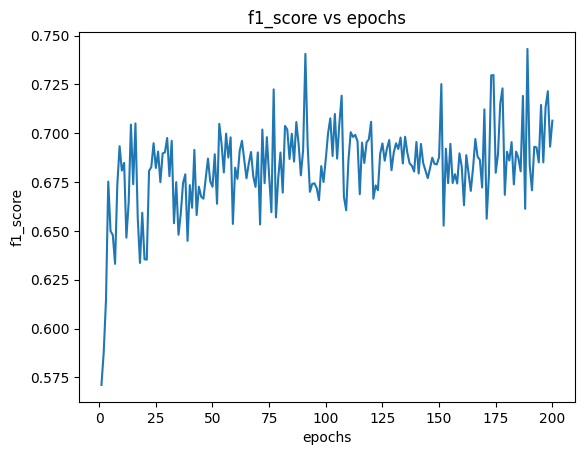

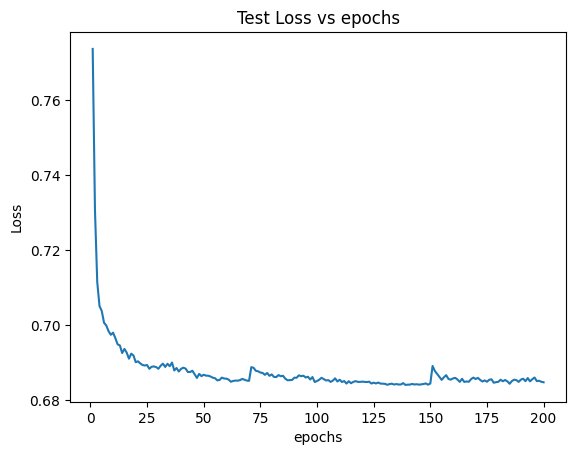

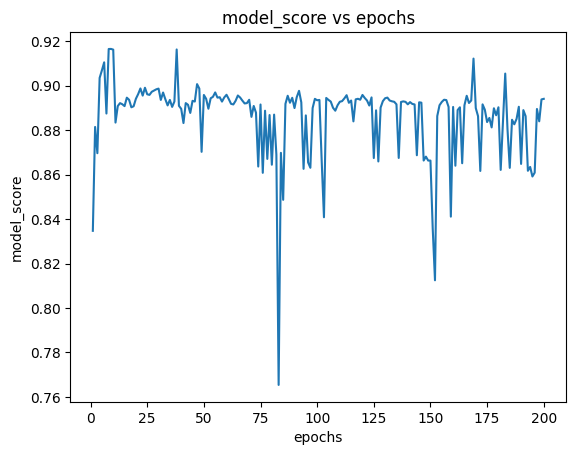

In [7]:
print(max_ms)   
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,201), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Test Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,201), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

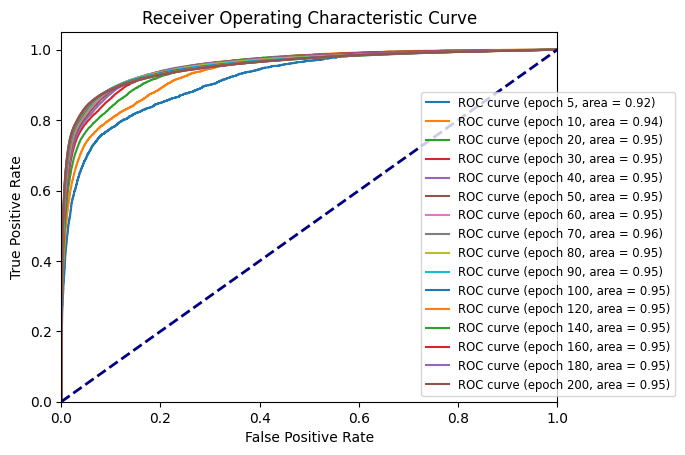

In [8]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)

In [9]:
# Evaluate the model on the validation set and obtain the predicted labels and probabilities
# Evaluate model on validation set
model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
            
        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
# thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

thresholded_val_preds = np.where(val_preds > np.array(thresh).reshape(1, -1), 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

100%|██████████| 28/28 [00:08<00:00,  3.48it/s]

  Label    Precision    Recall      F1     AUC
-------  -----------  --------  ------  ------
      0       0.5159    0.6667  0.6667  1
      1       0.3492    0.3333  1       0.95
      2       0.6825    0.6667  1       1
      3       0.6825    0.6667  1       1
      4       0.6825    0.6667  1       1
      5       0.6825    0.6667  1       1
      6       0.6825    0.6667  1       1
      7       0.5238    0.5     0       0.9
      8       0.5159    0.6667  0.6667  0.95
      9       0.3492    0.3333  1       0.95
     10       0.3492    0.3333  1       0.9
     11       0.5159    0.6667  0.6667  1
     12       0.5238    0.5     0       0.85
     13       0.5317    0.5     0.5     0.6842
     14       0.5159    0.6667  0.6667  1
     15       0.6825    0.6667  1       0.95
     16       0.6825    0.6667  1       1
     17       0.6825    0.6667  1       1
     18       0.6825    0.6667  1       1
     19       0.5159    0.6667  0.6667  0.9
     20       0.5238    0.5     0       

In [10]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)  # Restart kernel with True flag

{'status': 'ok', 'restart': True}

: 